# Analyze Model Results

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from MemoryAutoScaling import analysis, plotting, specs
from MemoryAutoScaling.Analysis import HarvestStats

pd.set_option('display.max_columns', None)

### Function Definitions

In [2]:
def render_params_bar_plot(params, counts, model_name):
    """Renders a bar plot of `params` for `model_name` based on `counts`.
    
    Parameters
    ----------
    params: np.array
        A numpy array of the most common optimal parameters.
    counts: np.array
        A numpy array of integers representing counts for the parameters.
    model_name: str
        A string representing the name of the model.
    
    Returns
    -------
    None
    
    """
    n = len(params)
    plt.figure(figsize=(20, 10))
    plt.bar(range(n), counts)
    plt.xticks(range(n), params, rotation=-15)
    plt.title("{} Model Most Common Optimal Parameter".format(model_name.upper()))
    plt.show()

In [3]:
def plot_most_prominent_params(model_results_df, top_params_count, model_name):
    """A plot of the `top_params_count` most prominent parameters in `model_results_df`.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing model results.
    top_params_count: int
        An integer representing the number of parameters to be included in the plot.
        The `top_params_count` most prominent parameters of `model_results_df` are plotted.
    model_name: str
        A string representing the name of the model.
    
    Returns
    -------
    None
    
    """
    params_data = model_results_df.groupby('params_{}'.format(model_name))['id'].count()
    params_data = params_data.sort_values(ascending=False)
    if len(params_data) > 5:
        params_data = params_data[:5]
    render_params_bar_plot(params_data.index, params_data.values, model_name)

In [4]:
def build_model_result_cdfs(model_results_df, model_name):
    """Builds CDFs of model result statistics for `model_name` from `model_results_df`.
    
    The CDFs are built for each model result statistic across all the traces modeled.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing the model results for all traces.
    model_name: str
        A string representing the name of the model fit to the traces.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors = ["blue", "red"]
    col_lst = ["test_mase", "under_mase"]
    for idx in range(len(colors)):
        col_name = "{0}_{1}".format(col_lst[idx], model_name)
        data_vals = model_results_df[col_name].values
        title_comps = col_name.title().split("_")
        title = " ".join(title_comps[:-1]) + " {}".format(title_comps[-1].upper())
        plotting.plot_cumulative_distribution_function(
            data_vals, axes[idx], title, colors[idx], "CDF")

In [5]:
def plot_harvest_df_cdfs(harvest_df, harvest_stat_cols, buffer_pct):
    """Plots CDFs of `harvest_stat_cols` from `harvest_df` at `buffer_pct`.
    
    Plots a cumulative distribution function for each column of `harvest_df`
    based on the columns in `harvest_stat_cols` and `buffer_pct`.
    
    Parameters
    ----------
    harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest data to be plotted acrosss
        all traces.
    harvest_stat_cols: list
        A list of strings representing the names of the columns to be plotted
        from `harvest_df`.
    buffer_pct: float
        A float representing the buffer percentage used to calculate the harvest
        statistics in `harvest_df`.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors = ["blue", "red"]
    for idx in range(2):
        col_name = harvest_stat_cols[idx]
        data_vals = harvest_df[col_name].values
        title = "{0} With {1}% Buffer".format(" ".join(col_name.title().split("_")), int(buffer_pct * 100))
        plotting.plot_cumulative_distribution_function(data_vals, axes[idx], title, colors[idx], "CDF")
    plt.show()

In [6]:
def plot_harvest_df_scatter(harvest_df, harvest_stat_cols, buffer_pct):
    """A scatterplot for `harvest_stat_cols` based on the data in `harvest_df`.
    
    Parameters
    ----------
    harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest data to be plotted acrosss
        all traces.
    harvest_stat_cols: list
        A list of strings representing the names of the columns to be plotted
        from `harvest_df`.
    buffer_pct: float
        A float representing the buffer percentage used to calculate the harvest
        statistics in `harvest_df`.
    
    Returns
    -------
    None
    
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(harvest_df[harvest_stat_cols[0]].values, harvest_df[harvest_stat_cols[1]].values)
    plt.xlabel(" ".join(harvest_stat_cols[0].split("_")).title())
    plt.ylabel(" ".join(harvest_stat_cols[1].split("_")).title())
    plt.ylim(0, 1)
    plt.title("Harvest Statistics with {}% Buffer".format(int(buffer_pct*100)))
    plt.show()

In [7]:
def print_summary_for_buffer(model_harvest_df, harvest_stats_cols, pct_buffer, model_name):
    """A summary of `model_harvest_df` for `harvest_stats_cols` at `pct_buffer`.
    
    The summary consists of cumulative distribution functions for the columns of
    `model_harvest_df` indicated by `harvest_stats_cols` at `pct_buffer`. In
    addition, the summary contains a summary of these columns in table format.
    
    Parameters
    ----------
    model_harvest_df: pd.DataFrame
        A pandas DataFrame containing the harvest statistics results for
        `harvest_stats_cols` at `pct_buffer`.
    harvest_stats_cols: list
        A list of strings representing the names of the columns for which the
        summary is generated.
    pct_buffer: float
        A float representing the buffer percentage used to generate the harvest
        statistics.
    model_name: str
        A string representing the name of the model for which the results were 
        generated.
    
    Returns
    -------
    None
    
    """
    buffer_harvest_cols = ["{0}_{1}_{2}".format(
                                harvest_col, pct_buffer, model_name) 
                           for harvest_col in harvest_stats_cols]
    buffer_harvest_df = model_harvest_df[buffer_harvest_cols].abs()
    buffer_harvest_df.columns = harvest_stats_cols
    plot_harvest_df_cdfs(buffer_harvest_df, harvest_stats_cols, pct_buffer)
    plot_harvest_df_scatter(buffer_harvest_df, harvest_stats_cols, pct_buffer)
    print(buffer_harvest_df.describe())

In [8]:
def summarize_harvest_results_for_model_results_df(model_results_df, model_name):
    """Summarizes the model results for `model_name` in `model_results_df`.
    
    A summary is created for each buffer percentage for which the harvest statistics
    in `model_results_df` were generated.
    
    Parameters
    ----------
    model_results_df: pd.DataFrame
        A pandas DataFrame containing the best model results for each trace
        when a model of class `model_name` was tuned on the trace.
    model_name: str
        A string representing the name of the model for which the results were
        generated.
    
    Returns
    -------
    None
    
    """
    harvest_stat_columns = HarvestStats.get_harvest_stat_columns()
    for buf_pct in specs.BUFFER_PCTS:
        print_summary_for_buffer(
            model_results_df, harvest_stat_columns, buf_pct, model_name)

In [9]:
def get_model_results(data_dir, top_params_count, model_name):
    """Retrieves the model results for `model_name` from `data_dir`.
    
    Parameters
    ----------
    data_dir: str
        A string representing the directory containing the model results.
    top_params_count: int
        An integer representing the number of parameters to be included in the plot.
        The `top_params_count` most prominent parameters of `model_results_df` are plotted.
    model_name: str
        A string representing the name of the model for which results are retrieved.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the model results.
    
    """
    model_df = pd.read_csv(os.path.join(data_dir, "{}_results.csv".format(model_name)))
    model_df = model_df[~np.isnan(model_df['test_mase_{}'.format(model_name)])]
    print(model_df.describe())
    plot_most_prominent_params(model_df, top_params_count, model_name)
    build_model_result_cdfs(model_df, model_name)
    summarize_harvest_results_for_model_results_df(model_df, model_name)
    return model_df

In [10]:
def plot_cdfs_across_models(results_dfs, cdf_col):
    """Plots the CDFs of `cdf_col` across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    cdf_col: str
        A string representing the name of the variable for which the CDFs are
        generated.
    
    Returns
    -------
    None
    
    """
    styles = ['b-', 'g--', 'r-.', 'c:', 'm.', 'bo', 'k^']
    plt.figure(figsize=(20, 10))
    idx = 0
    for model_name in results_dfs.keys():
        dist_vals = results_dfs[model_name]["{0}_{1}".format(cdf_col, model_name)].values
        x, y = plotting.get_cdf_values(dist_vals)
        plt.plot(x, y, styles[idx], label=model_name.upper())
        idx += 1
    plt.title("CDFs of {} Across Models".format(" ".join(cdf_col.title().split("_"))))
    plt.legend()
    plt.show()

In [11]:
def plot_harvest_cdfs_across_models(results_dfs, cdf_col):
    """Plots the CDFs of `cdf_col` across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    cdf_col: str
        A string representing the name of the variable for which the CDFs are
        generated.
    
    Returns
    -------
    None
    
    """
    styles = ['b-', 'g--', 'r-.', 'c:', 'm.', 'bo', 'k^']
    plt.figure(figsize=(20, 10))
    idx = 0
    for model_name in results_dfs.keys():
        dist_vals = results_dfs[model_name]["{0}_{1}".format(cdf_col, model_name)].values
        x, y = plotting.get_cdf_values(dist_vals)
        plt.plot(x, y, styles[idx], label=model_name.upper())
        idx += 1
    cdf_col_comps = cdf_col.split("_")
    buffer = int(float(cdf_col_comps[-1]) * 100)
    col_name = " ".join(cdf_col_comps[:-1]).title()
    plt.title("CDFs of {0} Across Models with {1}% Buffer".format(col_name, buffer))
    plt.legend()
    plt.show()

In [12]:
def plot_all_cdfs_across_models(results_dfs):
    """Plots all of the model result CDFs across the models of `results_dfs`.
    
    Parameters
    ----------
    results_dfs: dict
        A dictionary of model results. The keys are strings representing the
        name of the model. The corresponding value is a pandas DataFrame
        recording results for the model across all traces.
    
    Returns
    -------
    None
    
    """
    for cdf_col in ["test_mase", "under_mase"]:
        plot_cdfs_across_models(results_dfs, cdf_col)
    for cdf_col in HarvestStats.get_harvest_columns_for_buffers():
        plot_harvest_cdfs_across_models(results_dfs, cdf_col)

In [13]:
def render_best_model_bar_plot(model_names, counts):
    """Renders a bar plot of the `counts` data for `model_names`.
    
    Parameters
    ----------
    model_names: np.array
        A numpy array of strings representing the names of the best models.
    counts: np.array
        A numpy array of integers representing the counts for each model of
        `model_names` of traces for which that model performs best.
    
    Returns
    -------
    None
    
    """
    n = len(model_names)
    plt.figure(figsize=(20, 10))
    plt.bar(range(n), counts)
    plt.xticks(range(n), model_names)
    plt.title("Counts of Best Model Types")
    plt.show()

In [14]:
def plot_counts_of_best_model_types(best_models_df):
    """Plots the counts of best model types from `best_models_df`.
    
    A bar plot is rendered which counts the model of each type in
    `best_models_df`.
    
    Parameters
    ----------
    best_models_df: pd.DataFrame
        A pandas DataFrame containing the results for the best model for each
        trace. There is a row for each trace specifying the trace id, model name,
        model parameters, and model results.
    
    Returns
    -------
    None
    
    """
    counts_data = best_models_df.groupby('model')['id'].count()
    counts_data = counts_data.sort_values(ascending=False)
    render_best_model_bar_plot(counts_data.index, counts_data.values)

In [15]:
def display_best_model_results_for_all_traces(data_dir):
    """Displays a summary of the best model results found in `data_dir`.
    
    A pandas DataFrame of the best model results is loaded from `data_dir`. For
    this dataframe, summary statistics are printed. Then a bar plot is created
    which counts the number of traces for which each model outperforms all other
    models. Lastly, a plot of 4 CDFs summarizing the 4 model evaluation parameters
    is plotted across all traces.
    
    Parameters
    ----------
    data_dir: str
        A string representing the directory from which the best model results
        are loaded.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame of the best model results for each trace.
    
    """
    best_model_df = pd.read_csv(os.path.join(data_dir, "best_model_results.csv"))
    print(best_model_df.describe())
    plot_counts_of_best_model_types(best_model_df)
    build_model_result_cdfs(best_model_df, "best")
    summarize_harvest_results_for_model_results_df(best_model_df, "best")
    return best_model_df

In [16]:
def compare_model_harvest_results(model_dfs):
    """Compares model harvest percentages across models in `model_dfs`.
    
    For each buffer percentage a plot is rendered showing the proportion of
    the total resource harvested across all traces for each model.
    
    Parameters
    ----------
    model_dfs: dict
        A dictionary of model results DataFrames. The keys are strings representing
        the names of the model and the associated value is the corresponding model
        results DataFrame for that model.
    
    Returns
    -------
    None
    
    """
    for buffer_pct in specs.BUFFER_PCTS:
        analysis.plot_prop_harvested_by_model(model_dfs, buffer_pct)

### Maximum Memory Usage - 3 Period Aggregation

In [17]:
max_mem_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_mem_3"
model_results_dfs = {}

                 id  train_mase_ma  test_mase_ma  under_mase_ma  \
count  1.432000e+03    1432.000000   1432.000000    1432.000000   
mean   3.708082e+11       1.116134      1.040539       0.512955   
std    7.680769e+10       1.050206      0.535621       0.446677   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.807102e+11       0.937688      0.865643       0.403830   
50%    3.835432e+11       1.012328      0.980310       0.477773   
75%    3.961267e+11       1.130549      1.041957       0.521390   
max    4.004415e+11      38.750000     12.086905      11.856803   

       prop_under_preds_ma  max_under_pred_ma  over_mase_ma  \
count          1432.000000        1419.000000   1432.000000   
mean              0.439881         521.161695      0.527583   
std               0.111724        4453.859531      0.312812   
min               0.000000           0.001098      0.000000   
25%               0.384615           1.530584      0.431491   
50%               

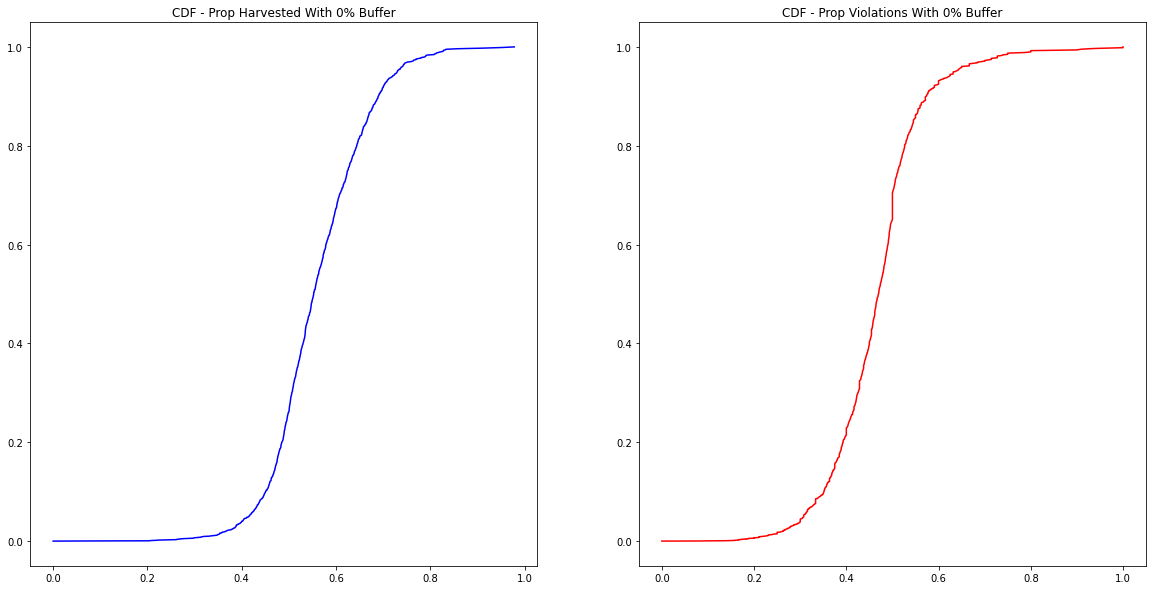

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.537533         0.439871
std          0.115288         0.111727
min          0.000000         0.000000
25%          0.482054         0.384615
50%          0.534862         0.452413
75%          0.603828         0.500000
max          0.978260         1.000000


       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.669483         0.192710
std          0.170339         0.132249
min          0.000000         0.000000
25%          0.585885         0.084875
50%          0.678837         0.187600
75%          0.786527         0.285714
max          0.994004         0.636364


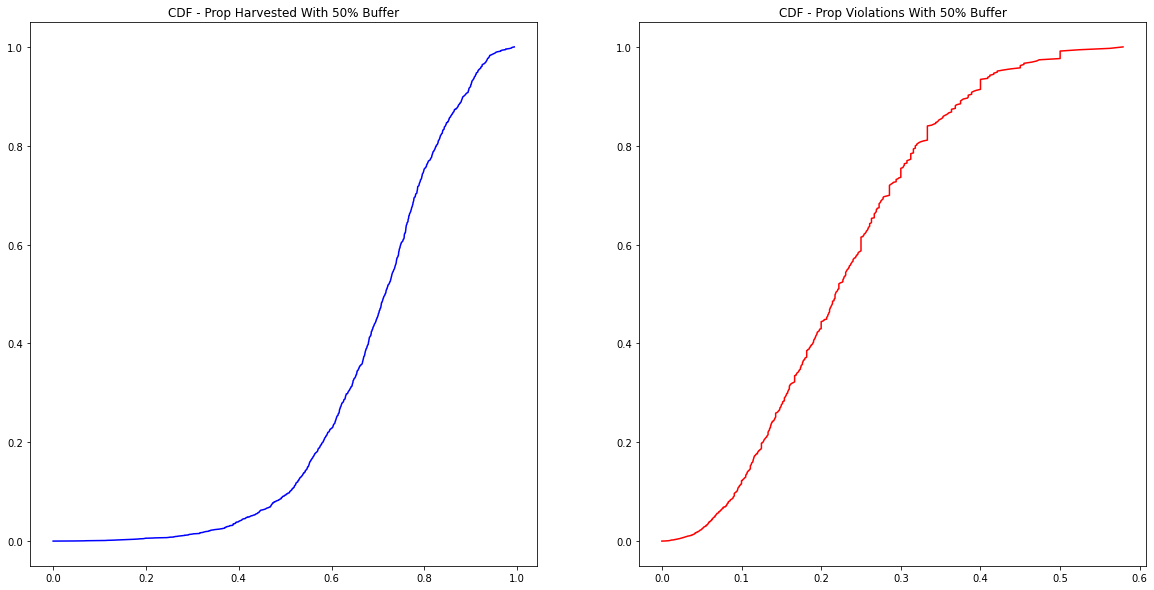

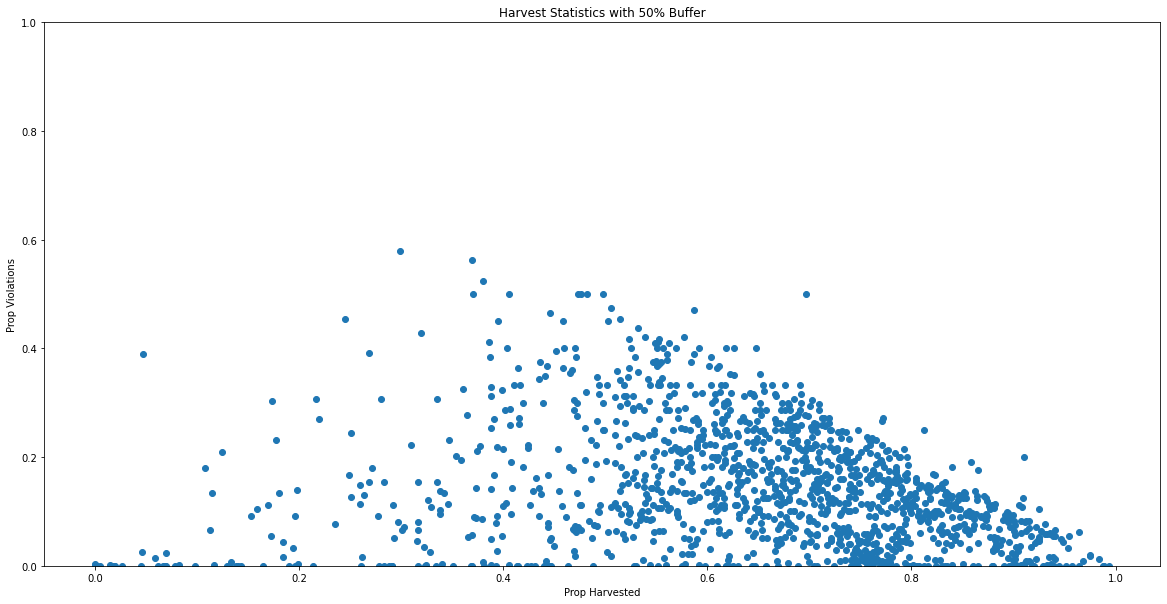

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.627923         0.138379
std          0.211504         0.111971
min          0.000000         0.000000
25%          0.537998         0.049918
50%          0.671147         0.120000
75%          0.768901         0.210526
max          0.993902         0.578947


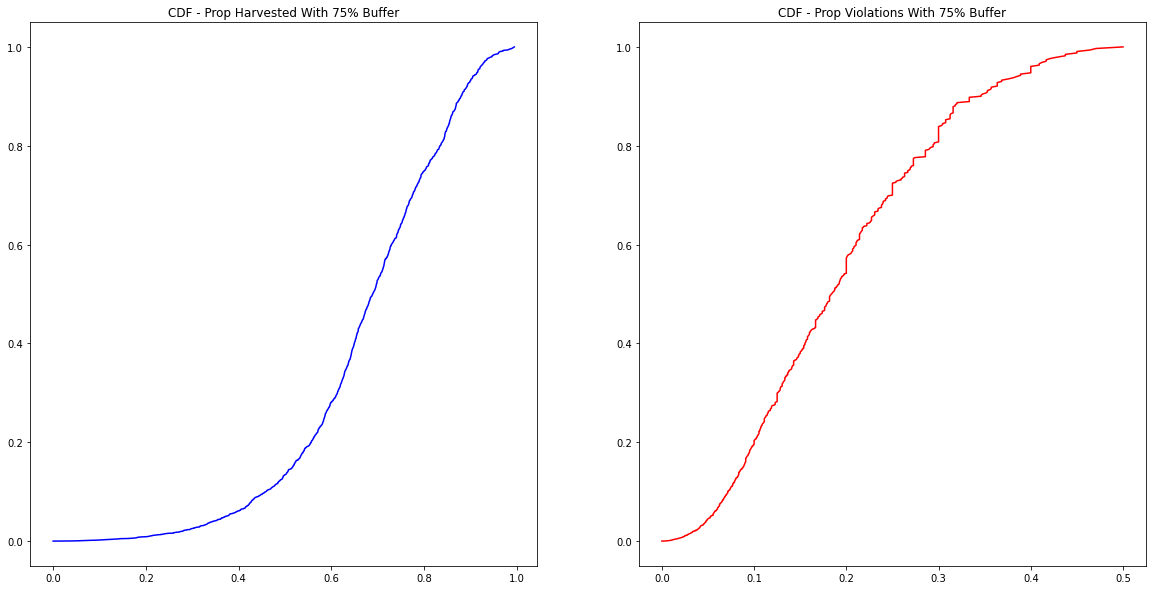

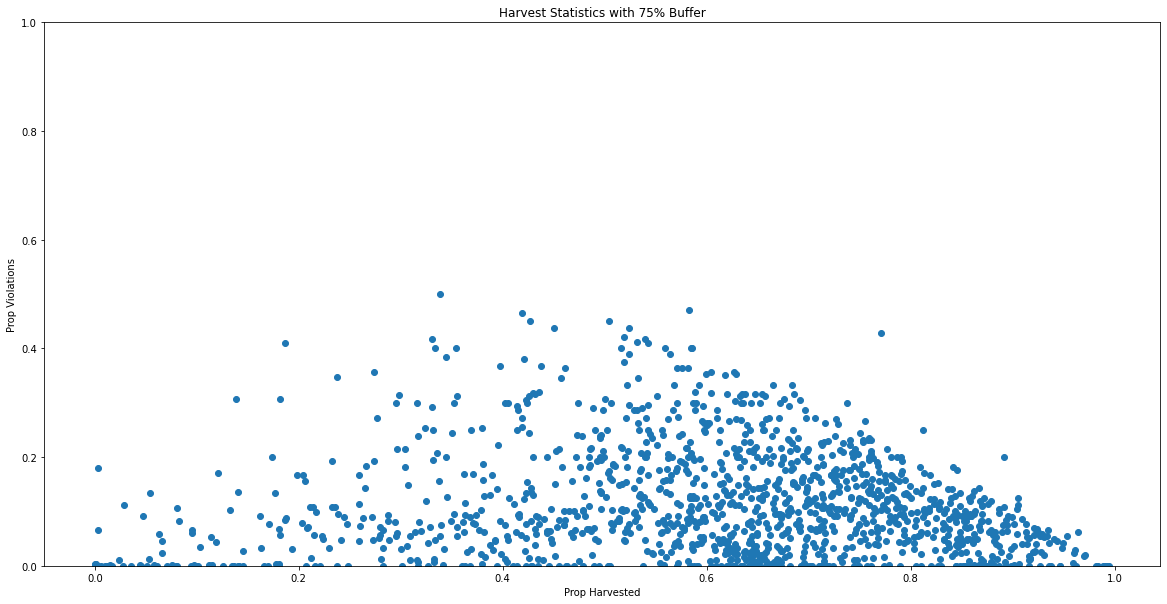

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.581821         0.108183
std          0.238135         0.097682
min          0.000000         0.000000
25%          0.466452         0.028471
50%          0.630082         0.088235
75%          0.749324         0.162897
max          0.994839         0.500000


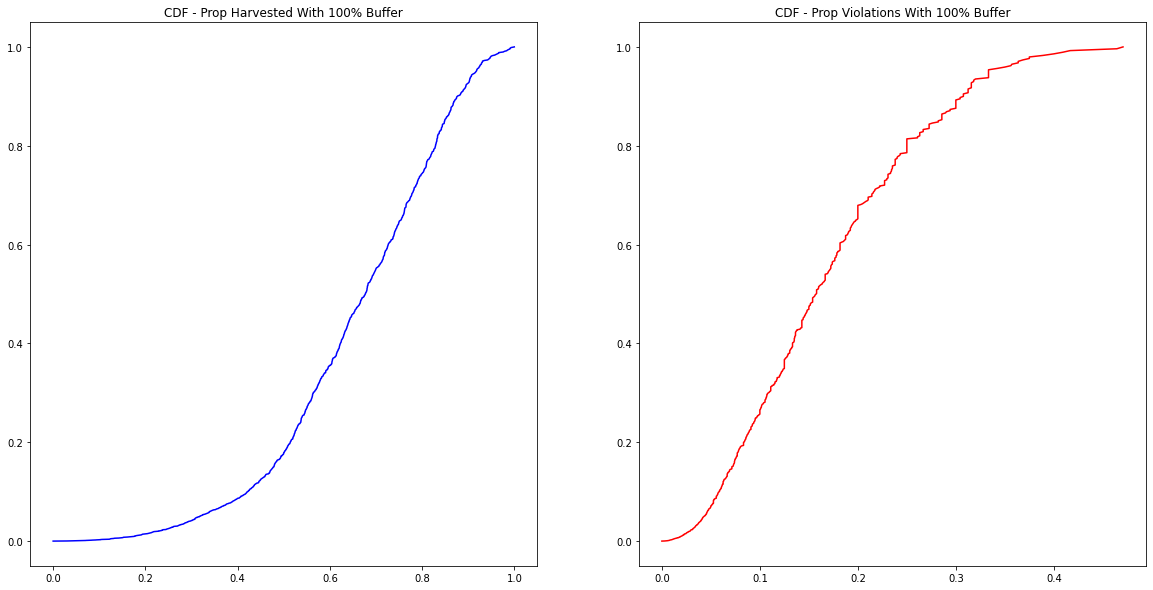

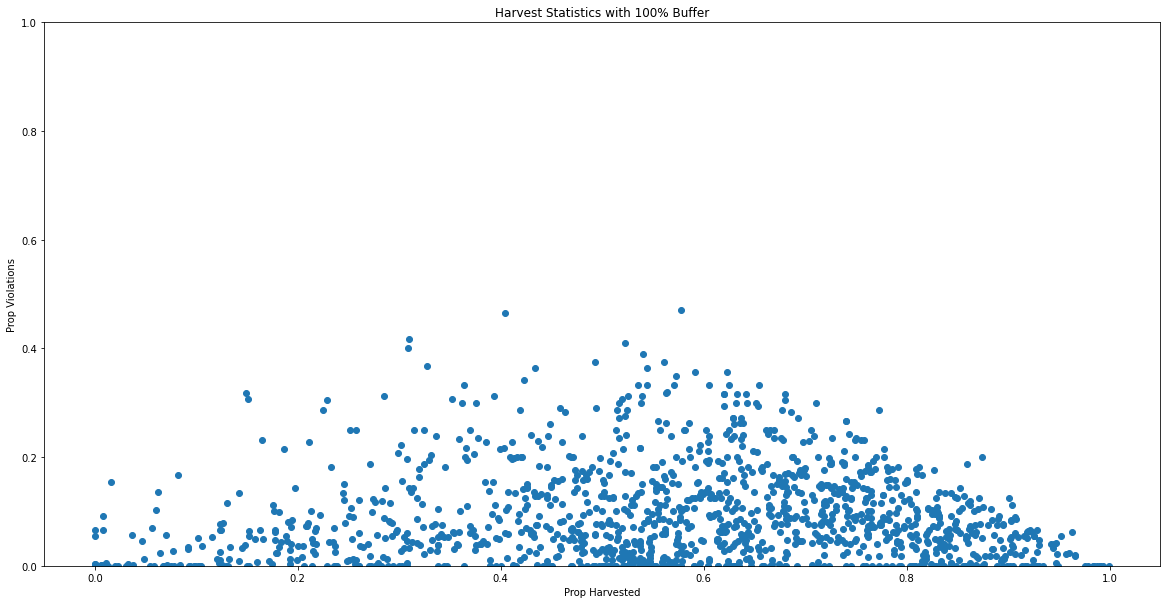

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.539138         0.087482
std          0.254500         0.085509
min          0.000000         0.000000
25%          0.392249         0.016089
50%          0.572906         0.065022
75%          0.736980         0.133397
max          0.999843         0.470588


In [18]:
model_results_dfs['ma'] = get_model_results(max_mem_3_dir, 5, "ma")

                 id  train_mase_es  test_mase_es  under_mase_es  \
count  1.432000e+03   1.432000e+03   1432.000000    1432.000000   
mean   3.708082e+11   1.209746e+00      1.101409       0.502732   
std    7.680769e+10   1.172032e+00      0.682156       0.438963   
min    1.950000e+02   2.095689e-09      0.000000       0.000000   
25%    3.807102e+11   9.409676e-01      0.872060       0.384693   
50%    3.835432e+11   1.007049e+00      0.960127       0.460165   
75%    3.961267e+11   1.209876e+00      1.073109       0.520360   
max    4.004415e+11   3.863122e+01     11.176209      10.607598   

       prop_under_preds_es  max_under_pred_es  over_mase_es  \
count          1432.000000        1414.000000   1432.000000   
mean              0.425624          91.693443      0.598678   
std               0.136305        1607.115367      0.553052   
min               0.000000           0.000878      0.000000   
25%               0.349347           1.177638      0.435091   
50%               

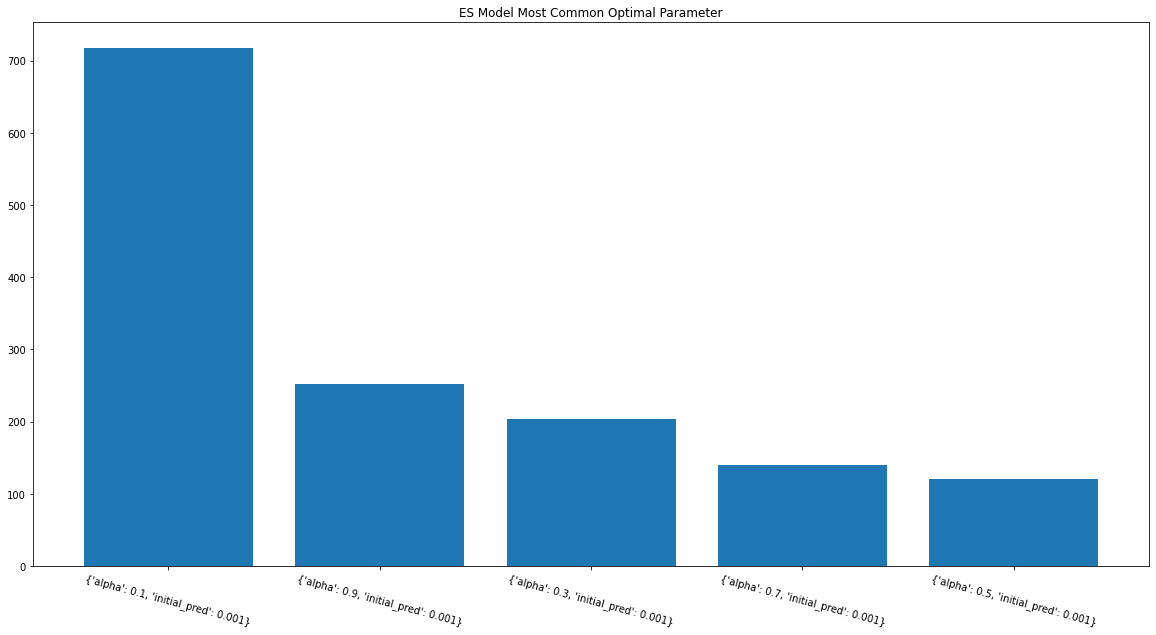

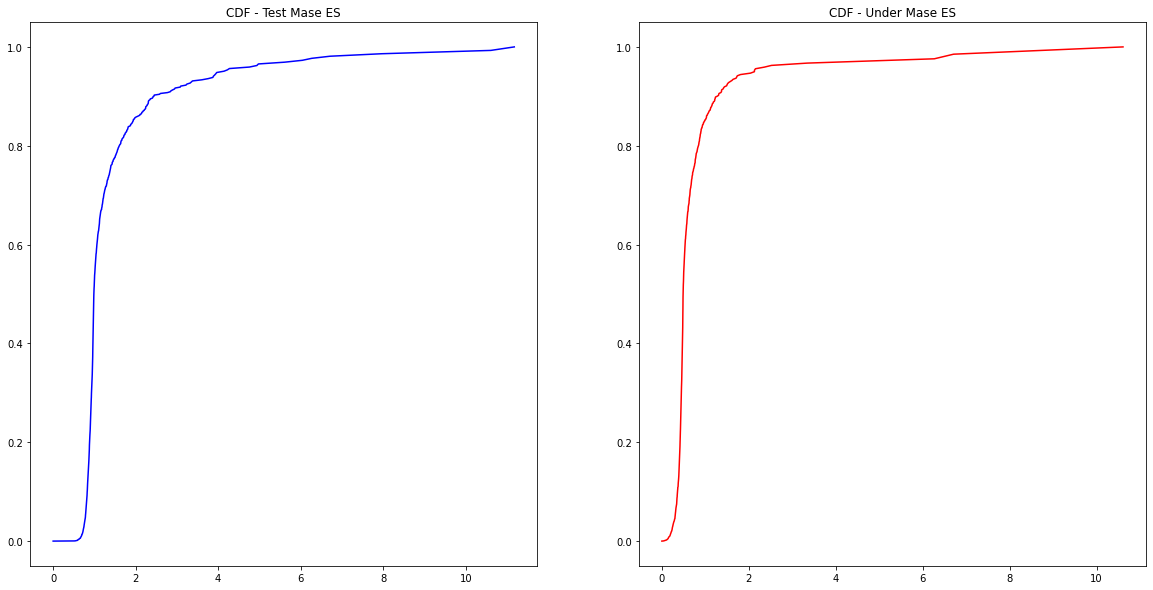

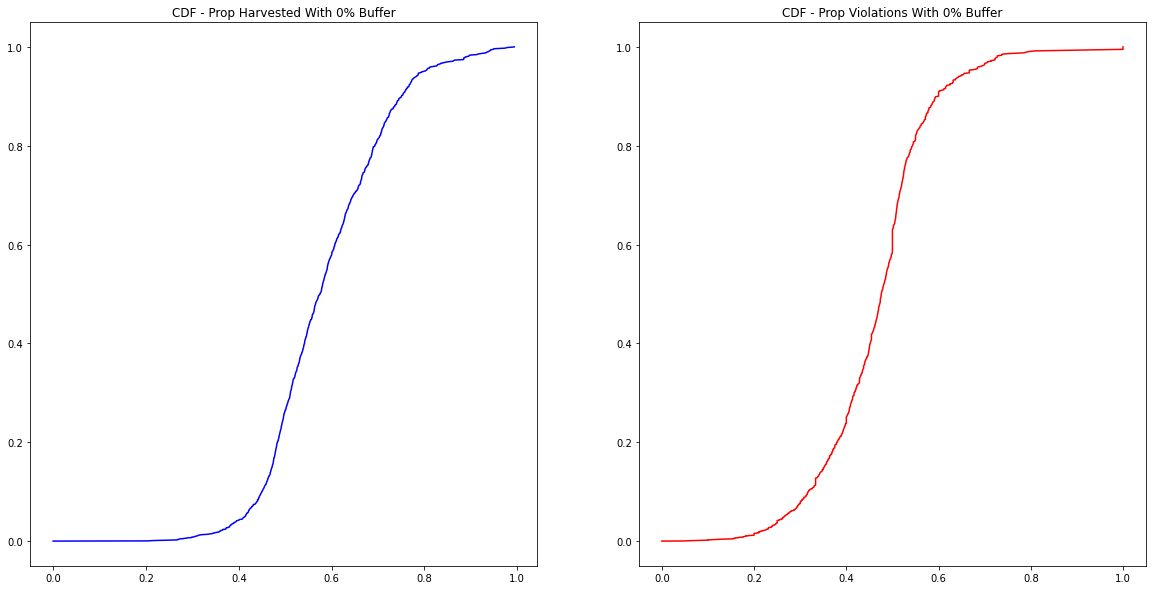

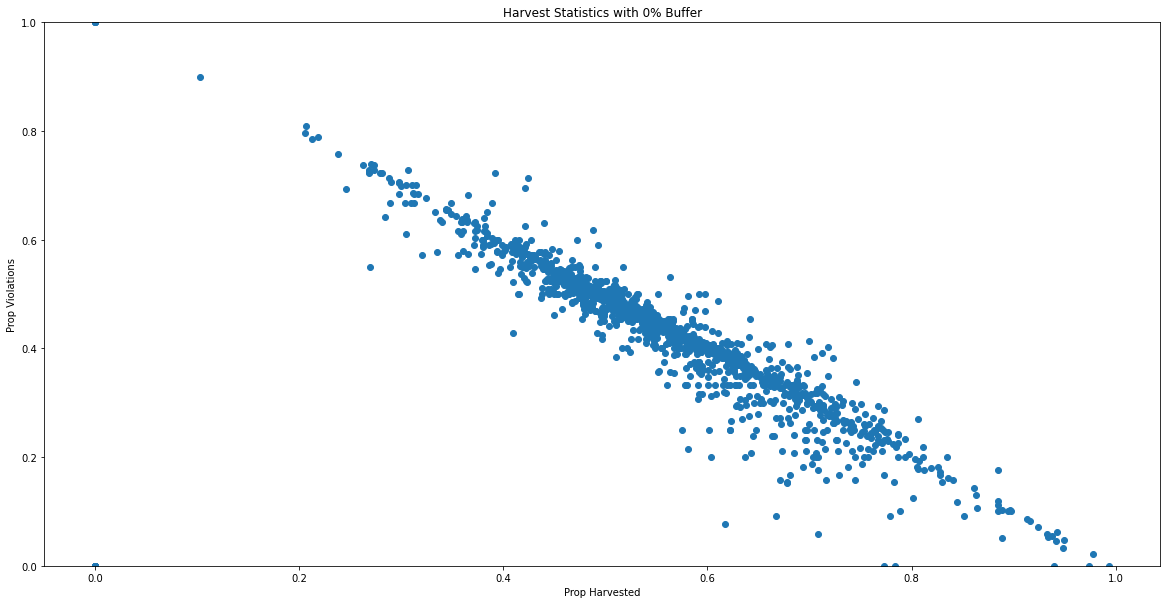

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.554129         0.425624
std          0.136300         0.136305
min          0.000000         0.000000
25%          0.478773         0.349347
50%          0.543544         0.448240
75%          0.635548         0.507777
max          0.993720         1.000000


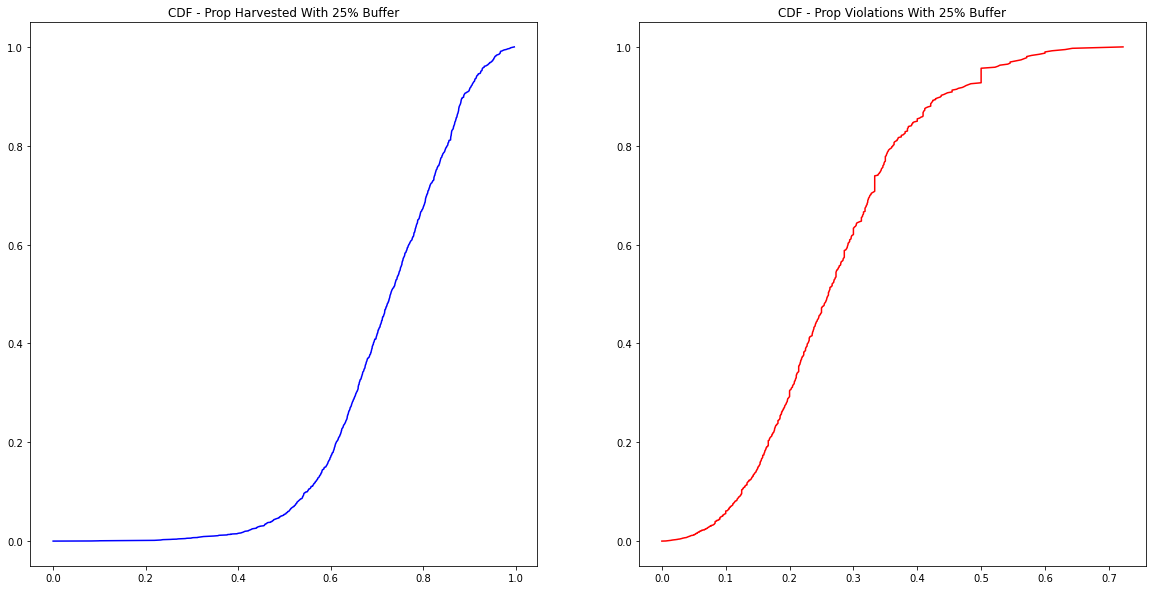

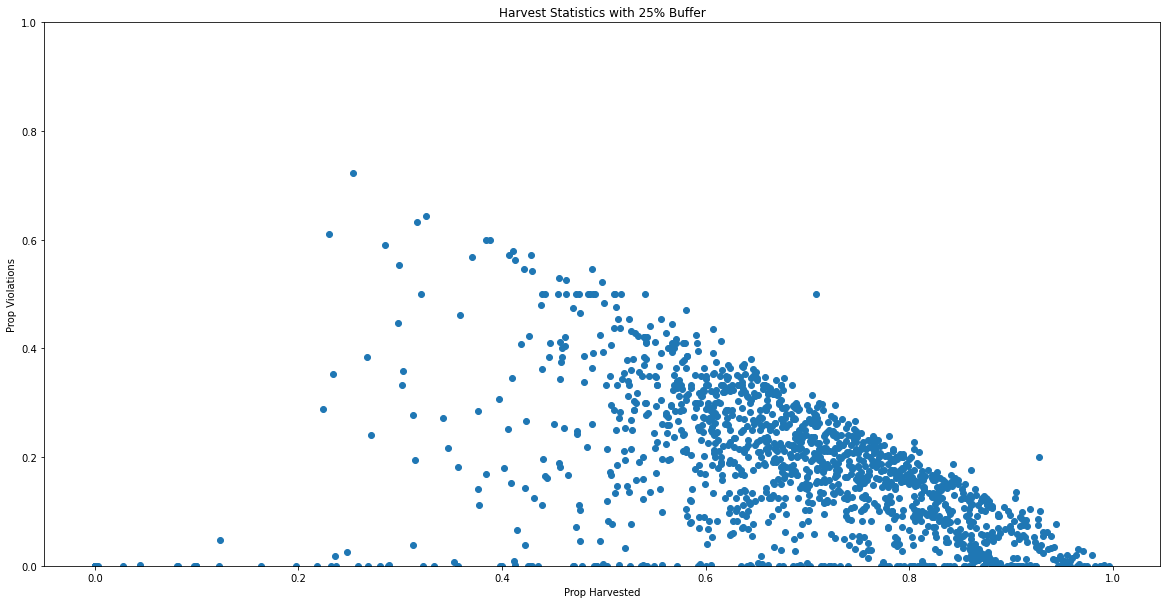

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.681504         0.178211
std          0.169924         0.130250
min          0.000000         0.000000
25%          0.599752         0.074880
50%          0.695080         0.168465
75%          0.802504         0.261755
max          0.996740         0.722222


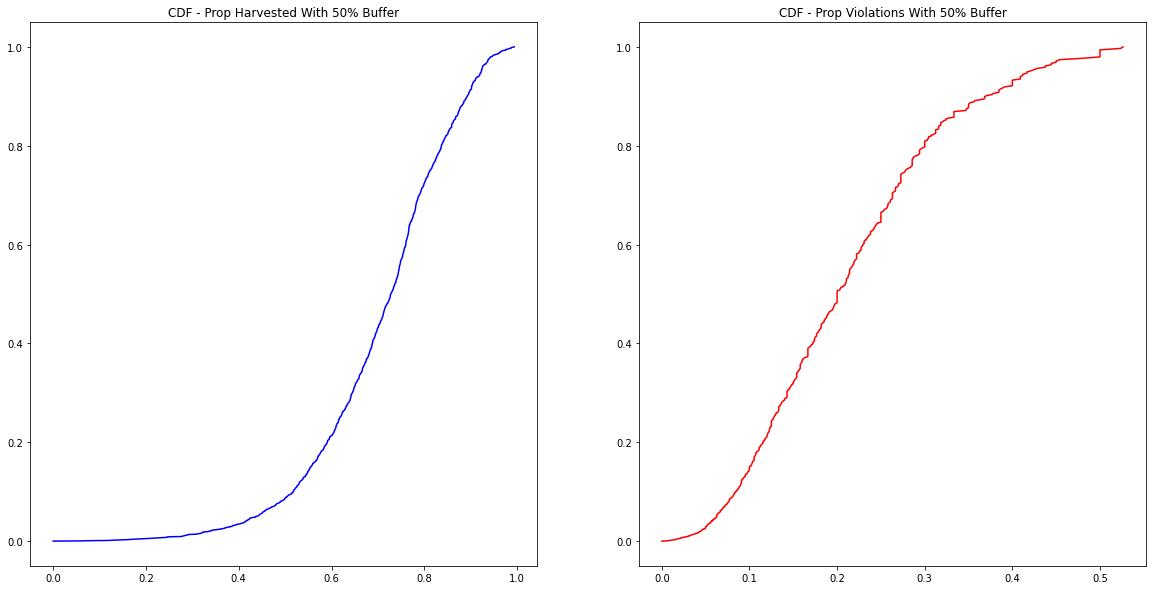

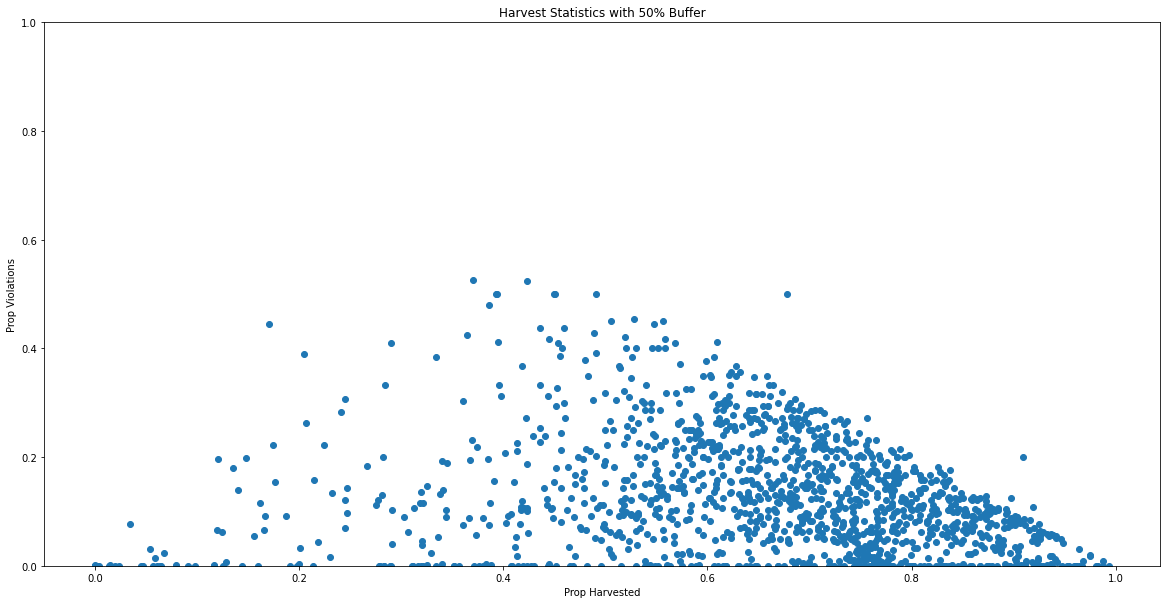

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.636103         0.122706
std          0.214122         0.105880
min          0.000000         0.000000
25%          0.545022         0.037123
50%          0.680175         0.103485
75%          0.777697         0.185349
max          0.993788         0.526316


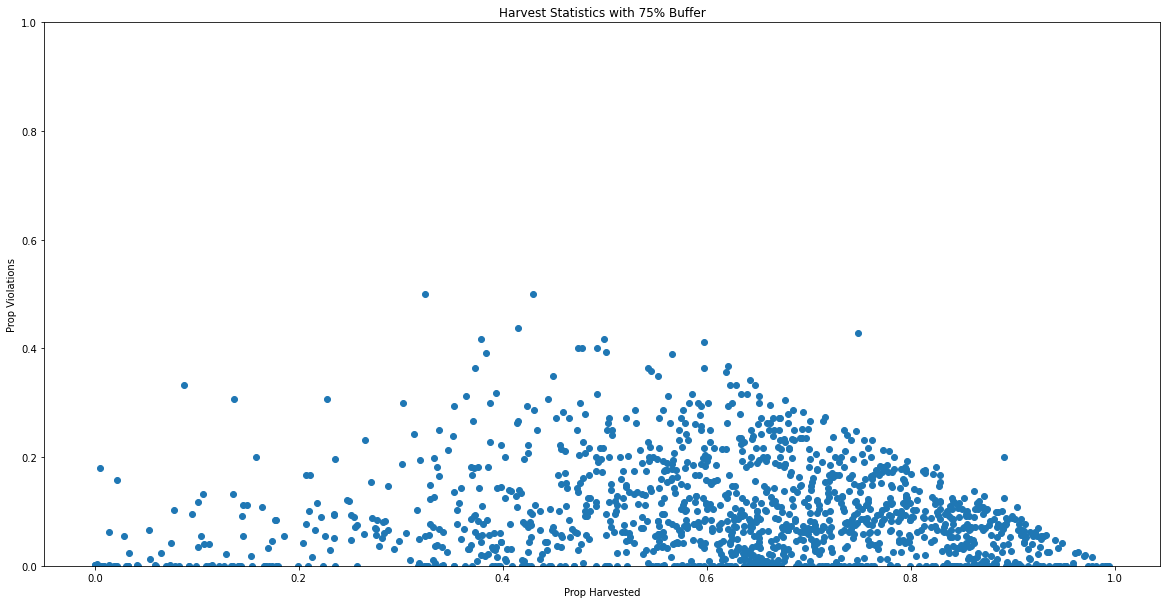

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.585085         0.092946
std          0.241746         0.089294
min          0.000000         0.000000
25%          0.461575         0.016772
50%          0.635615         0.071717
75%          0.757587         0.142642
max          0.994832         0.500000


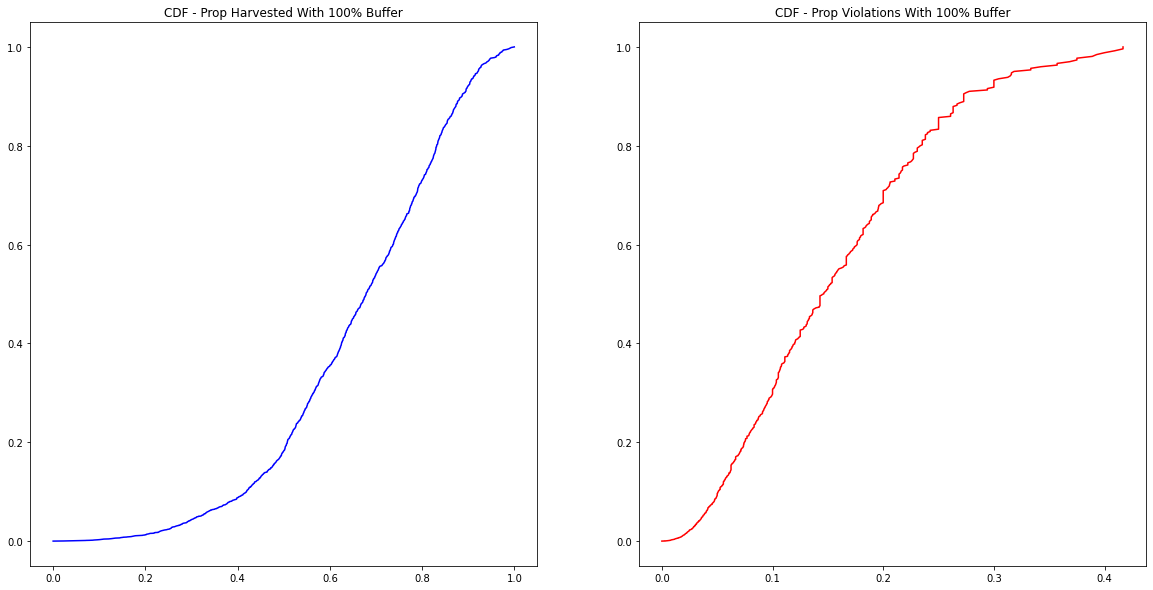

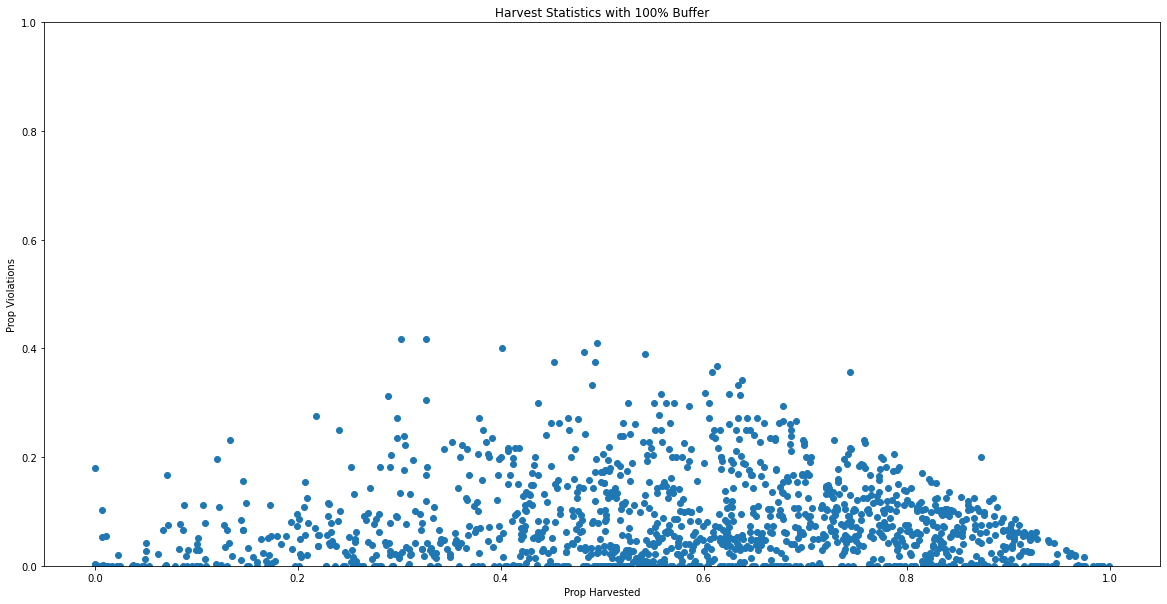

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.536992         0.074093
std          0.259116         0.079171
min          0.000000         0.000000
25%          0.381048         0.004438
50%          0.568282         0.050935
75%          0.740936         0.111111
max          0.999843         0.416667


In [19]:
model_results_dfs['es'] = get_model_results(max_mem_3_dir, 5, "es")

                 id  train_mase_ar  test_mase_ar  under_mase_ar  \
count  1.432000e+03    1432.000000   1432.000000    1432.000000   
mean   3.708082e+11       1.038154      3.835446       3.017746   
std    7.680769e+10       1.044834     17.043178      16.985271   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.807102e+11       0.883406      1.020145       0.332122   
50%    3.835432e+11       0.971482      1.525461       0.861433   
75%    3.961267e+11       1.058430      2.861818       2.091821   
max    4.004415e+11      38.750731    512.926101     512.921895   

       prop_under_preds_ar  max_under_pred_ar  over_mase_ar  \
count          1432.000000        1413.000000   1432.000000   
mean              0.637284        2162.423721      0.817699   
std               0.301291       11777.454566      2.452856   
min               0.000000           0.001075      0.000000   
25%               0.378338           0.507217      0.020870   
50%               

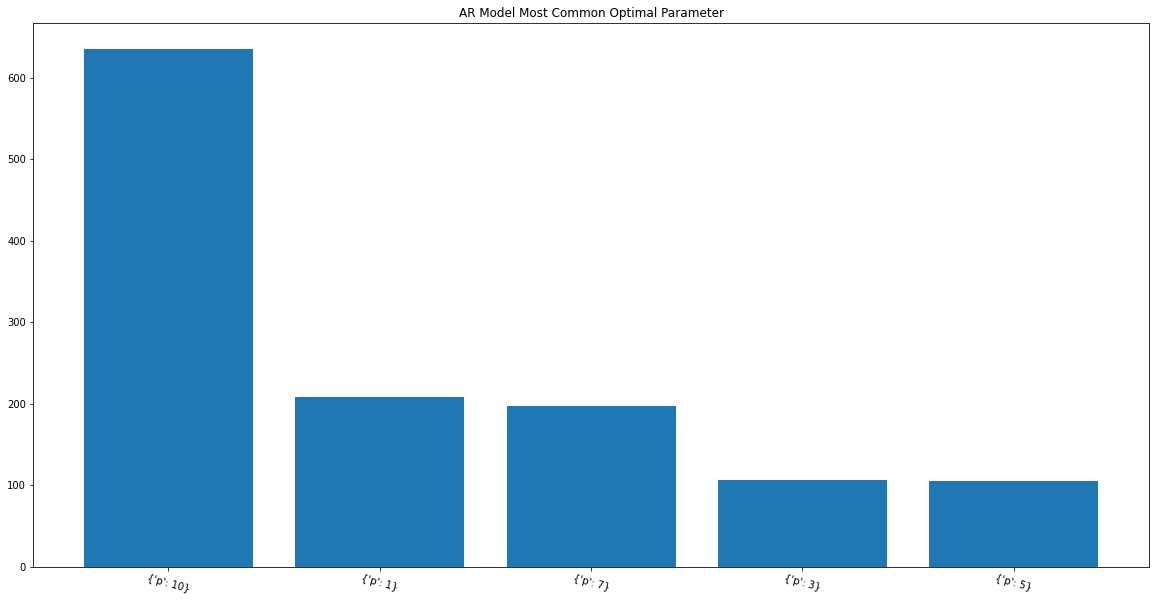

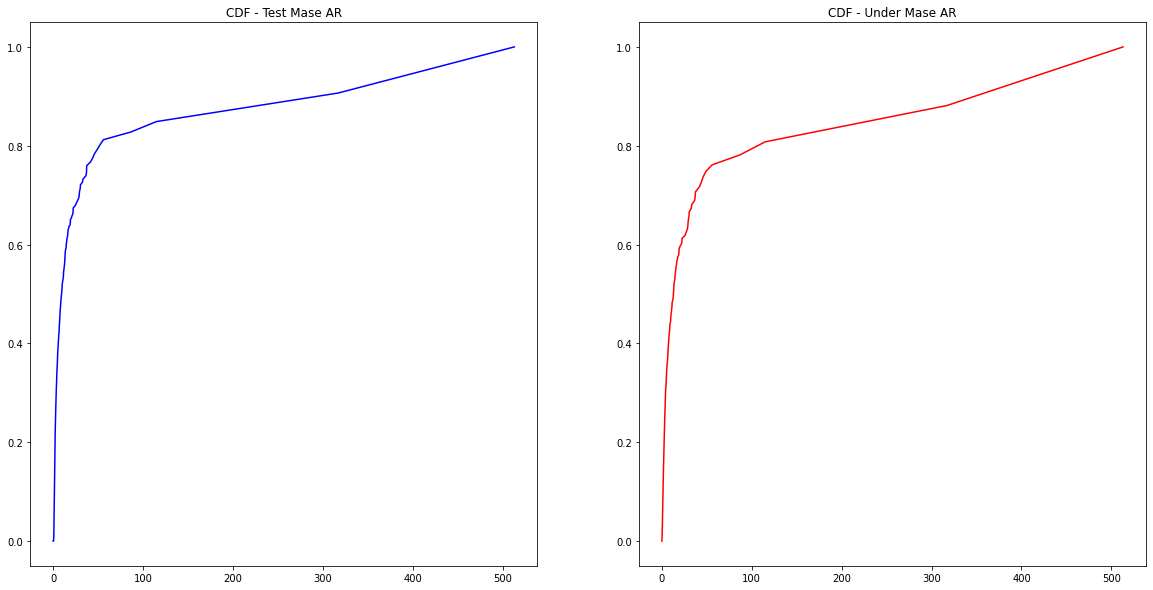

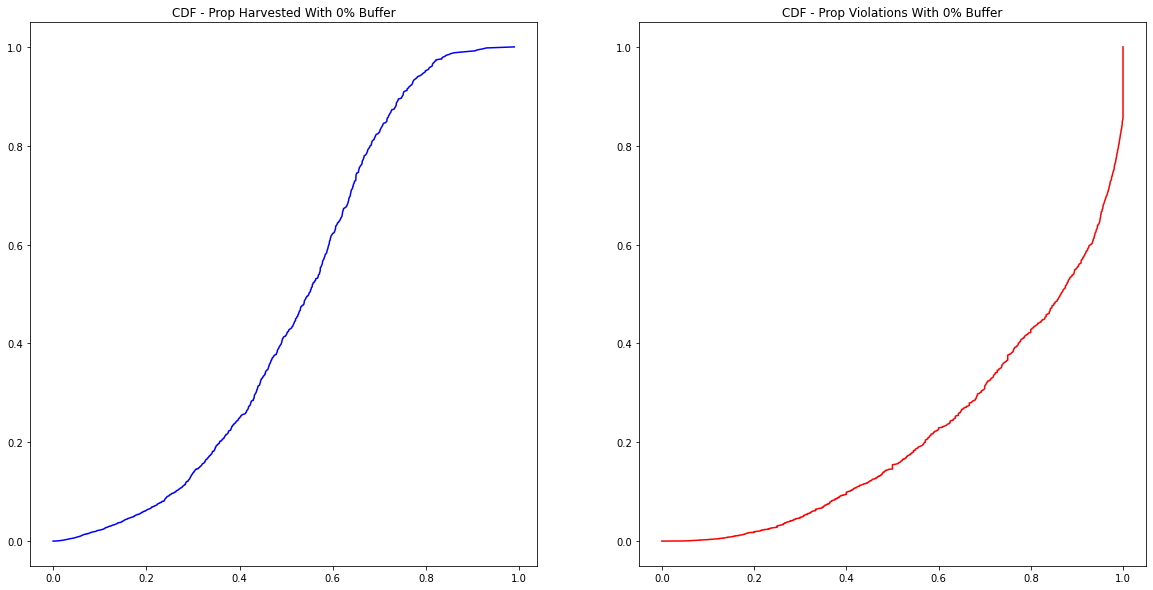

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.329722         0.637284
std          0.252149         0.301291
min          0.000000         0.000000
25%          0.067881         0.378338
50%          0.328857         0.684211
75%          0.547823         0.937500
max          0.989348         1.000000


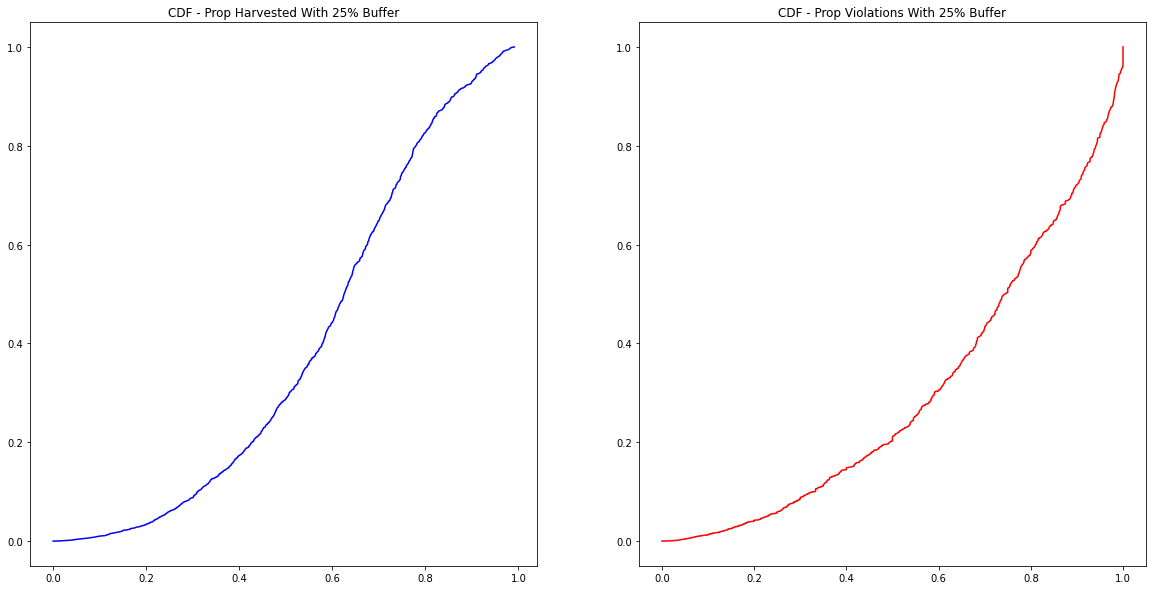

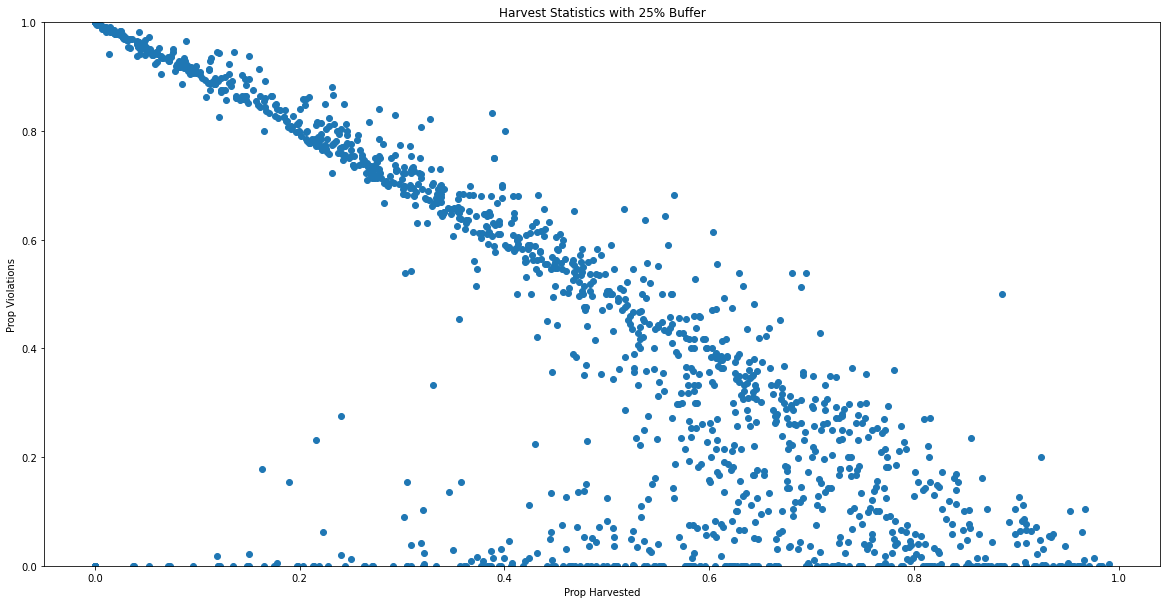

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.454848         0.430972
std          0.261226         0.341743
min          0.000000         0.000000
25%          0.244489         0.076923
50%          0.475487         0.400000
75%          0.659629         0.733566
max          0.990967         1.000000


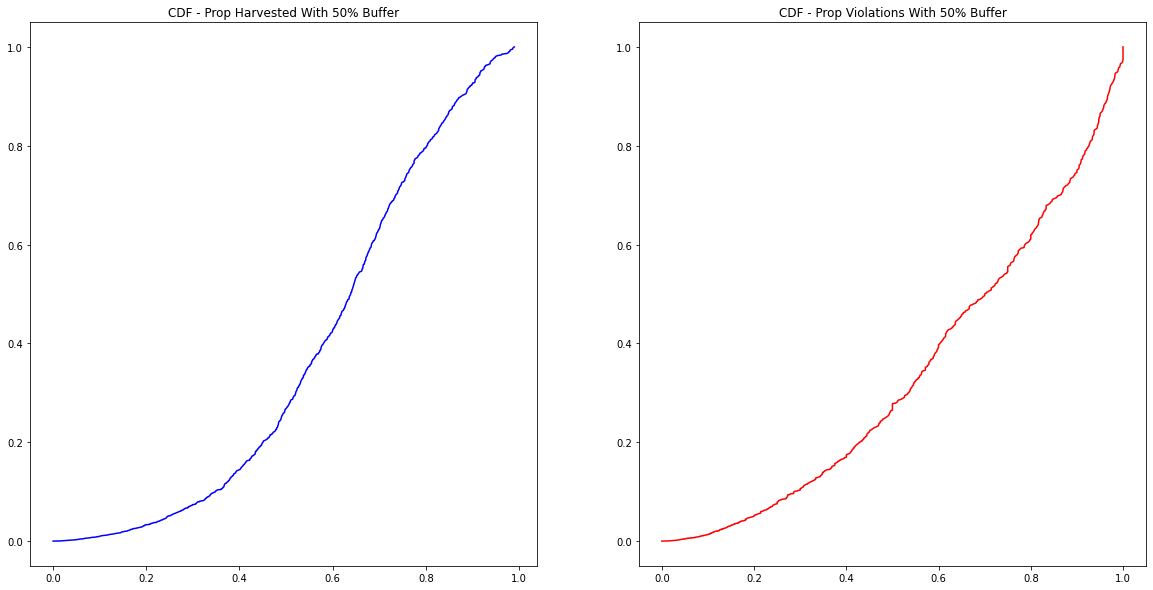

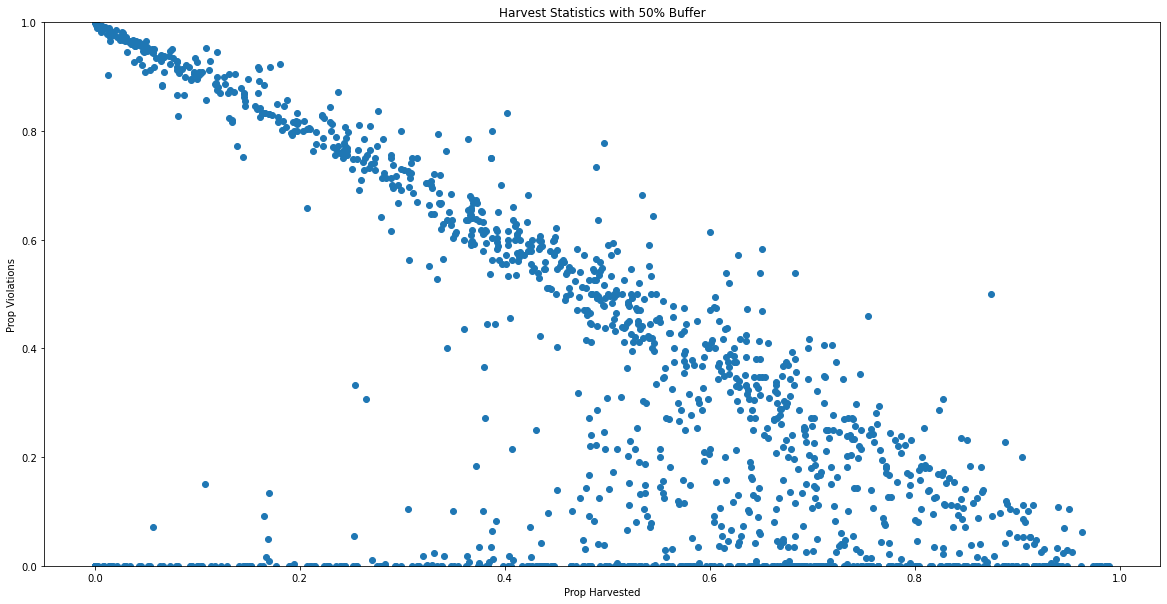

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.464661         0.346162
std          0.267835         0.332554
min          0.000000         0.000000
25%          0.247069         0.000000
50%          0.496125         0.263585
75%          0.671760         0.606469
max          0.990027         1.000000


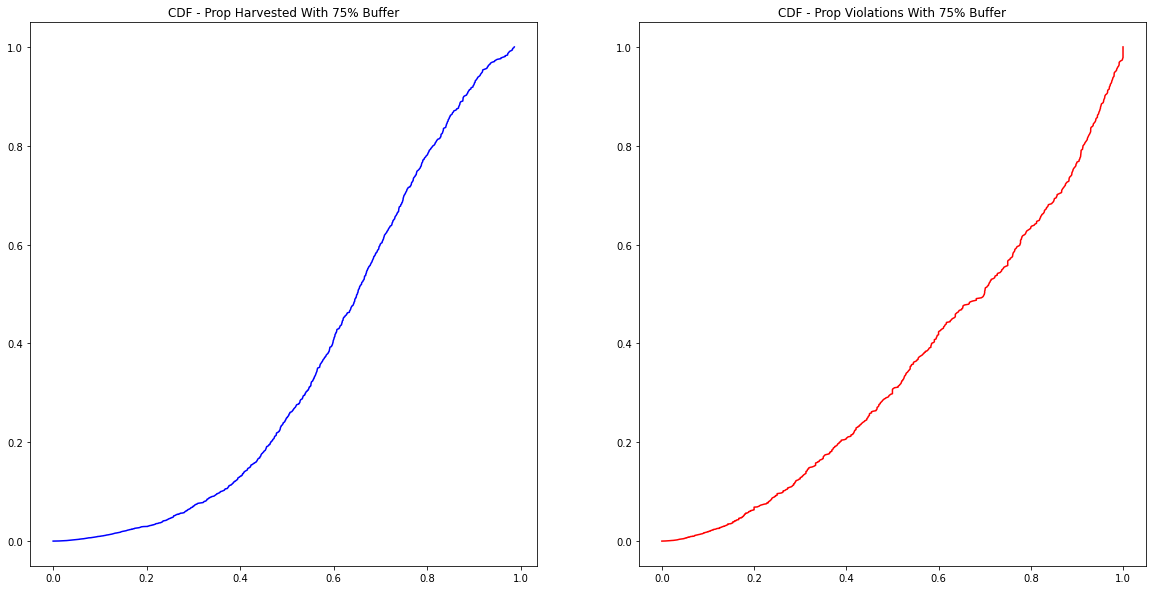

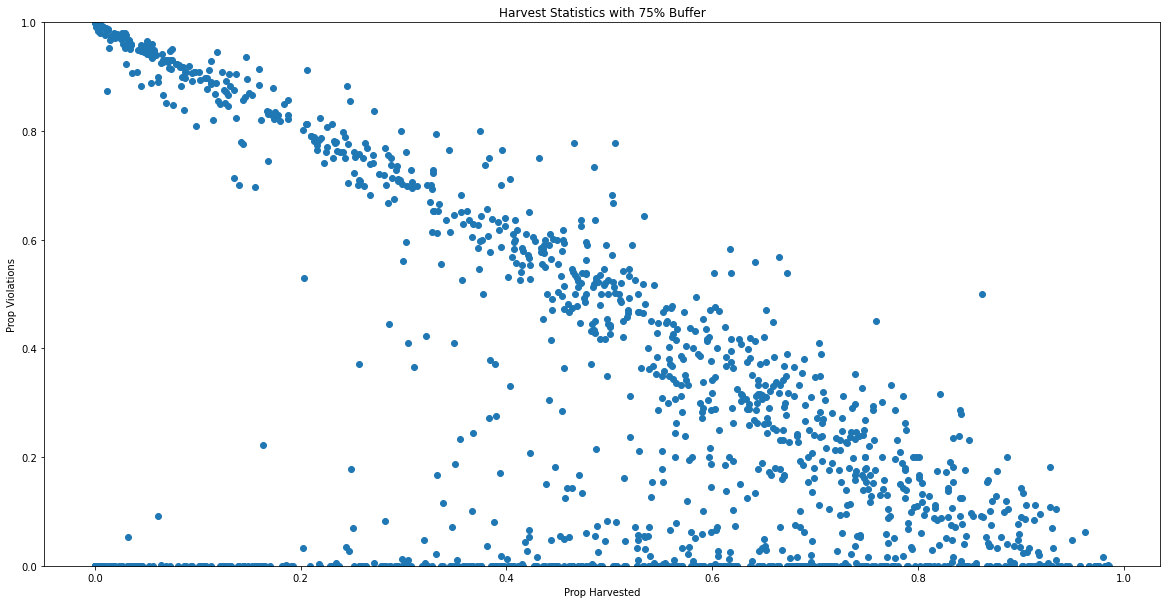

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.458201         0.291229
std          0.281310         0.322545
min          0.000000         0.000000
25%          0.225080         0.000000
50%          0.494785         0.166667
75%          0.680200         0.525954
max          0.985963         1.000000


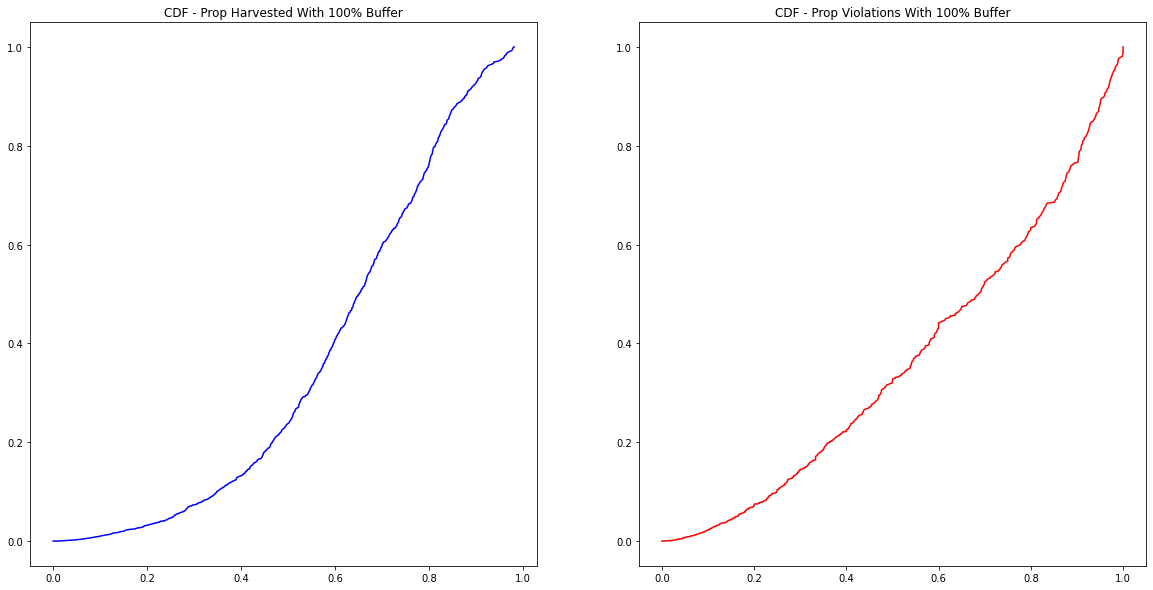

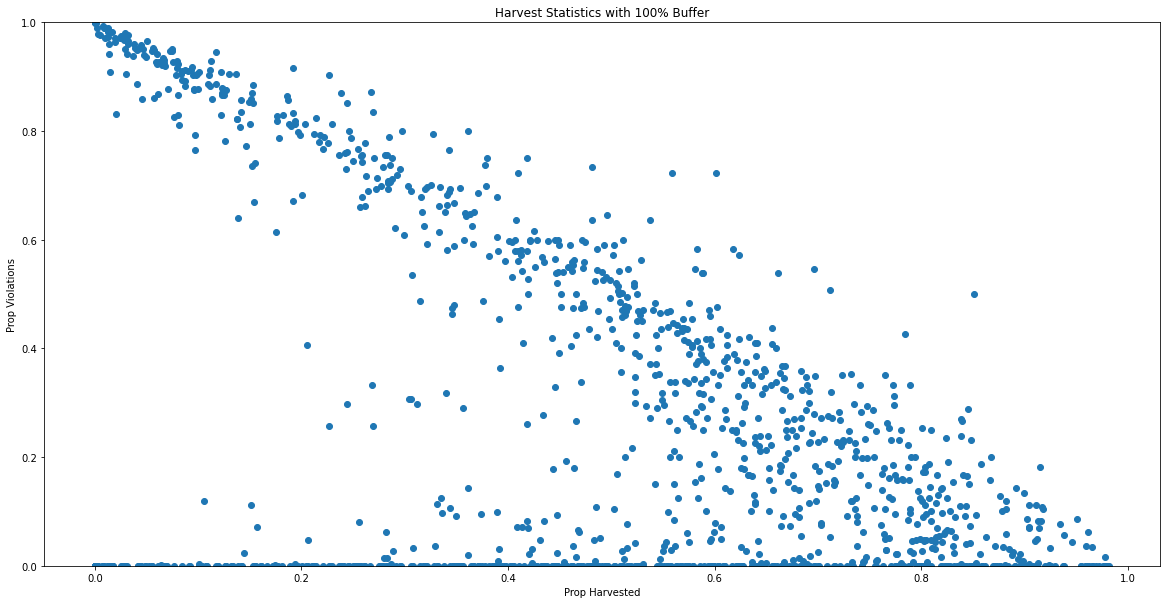

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.441429         0.256016
std          0.290478         0.313361
min          0.000000         0.000000
25%          0.170695         0.000000
50%          0.482248         0.100000
75%          0.675433         0.459979
max          0.981898         1.000000


In [20]:
model_results_dfs['ar'] = get_model_results(max_mem_3_dir, 5, "ar")

                 id  train_mase_reg  test_mase_reg  under_mase_reg  \
count  1.432000e+03     1432.000000    1432.000000     1432.000000   
mean   3.708082e+11        0.957973       1.800828        0.461962   
std    7.680769e+10        0.282703       4.971459        0.698512   
min    1.950000e+02        0.000000       0.000000        0.000000   
25%    3.807102e+11        0.849172       0.938302        0.246568   
50%    3.835432e+11        0.935081       1.100719        0.396304   
75%    3.961267e+11        1.051684       1.528486        0.526624   
max    4.004415e+11        6.762646     146.623424       21.852821   

       prop_under_preds_reg  max_under_pred_reg  over_mase_reg  \
count           1432.000000         1390.000000    1432.000000   
mean               0.341269         3013.336372       1.338866   
std                0.193264        29835.346002       4.969462   
min                0.000000            0.000040       0.000000   
25%                0.194995            

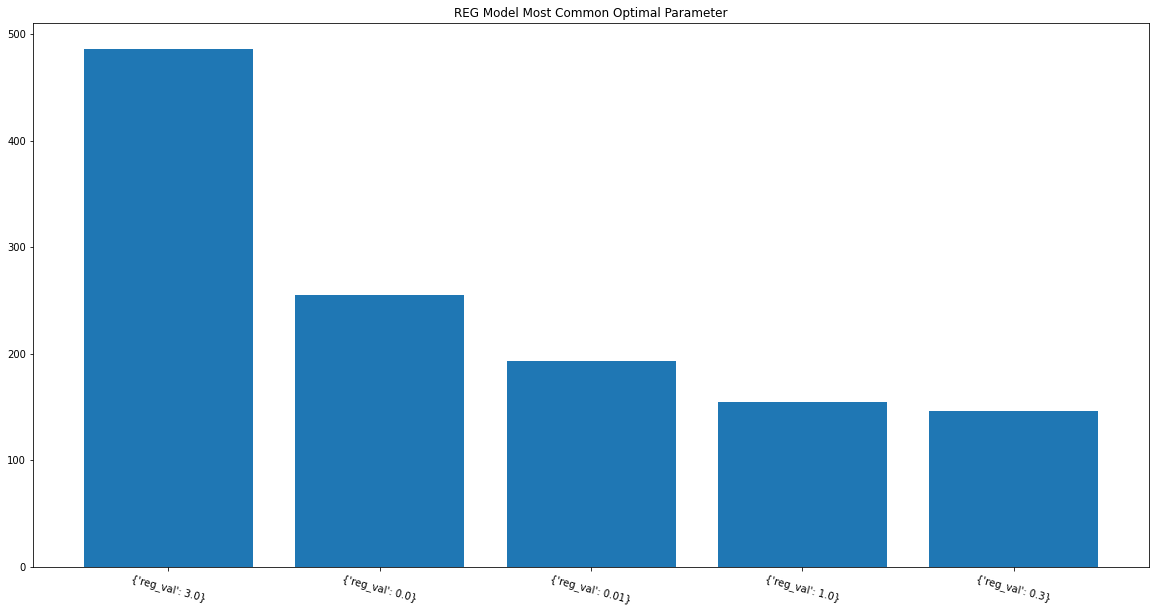

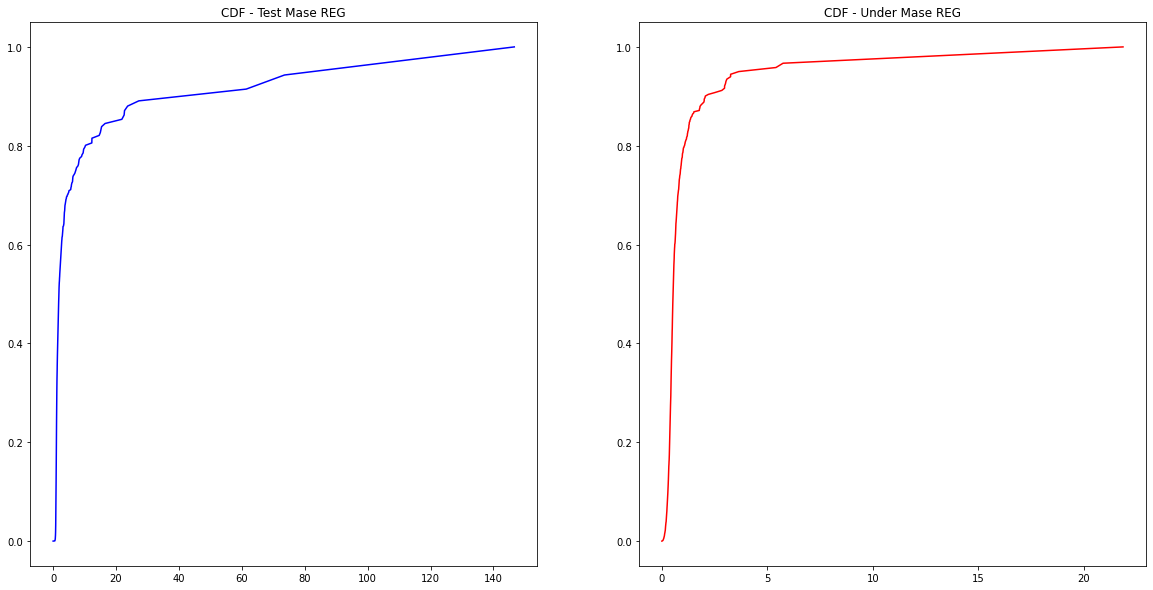

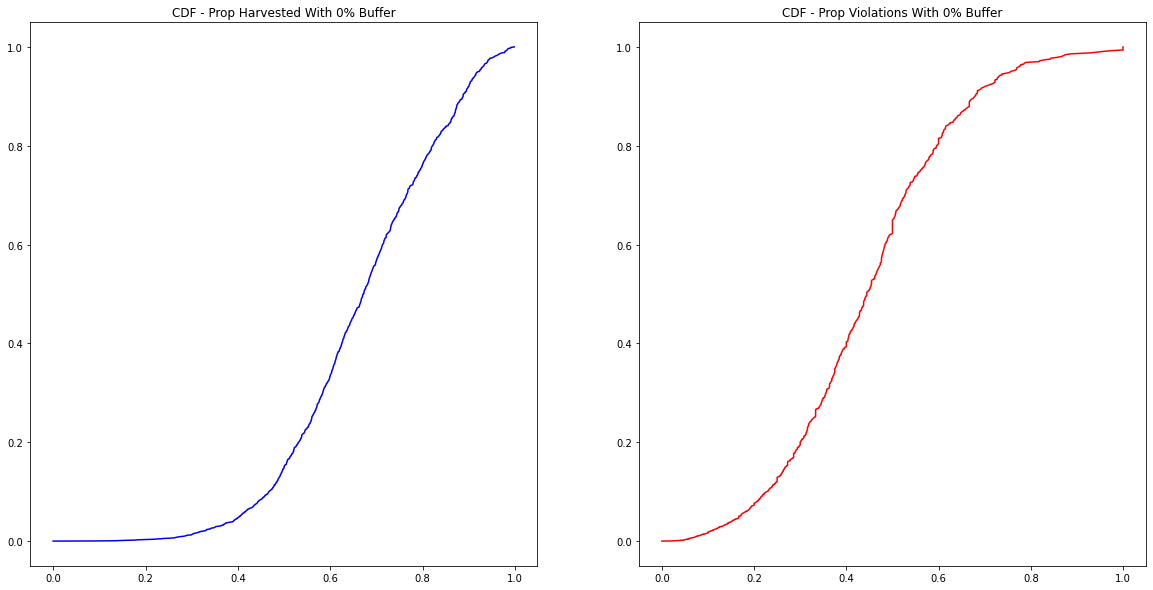

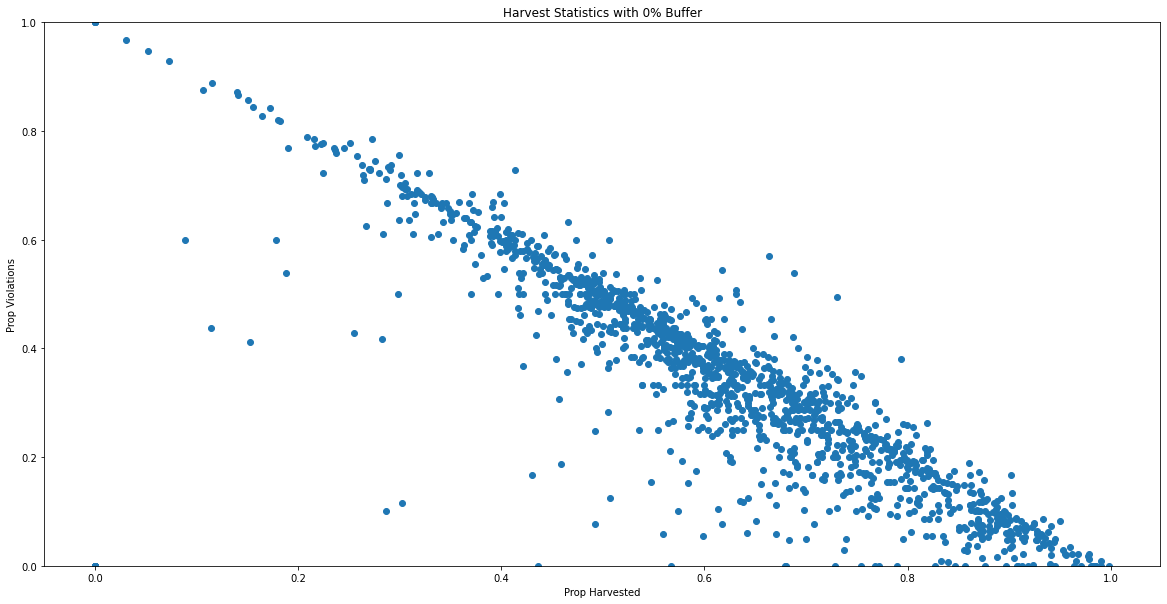

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.614778         0.341269
std          0.185270         0.193264
min          0.000000         0.000000
25%          0.501715         0.194995
50%          0.616937         0.340618
75%          0.743252         0.476190
max          0.998460         1.000000


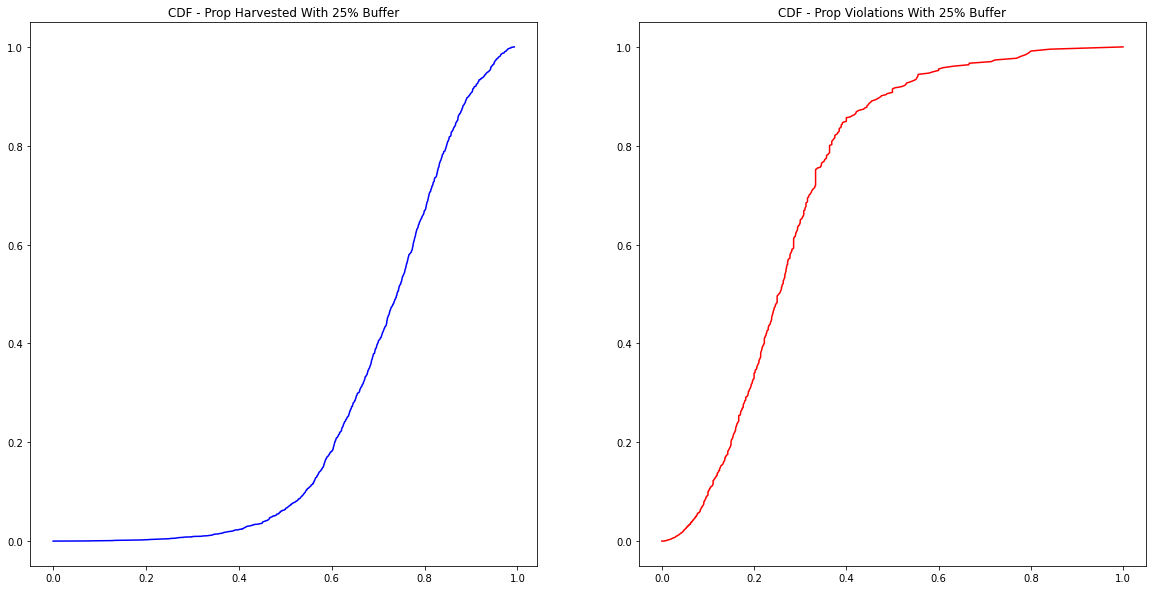

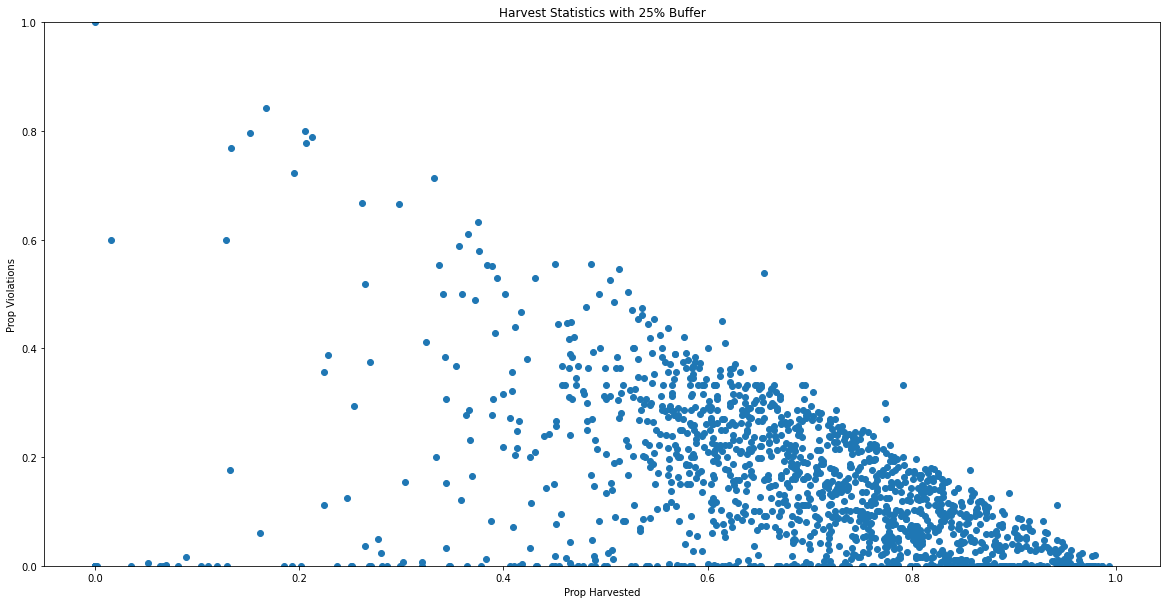

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.675306         0.152539
std          0.182422         0.137834
min          0.000000         0.000000
25%          0.585759         0.038547
50%          0.698856         0.126492
75%          0.803706         0.235788
max          0.993419         1.000000


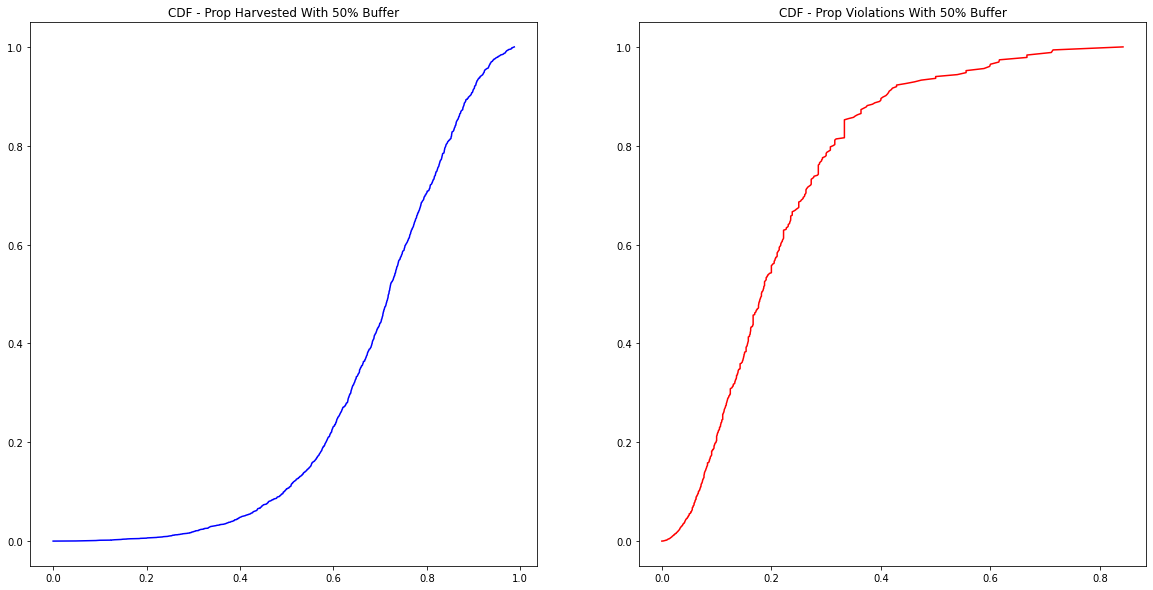

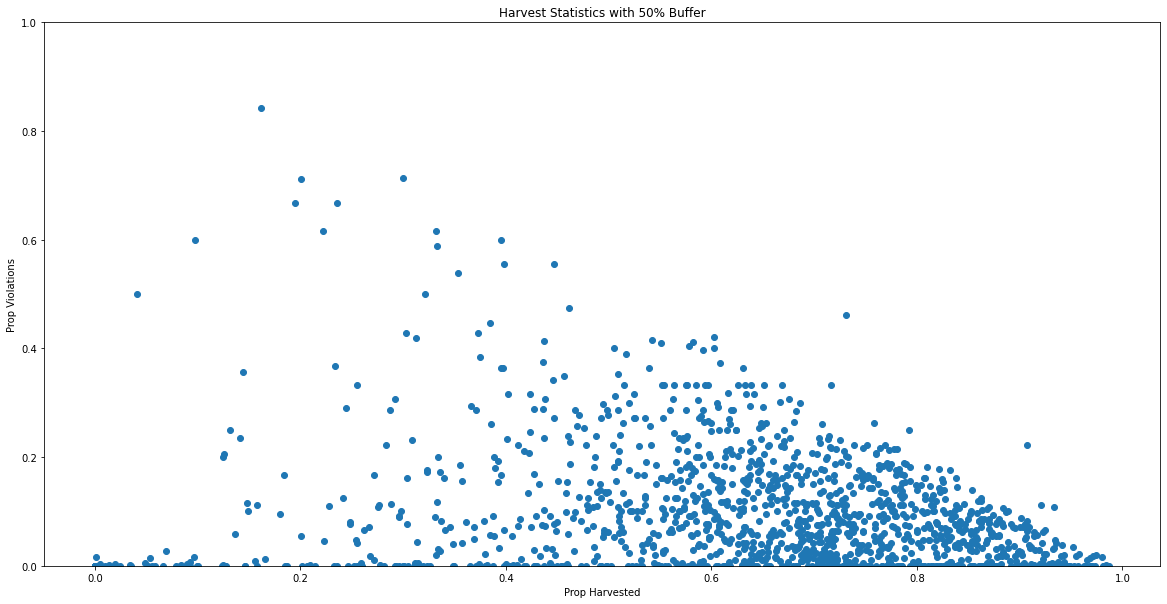

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.623205         0.096301
std          0.222391         0.108530
min          0.000000         0.000000
25%          0.520677         0.008811
50%          0.667430         0.066667
75%          0.778117         0.146765
max          0.987281         0.842105


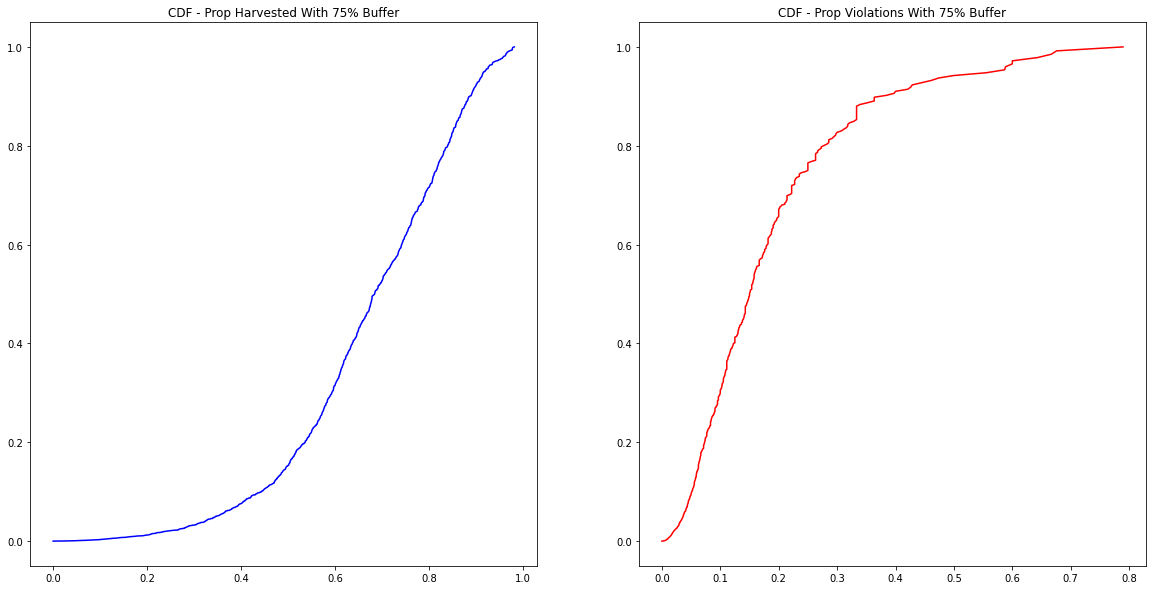

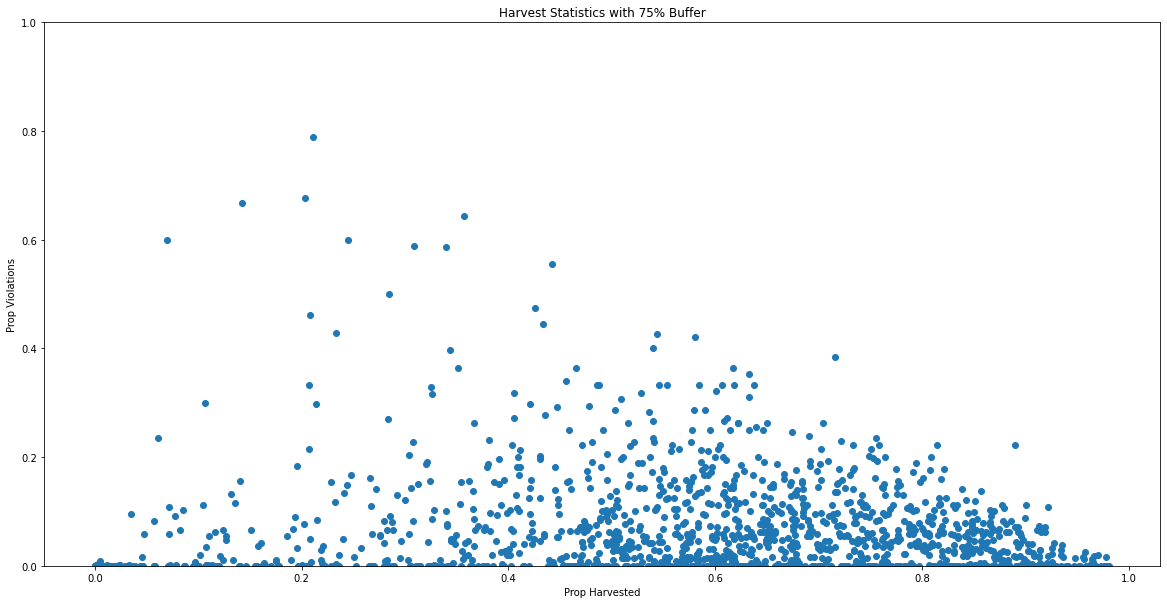

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.562356         0.068845
std          0.250594         0.091946
min          0.000000         0.000000
25%          0.422121         0.000000
50%          0.604800         0.040993
75%          0.752707         0.100000
max          0.981142         0.789474


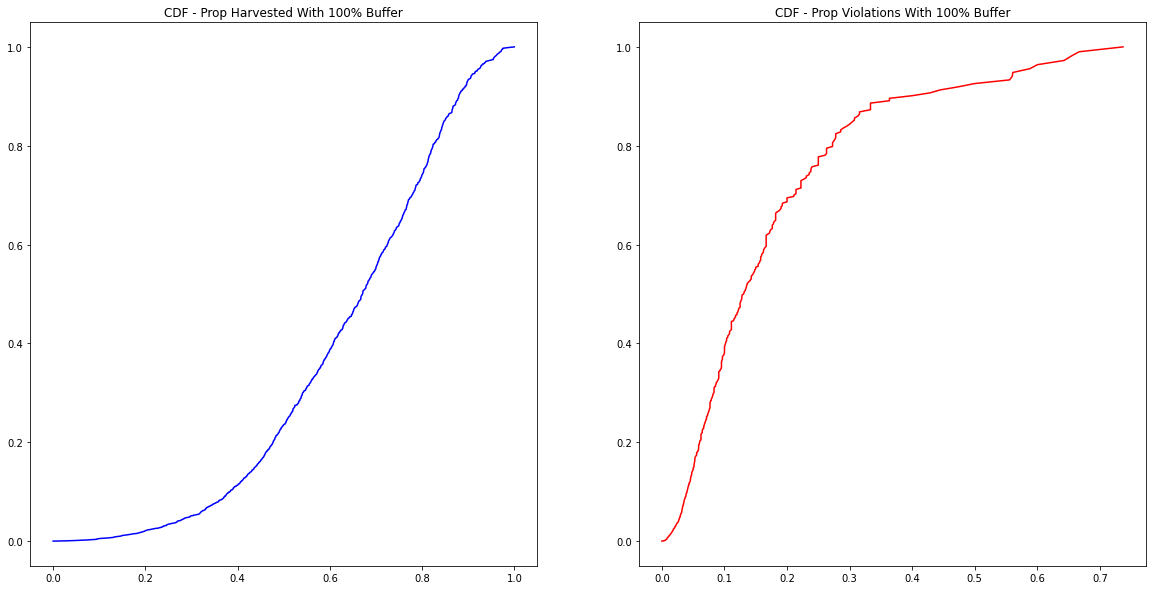

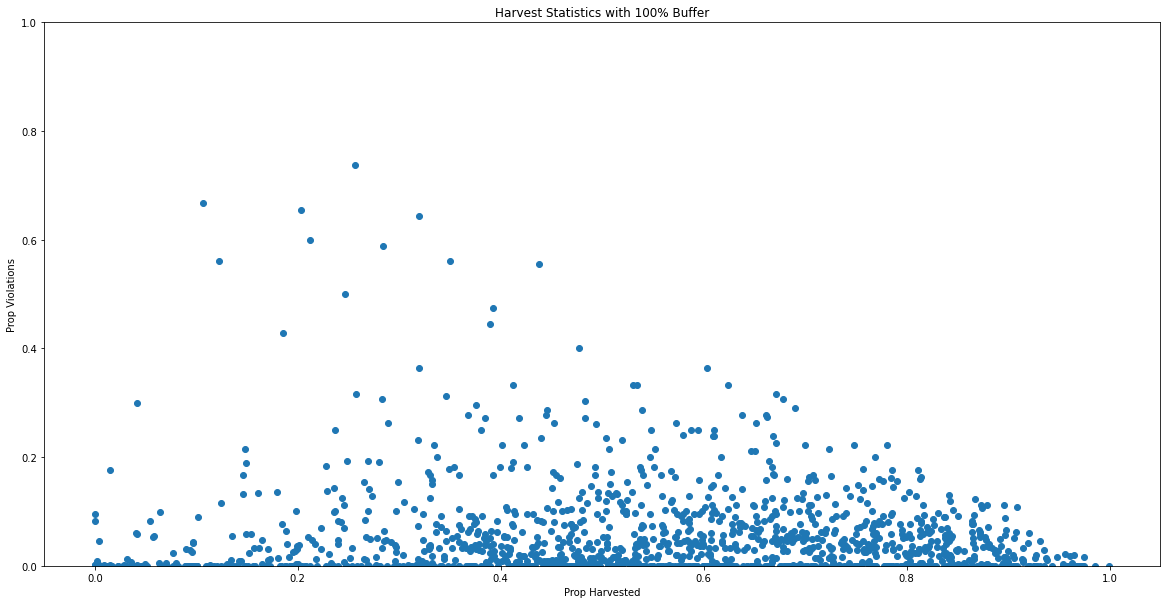

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.506230         0.052433
std          0.266800         0.082532
min          0.000000         0.000000
25%          0.330543         0.000000
50%          0.533949         0.023533
75%          0.719776         0.071429
max          0.999844         0.736842


In [21]:
model_results_dfs['reg'] = get_model_results(max_mem_3_dir, 5, "reg")

                 id  train_mase_svm  test_mase_svm  under_mase_svm  \
count  1.432000e+03     1432.000000    1432.000000     1432.000000   
mean   3.708082e+11        0.898652       1.271242        0.458918   
std    7.680769e+10        0.206677       3.087355        0.488503   
min    1.950000e+02        0.000000       0.000000        0.000000   
25%    3.807102e+11        0.810734       0.878966        0.308886   
50%    3.835432e+11        0.882499       0.974606        0.439178   
75%    3.961267e+11        0.968128       1.149484        0.541516   
max    4.004415e+11        3.247953     105.706809       14.090060   

       prop_under_preds_svm  max_under_pred_svm  over_mase_svm  \
count           1432.000000         1409.000000    1432.000000   
mean               0.403950          432.555017       0.812324   
std                0.161959         4822.500675       3.090600   
min                0.000000            0.000592       0.000000   
25%                0.315789            

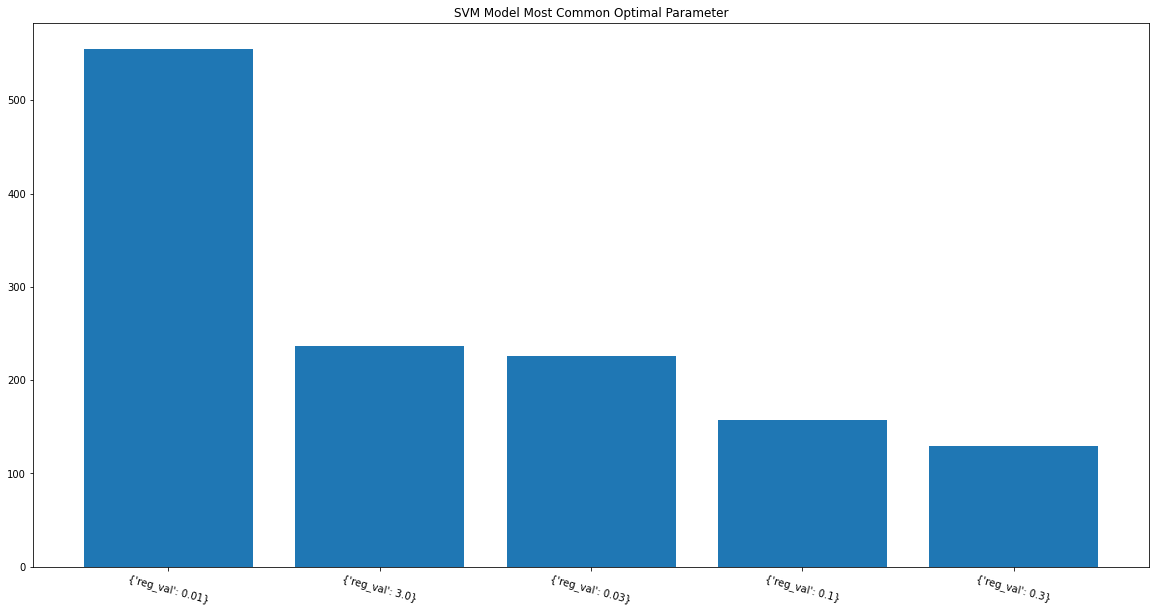

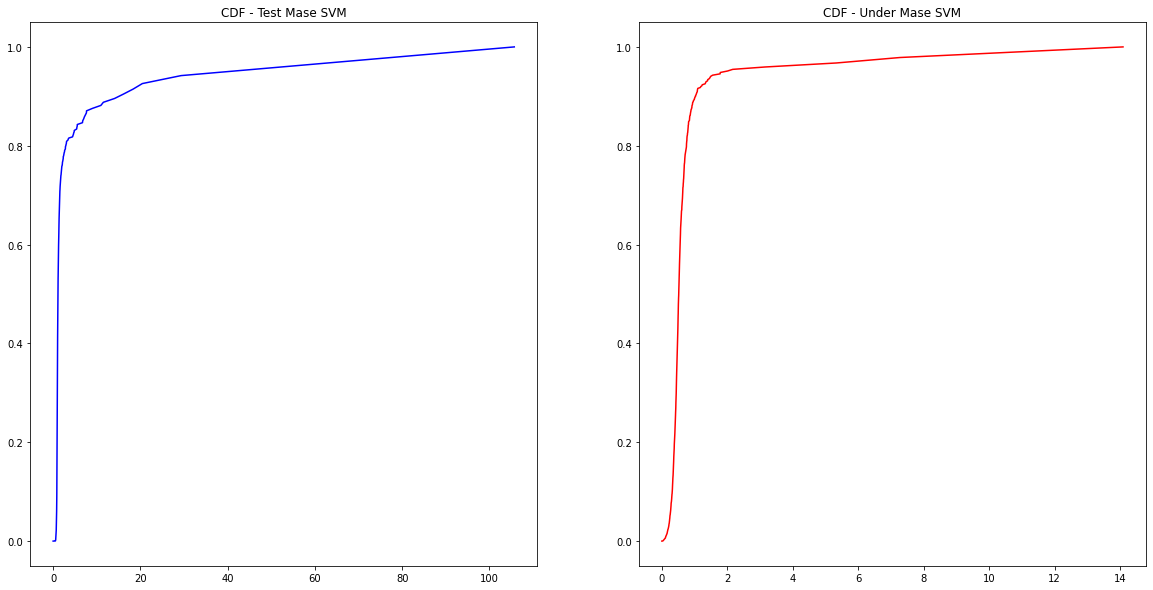

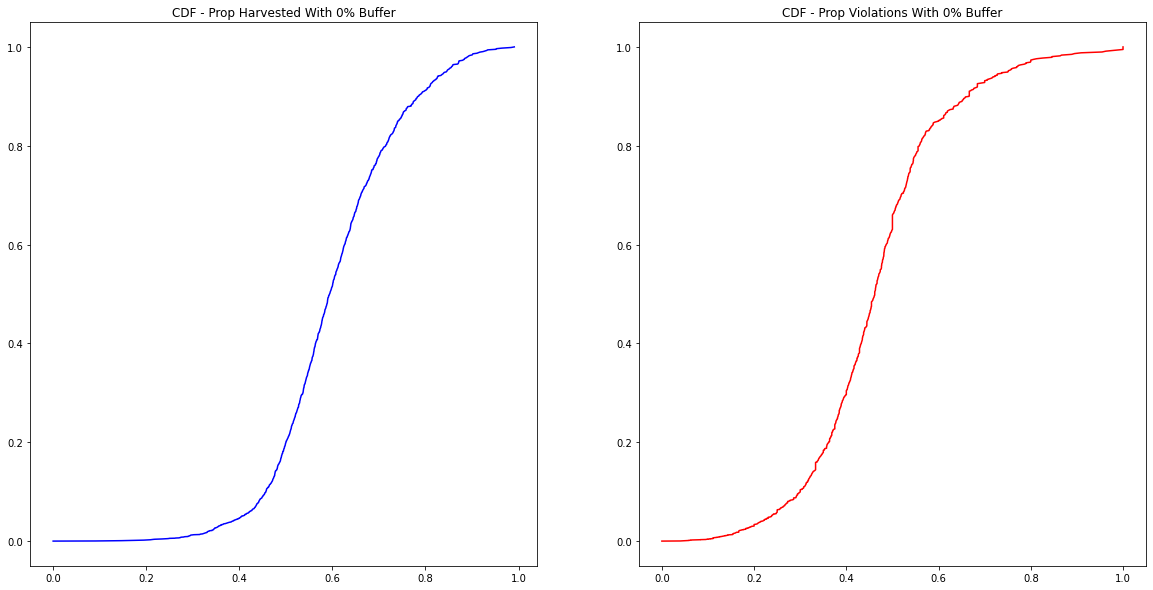

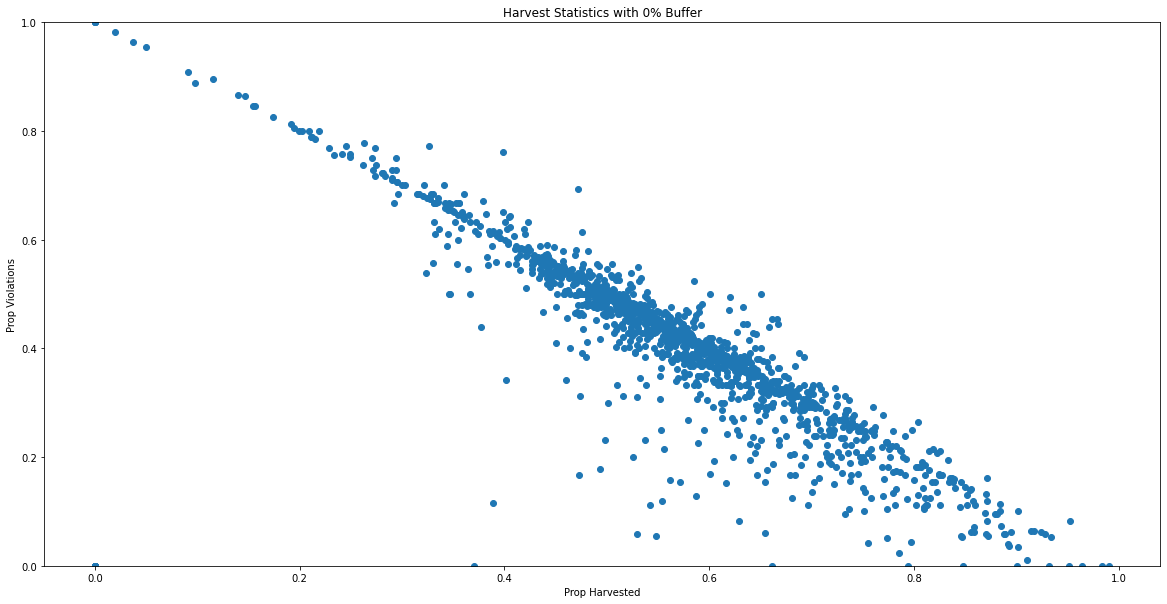

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.565501         0.403950
std          0.150139         0.161959
min          0.000000         0.000000
25%          0.490183         0.315789
50%          0.564919         0.416518
75%          0.651105         0.500000
max          0.990946         1.000000


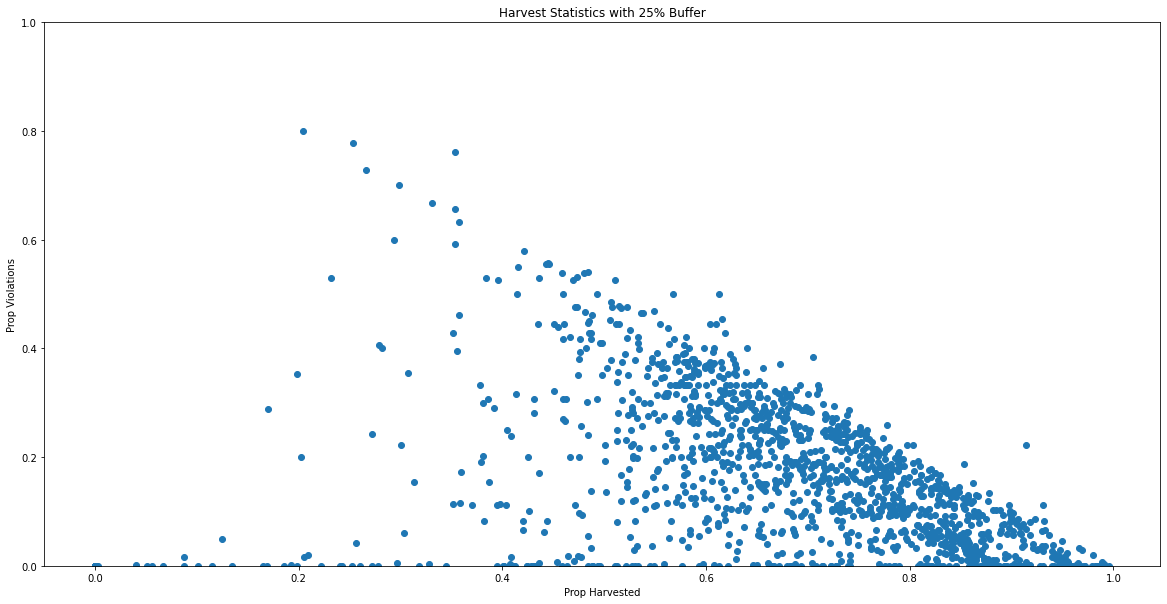

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.679315         0.166516
std          0.177656         0.137538
min          0.000000         0.000000
25%          0.587019         0.050111
50%          0.696105         0.146767
75%          0.810361         0.254231
max          0.996107         0.800000


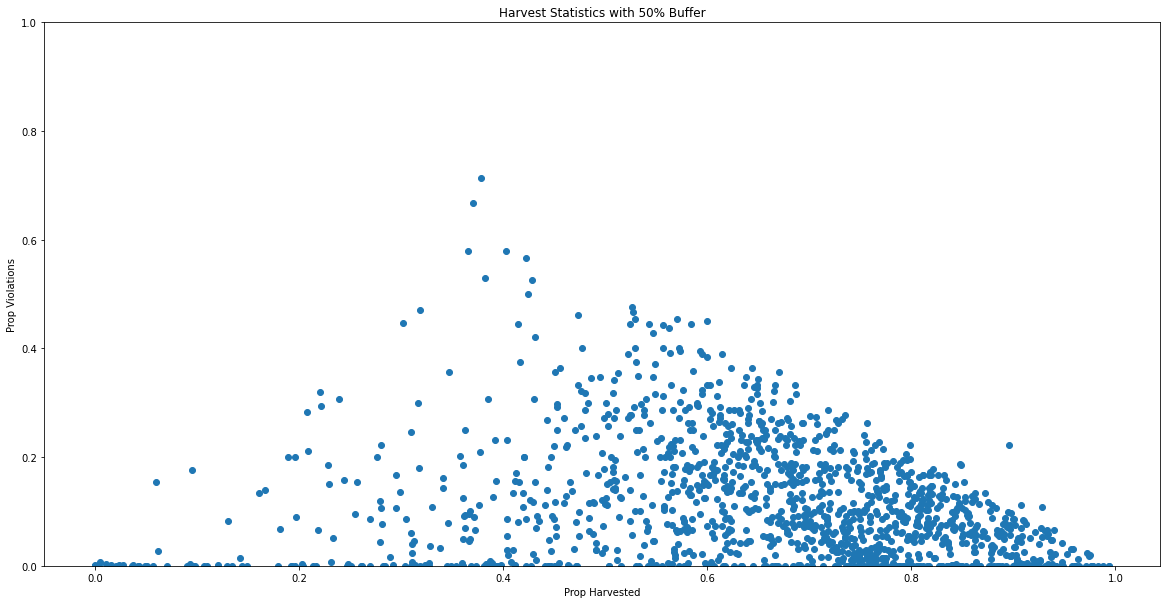

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.633472         0.111174
std          0.221187         0.109161
min          0.000000         0.000000
25%          0.536900         0.016317
50%          0.680272         0.085655
75%          0.788217         0.172414
max          0.994007         0.714286


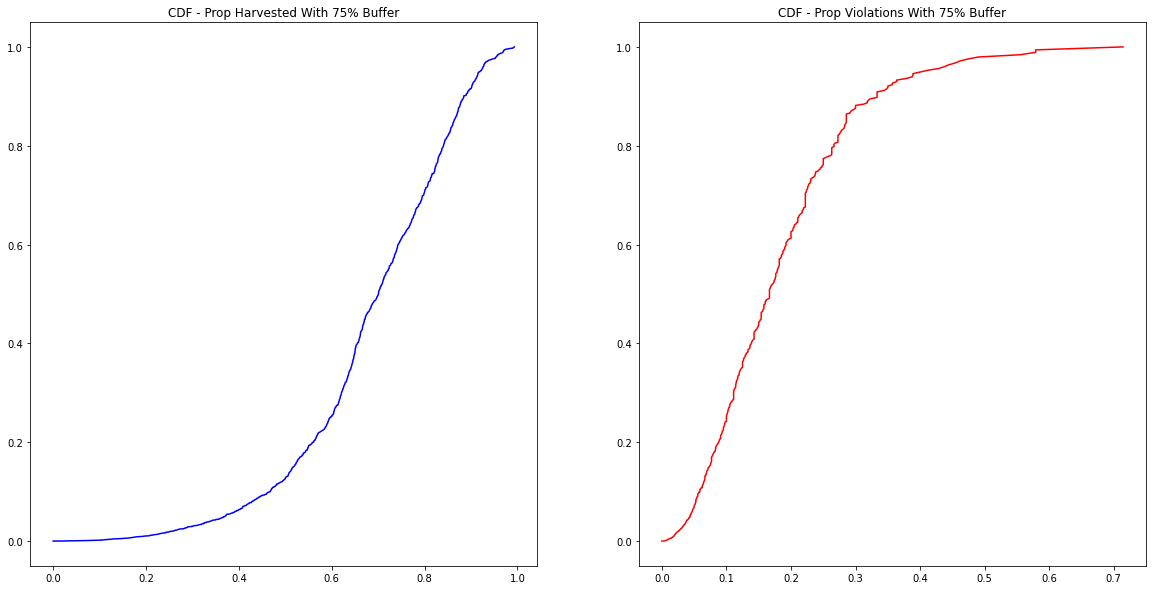

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.580687         0.082893
std          0.248834         0.092112
min          0.000000         0.000000
25%          0.459675         0.004520
50%          0.636221         0.055556
75%          0.766128         0.125000
max          0.993366         0.714286


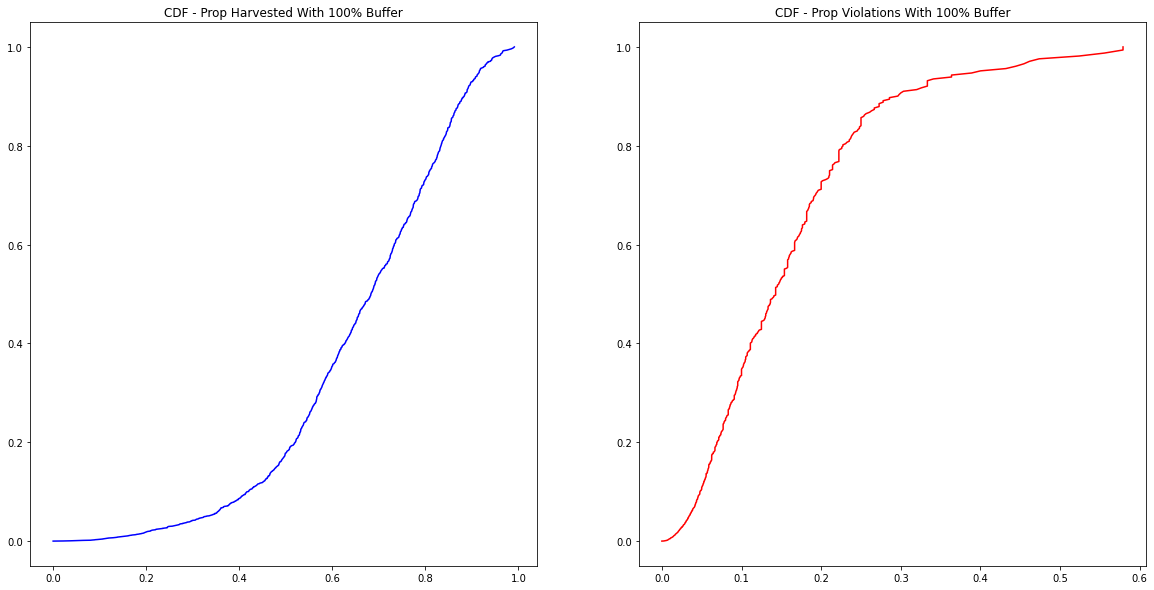

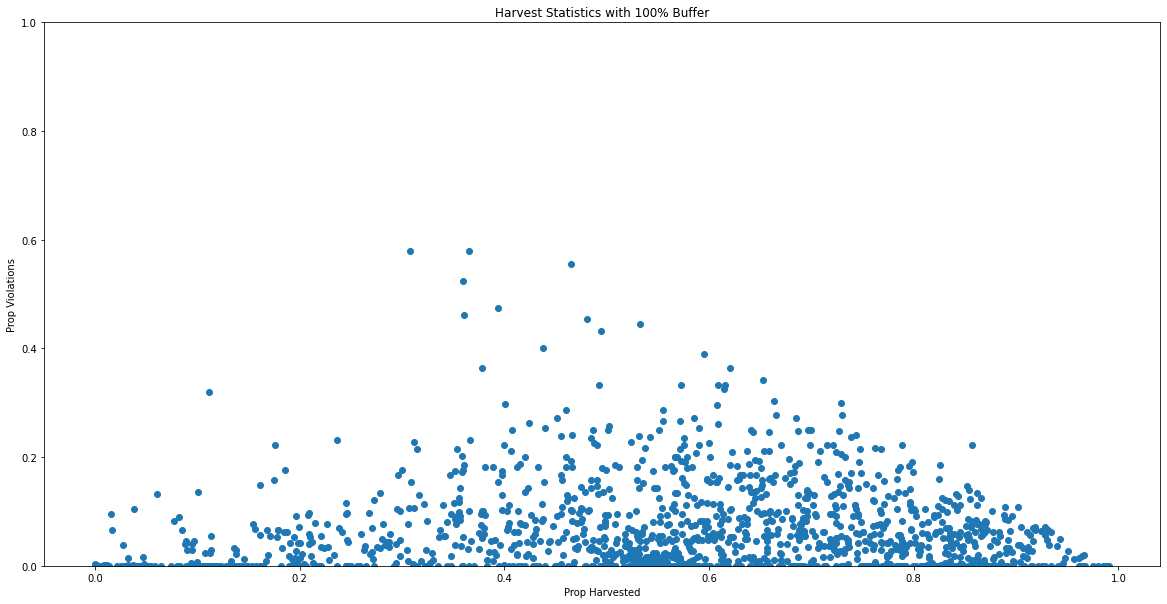

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.532119         0.064864
std          0.264456         0.079582
min          0.000000         0.000000
25%          0.373982         0.000000
50%          0.572846         0.041368
75%          0.736334         0.095365
max          0.991087         0.578947


In [22]:
model_results_dfs['svm'] = get_model_results(max_mem_3_dir, 5, "svm")

                 id  train_mase_xgb  test_mase_xgb  under_mase_xgb  \
count  1.432000e+03    1.432000e+03   1.432000e+03     1432.000000   
mean   3.708082e+11    1.516927e+00   2.767735e+00        0.375542   
std    7.680769e+10    5.462301e+00   8.910280e+00        0.535377   
min    1.950000e+02    3.945151e-31   3.945151e-31        0.000000   
25%    3.807102e+11    6.512255e-01   1.047194e+00        0.059519   
50%    3.835432e+11    8.714821e-01   1.420358e+00        0.270571   
75%    3.961267e+11    1.325265e+00   2.273137e+00        0.478694   
max    4.004415e+11    1.929589e+02   2.276861e+02        6.364017   

       prop_under_preds_xgb  max_under_pred_xgb  over_mase_xgb  \
count           1432.000000         1254.000000    1432.000000   
mean               0.248213         1541.301436       2.392193   
std                0.218816         9978.698589       8.950043   
min                0.000000            0.001016       0.000000   
25%                0.058580            

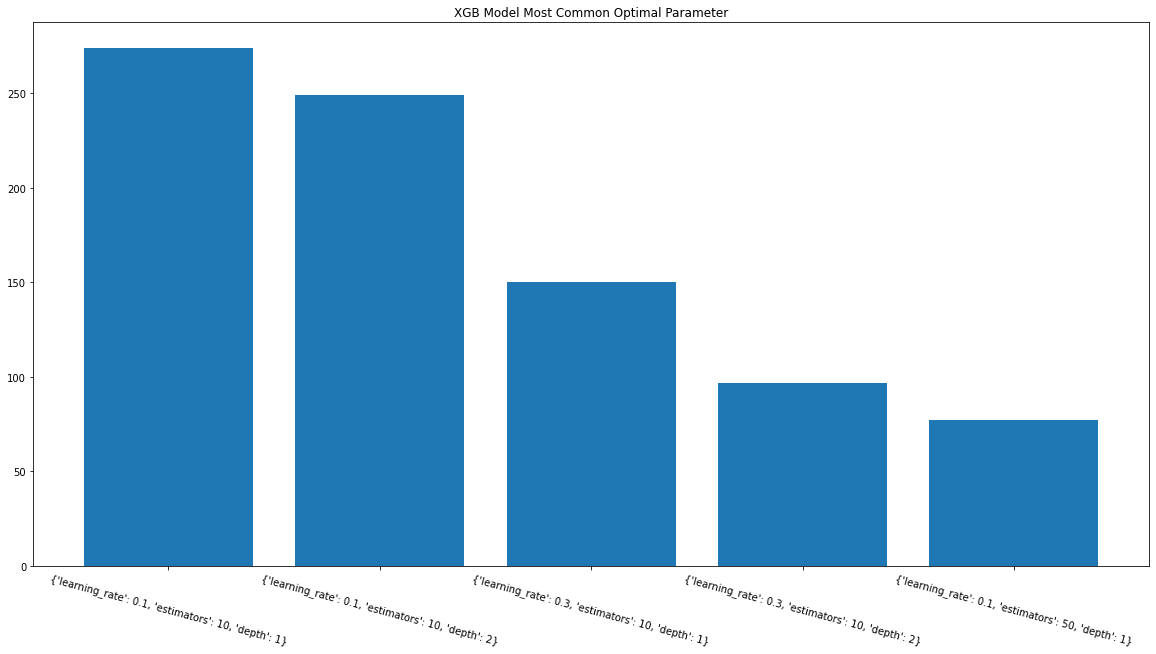

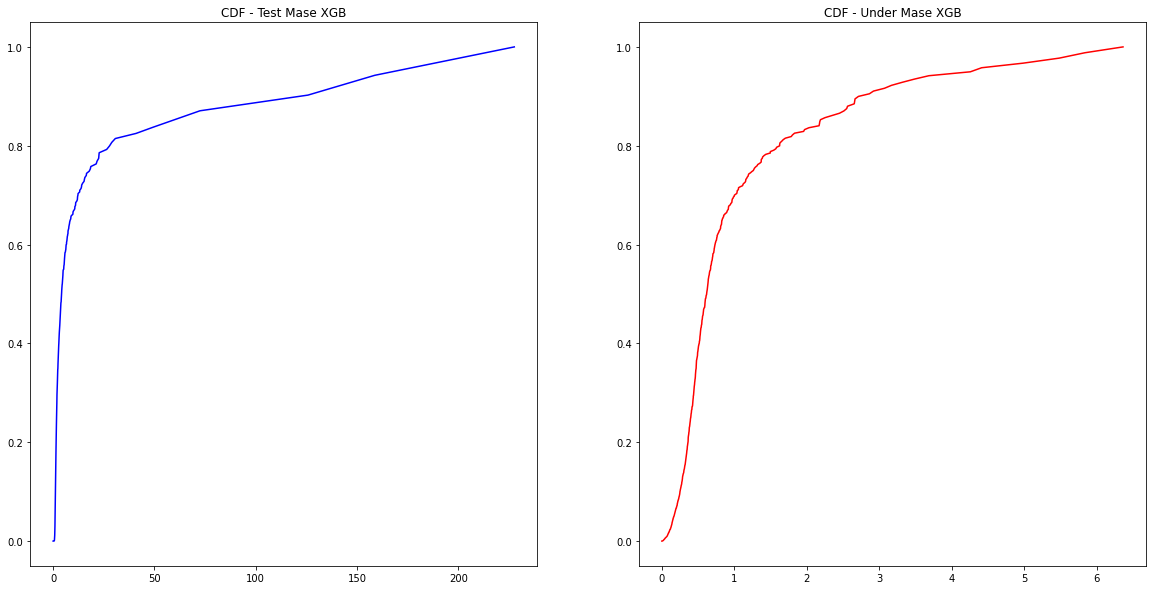

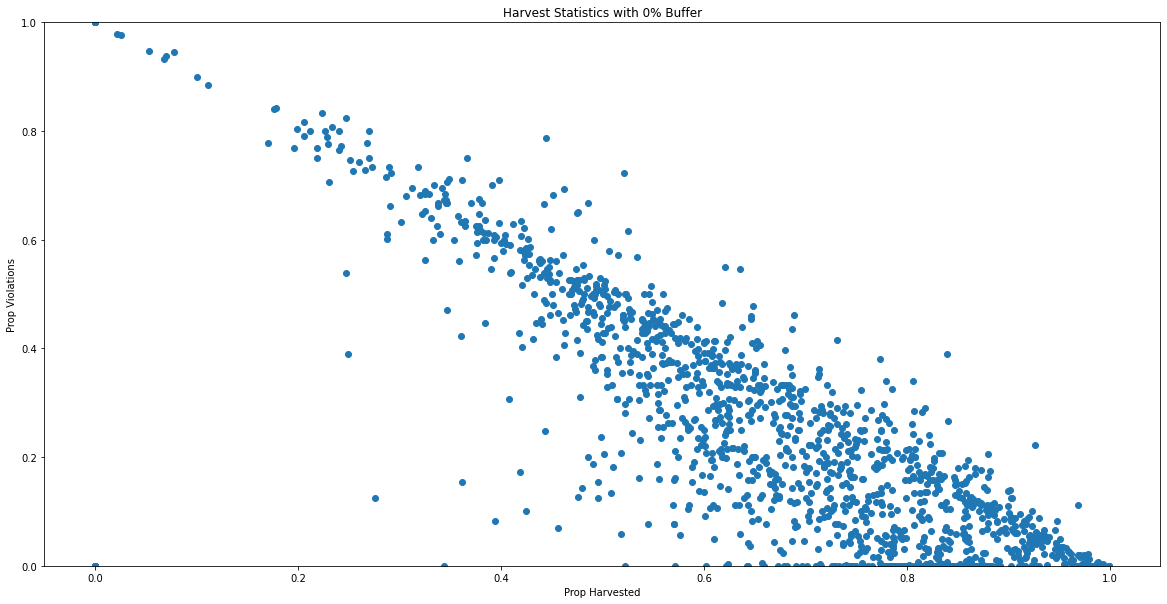

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.664599         0.248213
std          0.196513         0.218816
min          0.000000         0.000000
25%          0.544309         0.058580
50%          0.686549         0.200000
75%          0.818292         0.389610
max          0.999474         1.000000


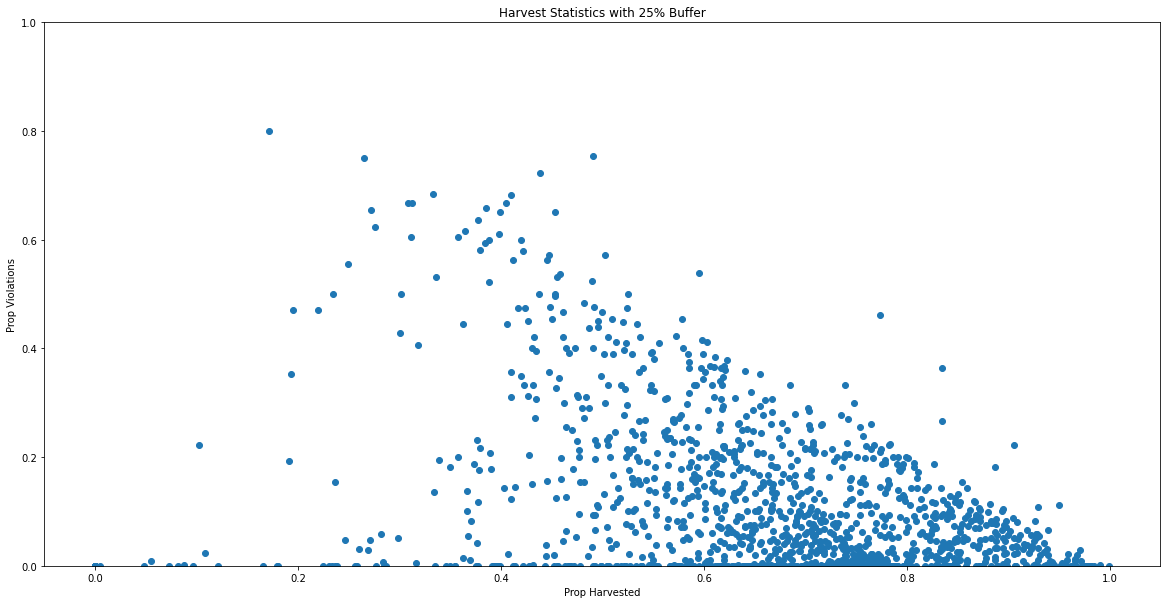

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.664175         0.107515
std          0.178827         0.141456
min          0.000000         0.000000
25%          0.571769         0.000000
50%          0.688514         0.051966
75%          0.777629         0.161806
max          0.999300         0.800000


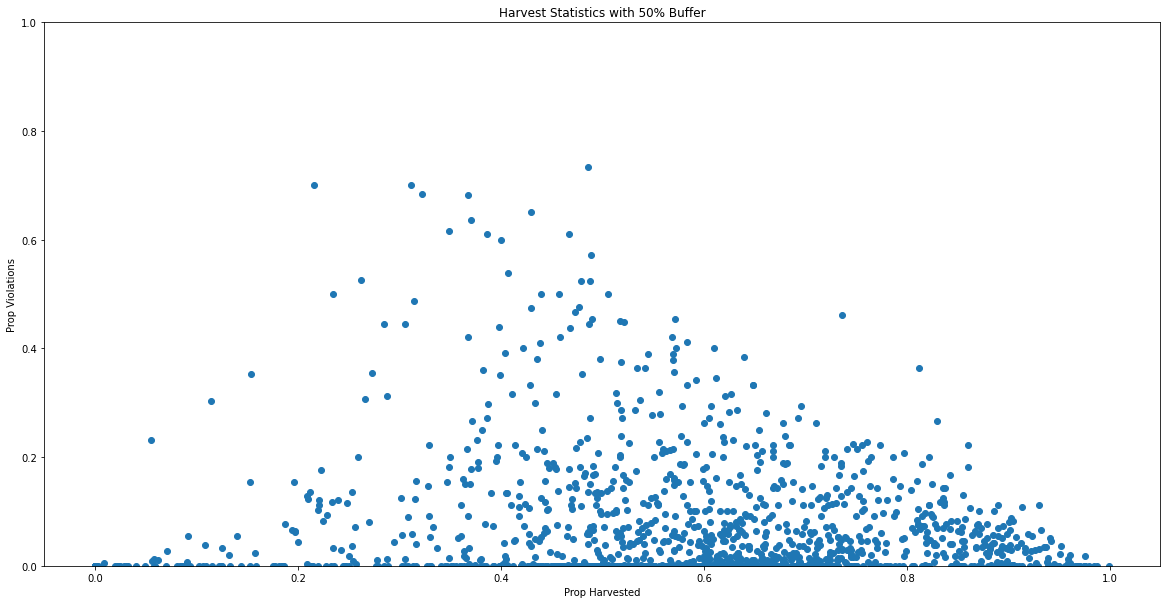

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.578486         0.070472
std          0.216544         0.113162
min          0.000000         0.000000
25%          0.470191         0.000000
50%          0.605894         0.018307
75%          0.715319         0.099122
max          0.999127         0.733333


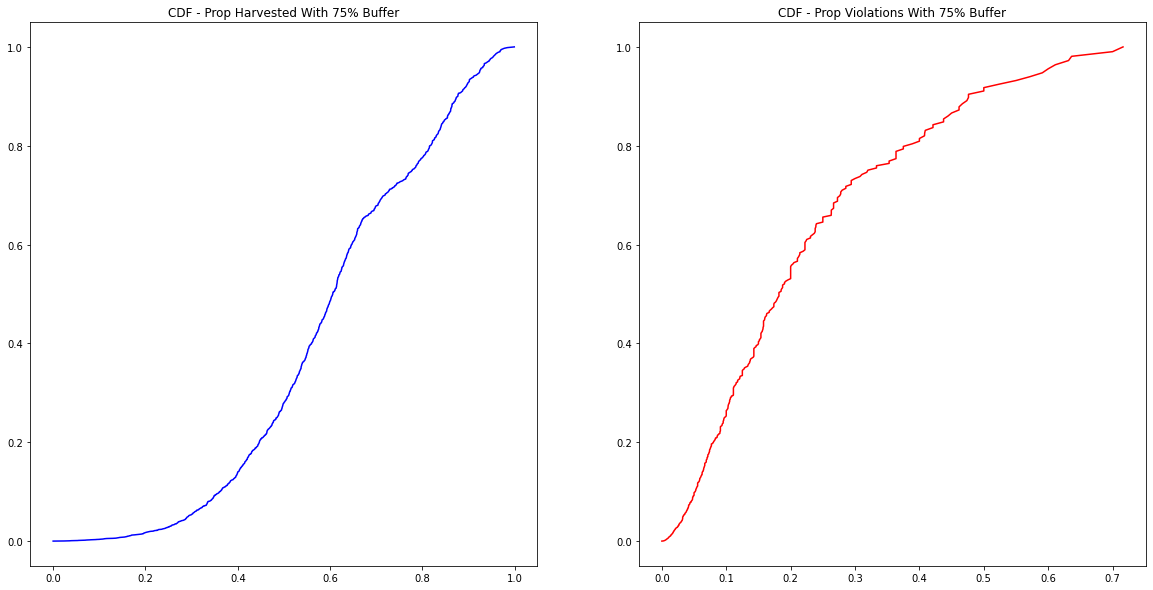

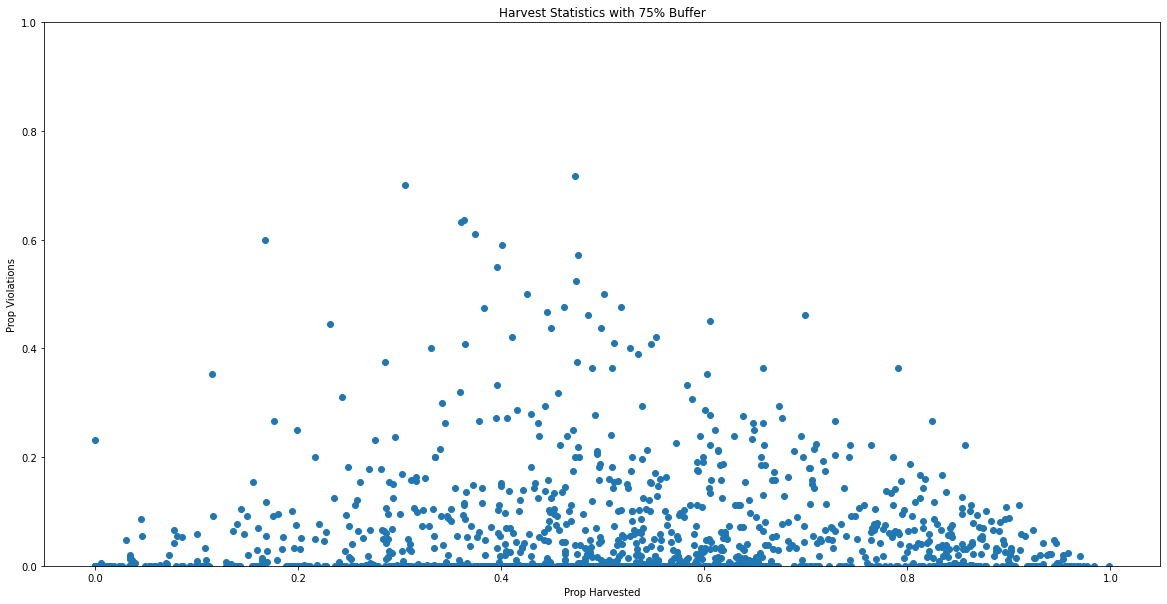

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.495630         0.051934
std          0.241606         0.096295
min          0.000000         0.000000
25%          0.346309         0.000000
50%          0.514683         0.004296
75%          0.646034         0.064599
max          0.998953         0.716190


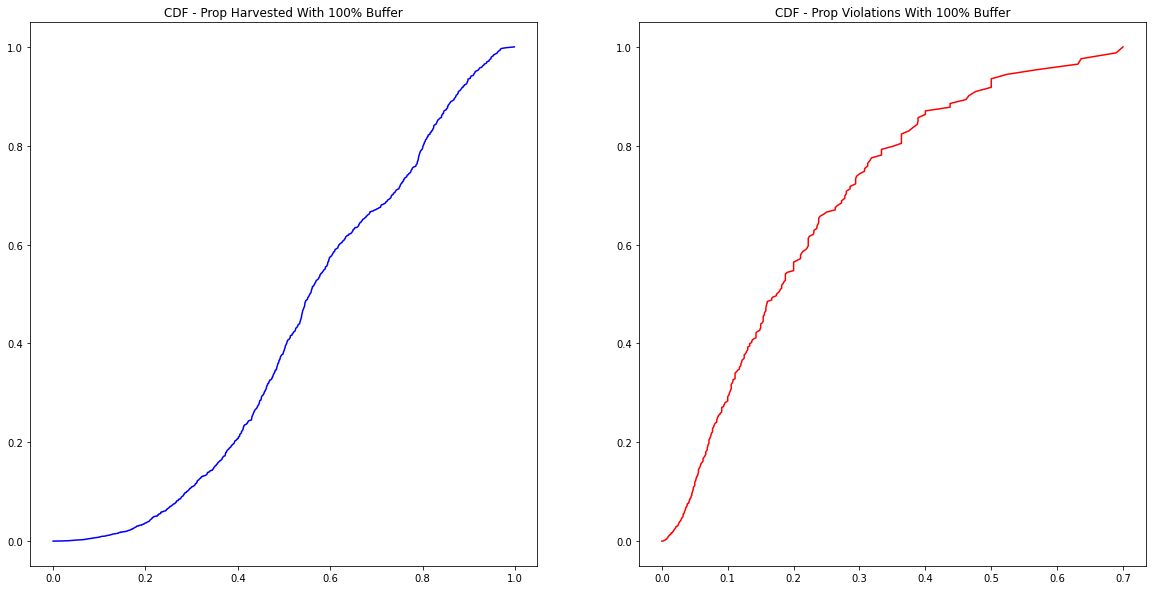

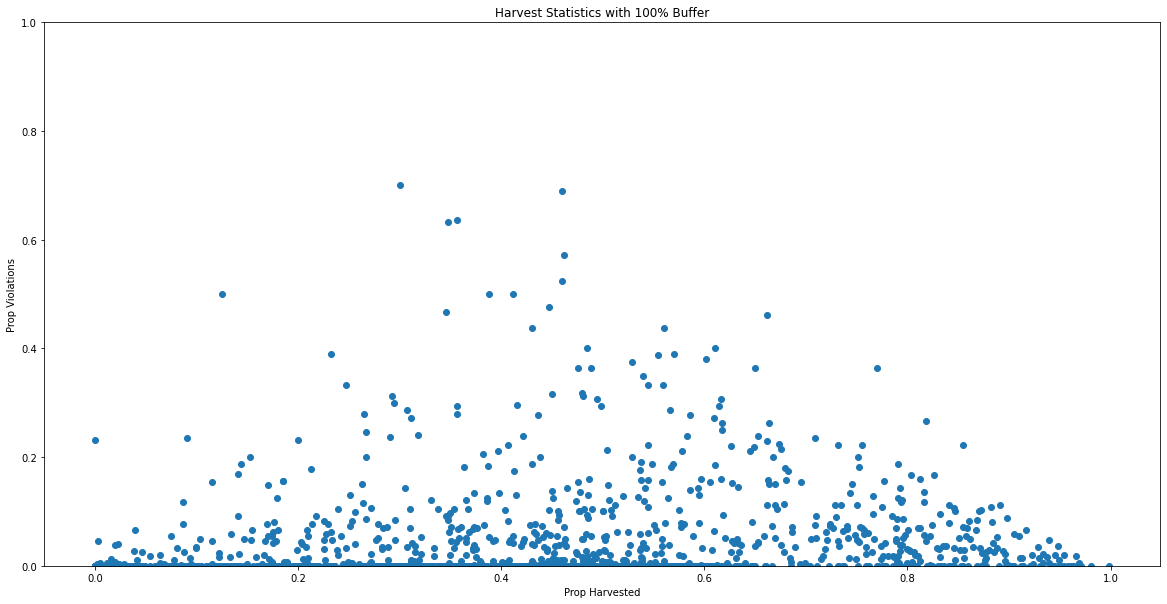

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.422289         0.040605
std          0.257244         0.084984
min          0.000000         0.000000
25%          0.228307         0.000000
50%          0.430380         0.000000
75%          0.586446         0.045554
max          0.998780         0.700000


In [23]:
model_results_dfs['xgb'] = get_model_results(max_mem_3_dir, 5, "xgb")

                 id  train_mase_arima  test_mase_arima  under_mase_arima  \
count  1.423000e+03       1423.000000      1423.000000       1423.000000   
mean   3.709626e+11          1.044755         2.285346          0.986608   
std    7.640494e+10          1.050972         3.578978          2.347745   
min    1.950000e+02          0.000000         0.000000          0.000000   
25%    3.807336e+11          0.911547         0.988019          0.110659   
50%    3.835385e+11          0.993900         1.334776          0.403845   
75%    3.961401e+11          1.040342         2.077257          1.017384   
max    4.004415e+11         38.750000        55.250052         45.048382   

       prop_under_preds_arima  max_under_pred_arima  over_mase_arima  \
count             1423.000000           1374.000000      1423.000000   
mean                 0.442898            465.506755         1.298738   
std                  0.296094           5463.501683         3.016710   
min                  0.0000

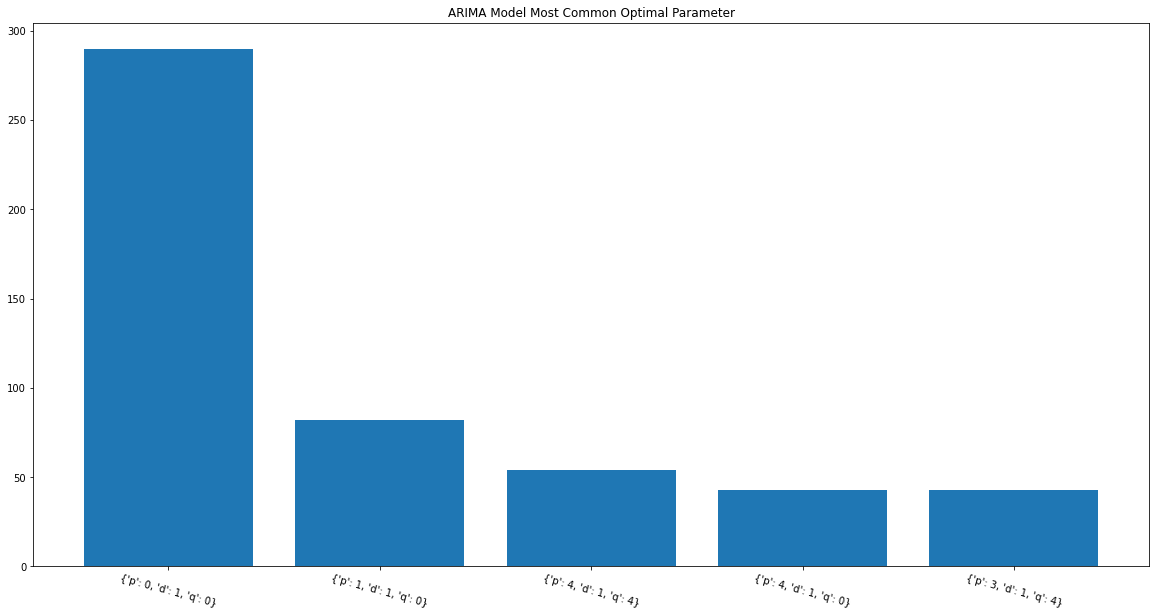

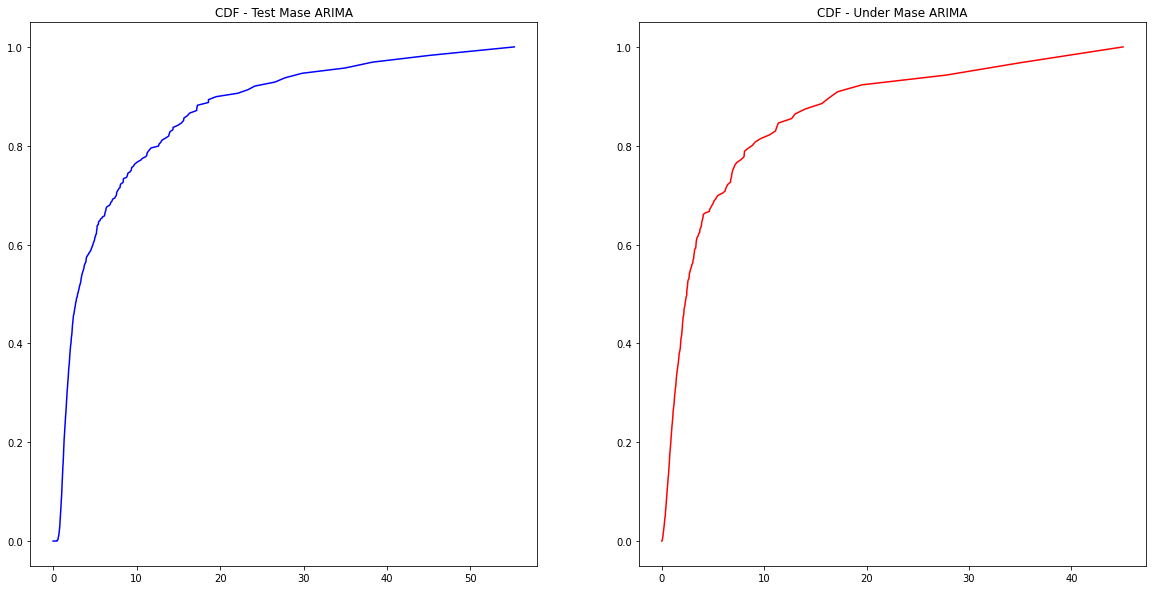

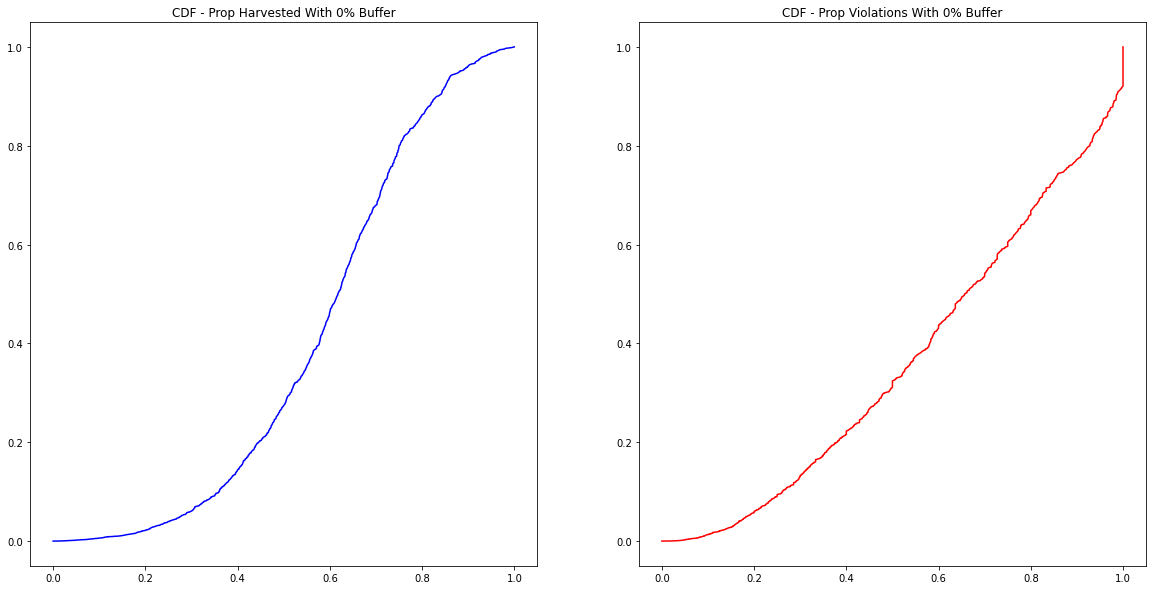

       prop_harvested  prop_violations
count     1423.000000      1423.000000
mean         0.480215         0.442898
std          0.241887         0.296094
min          0.000000         0.000000
25%          0.320198         0.191545
50%          0.511006         0.400000
75%          0.657244         0.674206
max          0.999812         1.000000


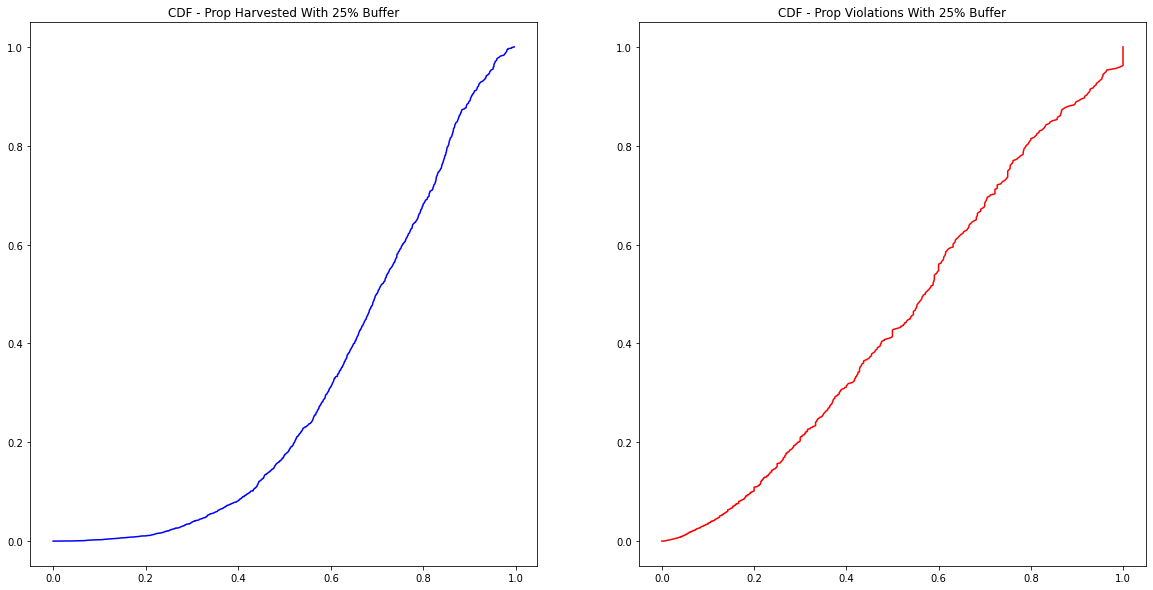

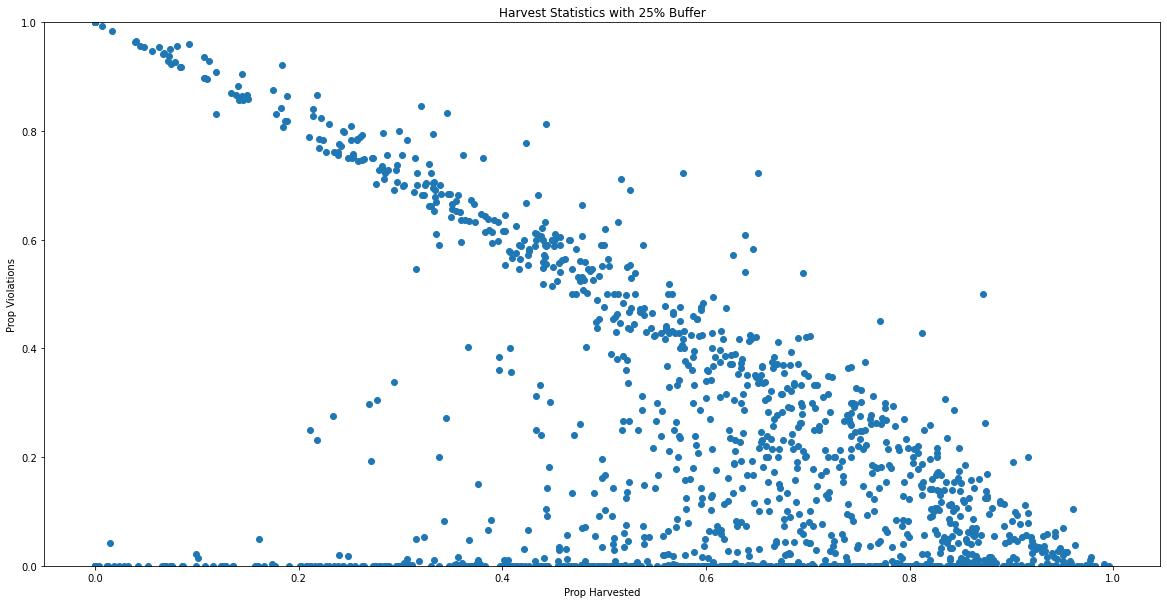

       prop_harvested  prop_violations
count     1423.000000      1423.000000
mean         0.576172         0.224748
std          0.246131         0.271265
min          0.000000         0.000000
25%          0.429305         0.000000
50%          0.606985         0.102740
75%          0.770702         0.375443
max          0.996114         1.000000


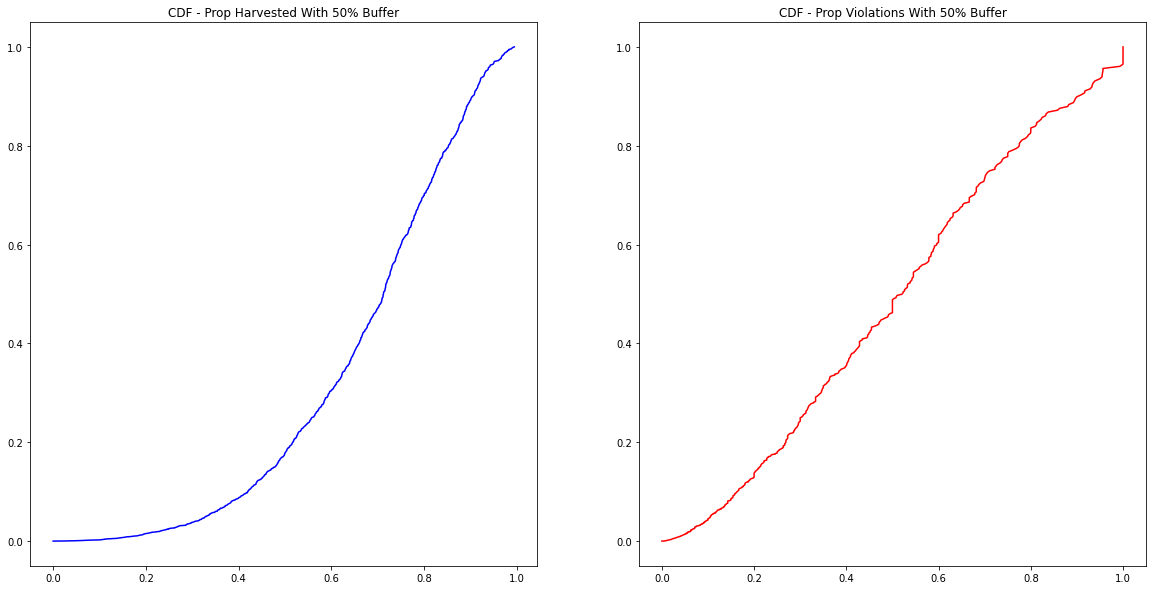

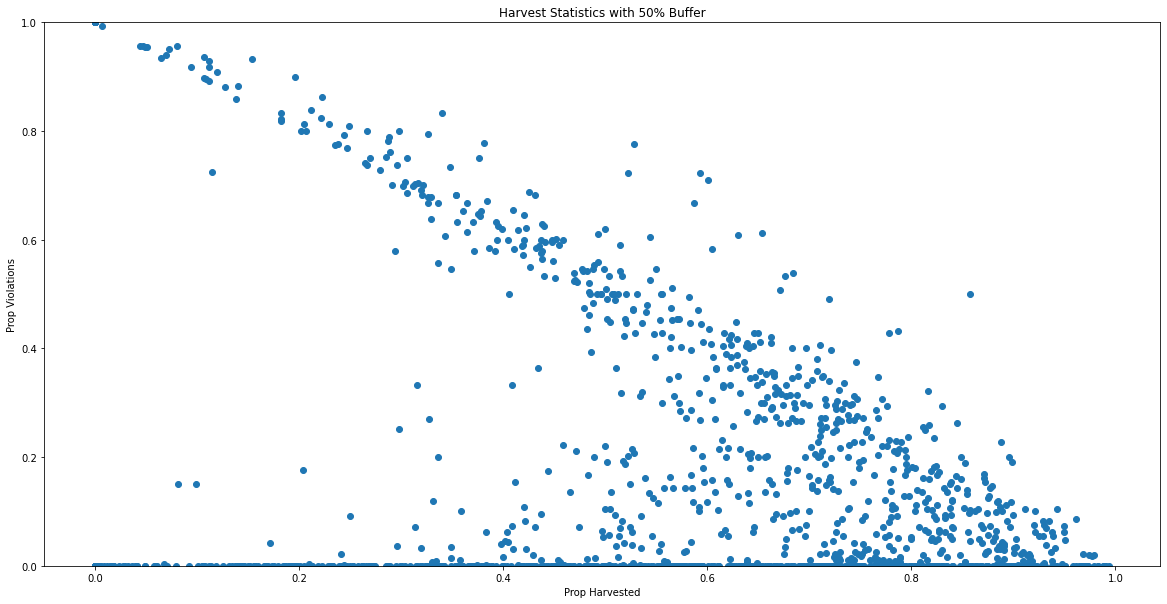

       prop_harvested  prop_violations
count     1423.000000      1423.000000
mean         0.537898         0.161011
std          0.276907         0.240268
min          0.000000         0.000000
25%          0.359739         0.000000
50%          0.587118         0.021277
75%          0.751610         0.258201
max          0.994001         1.000000


       prop_harvested  prop_violations
count     1423.000000      1423.000000
mean         0.487764         0.130585
std          0.301146         0.223364
min          0.000000         0.000000
25%          0.242340         0.000000
50%          0.548710         0.000000
75%          0.737520         0.167757
max          0.991887         1.000000


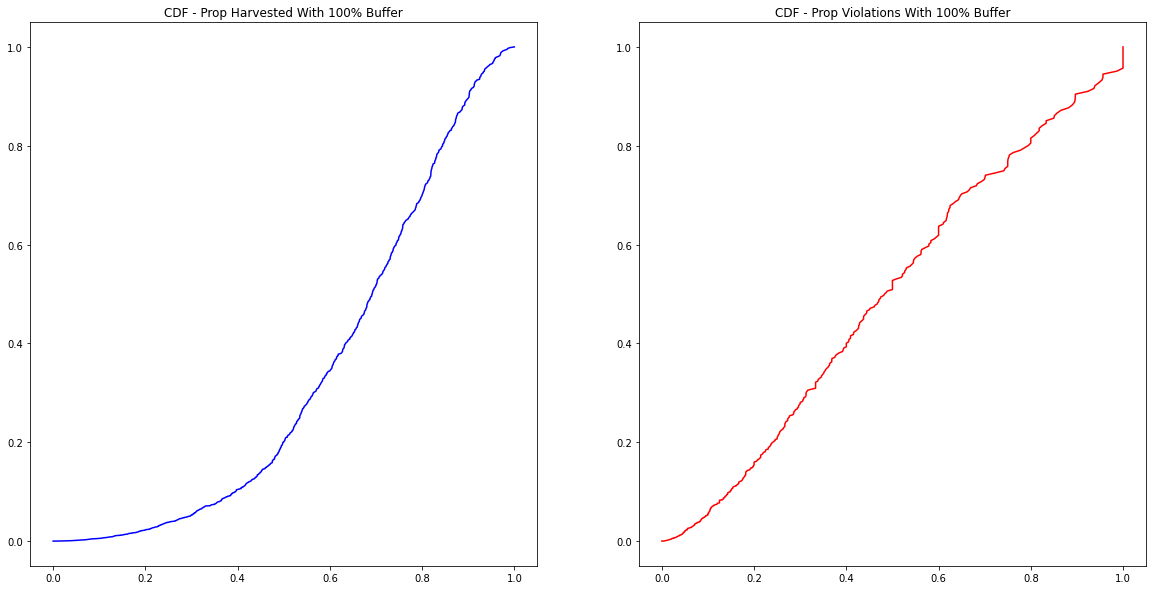

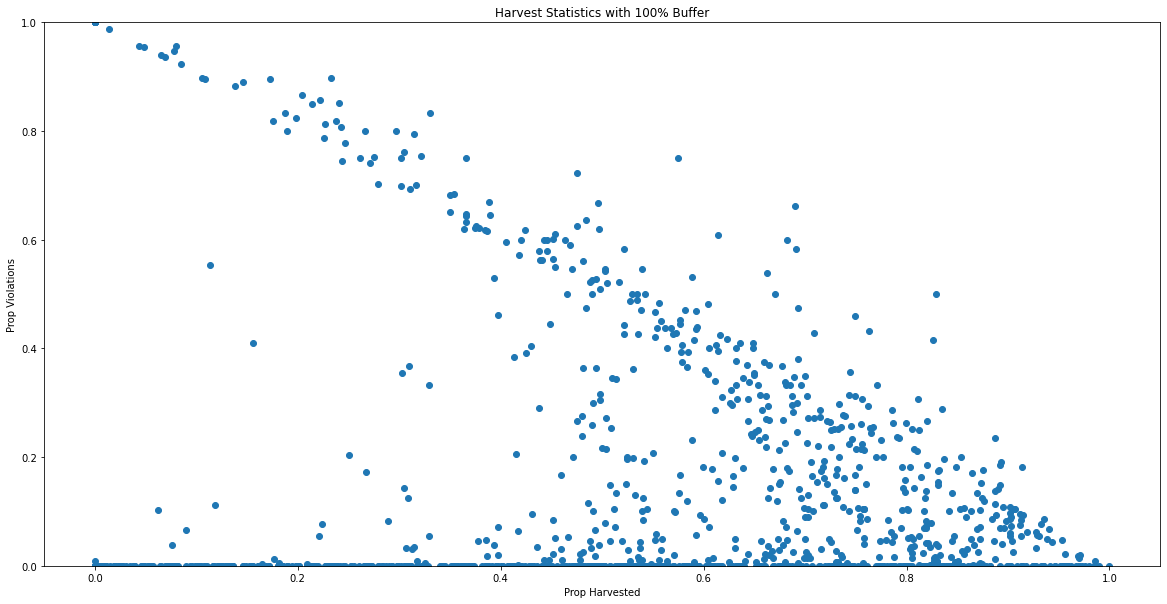

       prop_harvested  prop_violations
count     1423.000000      1423.000000
mean         0.439061         0.114667
std          0.314974         0.211734
min          0.000000         0.000000
25%          0.101381         0.000000
50%          0.493833         0.000000
75%          0.703848         0.136364
max          0.999882         1.000000


In [24]:
model_results_dfs['arima'] = get_model_results(max_mem_3_dir, 5, "arima")

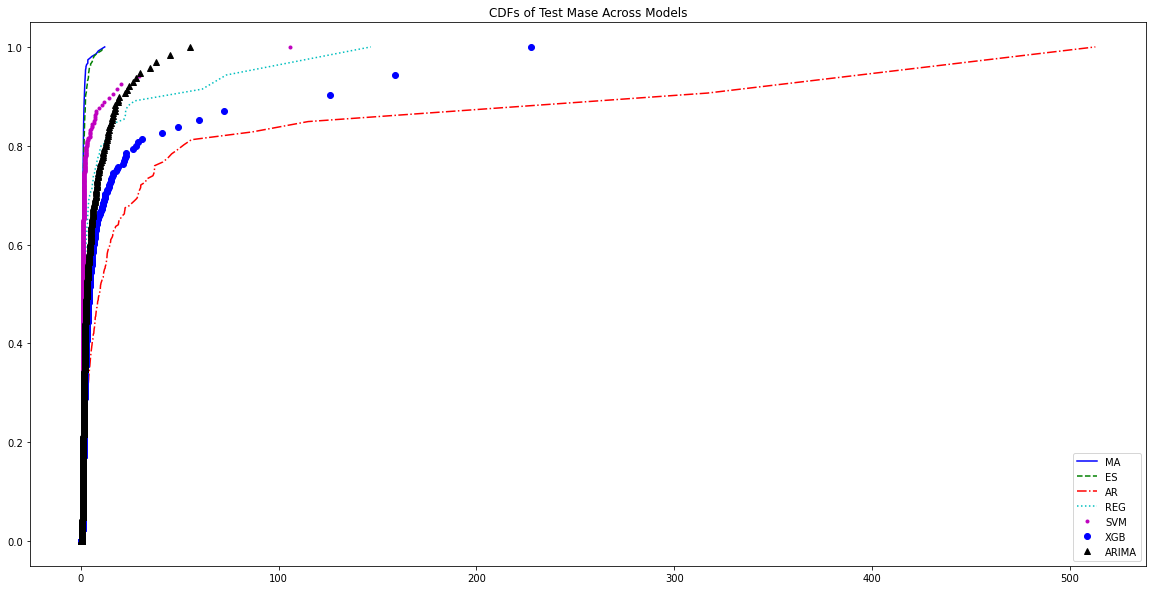

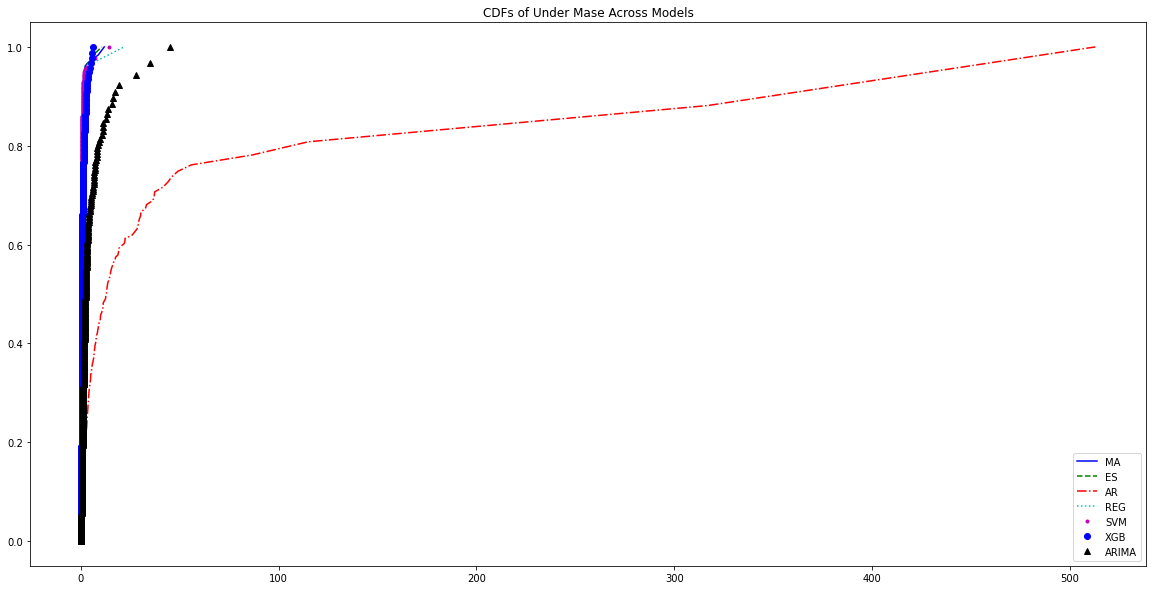

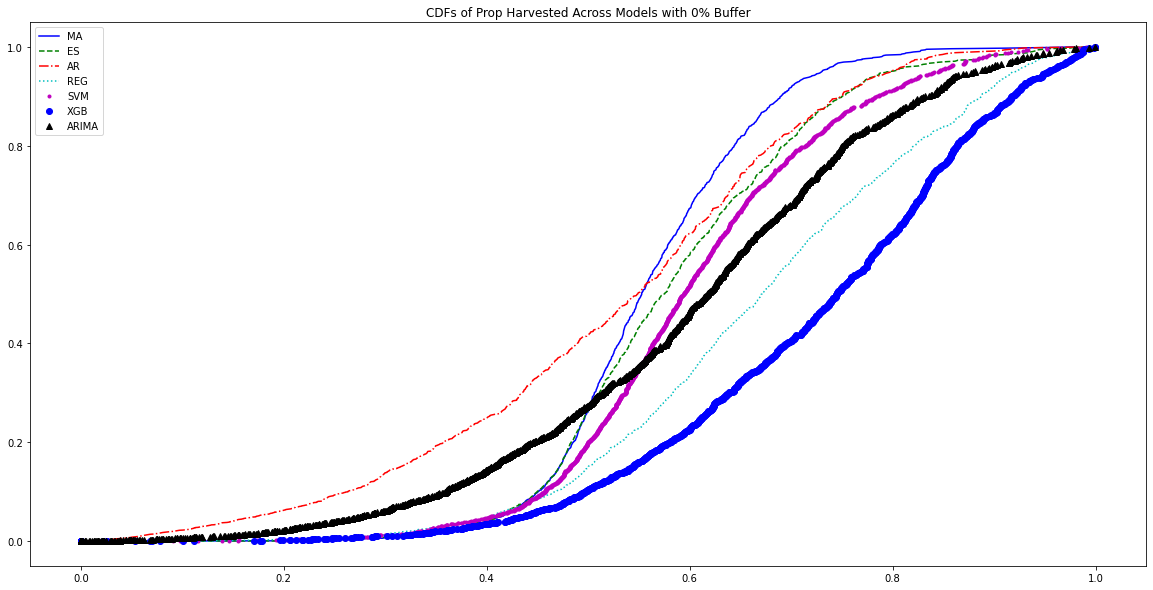

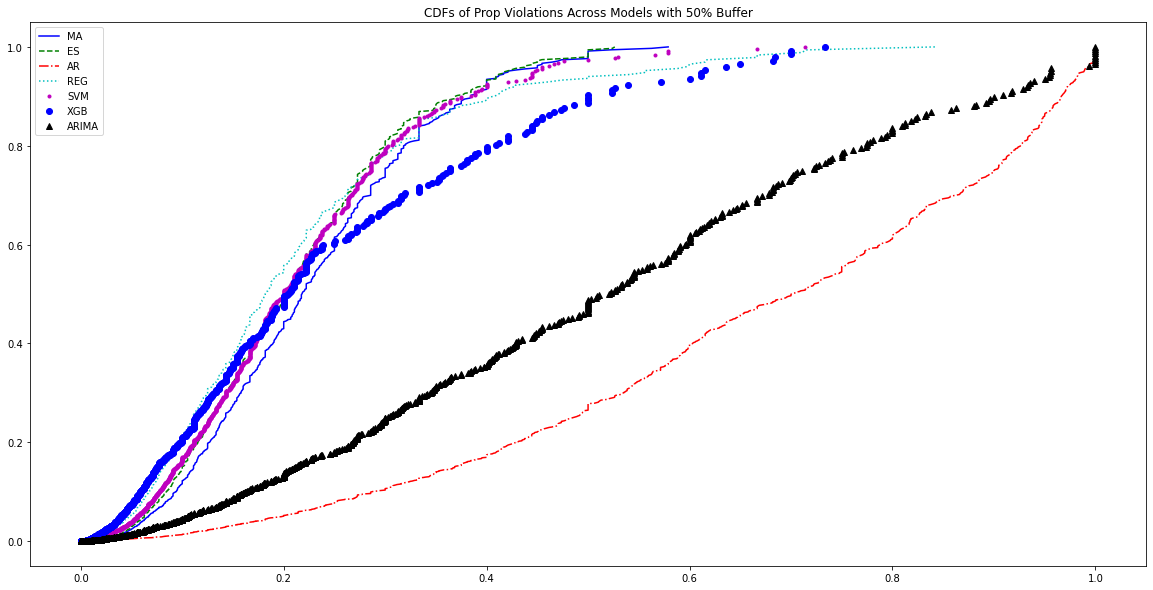

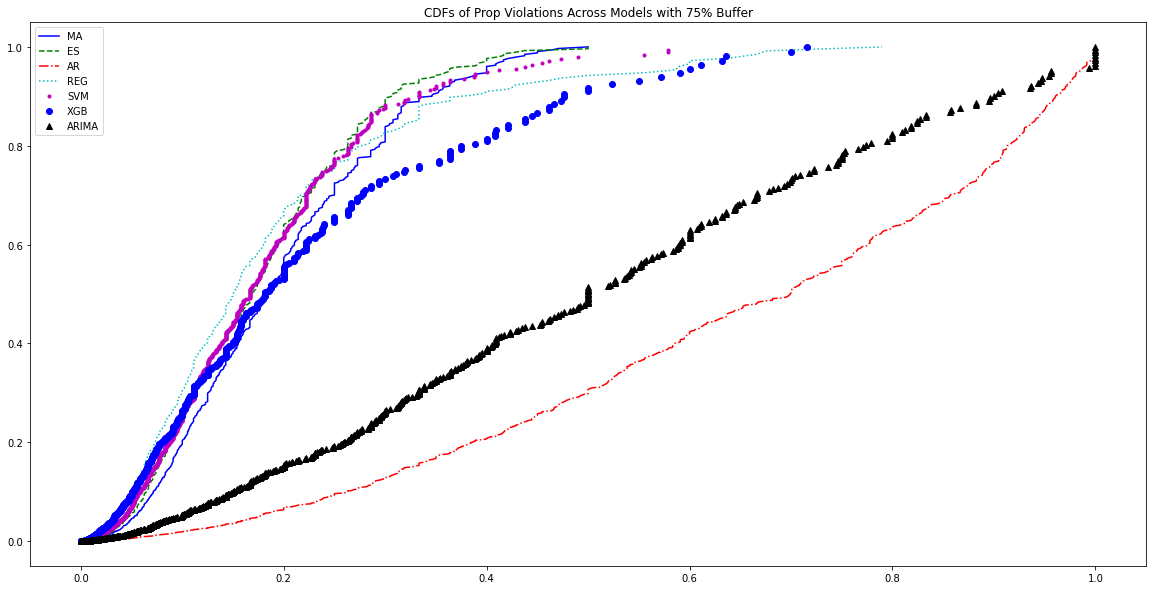

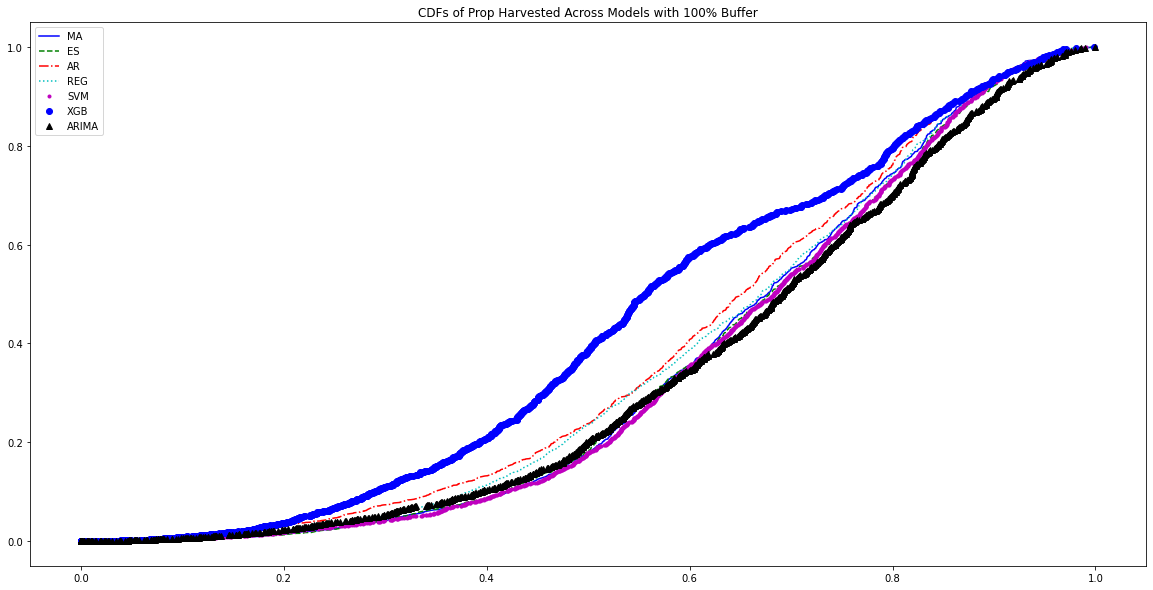

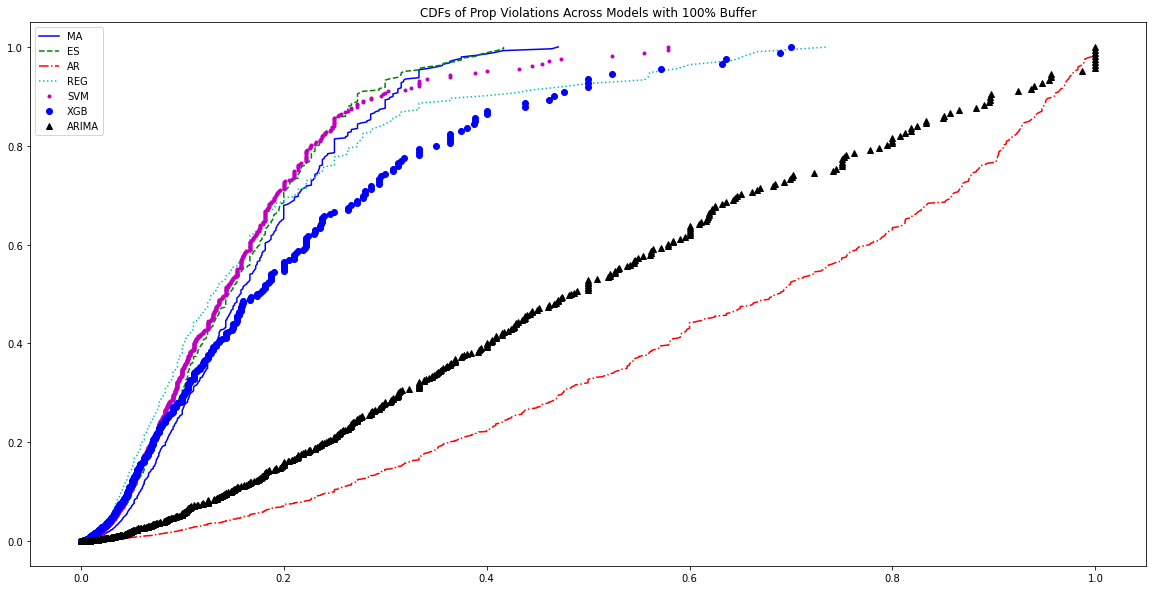

In [25]:
plot_all_cdfs_across_models(model_results_dfs)

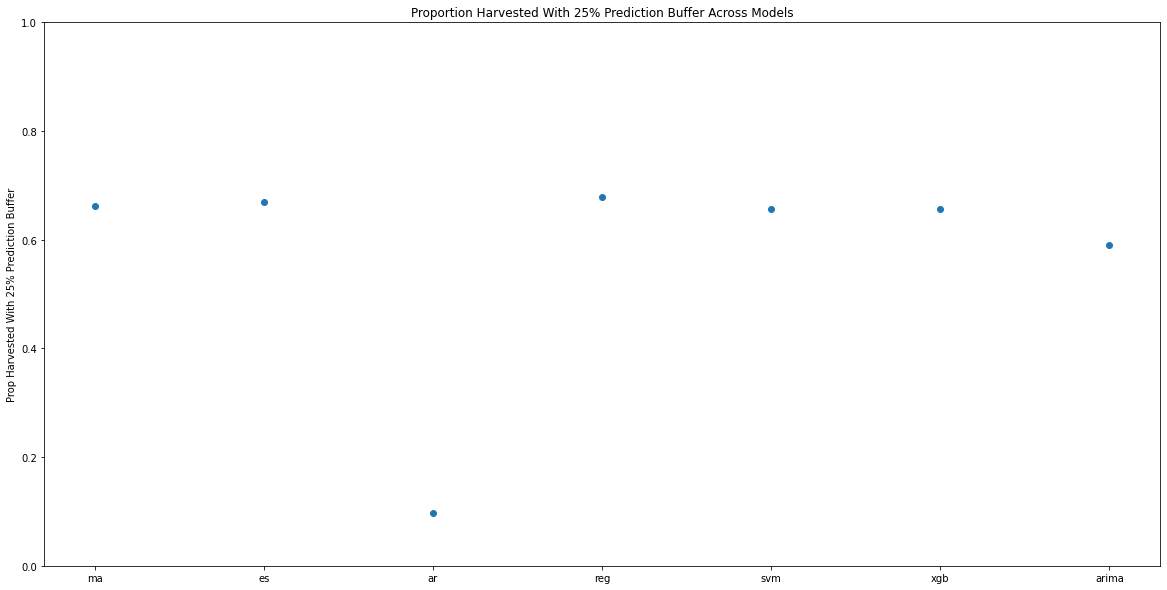

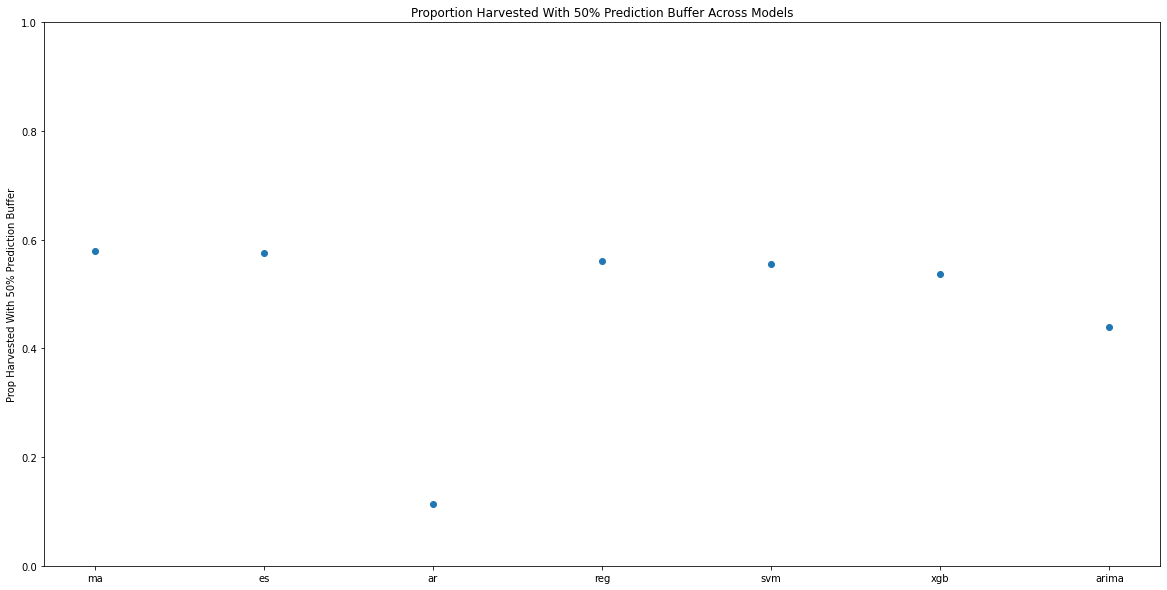

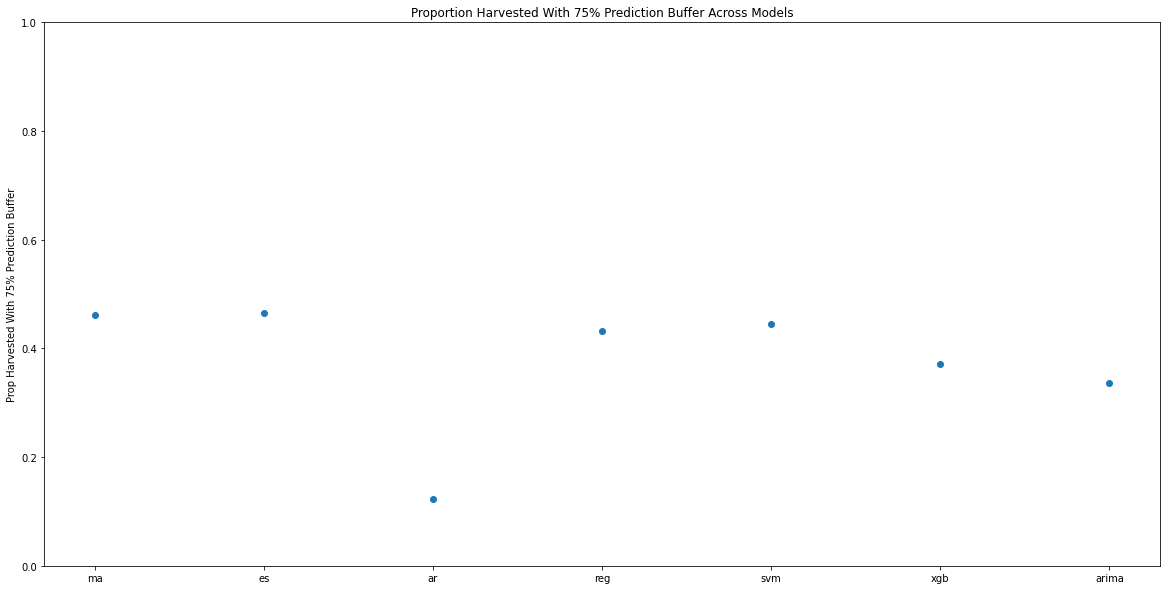

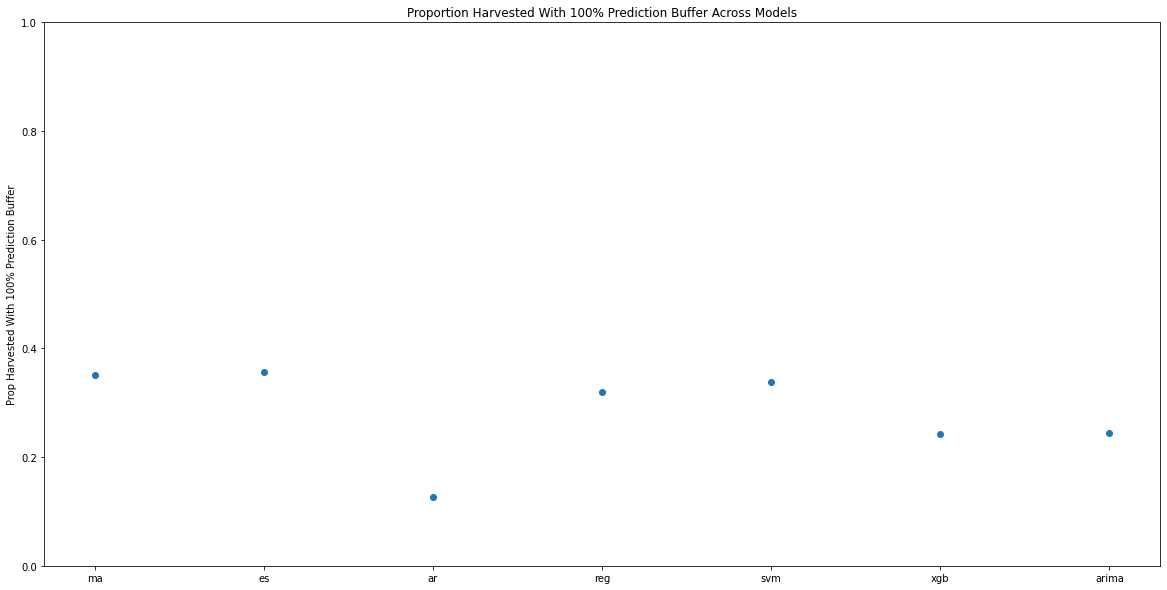

In [26]:
compare_model_harvest_results(model_results_dfs)

In [27]:
analysis.output_best_model_results_from_model_results_dfs(model_results_dfs, max_mem_3_dir)

In [28]:
model_names = list(model_results_dfs.keys()) + ['best']

                 id  train_mase_best  test_mase_best  under_mase_best  \
count  1.432000e+03      1432.000000     1432.000000      1432.000000   
mean   3.708082e+11         1.584148        2.111304         0.313935   
std    7.680769e+10         5.456514        5.252813         0.318928   
min    1.950000e+02         0.000000        0.000000         0.000000   
25%    3.807102e+11         0.872713        0.986059         0.060232   
50%    3.835432e+11         0.999981        1.262458         0.266865   
75%    3.961267e+11         1.233212        1.899436         0.459758   
max    4.004415e+11       192.958905      125.818071         2.993903   

       prop_under_preds_best  max_under_pred_best  over_mase_best  \
count            1432.000000          1267.000000     1432.000000   
mean                0.195915           502.003386        1.797369   
std                 0.160939          6763.021153        5.296453   
min                 0.000000             0.000718        0.000000 

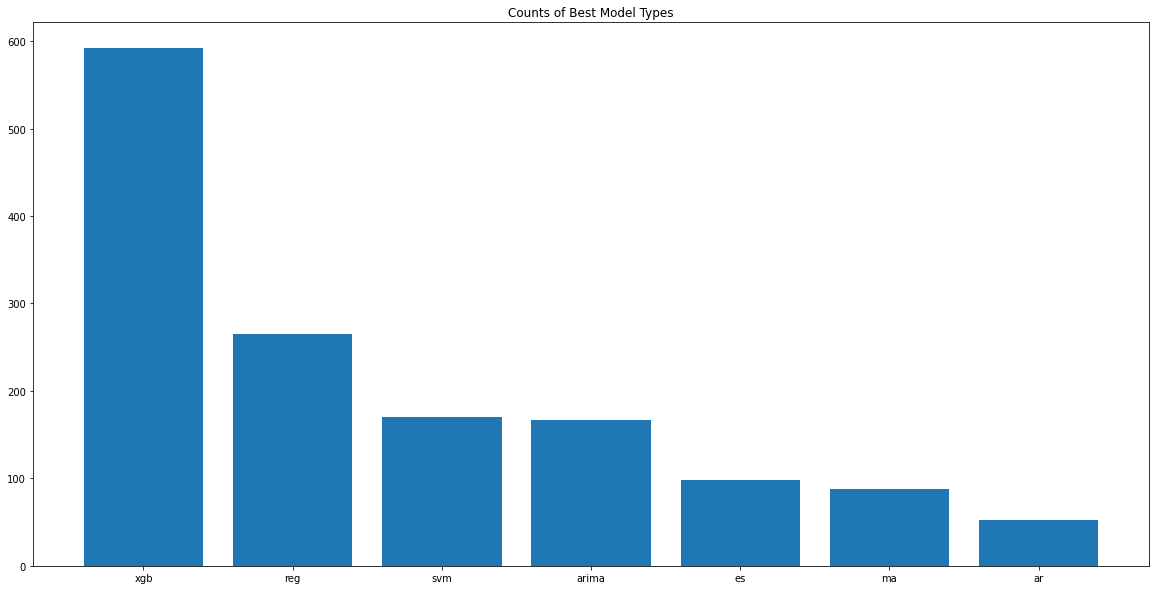

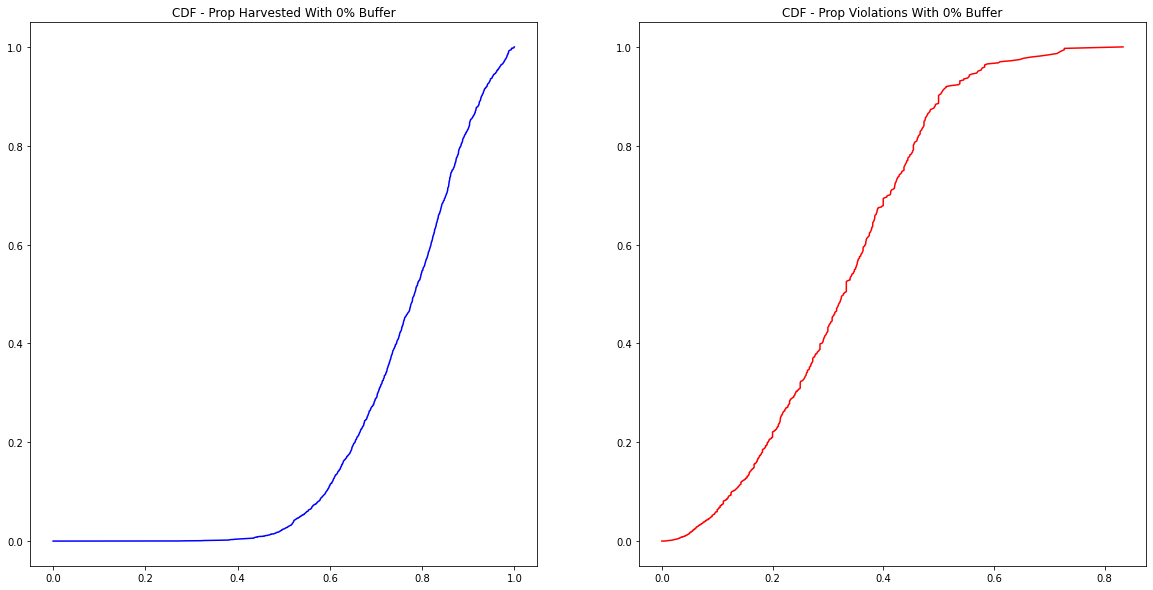

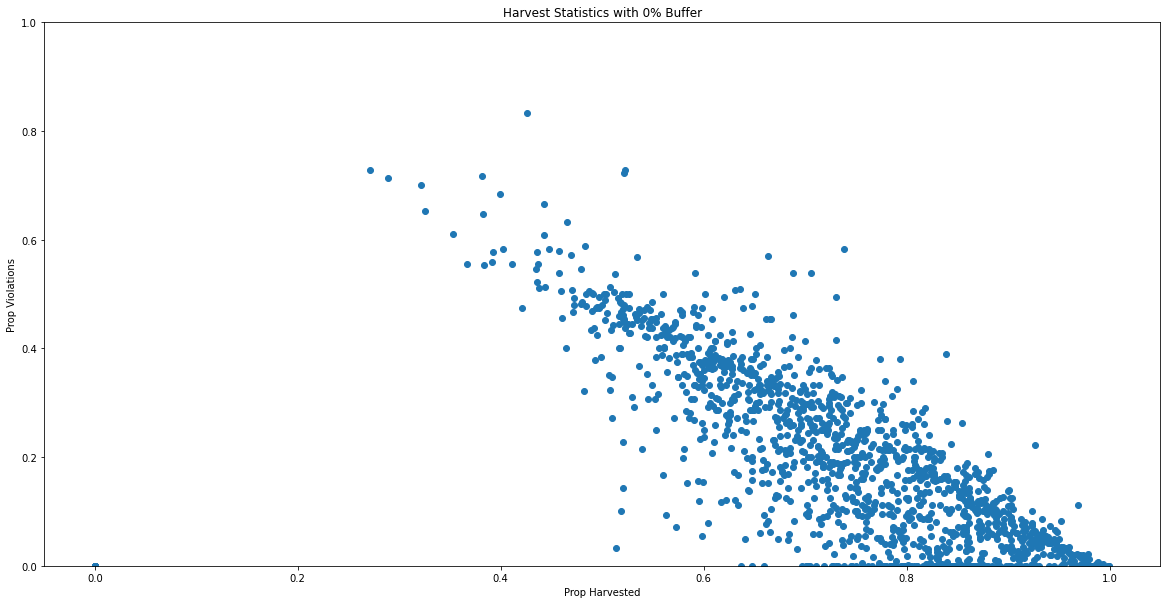

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.737685         0.195915
std          0.152035         0.160938
min          0.000000         0.000000
25%          0.646109         0.055556
50%          0.751689         0.170646
75%          0.848202         0.312658
max          0.999812         0.833333


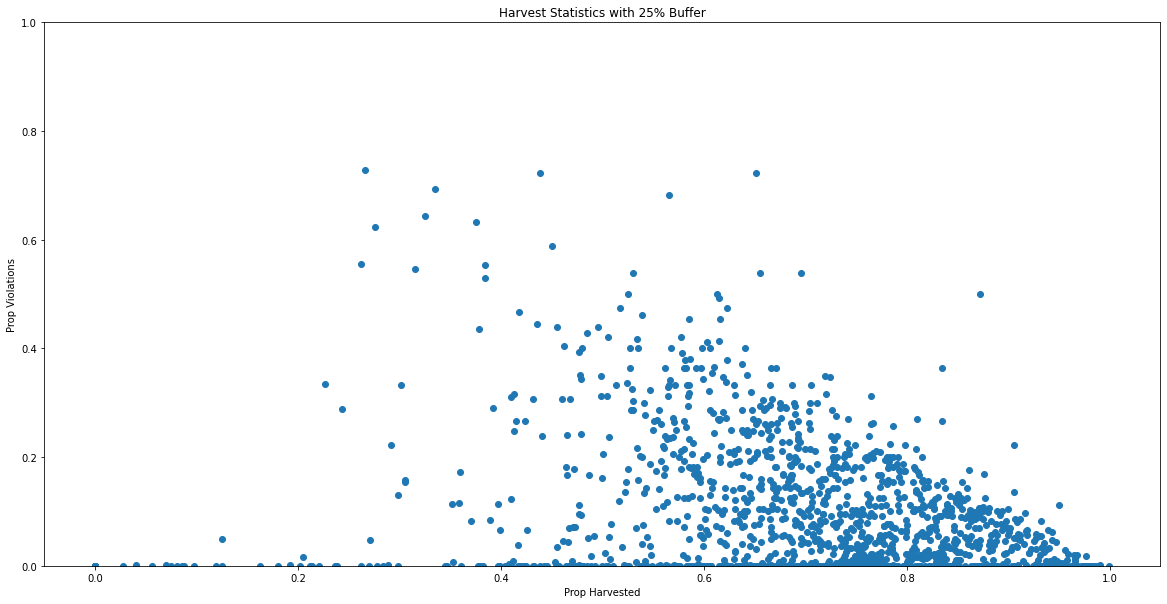

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.696421         0.098844
std          0.174992         0.121381
min          0.000000         0.000000
25%          0.616874         0.000000
50%          0.724553         0.055079
75%          0.810427         0.156419
max          0.999300         0.727273


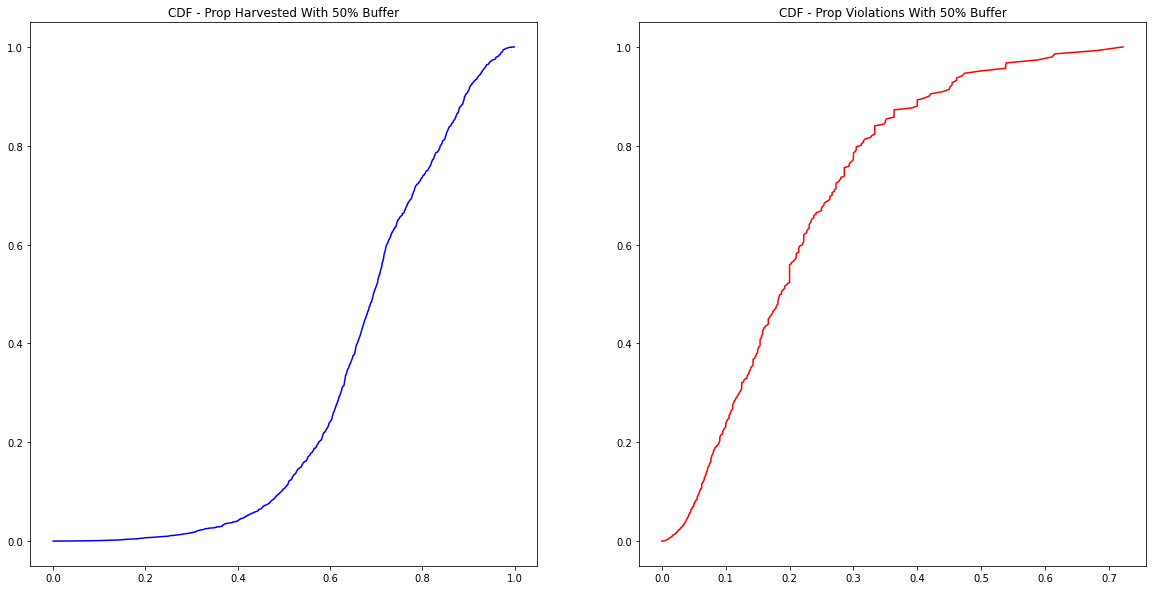

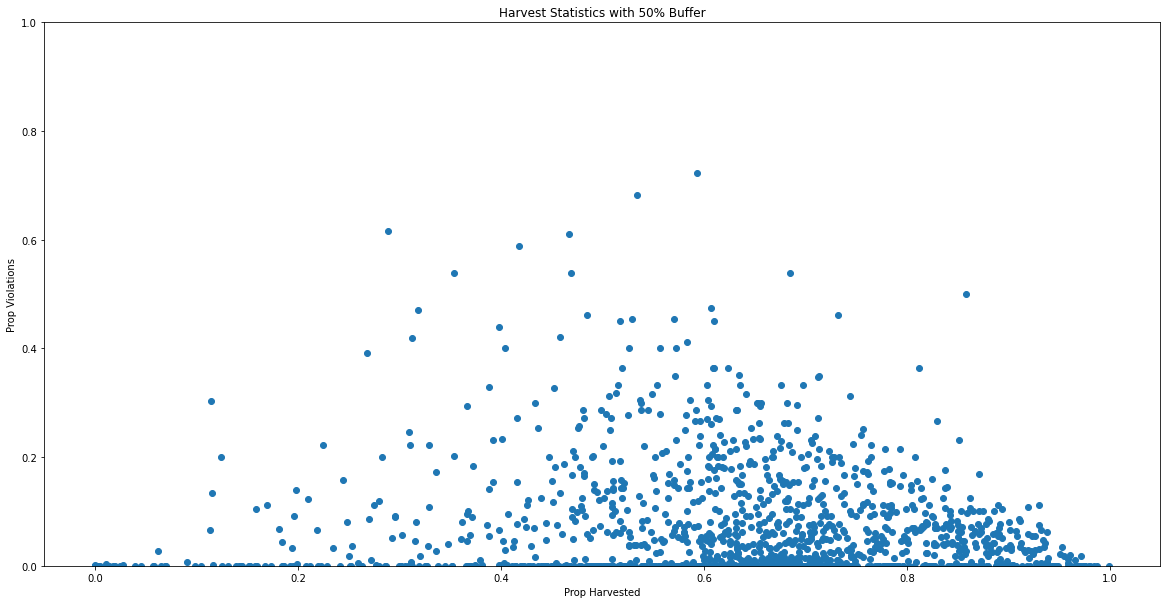

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.610654         0.069564
std          0.222137         0.100404
min          0.000000         0.000000
25%          0.516916         0.000000
50%          0.647136         0.026911
75%          0.748993         0.100922
max          0.999127         0.722222


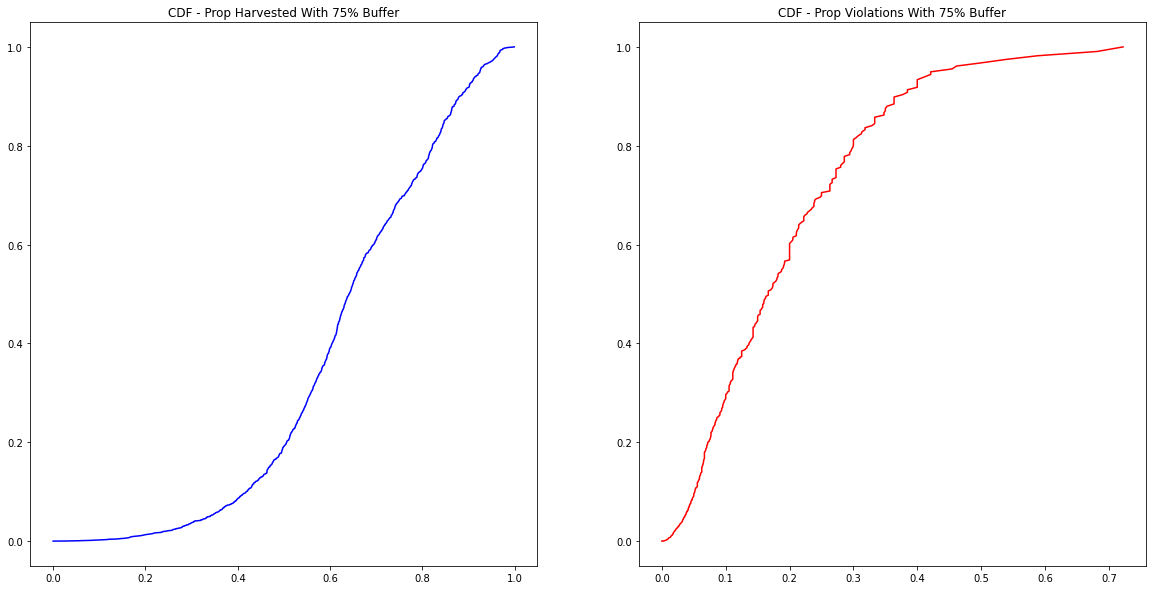

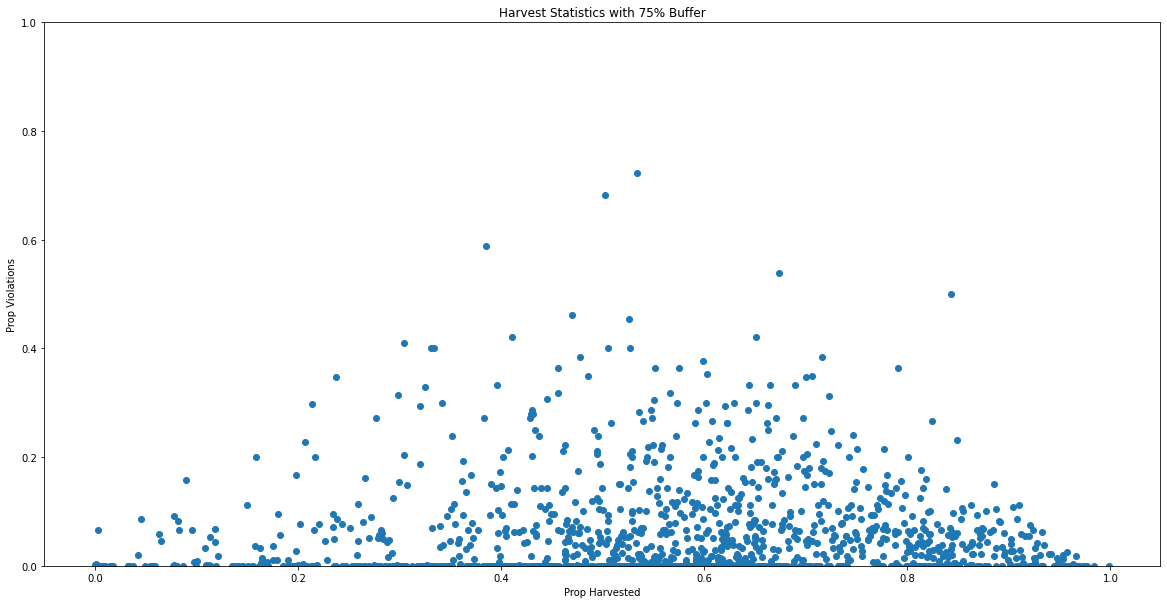

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.532998         0.054714
std          0.248057         0.088097
min          0.000000         0.000000
25%          0.402091         0.000000
50%          0.567284         0.012770
75%          0.701360         0.071545
max          0.998953         0.722222


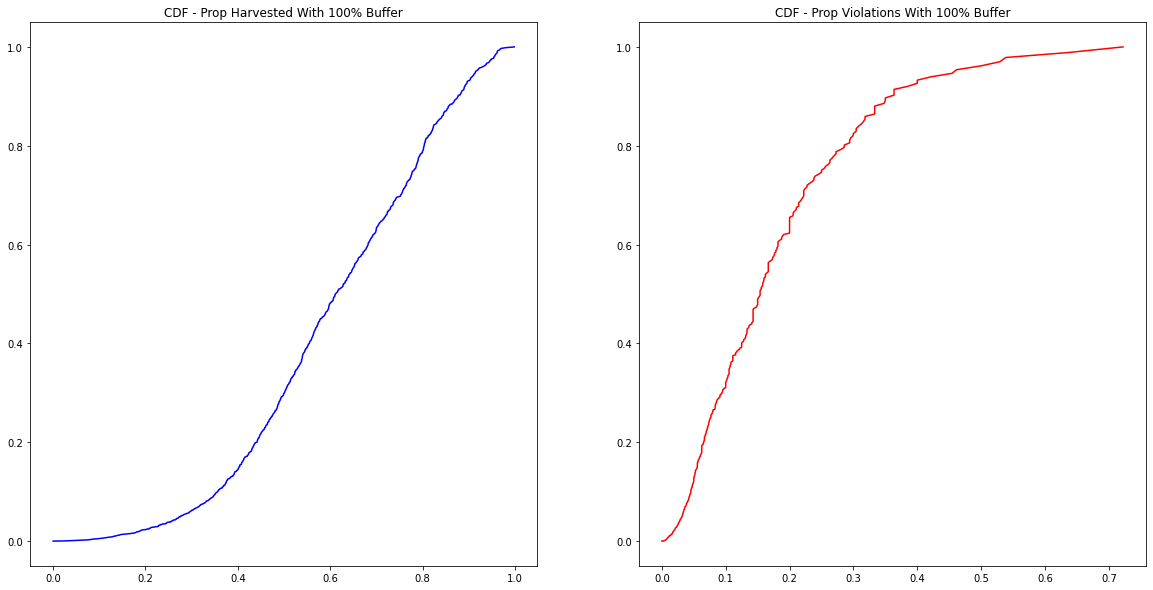

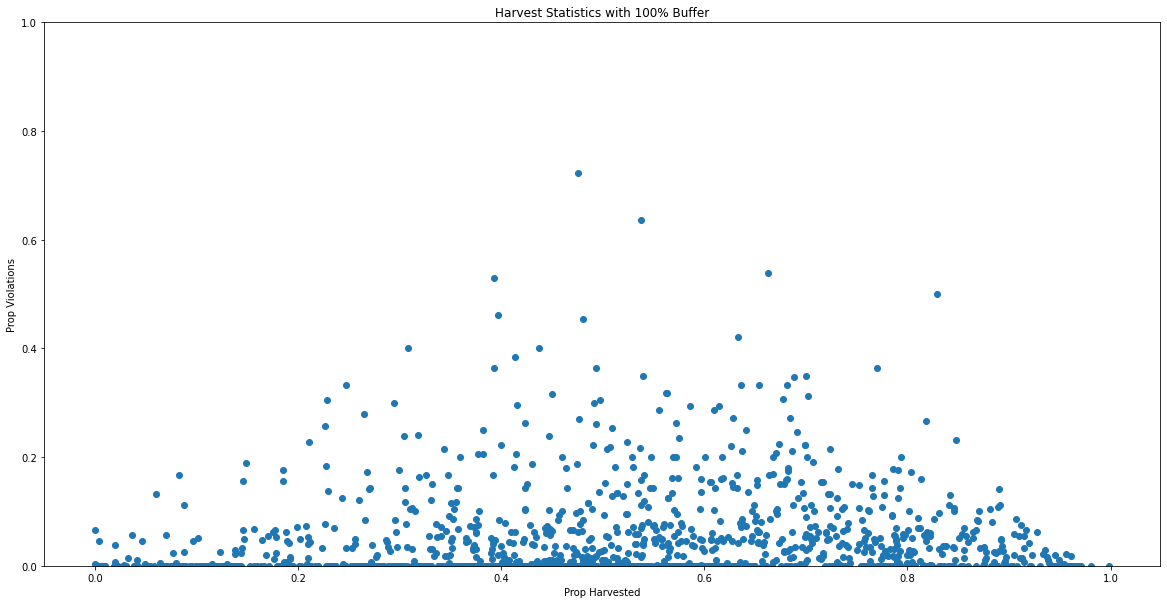

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.465720         0.044232
std          0.263149         0.078888
min          0.000000         0.000000
25%          0.290024         0.000000
50%          0.485398         0.002174
75%          0.661453         0.055702
max          0.998780         0.722222


In [29]:
model_results_dfs['best'] = display_best_model_results_for_all_traces(max_mem_3_dir)

In [30]:
print("Test MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "test_mase")

Test MASE


P1       P25    Median       P75        P99
ma     0.545617  0.865643  0.980310  1.041957   2.476625
es     0.554259  0.872060  0.960127  1.073109   3.933738
ar     0.494368  1.020145  1.525461  2.861818  33.074245
reg    0.541669  0.938302  1.100719  1.528486  12.316067
svm    0.529047  0.878966  0.974606  1.149484   6.761604
xgb    0.510430  1.047194  1.420358  2.273137  21.554212
arima  0.481900  0.988019  1.334776  2.077257  17.216373
best   0.507002  0.986059  1.262458  1.899436  14.951903

In [31]:
print("Under Predictions MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "under_mase")

Under Predictions MASE


P1       P25    Median       P75        P99
ma     0.026901  0.403830  0.477773  0.521390   1.353594
es     0.000000  0.384693  0.460165  0.520360   1.629849
ar     0.000000  0.332122  0.861433  2.091821  30.312765
reg    0.000000  0.246568  0.396304  0.526624   2.055006
svm    0.000000  0.308886  0.439178  0.541516   1.344698
xgb    0.000000  0.059519  0.270571  0.478694   2.664038
arima  0.000000  0.110659  0.403845  1.017384   9.539884
best   0.000000  0.060232  0.266865  0.459758   1.423482

In [32]:
print("Proportion of Memory Harvest with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_harvested_0.0")

Proportion of Memory Harvest with 0% Buffer


P1       P25    Median       P75       P99
ma     0.018230  0.482054  0.534862  0.603828  0.803592
es     0.000000  0.478773  0.543544  0.635548  0.897307
ar     0.000000  0.067881  0.328857  0.547823  0.821447
reg    0.000000  0.501715  0.616937  0.743252  0.963238
svm    0.000000  0.490183  0.564919  0.651105  0.898863
xgb    0.000000  0.544309  0.686549  0.818292  0.984255
arima  0.000000  0.320198  0.511006  0.657244  0.931552
best   0.298841  0.646109  0.751689  0.848202  0.986108

In [33]:
print("Proportion of Violations with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_violations_0.0")

Proportion of Violations with 0% Buffer


P1       P25    Median       P75       P99
ma     0.06177  0.384615  0.452413  0.500000  0.727273
es     0.00000  0.349347  0.448240  0.507777  0.727273
ar     0.00000  0.378338  0.684211  0.937500  1.000000
reg    0.00000  0.194995  0.340618  0.476190  0.825535
svm    0.00000  0.315789  0.416518  0.500000  0.821875
xgb    0.00000  0.058580  0.200000  0.389610  0.841453
arima  0.00000  0.191545  0.400000  0.674206  1.000000
best   0.00000  0.055556  0.170646  0.312658  0.586716

### Maximum CPU Usage - 3 Period Aggregation

In [34]:
max_cpu_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_cpu_3"
model_results_dfs = {}

                 id  train_mase_ma  test_mase_ma  under_mase_ma  \
count  1.432000e+03    1432.000000   1432.000000    1432.000000   
mean   3.708082e+11       0.956858      1.008870       0.475083   
std    7.680769e+10       0.241454      1.318062       0.163170   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.807102e+11       0.829587      0.787700       0.392422   
50%    3.835432e+11       0.897029      0.885418       0.448562   
75%    3.961267e+11       1.023760      1.009152       0.520195   
max    4.004415e+11       2.639913     46.046608       1.557024   

       prop_under_preds_ma  max_under_pred_ma  over_mase_ma  \
count          1432.000000        1415.000000   1432.000000   
mean              0.421730         112.153959      0.533787   
std               0.111696         449.257167      1.326778   
min               0.000000           0.007689      0.000000   
25%               0.368421           2.959225      0.377277   
50%               

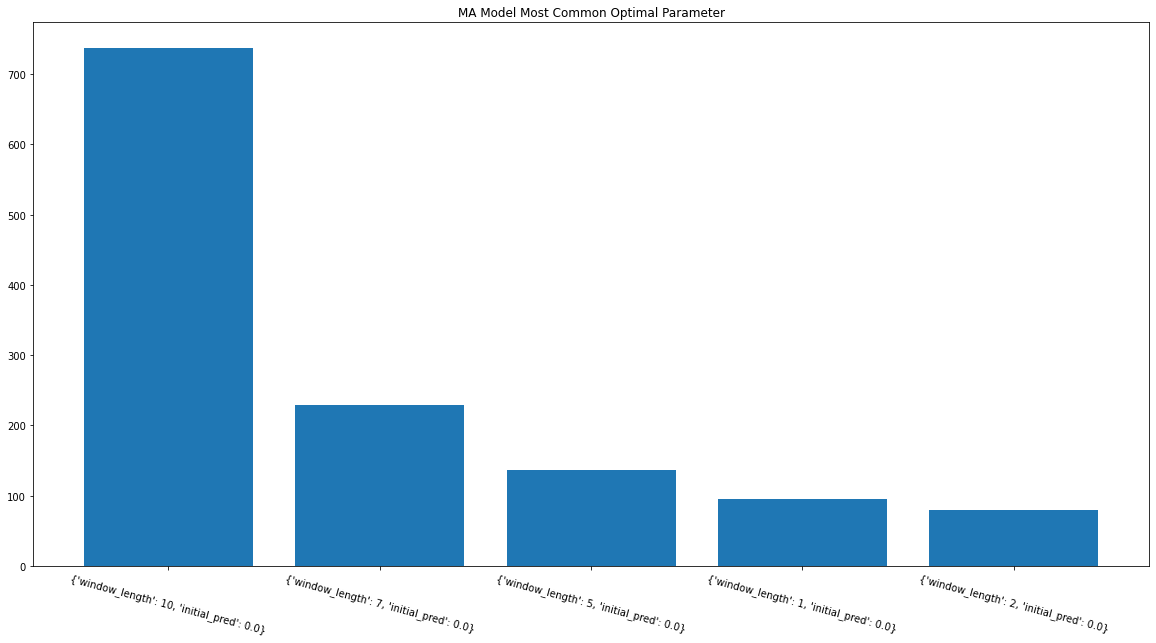

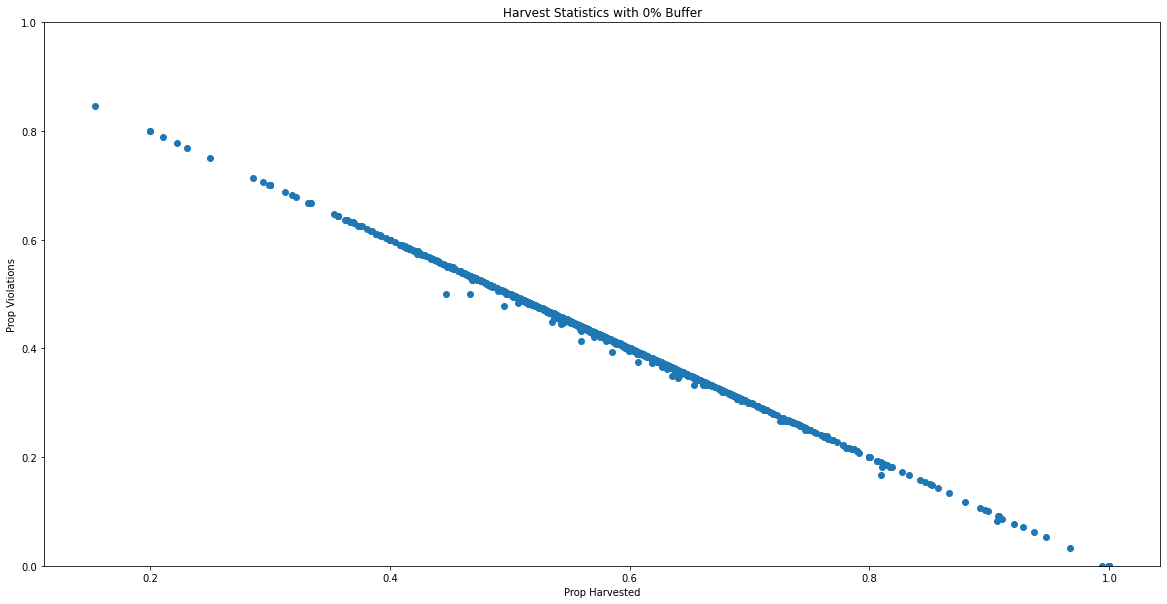

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.577709         0.421730
std          0.111606         0.111696
min          0.154025         0.000000
25%          0.516324         0.368421
50%          0.574795         0.424669
75%          0.630933         0.483379
max          1.000000         0.846154


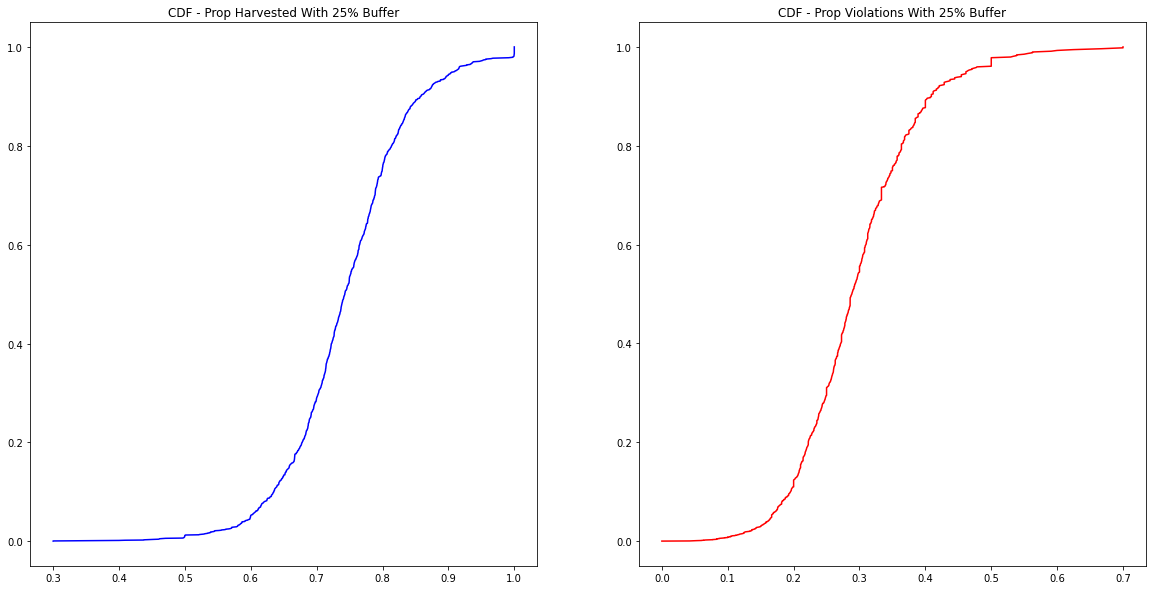

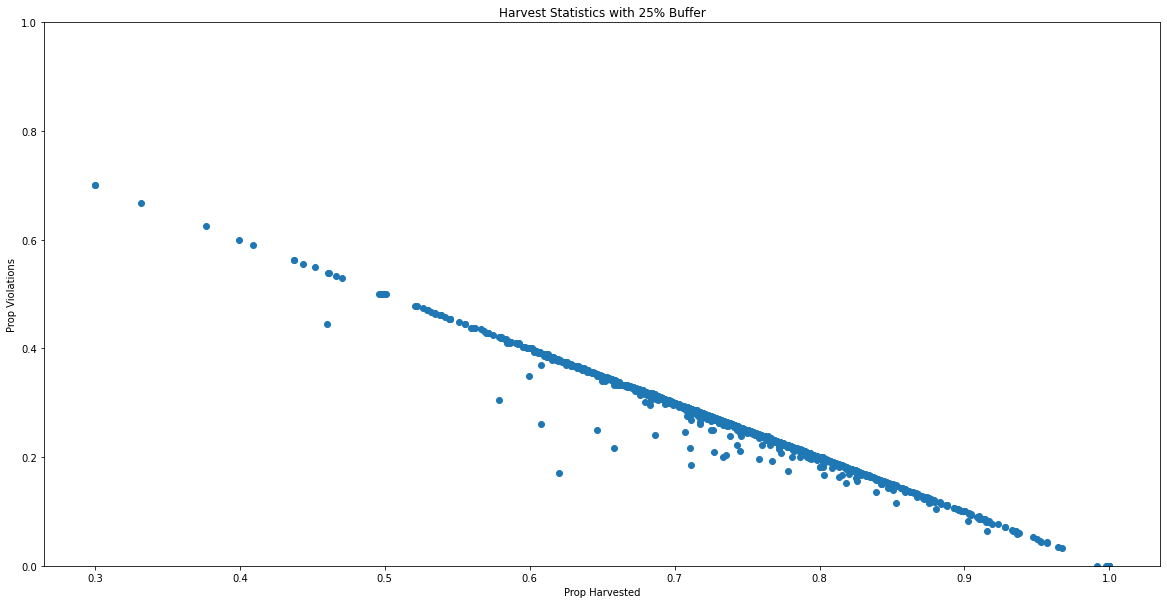

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.733728         0.263701
std          0.095391         0.095399
min          0.299937         0.000000
25%          0.681606         0.208333
50%          0.733126         0.263158
75%          0.789356         0.315789
max          1.000000         0.700000


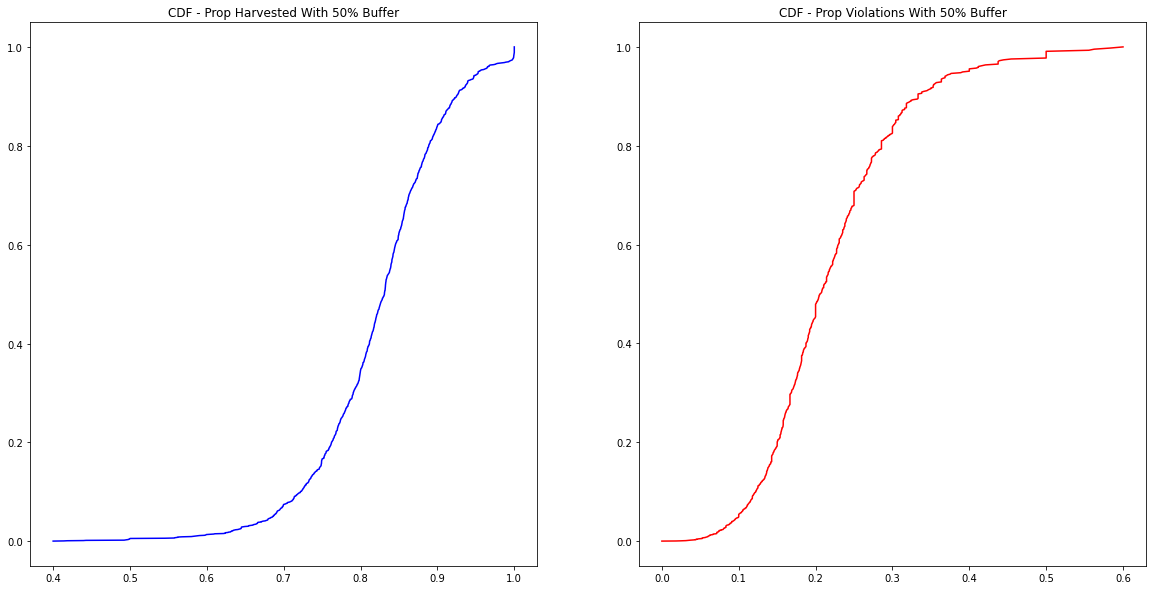

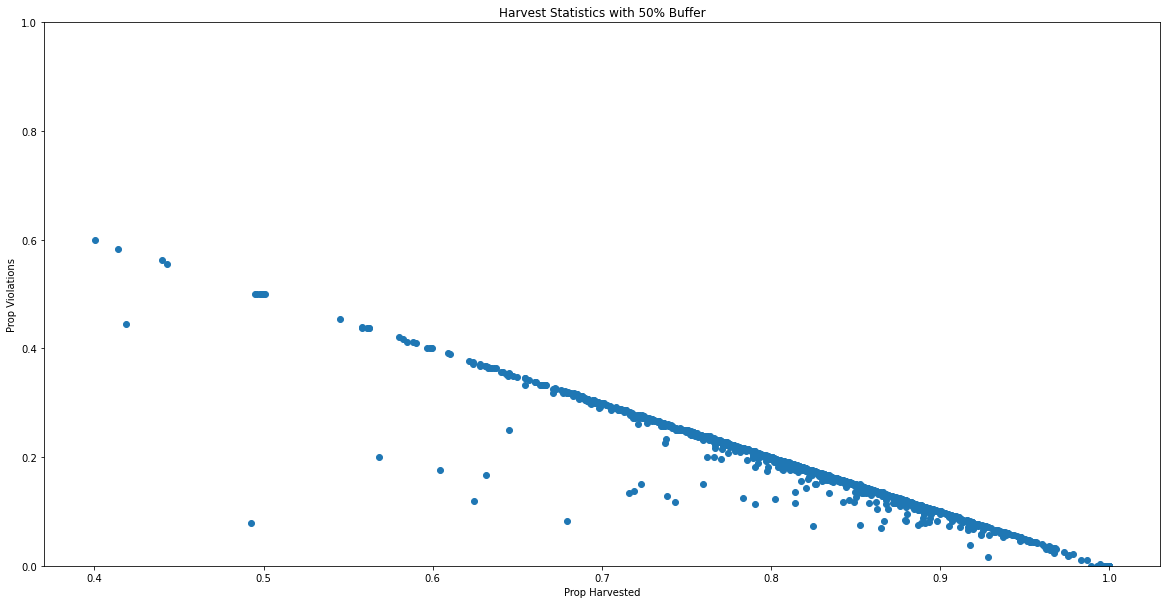

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.814884         0.180113
std          0.087651         0.086592
min          0.400236         0.000000
25%          0.767331         0.125000
50%          0.821816         0.173372
75%          0.868229         0.228571
max          1.000000         0.600000


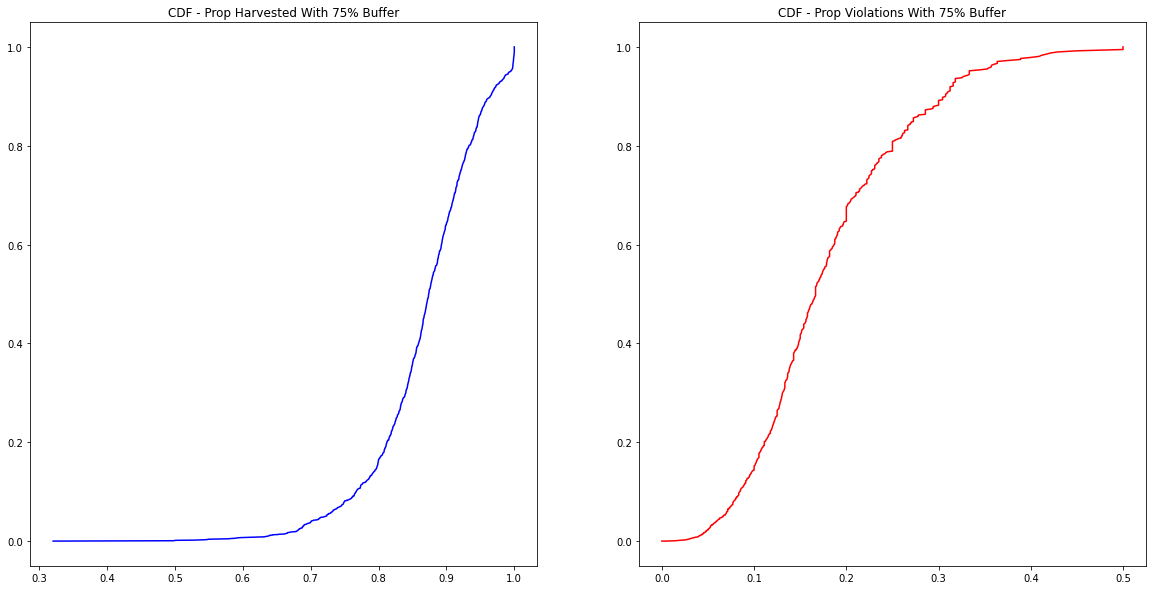

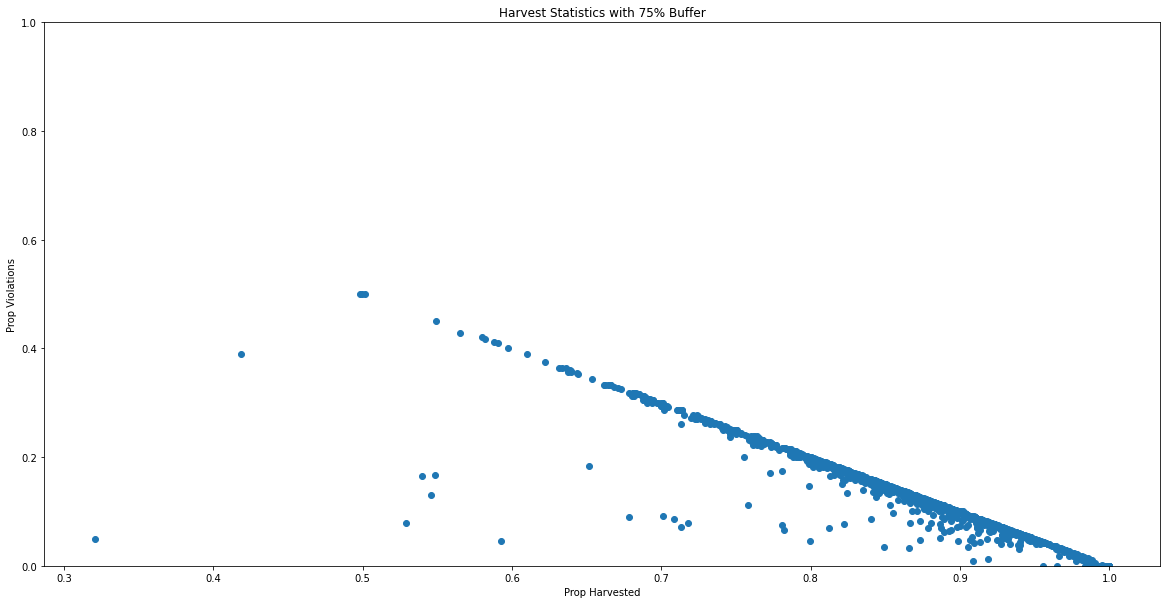

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.860030         0.132452
std          0.084696         0.080964
min          0.320687         0.000000
25%          0.818561         0.076923
50%          0.868941         0.126405
75%          0.915647         0.174793
max          1.000000         0.500000


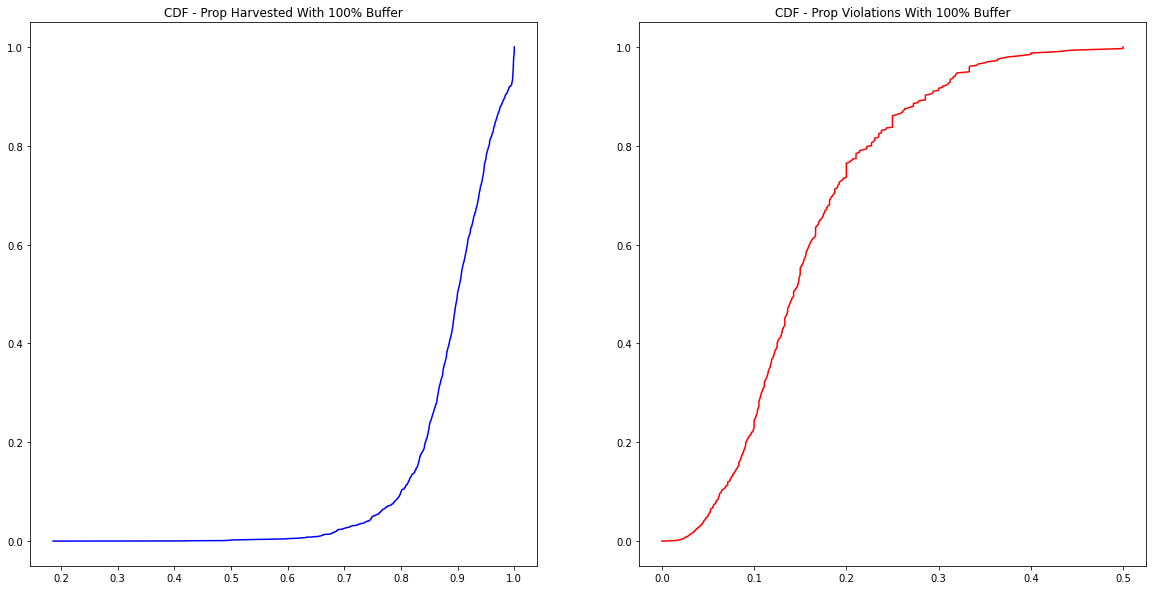

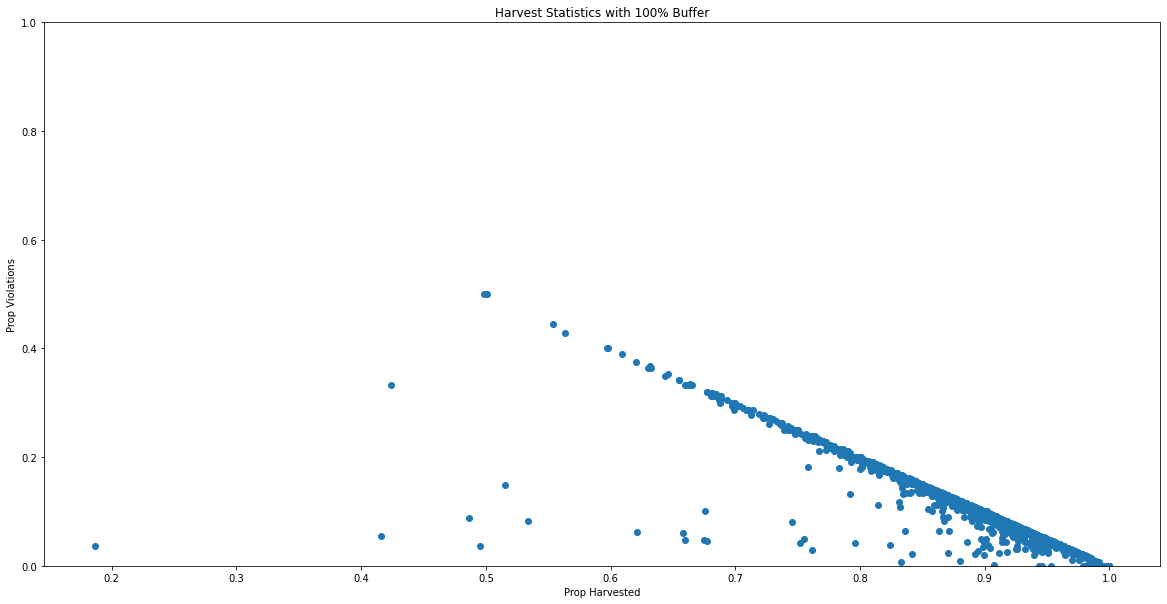

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.884914         0.105078
std          0.083534         0.076366
min          0.186399         0.000000
25%          0.847968         0.050000
50%          0.895199         0.099237
75%          0.942292         0.144097
max          1.000000         0.500000


In [35]:
model_results_dfs['ma'] = get_model_results(max_cpu_3_dir, 5, "ma")

                 id  train_mase_es  test_mase_es  under_mase_es  \
count  1.432000e+03   1.432000e+03   1432.000000    1432.000000   
mean   3.708082e+11   1.049982e+00      1.470329       0.442853   
std    7.680769e+10   4.914489e-01      4.665745       0.191451   
min    1.950000e+02   7.082153e-07      0.000000       0.000000   
25%    3.807102e+11   8.287089e-01      0.779524       0.368218   
50%    3.835432e+11   9.184830e-01      0.900996       0.425982   
75%    3.961267e+11   1.107470e+00      1.085231       0.509031   
max    4.004415e+11   8.447839e+00     98.512736       1.585270   

       prop_under_preds_es  max_under_pred_es  over_mase_es  \
count          1432.000000        1375.000000   1432.000000   
mean              0.362373          39.836236      1.027476   
std               0.145080         196.429000      4.705345   
min               0.000000           0.006722      0.000000   
25%               0.283733           2.470248      0.376758   
50%               

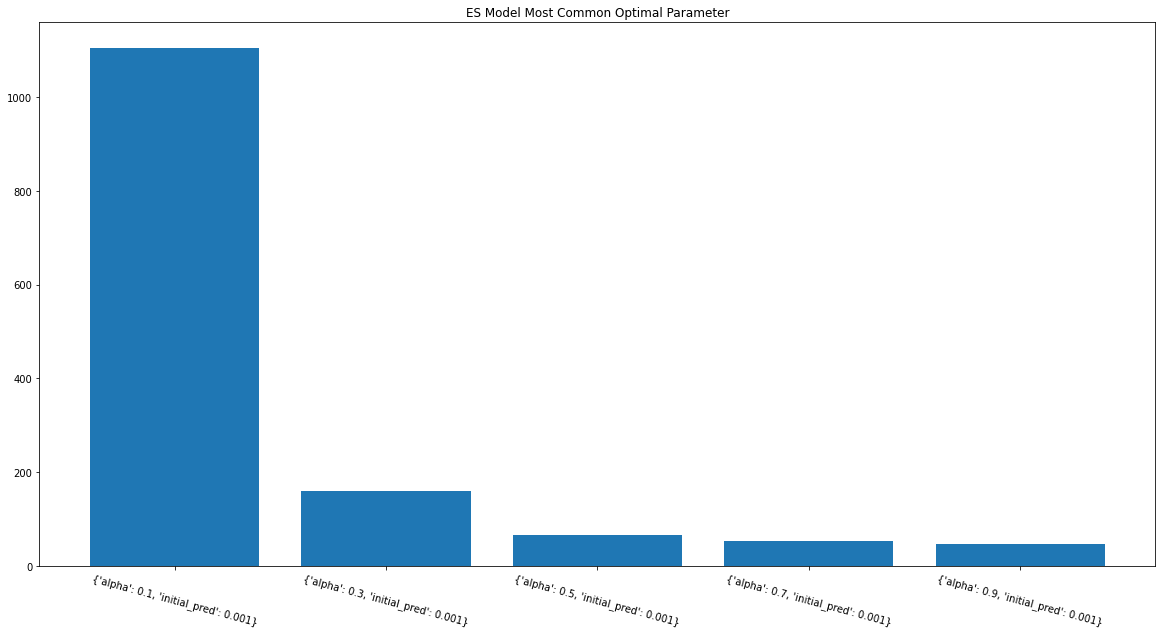

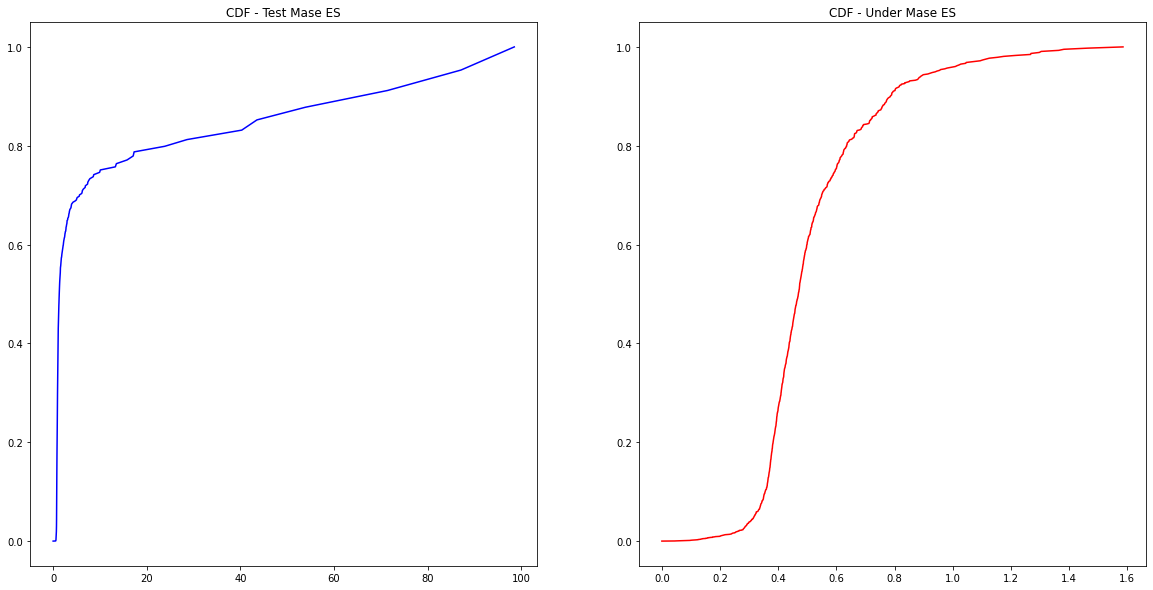

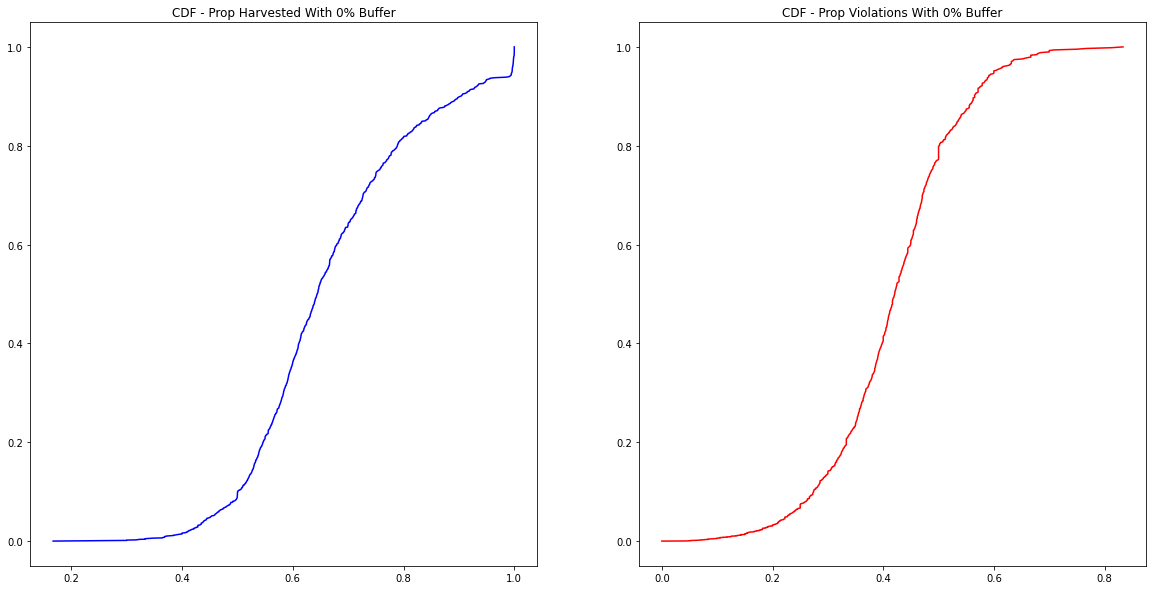

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.637020         0.362373
std          0.144564         0.145080
min          0.167350         0.000000
25%          0.540907         0.283733
50%          0.614625         0.384615
75%          0.715547         0.458333
max          1.000000         0.833333


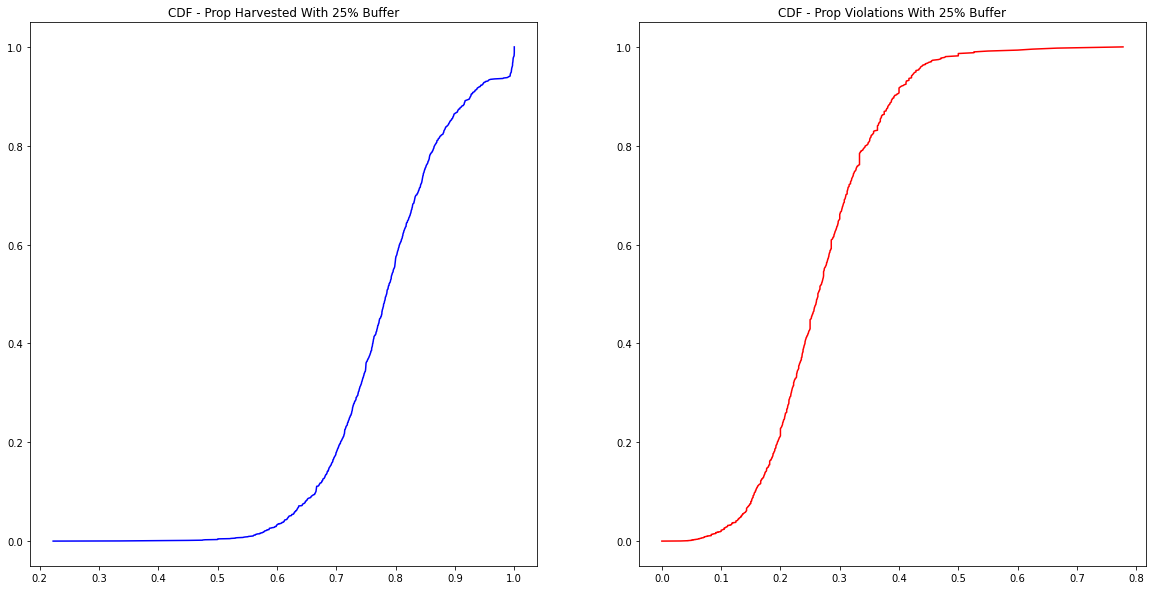

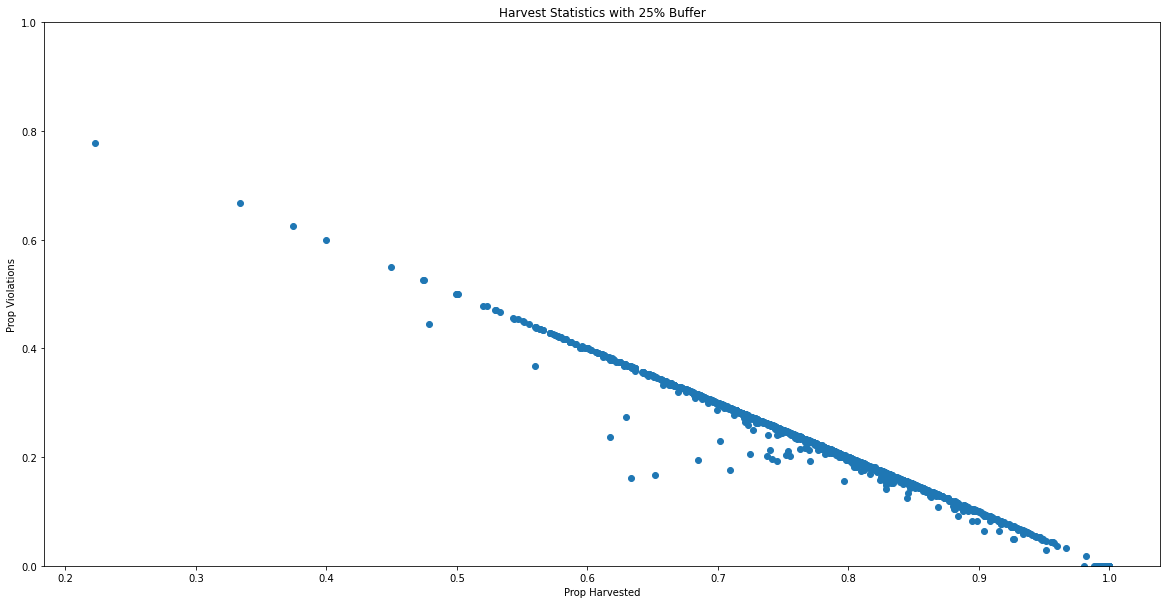

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.774080         0.223098
std          0.103809         0.104056
min          0.222529         0.000000
25%          0.710965         0.158700
50%          0.772814         0.222222
75%          0.838365         0.285714
max          1.000000         0.777778


       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.846458         0.148116
std          0.088907         0.087593
min          0.388152         0.000000
25%          0.797708         0.089744
50%          0.855231         0.139876
75%          0.903941         0.199306
max          1.000000         0.611111


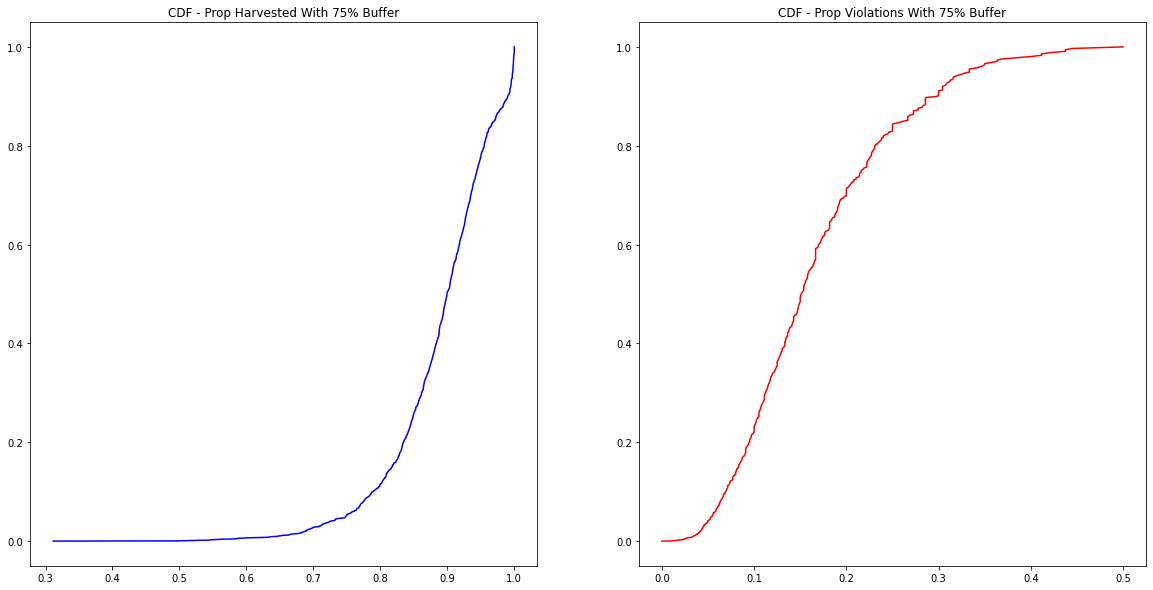

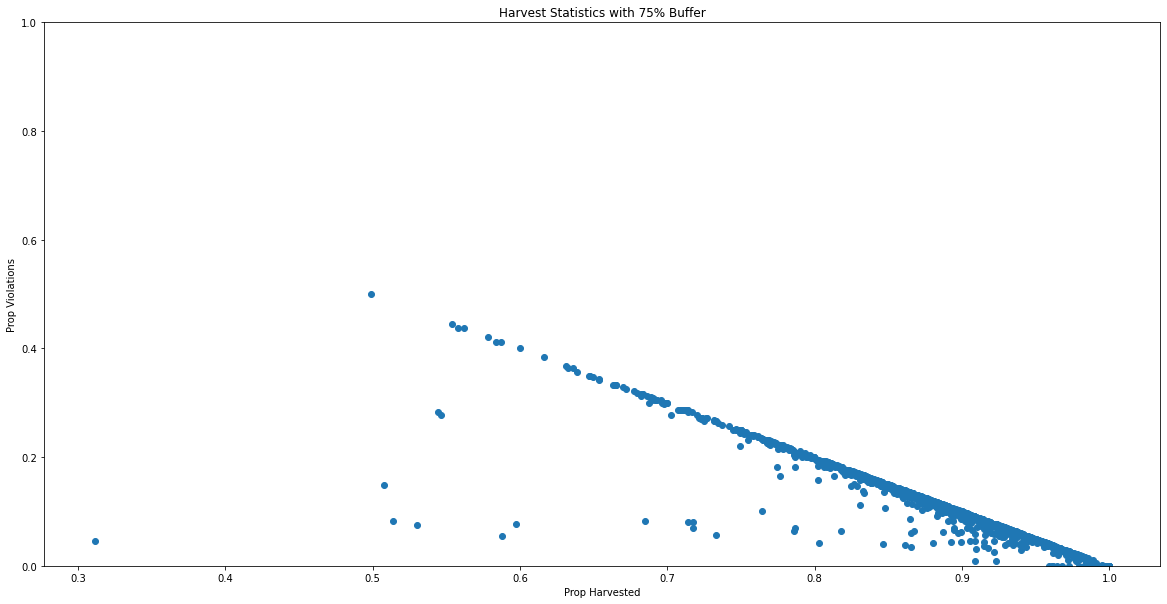

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.882158         0.109784
std          0.084339         0.079807
min          0.311388         0.000000
25%          0.840934         0.053967
50%          0.894389         0.100000
75%          0.938988         0.152668
max          1.000000         0.500000


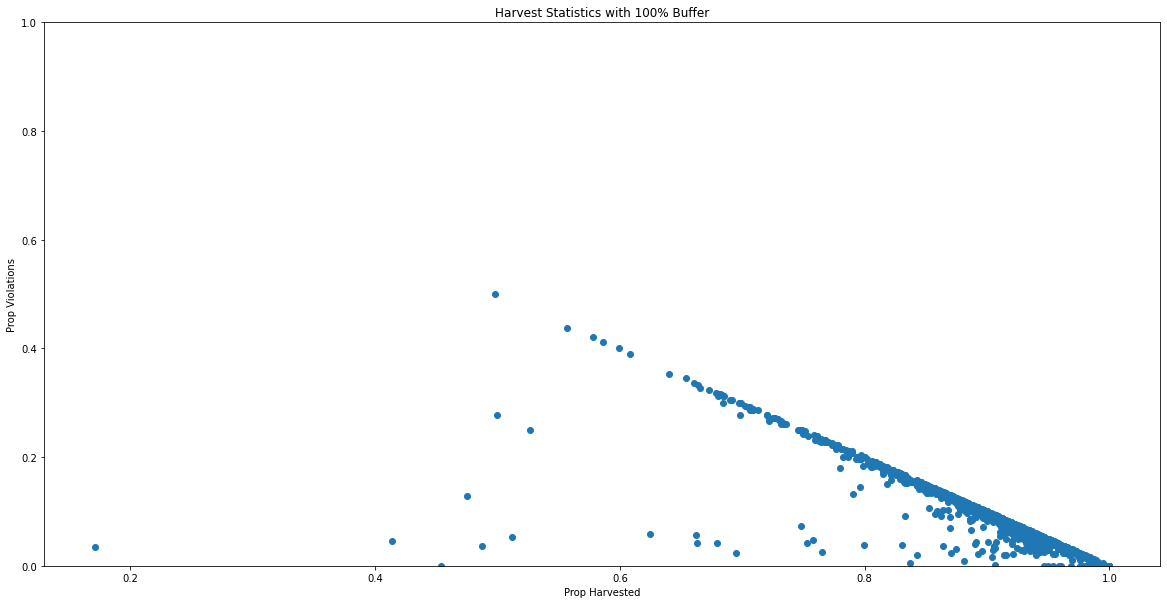

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.903704         0.085598
std          0.081721         0.072669
min          0.171011         0.000000
25%          0.868439         0.030969
50%          0.916870         0.074480
75%          0.958855         0.123955
max          1.000000         0.500000


In [36]:
model_results_dfs['es'] = get_model_results(max_cpu_3_dir, 5, "es")

                 id  train_mase_ar  test_mase_ar  under_mase_ar  \
count  1.432000e+03    1432.000000   1432.000000    1432.000000   
mean   3.708082e+11       0.869414      1.579622       1.064597   
std    7.680769e+10       0.208855      3.745821       0.644393   
min    1.950000e+02       0.000000      0.000000       0.000000   
25%    3.807102e+11       0.794786      0.904430       0.642924   
50%    3.835432e+11       0.844796      1.191897       0.949826   
75%    3.961267e+11       0.918850      1.769950       1.350437   
max    4.004415e+11       4.813378    136.539925       4.917170   

       prop_under_preds_ar  max_under_pred_ar  over_mase_ar  \
count          1432.000000       1.406000e+03   1432.000000   
mean              0.666314       7.710672e+03      0.515025   
std               0.275776       1.000785e+05      3.782997   
min               0.000000       1.426298e-02      0.000000   
25%               0.500000       4.513136e+00      0.015405   
50%               

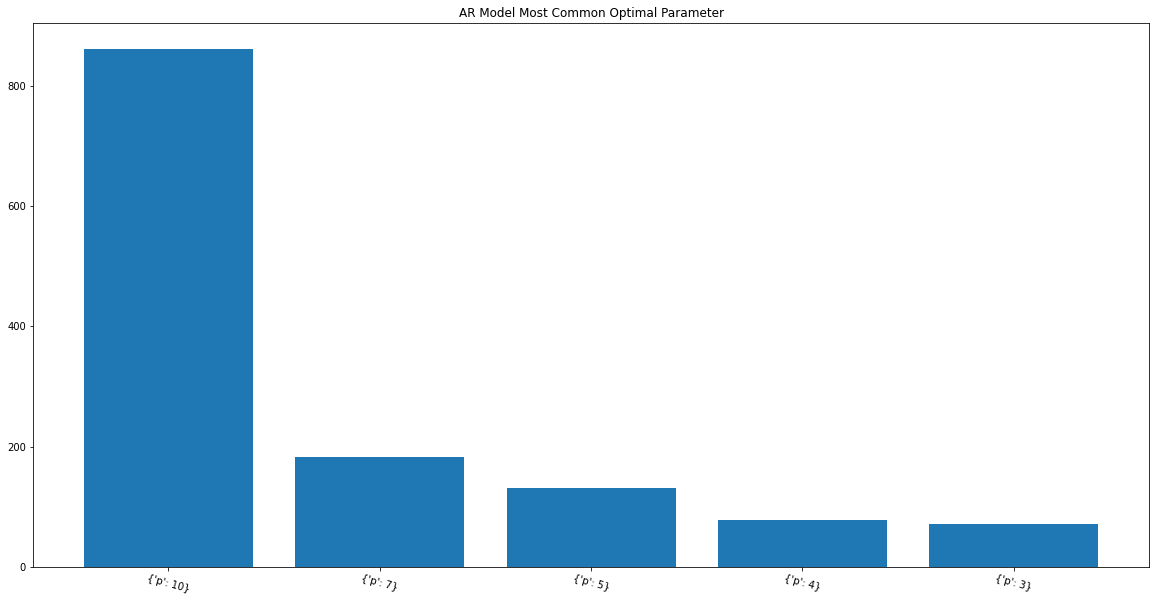

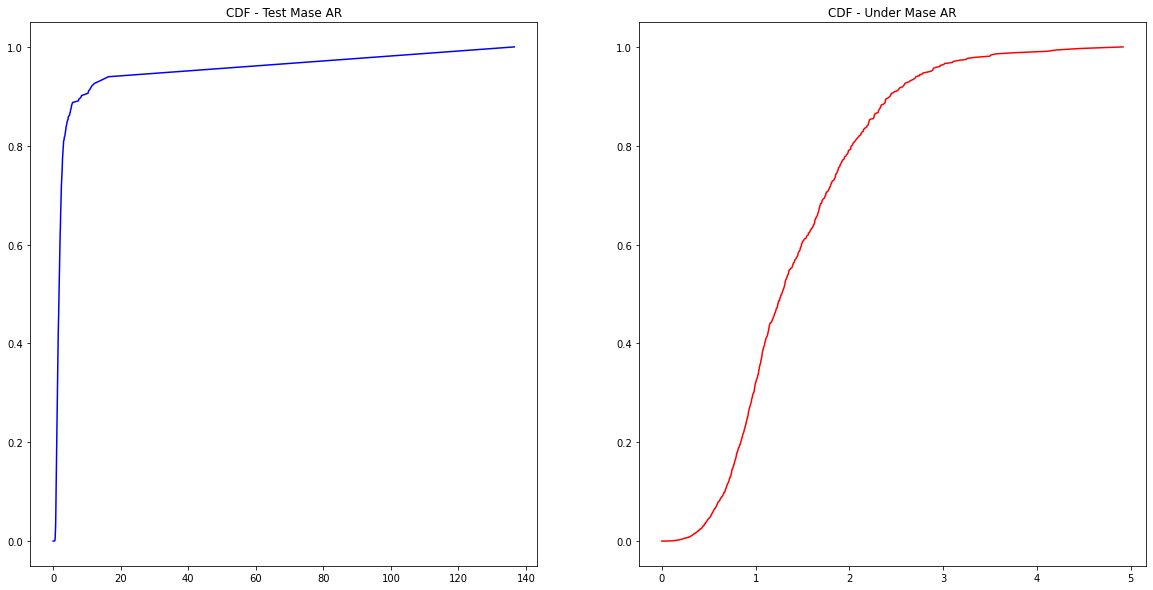

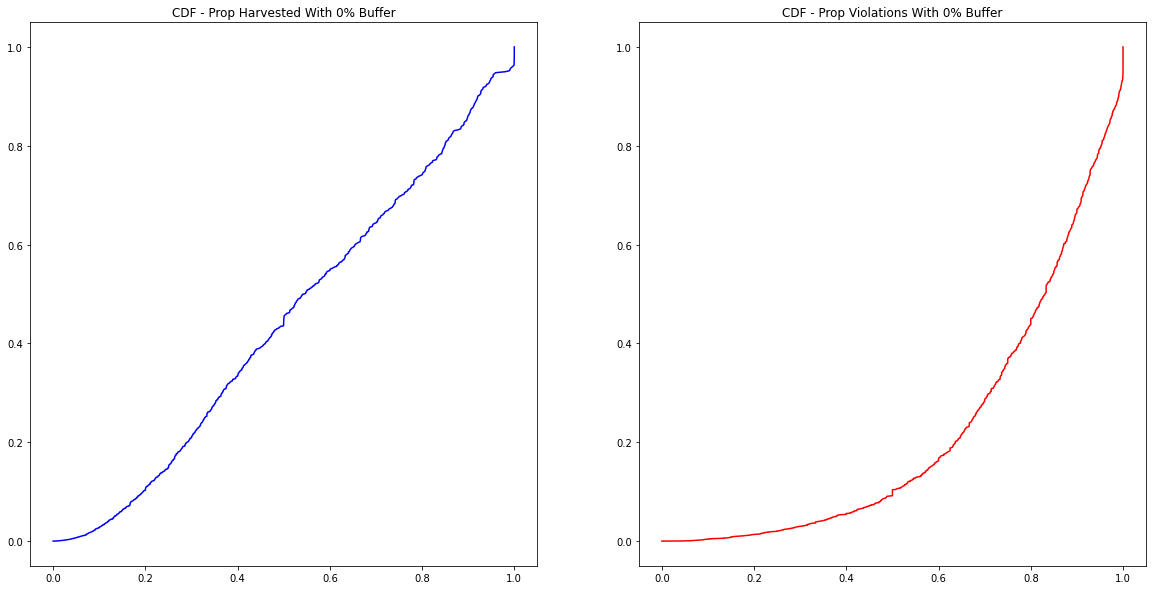

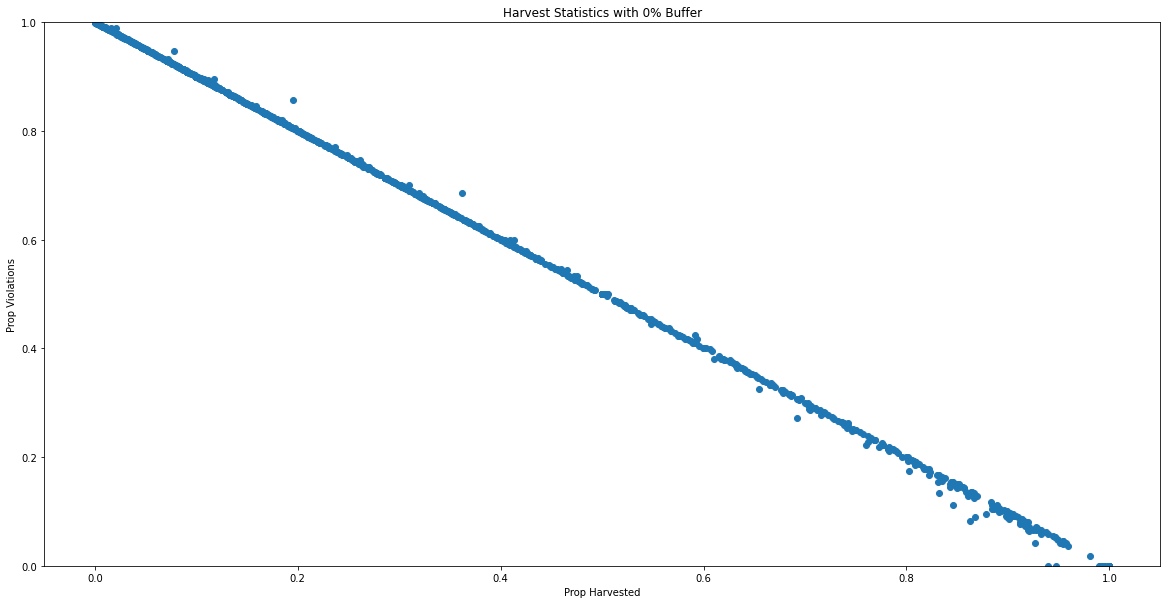

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.333501         0.666314
std          0.274402         0.275776
min          0.000000         0.000000
25%          0.111195         0.500000
50%          0.264268         0.736035
75%          0.500068         0.891451
max          1.000000         1.000000


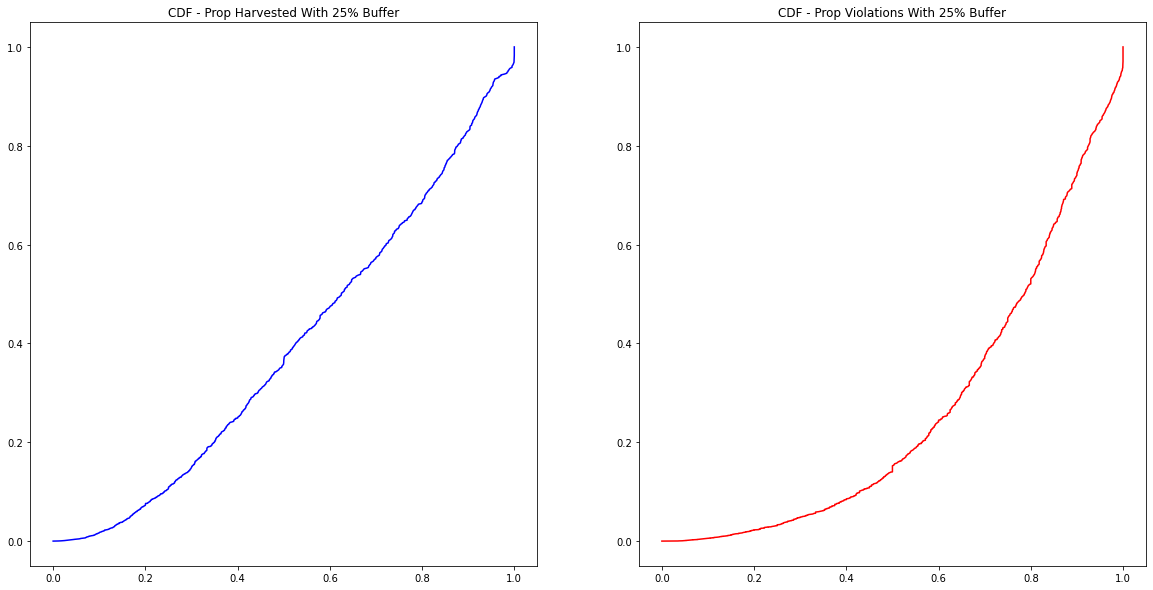

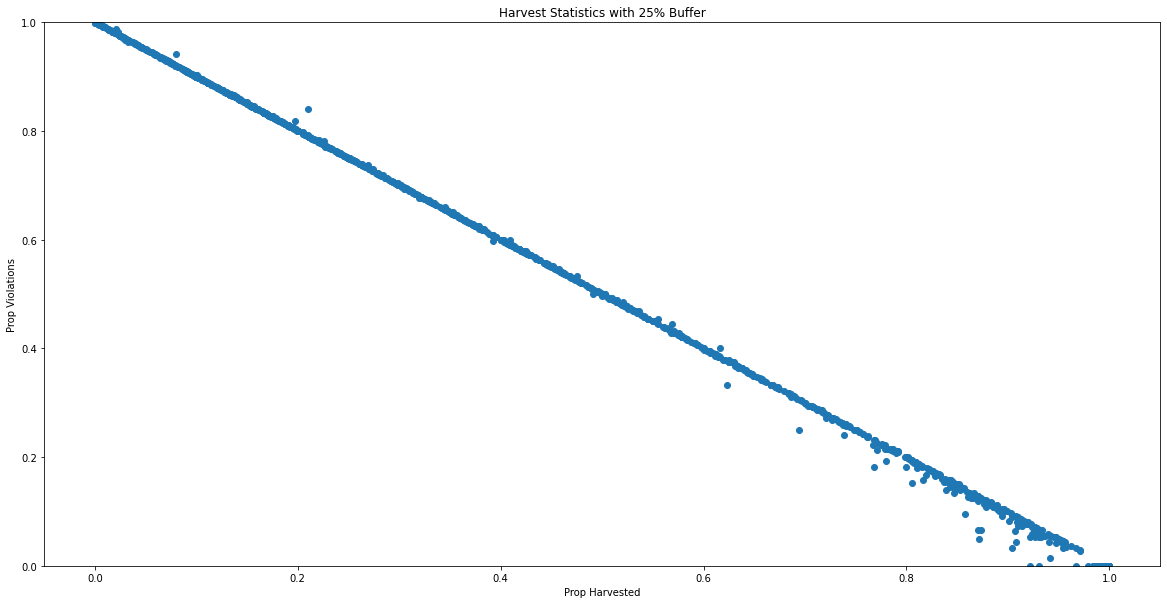

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.404870         0.594246
std          0.287564         0.289776
min          0.000000         0.000000
25%          0.164948         0.378575
50%          0.351329         0.649324
75%          0.622081         0.836352
max          1.000000         1.000000


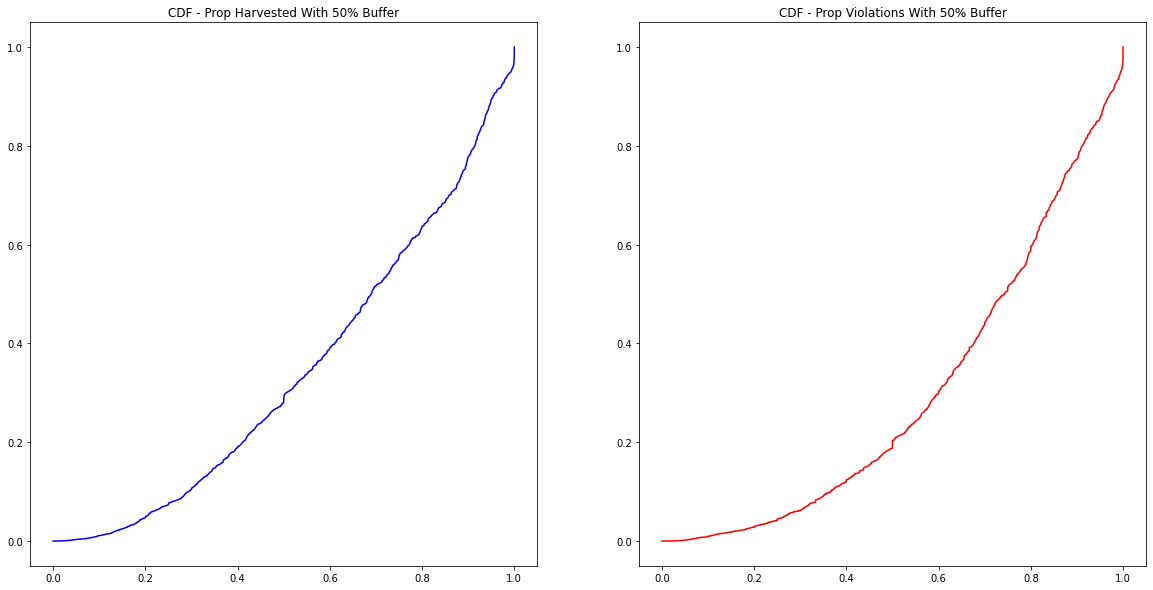

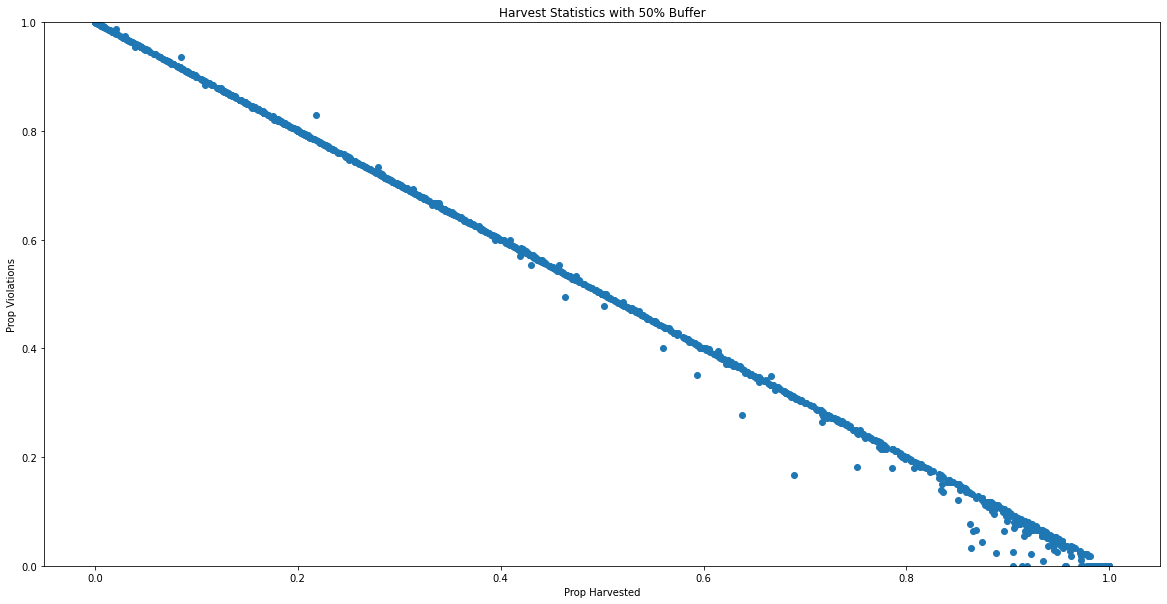

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.468180         0.530044
std          0.298243         0.301218
min          0.000000         0.000000
25%          0.206984         0.277397
50%          0.436751         0.562707
75%          0.718977         0.793743
max          1.000000         1.000000


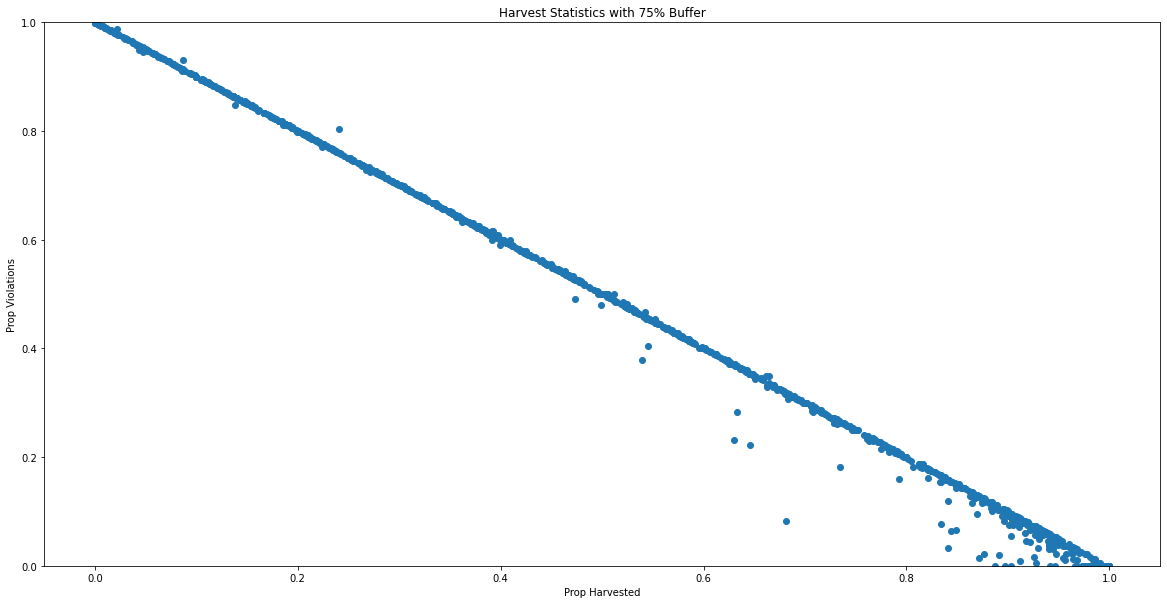

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.518386         0.478853
std          0.302814         0.306444
min          0.000000         0.000000
25%          0.261285         0.209761
50%          0.522416         0.479130
75%          0.788371         0.738828
max          1.000000         1.000000


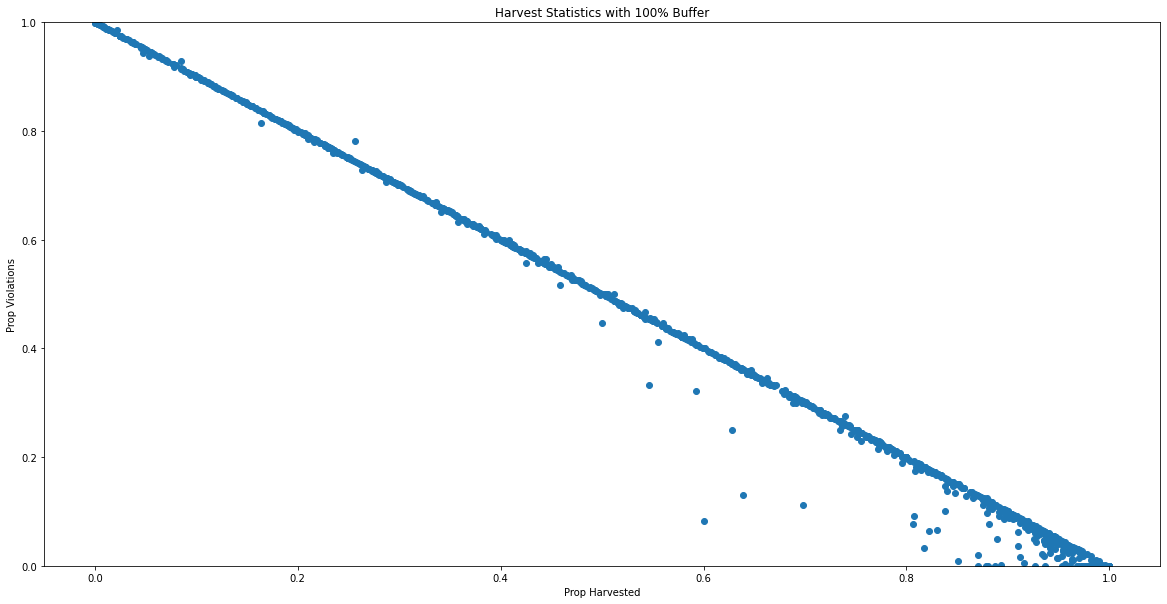

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.557042         0.439162
std          0.305542         0.309722
min          0.000000         0.000000
25%          0.296291         0.160000
50%          0.578722         0.421053
75%          0.832940         0.703564
max          1.000000         1.000000


In [37]:
model_results_dfs['ar'] = get_model_results(max_cpu_3_dir, 5, "ar")

                 id  train_mase_reg  test_mase_reg  under_mase_reg  \
count  1.432000e+03     1432.000000    1432.000000     1432.000000   
mean   3.708082e+11        0.946382       5.386473        1.131747   
std    7.680769e+10        0.310929      13.639466        3.278639   
min    1.950000e+02        0.000000       0.000000        0.000000   
25%    3.807102e+11        0.787654       1.094387        0.223424   
50%    3.835432e+11        0.875320       2.285027        0.388293   
75%    3.961267e+11        1.046736       5.229262        0.670564   
max    4.004415e+11        2.997489     339.501332       58.814878   

       prop_under_preds_reg  max_under_pred_reg  over_mase_reg  \
count           1432.000000         1328.000000    1432.000000   
mean               0.287460          853.829029       4.254727   
std                0.234100         2638.508103      13.163902   
min                0.000000            0.003359       0.000000   
25%                0.092106            

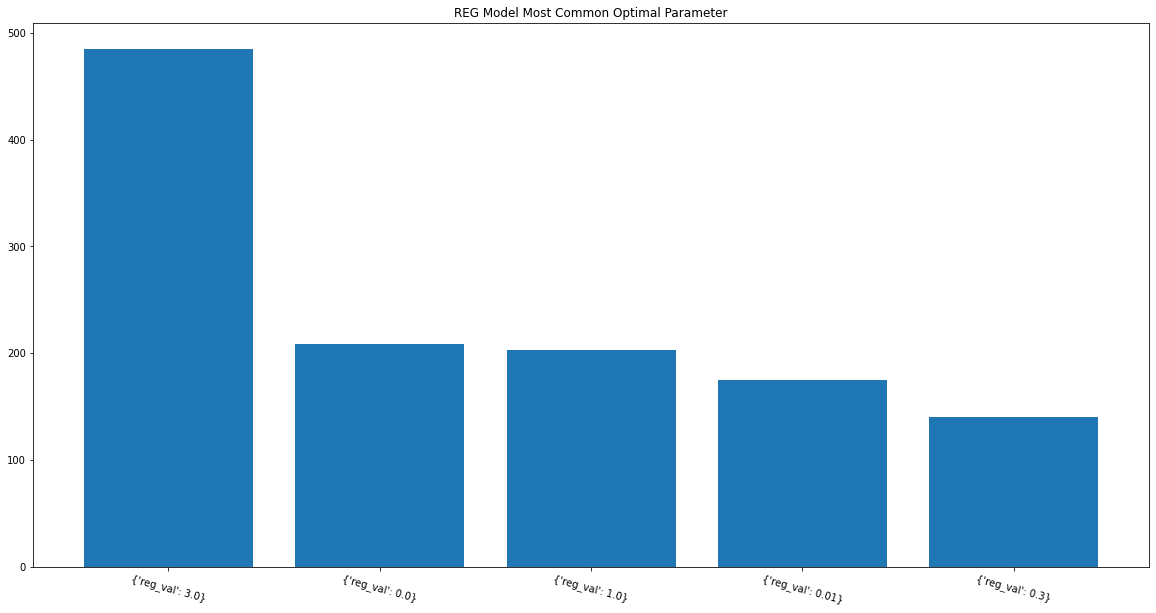

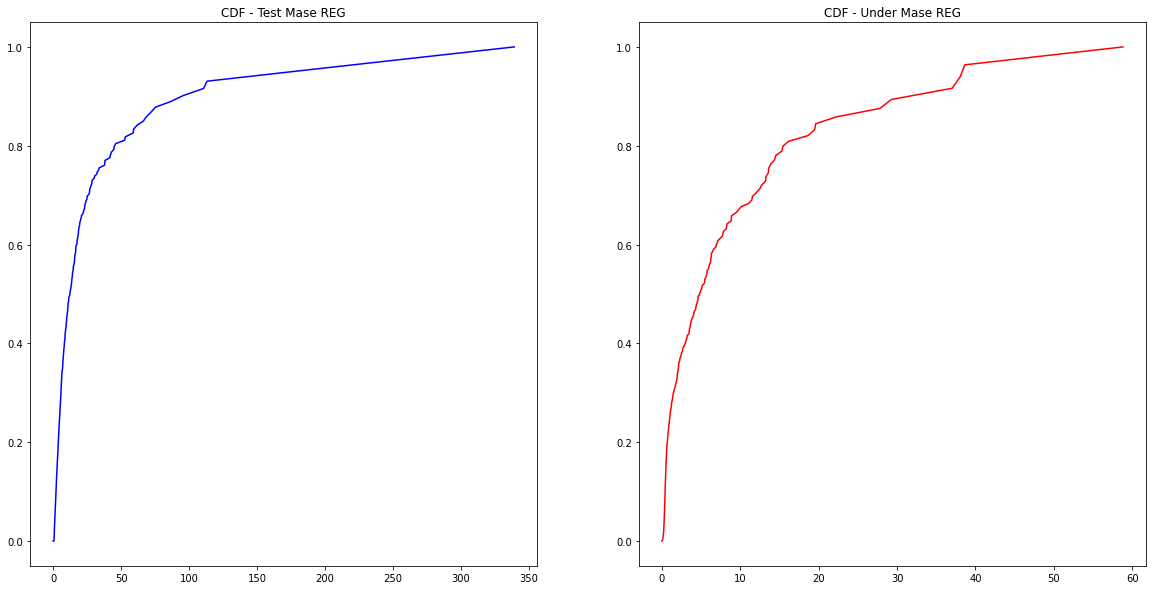

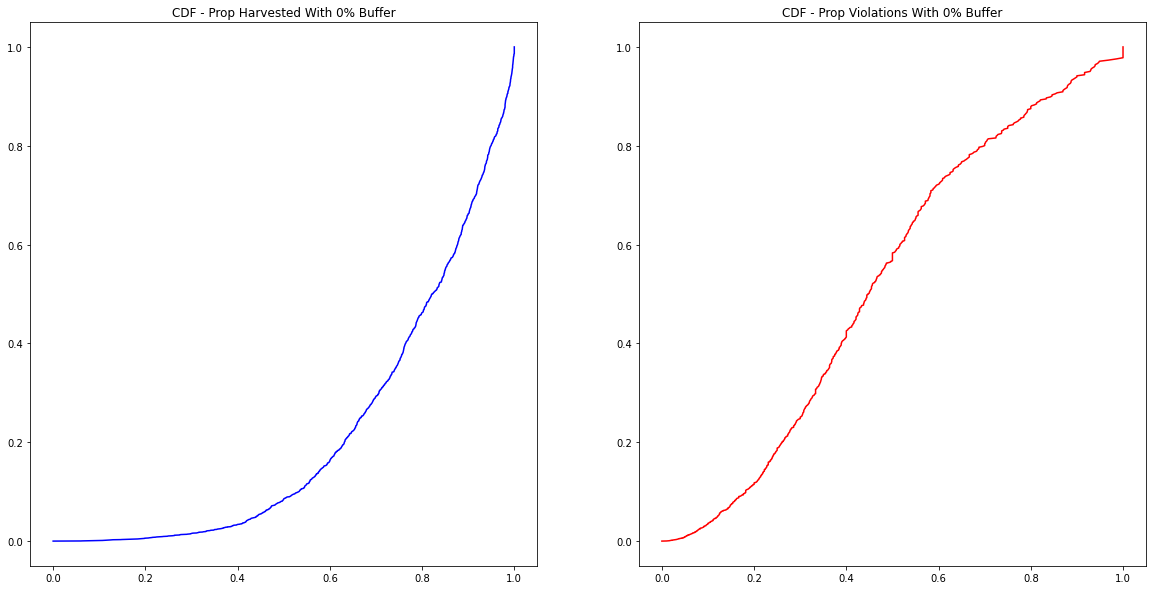

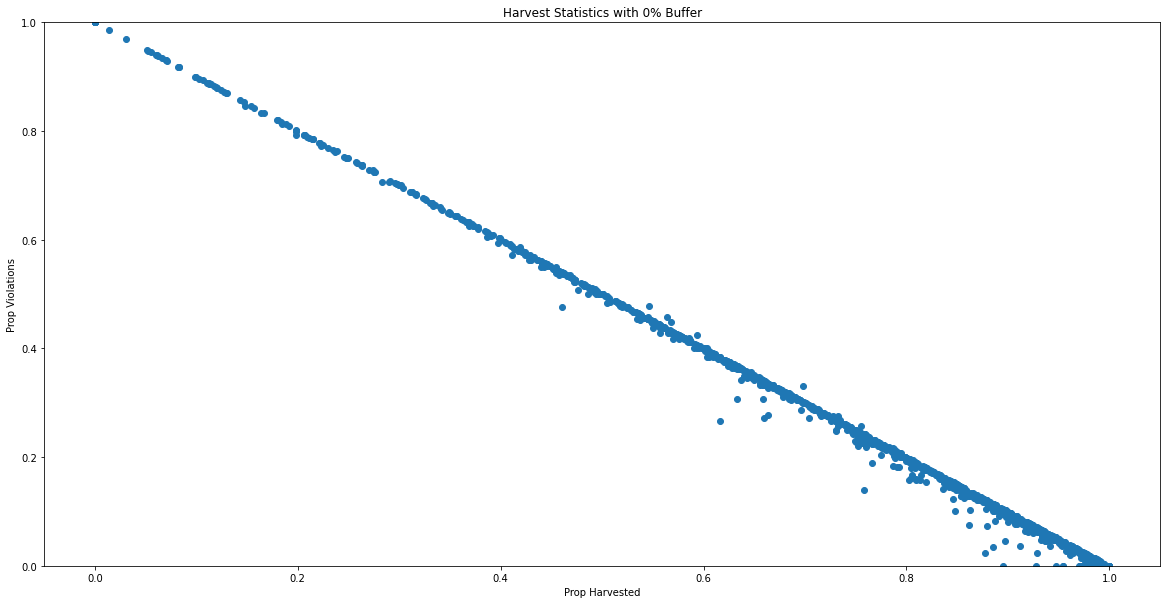

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.708295         0.287460
std          0.231920         0.234100
min          0.000000         0.000000
25%          0.570820         0.092106
50%          0.752823         0.242752
75%          0.899994         0.428571
max          1.000000         1.000000


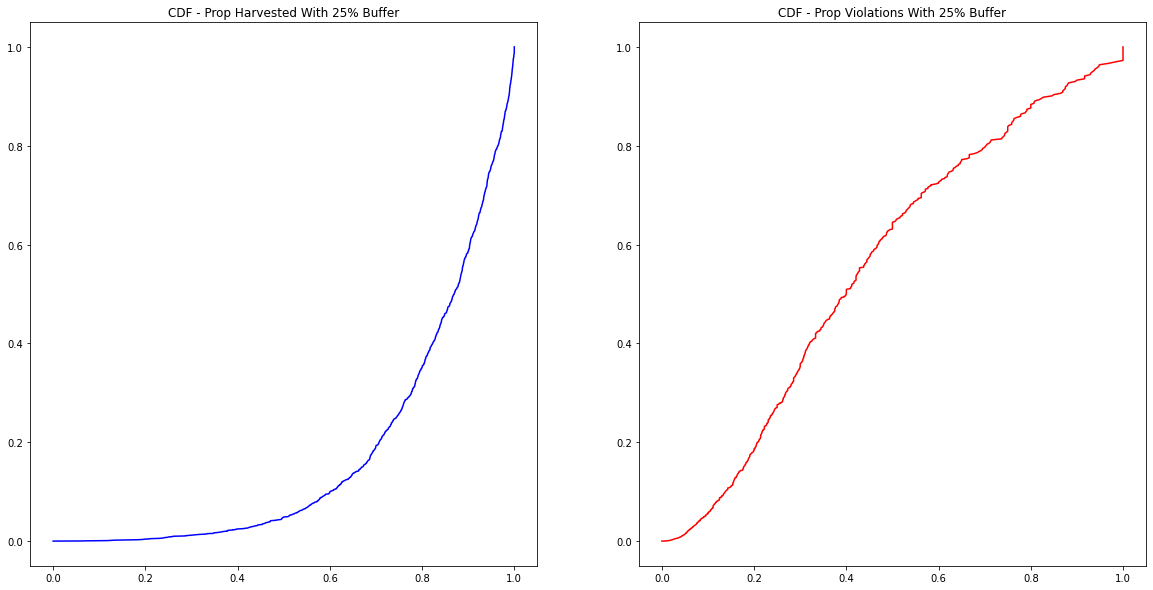

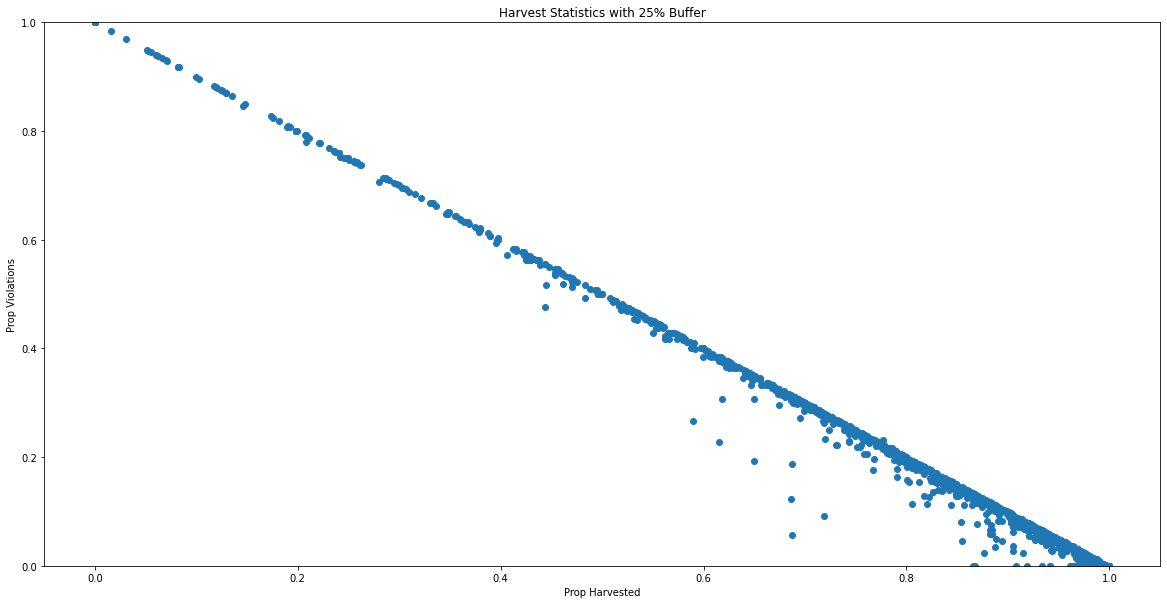

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.761666         0.230652
std          0.219486         0.221931
min          0.000000         0.000000
25%          0.667128         0.058824
50%          0.819128         0.170209
75%          0.930472         0.326205
max          1.000000         1.000000


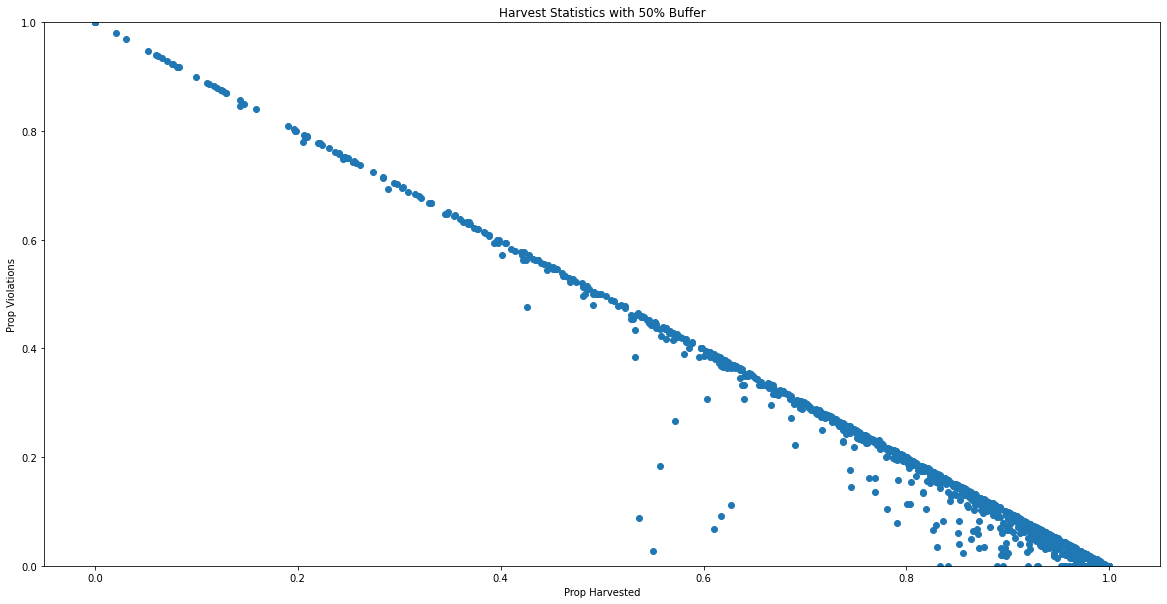

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.790366         0.198381
std          0.214907         0.217456
min          0.000000         0.000000
25%          0.713881         0.039752
50%          0.862620         0.124817
75%          0.946768         0.277852
max          1.000000         1.000000


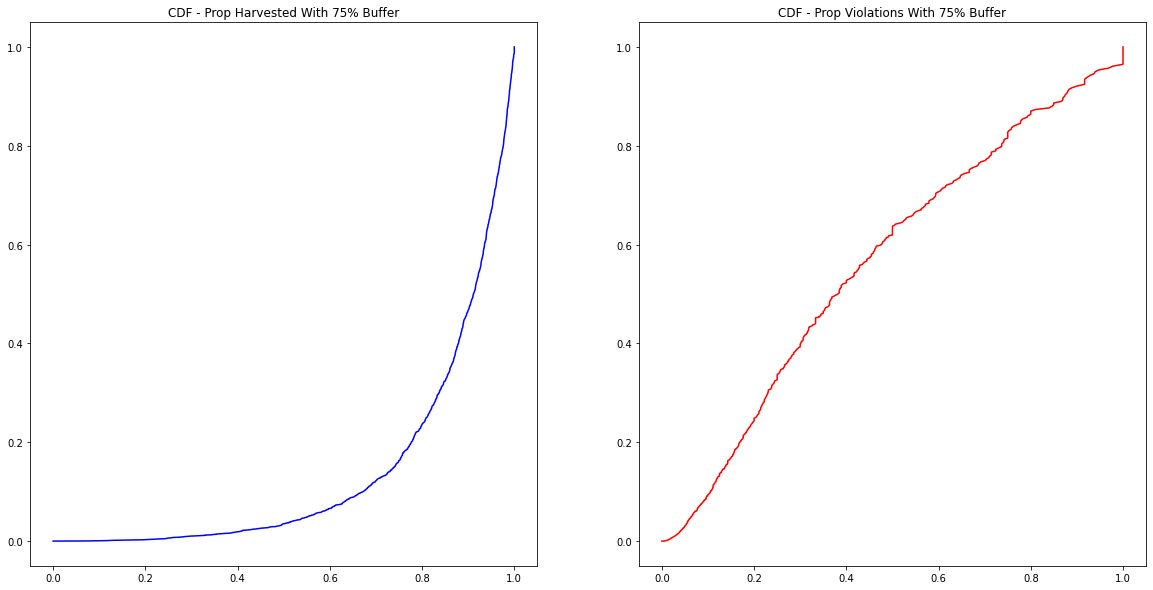

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.806422         0.178771
std          0.212930         0.215065
min          0.000000         0.000000
25%          0.744079         0.027696
50%          0.881388         0.100000
75%          0.955392         0.243668
max          1.000000         1.000000


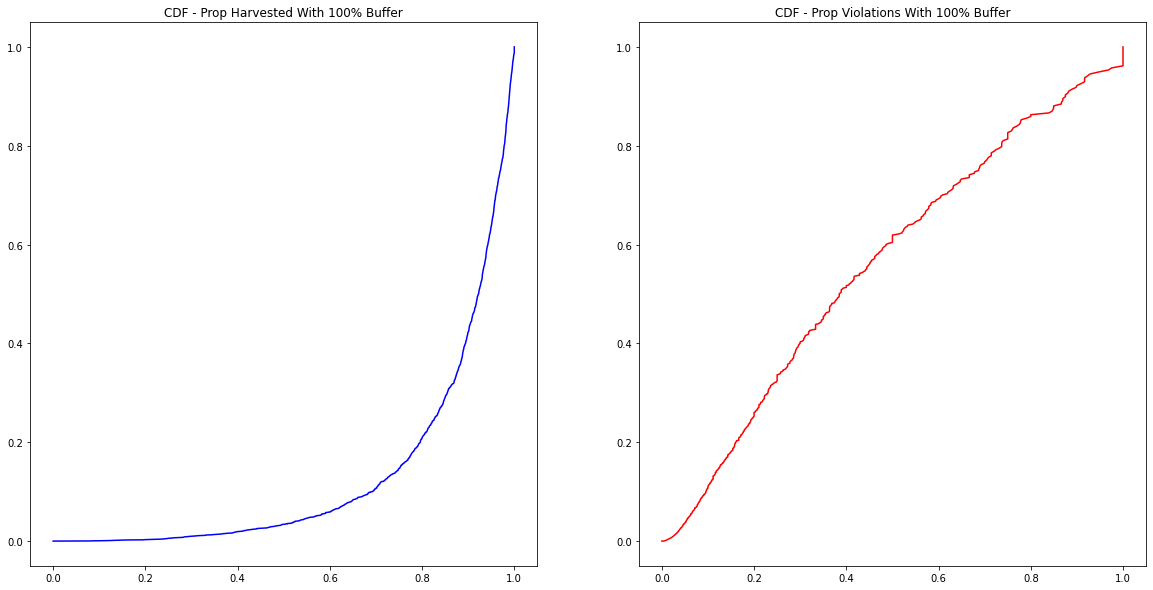

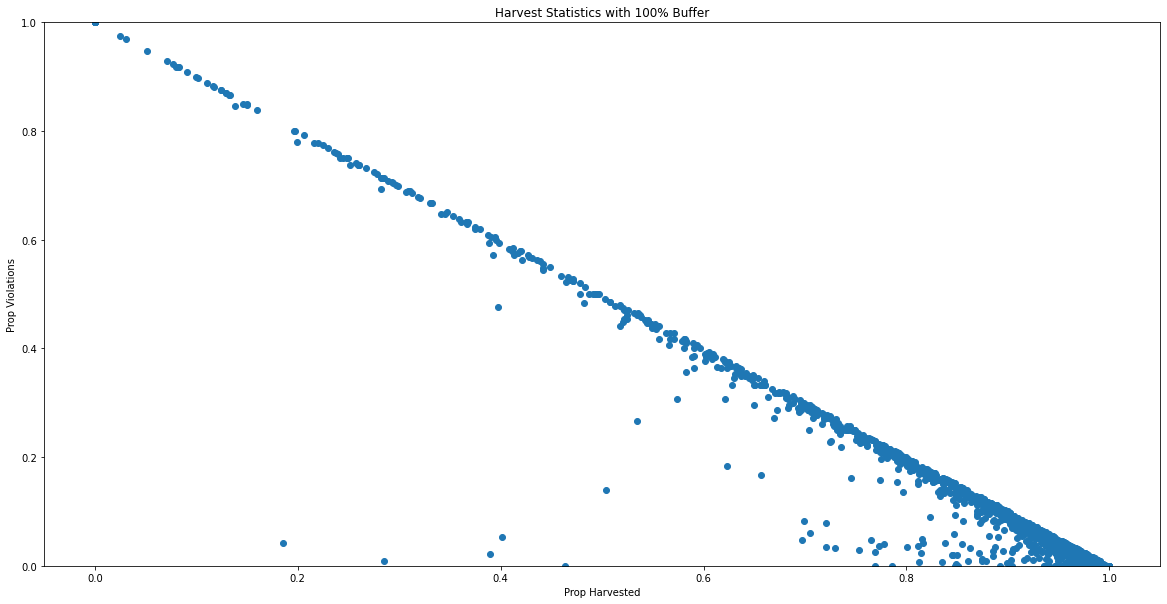

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.817163         0.164464
std          0.212139         0.213451
min          0.000000         0.000000
25%          0.759908         0.019389
50%          0.897749         0.079481
75%          0.959532         0.220704
max          1.000000         1.000000


In [38]:
model_results_dfs['reg'] = get_model_results(max_cpu_3_dir, 5, "reg")

                 id  train_mase_svm  test_mase_svm  under_mase_svm  \
count  1.432000e+03     1432.000000    1432.000000     1432.000000   
mean   3.708082e+11        0.899994       1.268713        0.451695   
std    7.680769e+10        0.216430       3.083823        0.452506   
min    1.950000e+02        0.000000       0.000000        0.000000   
25%    3.807102e+11        0.810000       0.876217        0.309297   
50%    3.835432e+11        0.880683       0.972568        0.438896   
75%    3.961267e+11        0.967963       1.151746        0.538977   
max    4.004415e+11        3.270663     105.698051       14.080549   

       prop_under_preds_svm  max_under_pred_svm  over_mase_svm  \
count           1432.000000         1409.000000    1432.000000   
mean               0.400207          575.093963       0.817019   
std                0.159168         5791.913172       3.091299   
min                0.000000            0.000753       0.000000   
25%                0.315414            

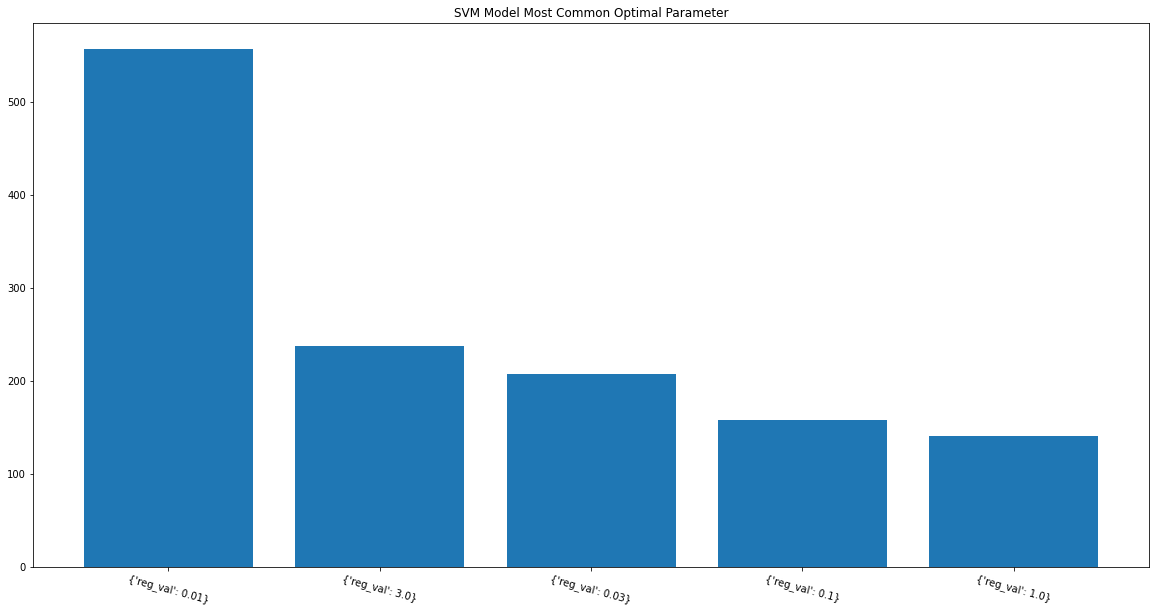

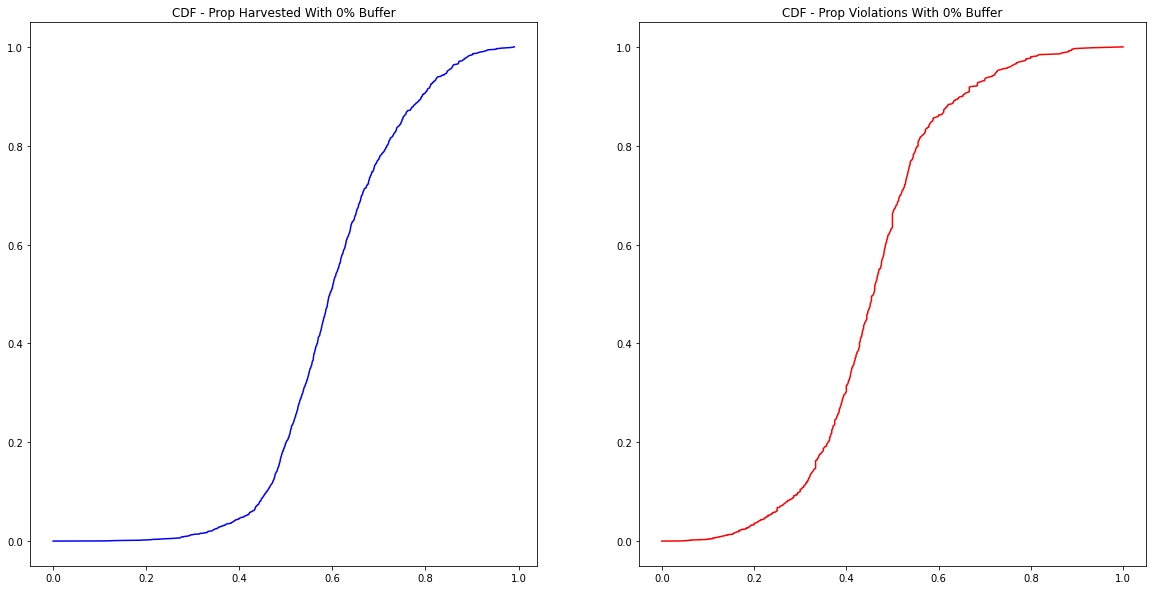

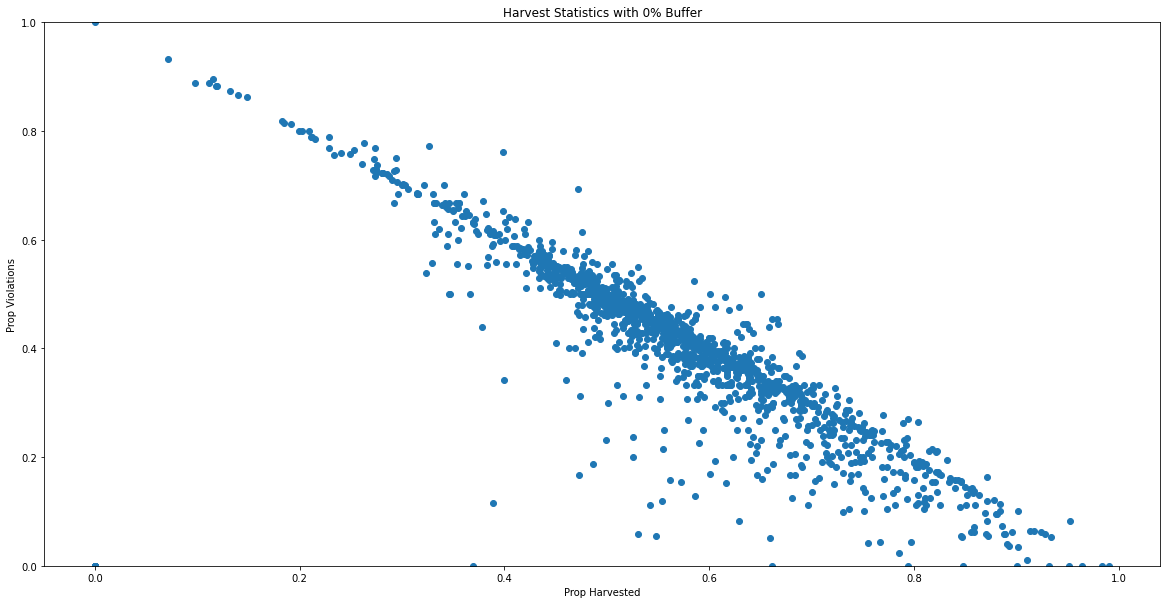

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.569162         0.400207
std          0.147750         0.159168
min          0.000000         0.000000
25%          0.490209         0.315414
50%          0.568759         0.412068
75%          0.653476         0.498354
max          0.990930         1.000000


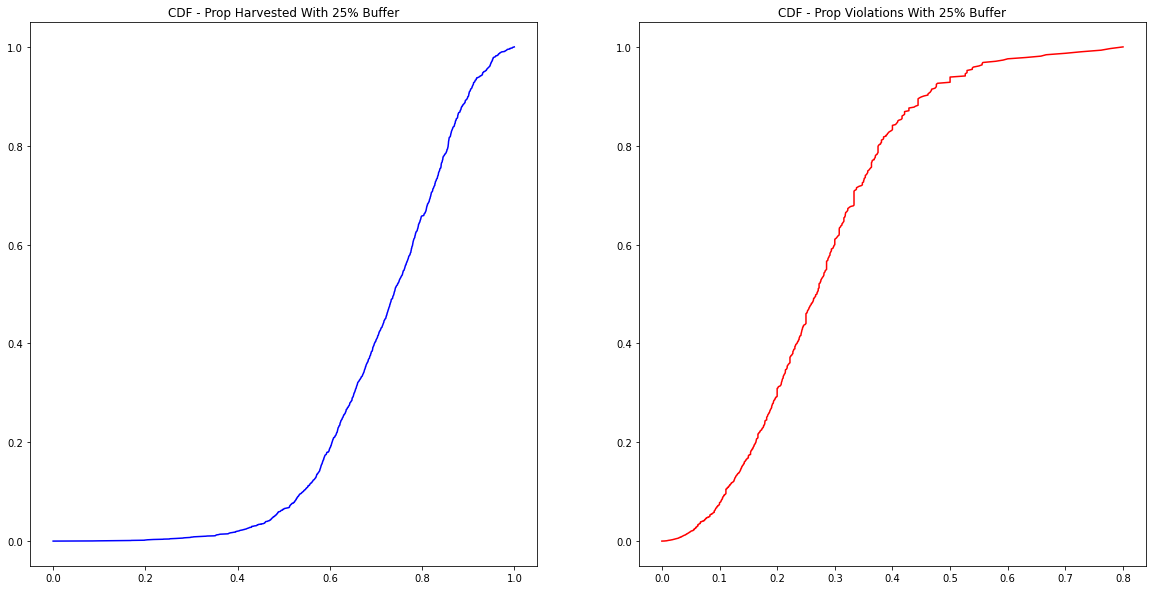

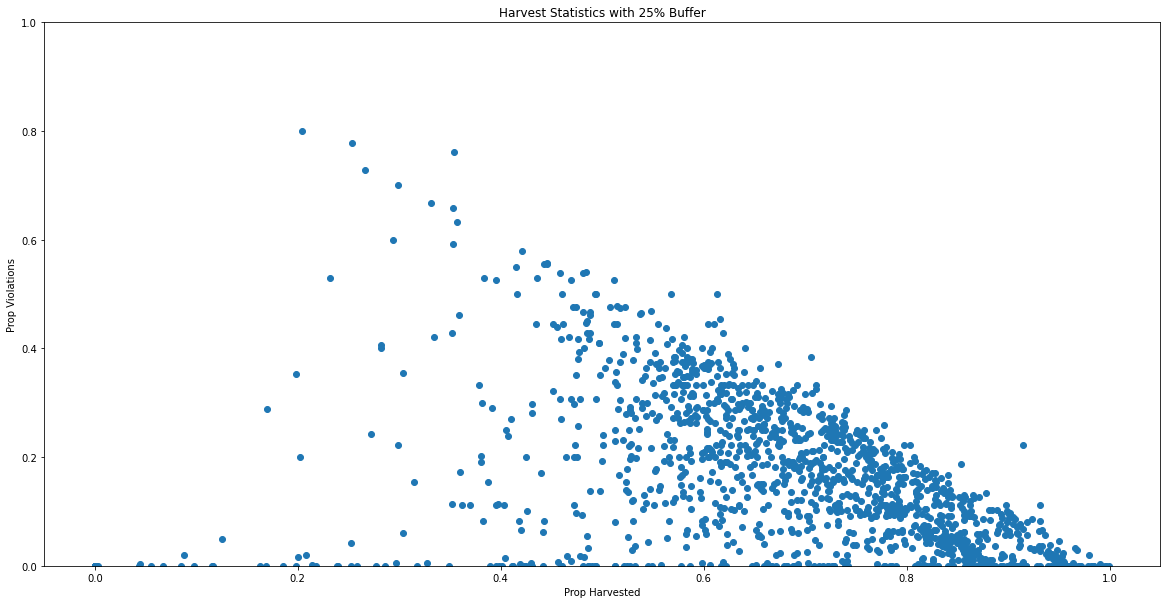

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.679803         0.165959
std          0.177894         0.137446
min          0.000000         0.000000
25%          0.586506         0.049422
50%          0.697248         0.146595
75%          0.810609         0.252712
max          0.999812         0.800000


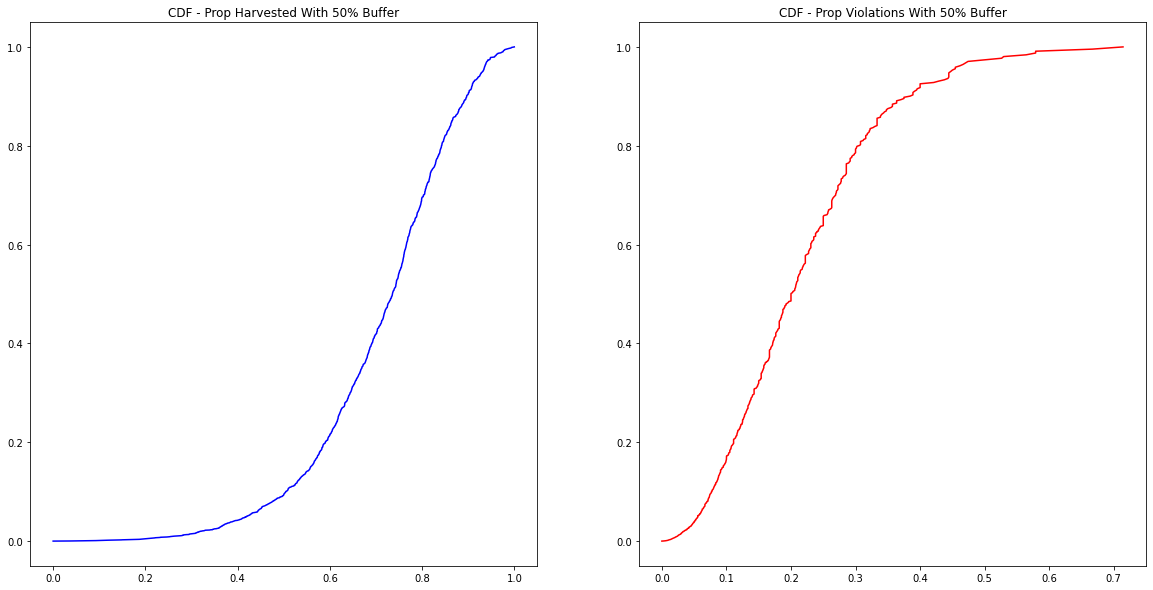

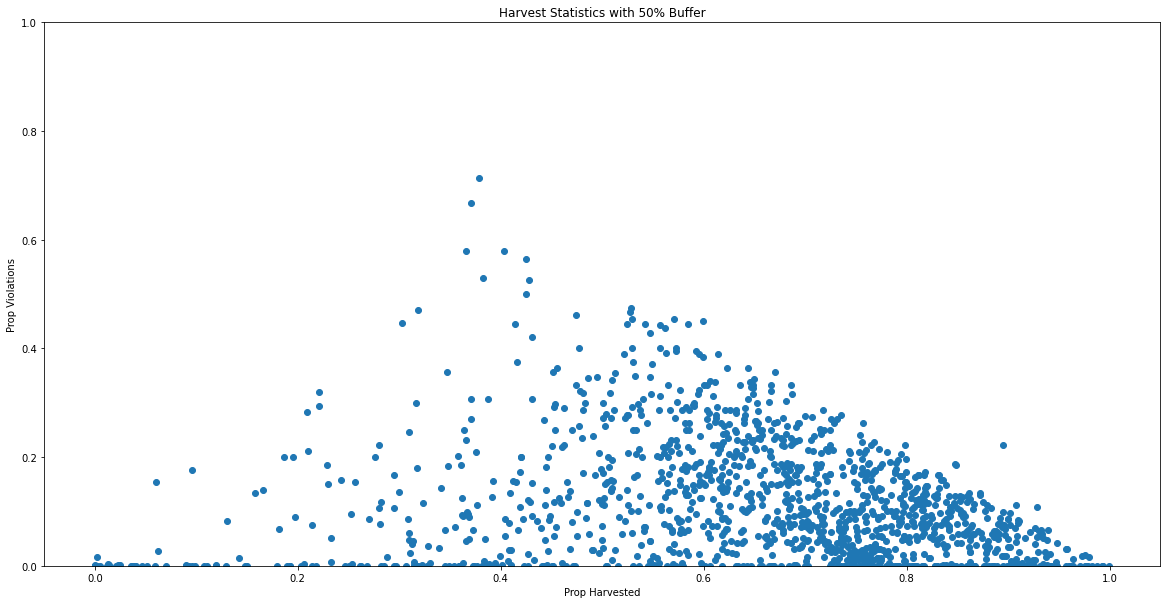

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.633770         0.110797
std          0.221328         0.109236
min          0.000000         0.000000
25%          0.536773         0.015897
50%          0.680030         0.085236
75%          0.788643         0.171973
max          0.999741         0.714286


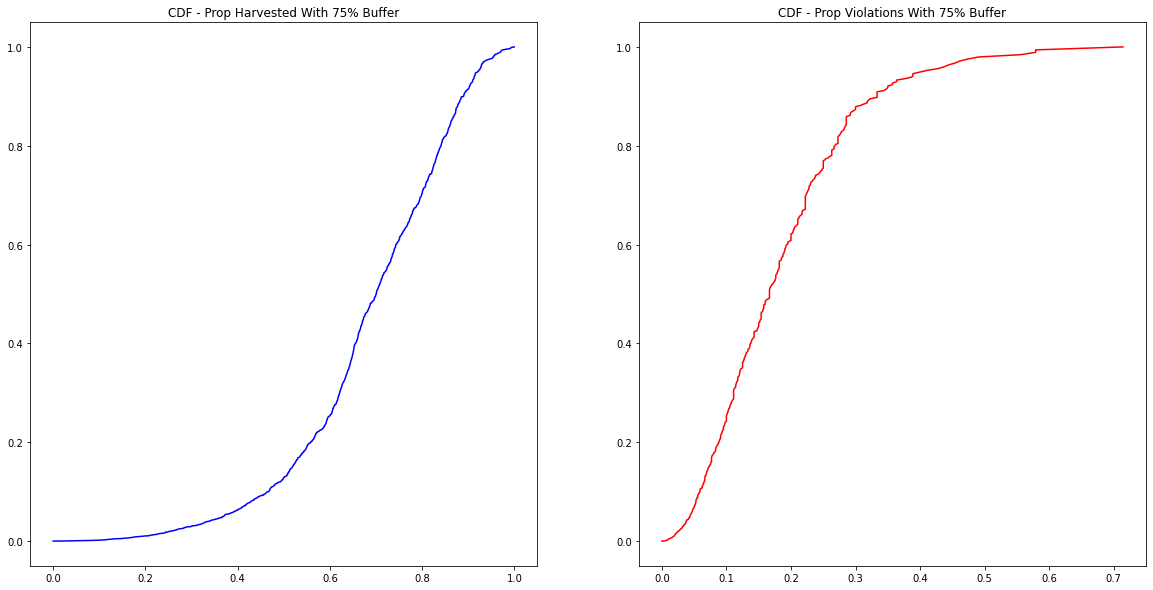

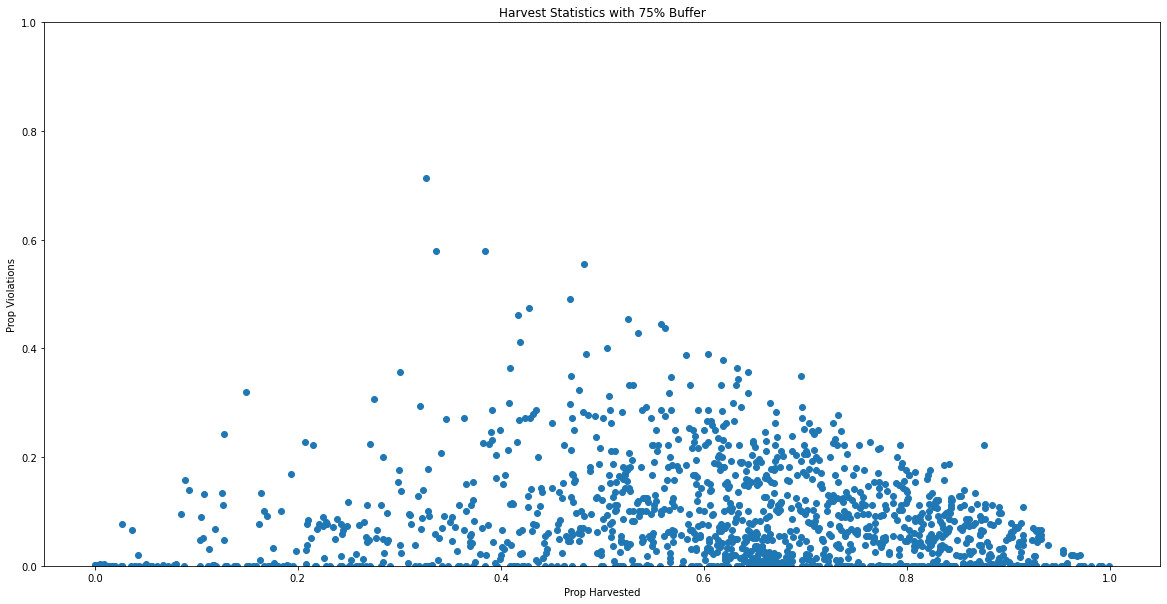

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.580727         0.082951
std          0.248967         0.092390
min          0.000000         0.000000
25%          0.458427         0.004318
50%          0.635681         0.055556
75%          0.763594         0.125000
max          0.999670         0.714286


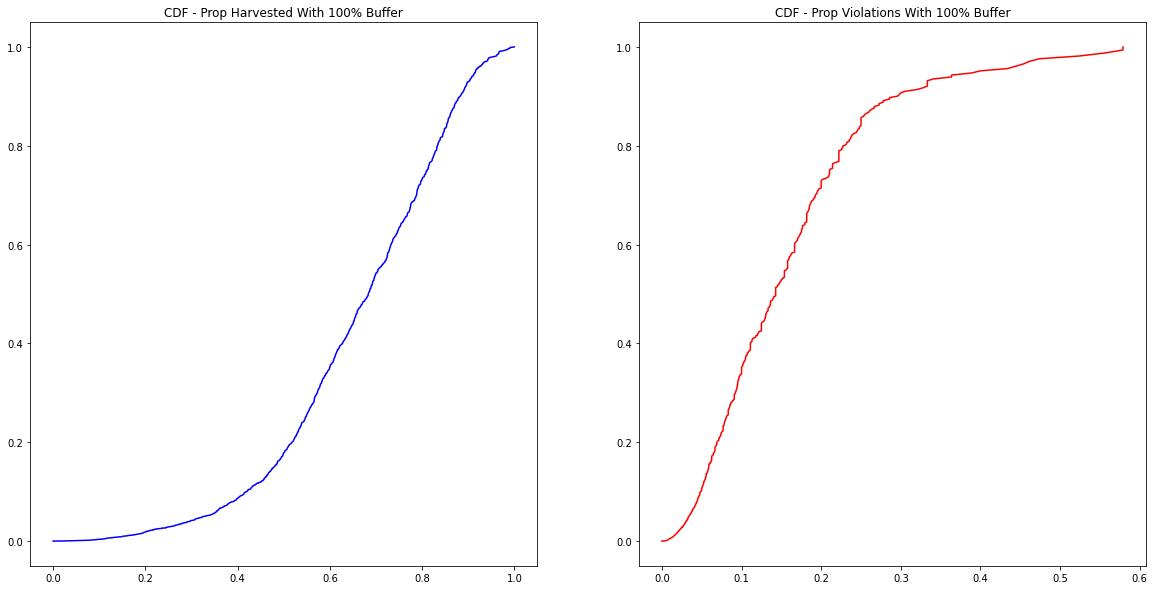

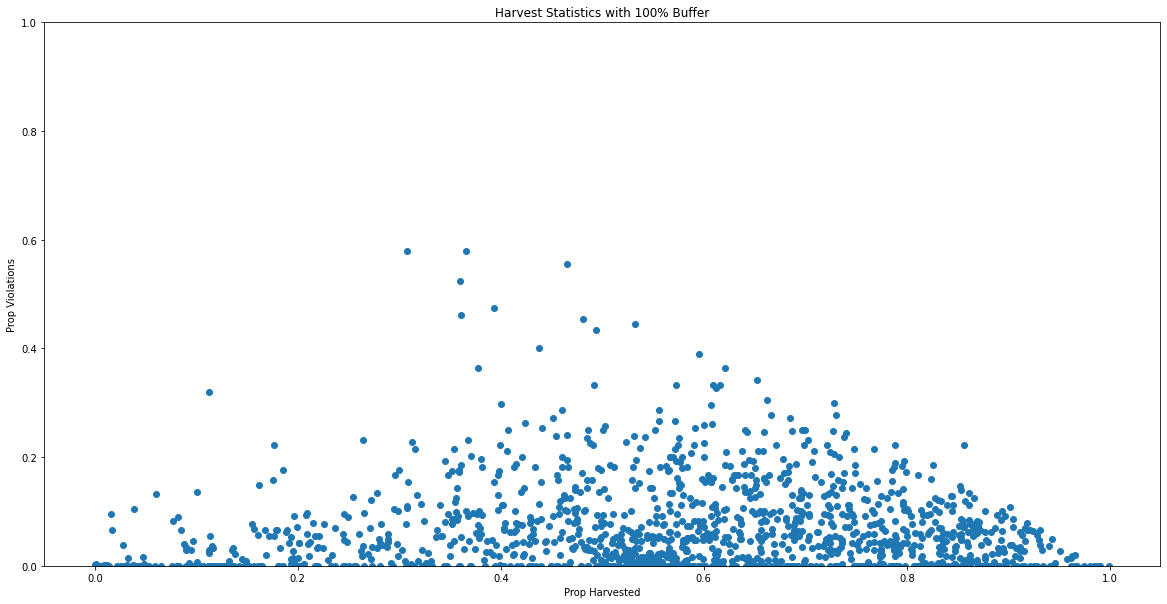

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.532135         0.064915
std          0.264350         0.079660
min          0.000000         0.000000
25%          0.372541         0.000000
50%          0.572878         0.041368
75%          0.736193         0.095238
max          0.999599         0.578947


In [39]:
model_results_dfs['svm'] = get_model_results(max_cpu_3_dir, 5, "svm")

                 id  train_mase_xgb  test_mase_xgb  under_mase_xgb  \
count  1.432000e+03    1.432000e+03   1.432000e+03     1432.000000   
mean   3.708082e+11    3.015039e+00   1.618099e+01        0.112205   
std    7.680769e+10    7.983613e+00   5.274490e+01        0.346860   
min    1.950000e+02    9.114622e-09   9.114622e-09        0.000000   
25%    3.807102e+11    7.663930e-01   2.078992e+00        0.000000   
50%    3.835432e+11    1.562170e+00   4.651990e+00        0.000465   
75%    3.961267e+11    3.189219e+00   1.105327e+01        0.138742   
max    4.004415e+11    2.640119e+02   8.841635e+02       11.042730   

       prop_under_preds_xgb  max_under_pred_xgb  over_mase_xgb  \
count           1432.000000          721.000000    1432.000000   
mean               0.066952           84.083176      16.068787   
std                0.123320          831.787904      52.772753   
min                0.000000            0.001714       0.000000   
25%                0.000000            

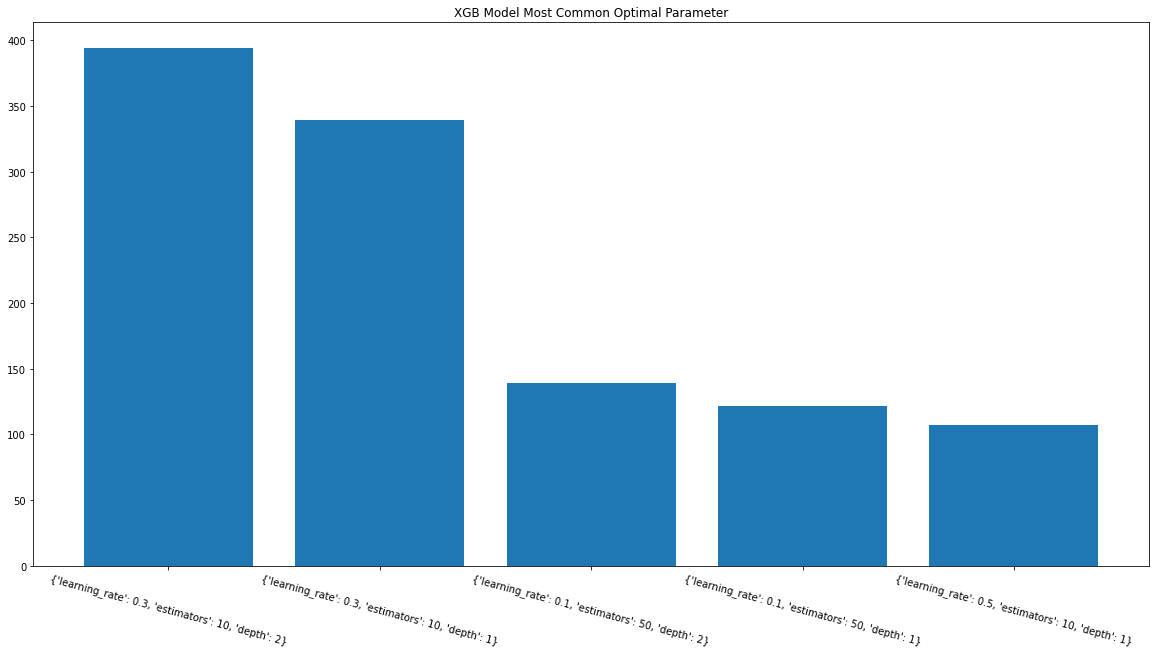

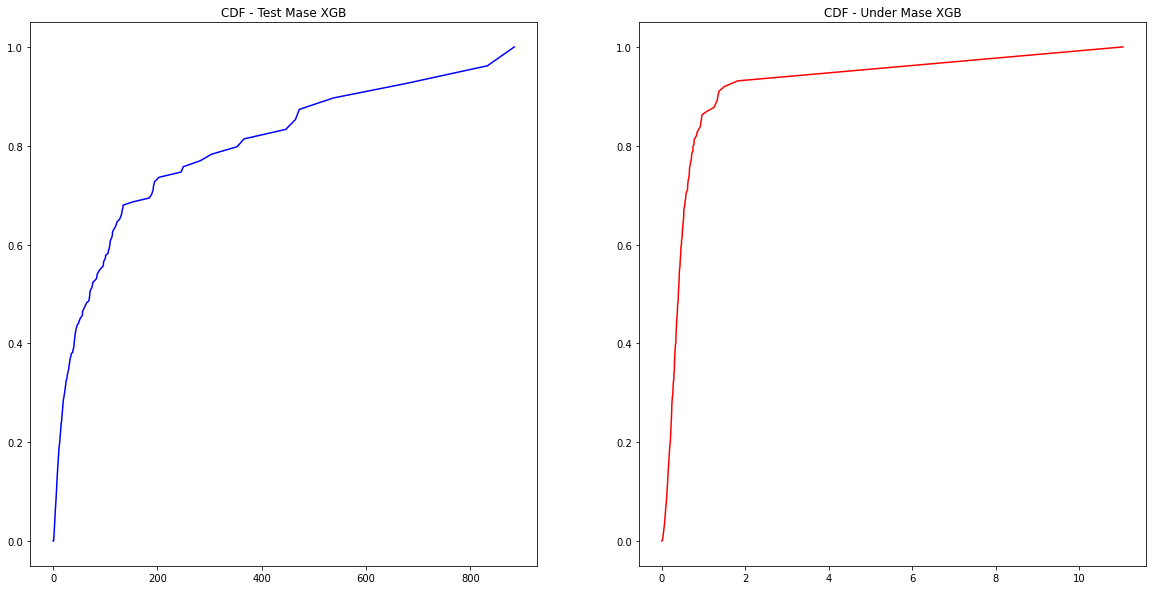

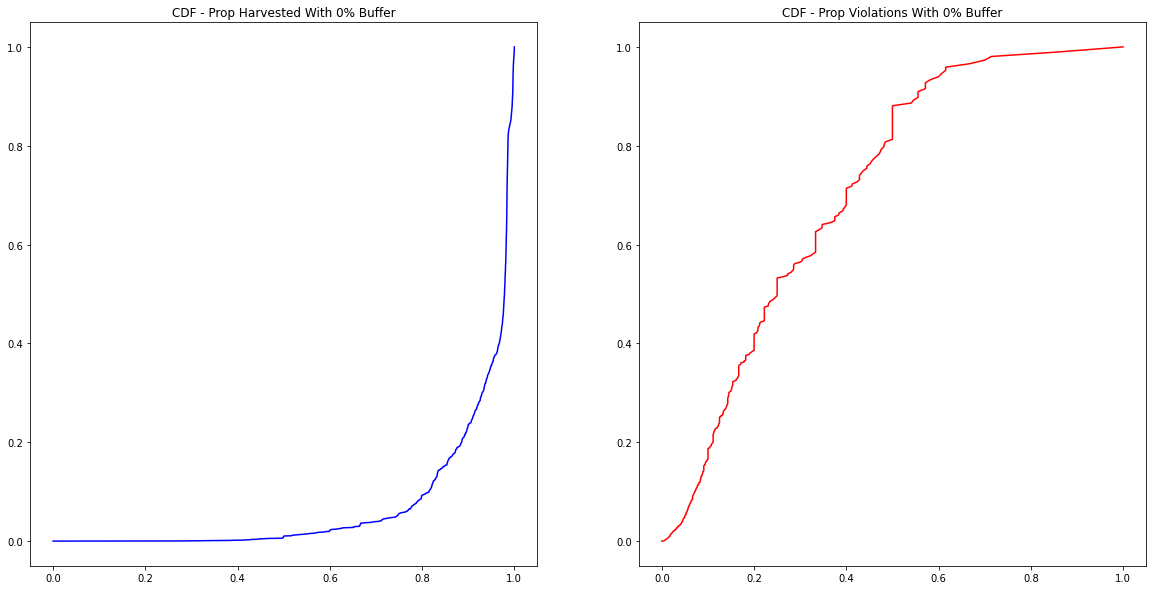

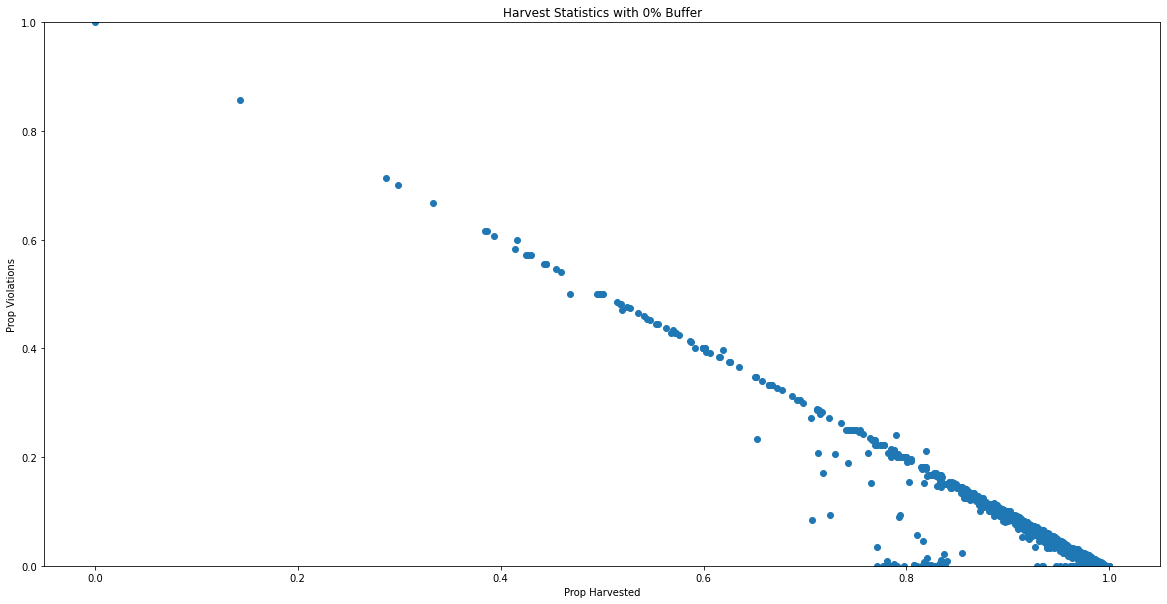

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.915105         0.066952
std          0.121672         0.123320
min          0.000000         0.000000
25%          0.886702         0.000000
50%          0.976226         0.000502
75%          0.984620         0.086025
max          1.000000         1.000000


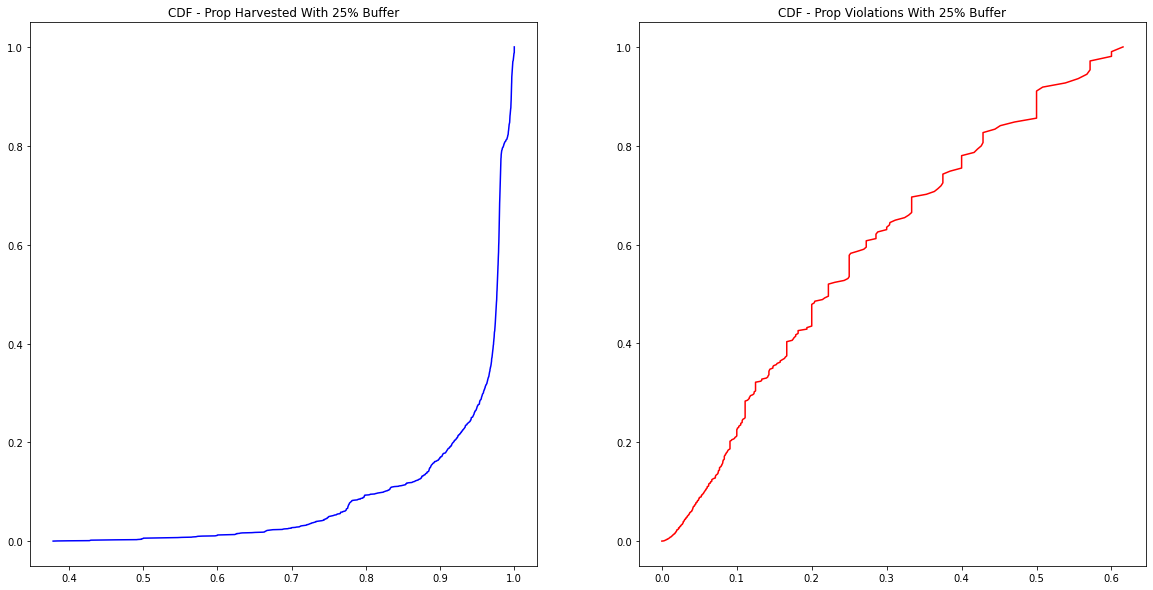

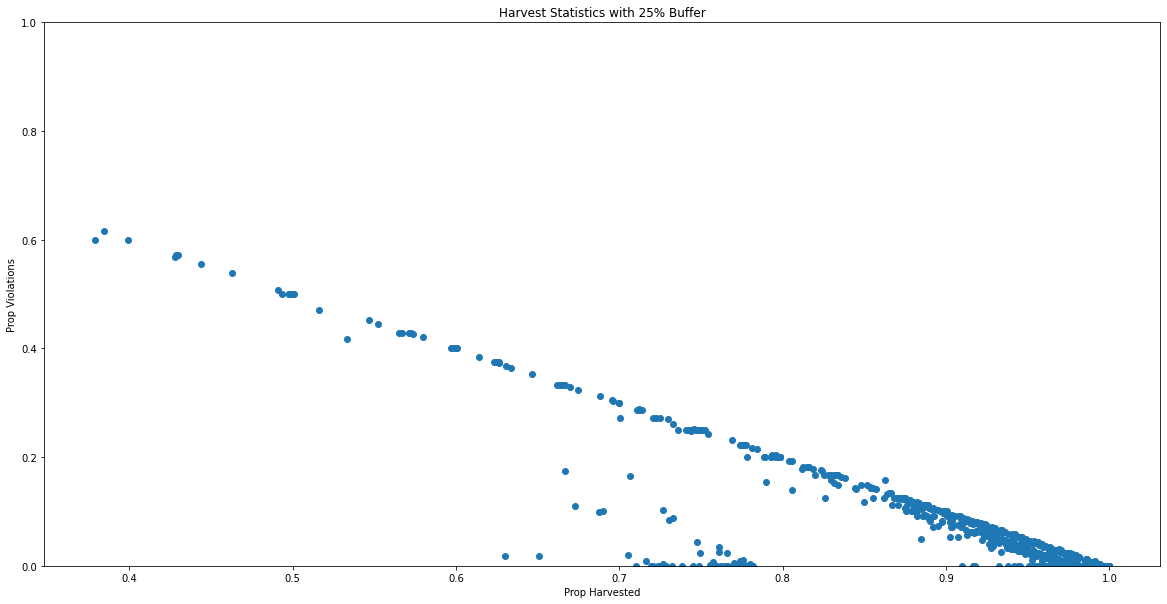

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.930557         0.044567
std          0.101506         0.096863
min          0.378848         0.000000
25%          0.924197         0.000000
50%          0.975579         0.000000
75%          0.981097         0.040551
max          1.000000         0.615385


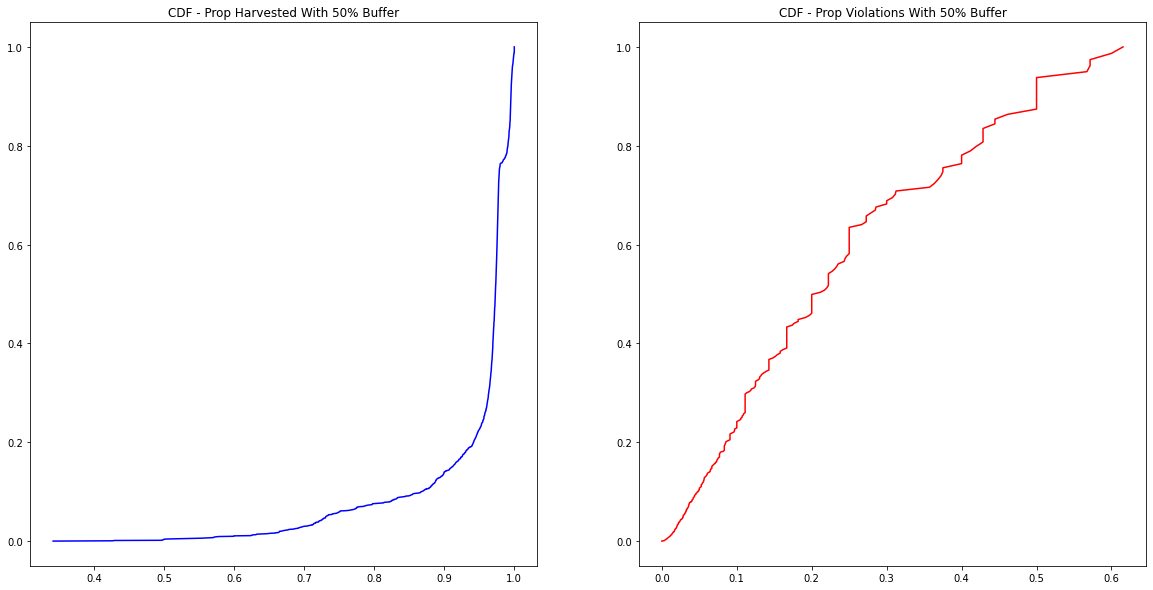

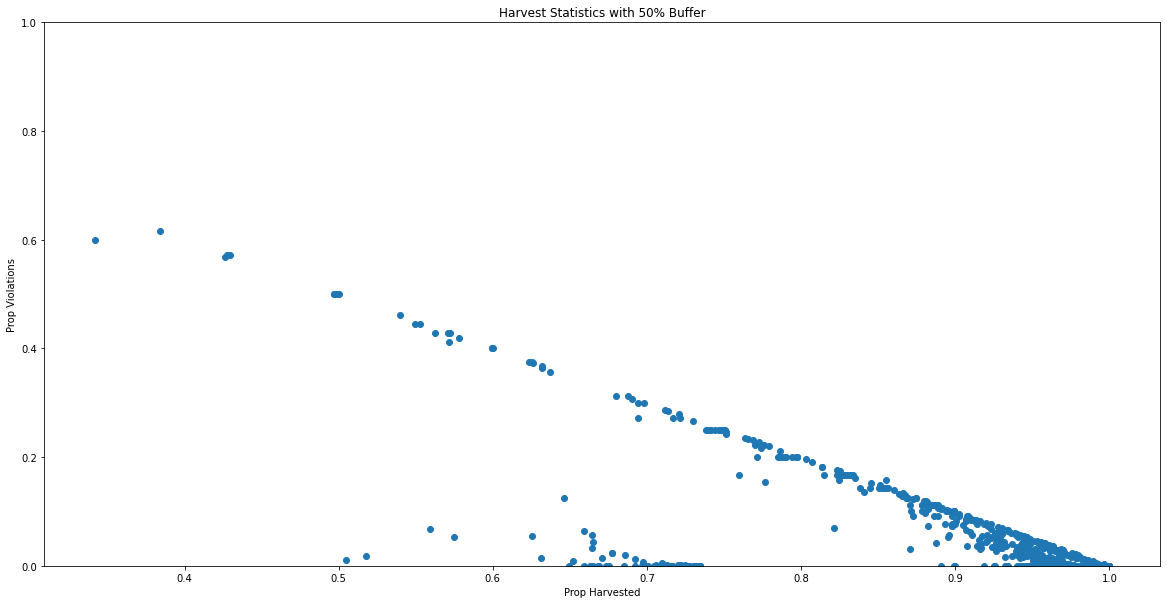

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.935323         0.032891
std          0.097184         0.083127
min          0.341780         0.000000
25%          0.946810         0.000000
50%          0.972226         0.000000
75%          0.978019         0.019093
max          1.000000         0.615385


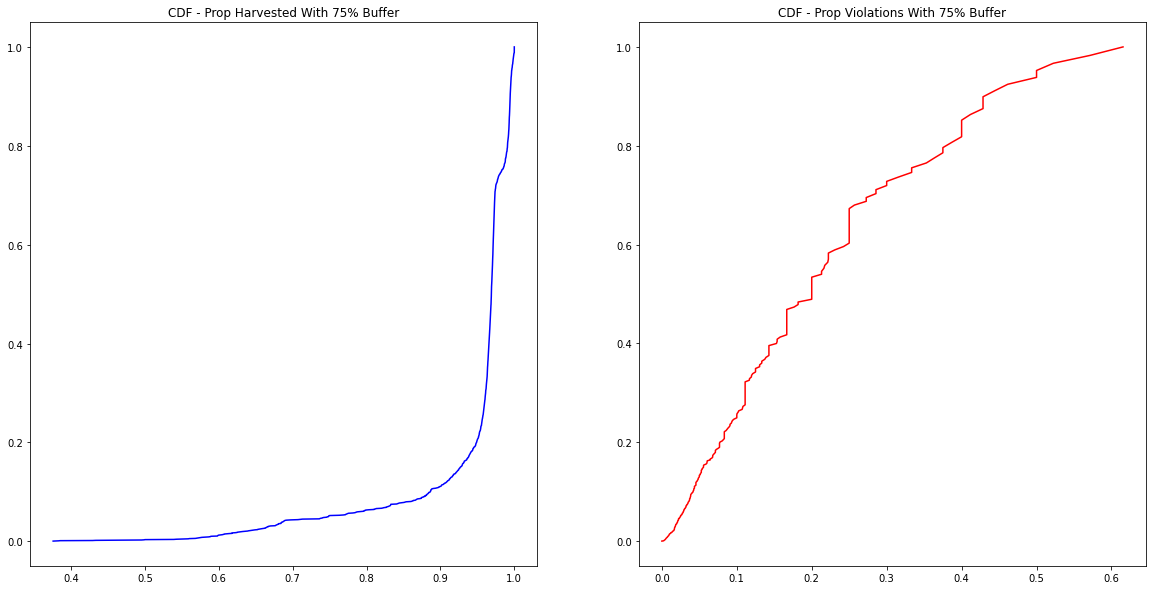

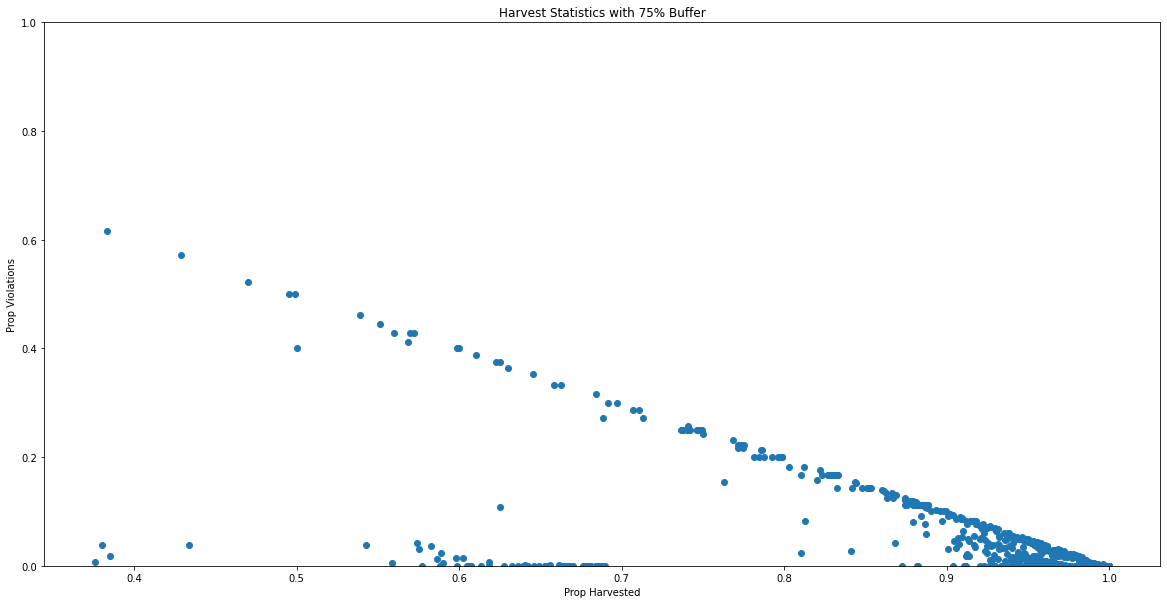

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.936326         0.025018
std          0.097676         0.070302
min          0.375874         0.000000
25%          0.952789         0.000000
50%          0.968357         0.000000
75%          0.978176         0.007353
max          1.000000         0.615385


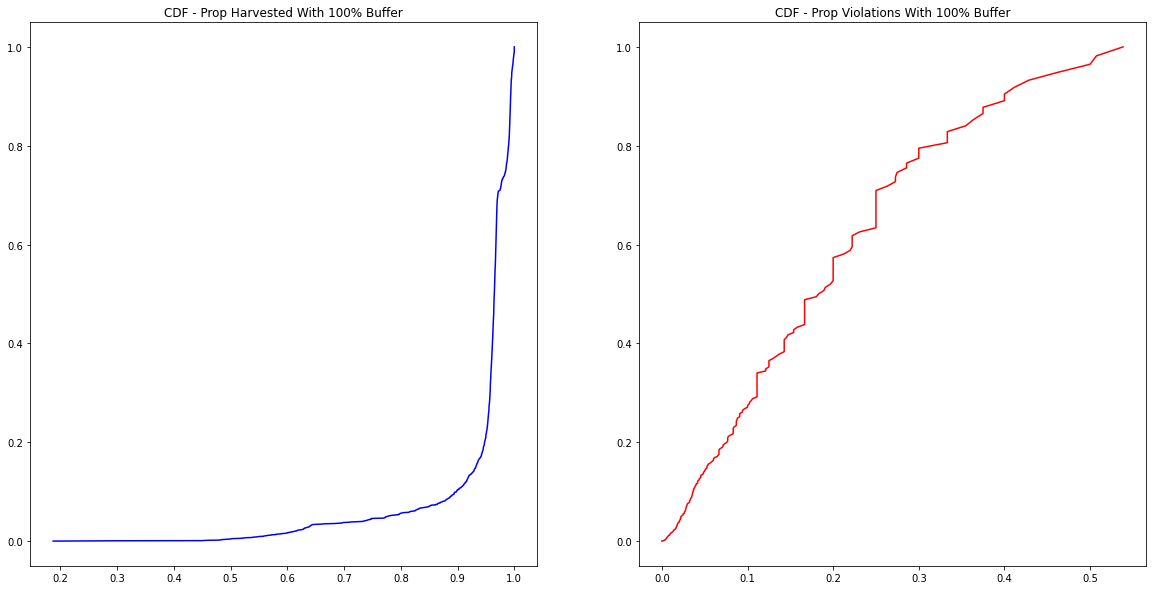

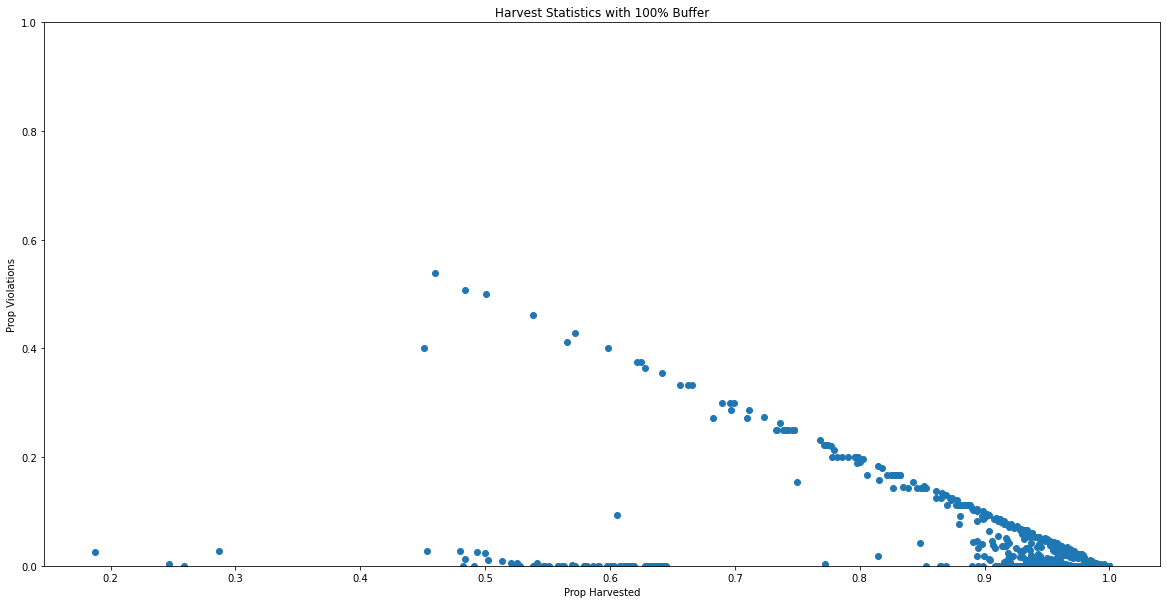

       prop_harvested  prop_violations
count     1432.000000      1432.000000
mean         0.933656         0.020837
std          0.104074         0.061577
min          0.187338         0.000000
25%          0.950791         0.000000
50%          0.964057         0.000000
75%          0.979907         0.003325
max          1.000000         0.538462


In [40]:
model_results_dfs['xgb'] = get_model_results(max_cpu_3_dir, 5, "xgb")

                 id  train_mase_arima  test_mase_arima  under_mase_arima  \
count  1.421000e+03       1421.000000      1421.000000       1421.000000   
mean   3.709483e+11          0.926246         1.948670          0.609876   
std    7.645727e+10          0.192776        10.076937          0.680936   
min    1.950000e+02          0.000000         0.000000          0.000000   
25%    3.807103e+11          0.839187         0.775960          0.232444   
50%    3.835413e+11          0.914014         0.999676          0.479853   
75%    3.961133e+11          1.000737         1.528241          0.826840   
max    4.004415e+11          3.409737       289.433227         16.899247   

       prop_under_preds_arima  max_under_pred_arima  over_mase_arima  \
count             1421.000000           1320.000000      1421.000000   
mean                 0.431860             79.060413         1.338794   
std                  0.275654            463.988963        10.115736   
min                  0.0000

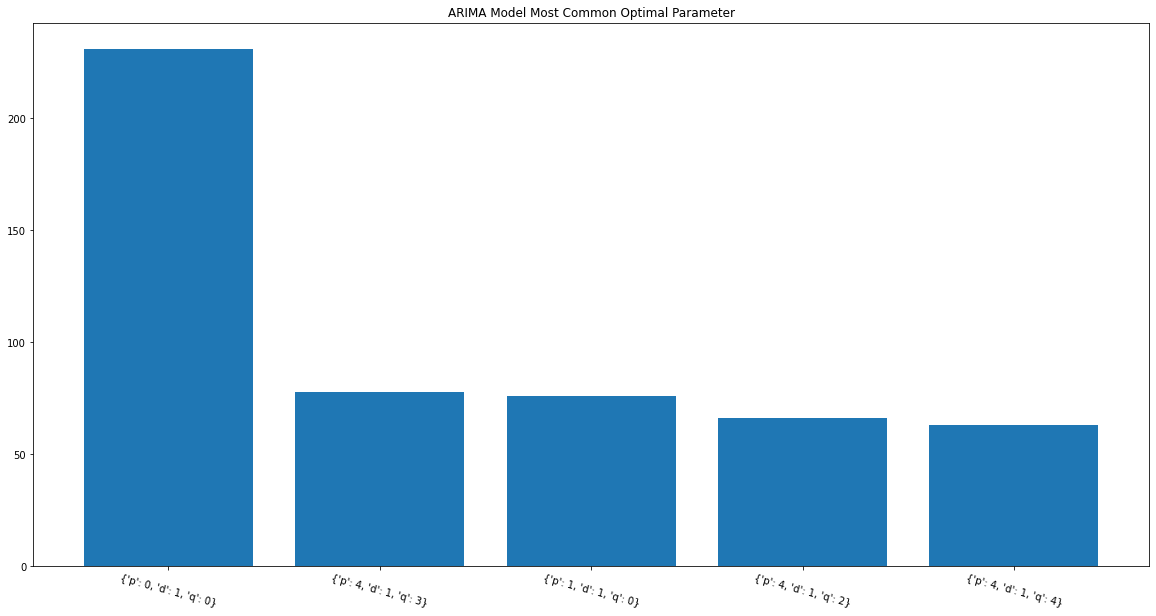

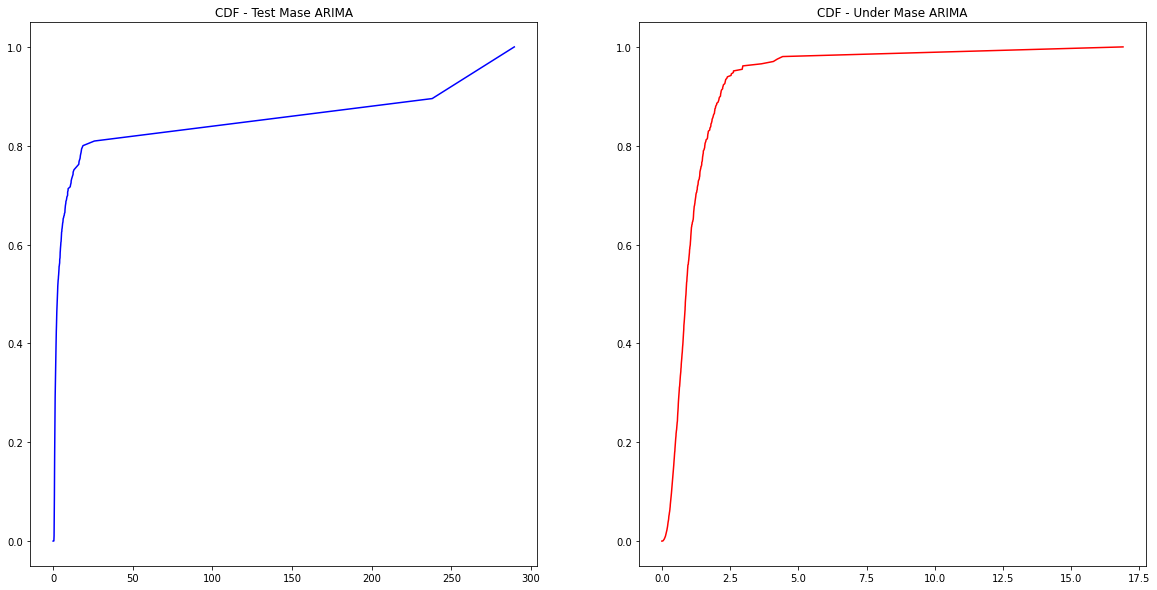

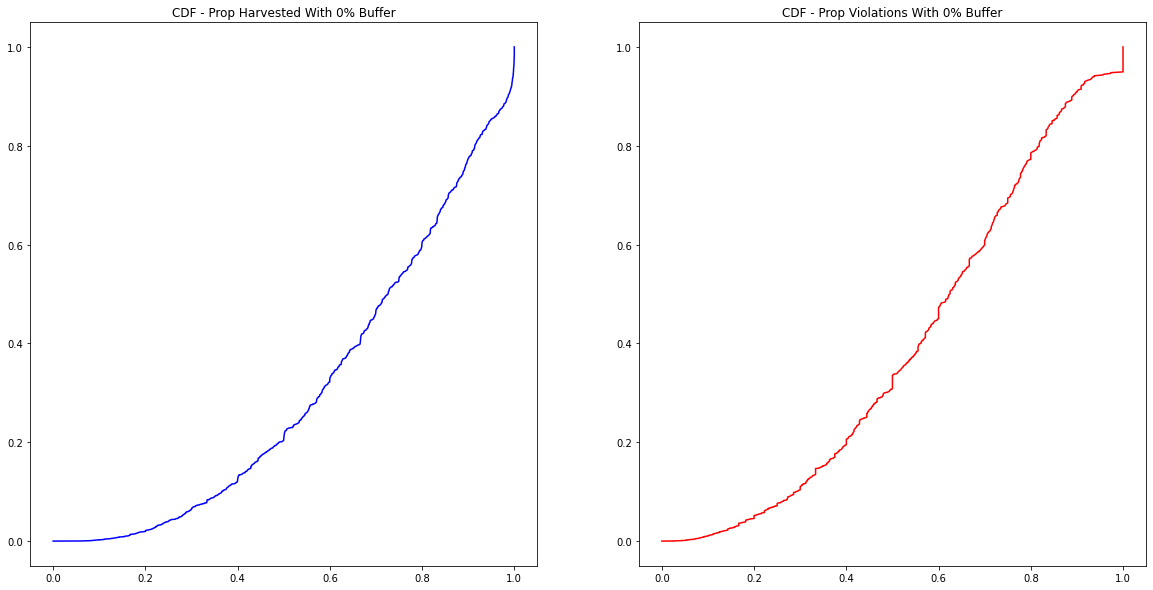

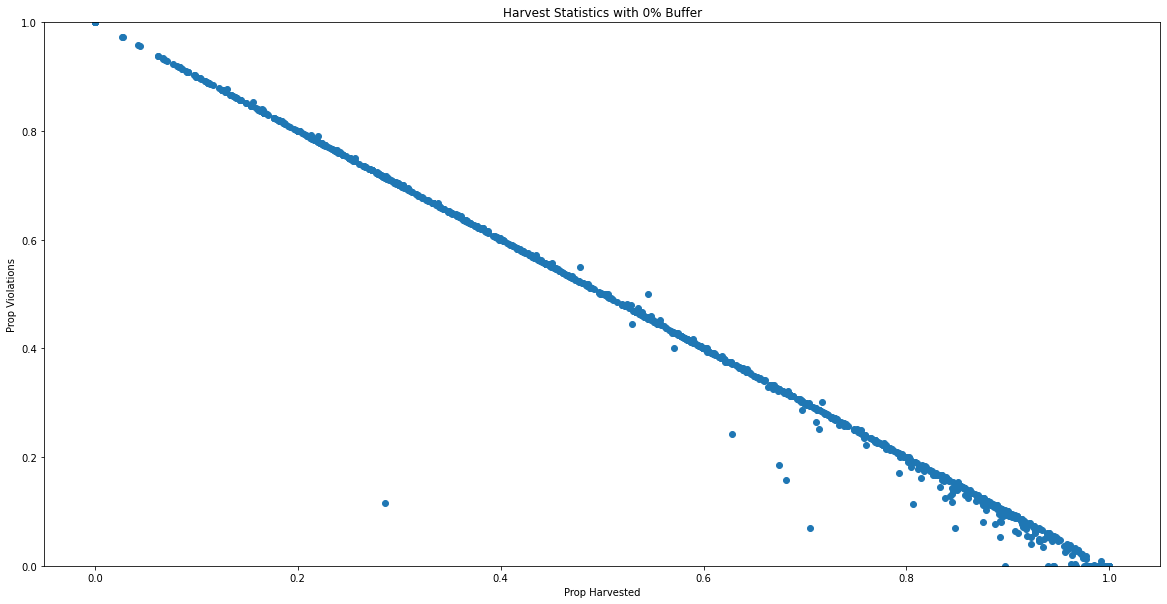

       prop_harvested  prop_violations
count     1421.000000      1421.000000
mean         0.565764         0.431860
std          0.272662         0.275654
min          0.000000         0.000000
25%          0.350180         0.200000
50%          0.578146         0.420000
75%          0.799546         0.649123
max          1.000000         1.000000


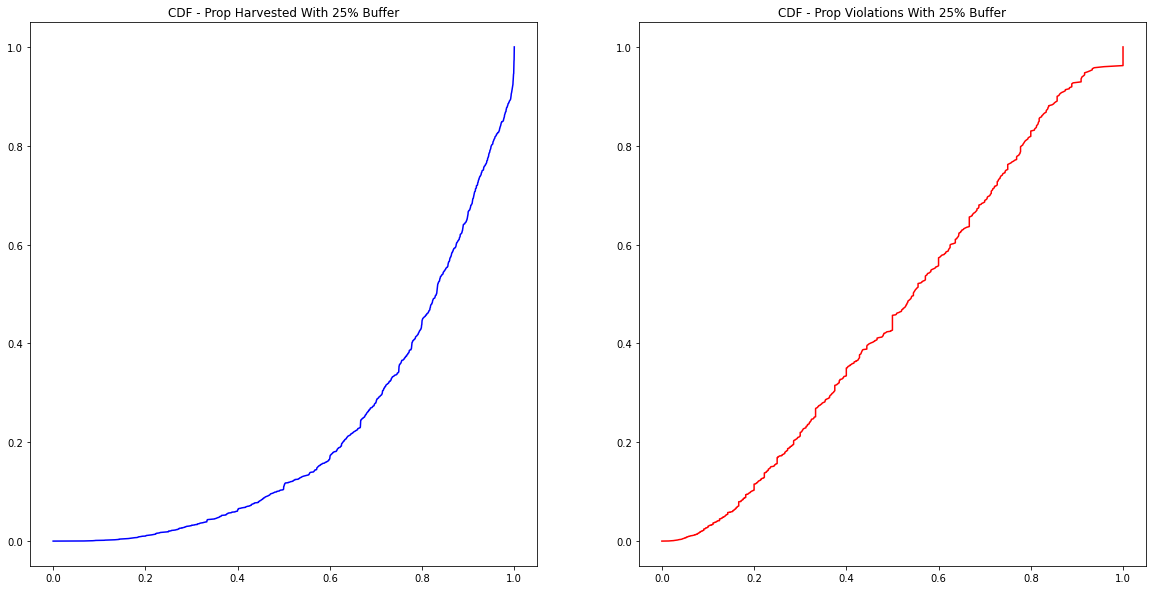

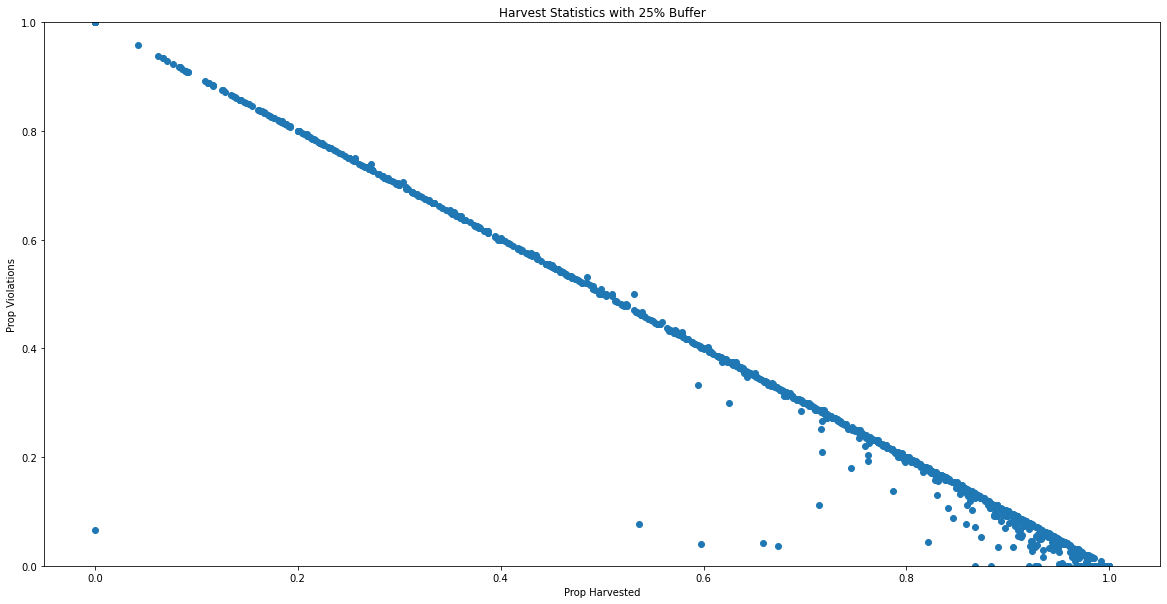

       prop_harvested  prop_violations
count     1421.000000      1421.000000
mean         0.678599         0.316655
std          0.261270         0.264378
min          0.000000         0.000000
25%          0.499997         0.095238
50%          0.749511         0.250000
75%          0.895992         0.500000
max          1.000000         1.000000


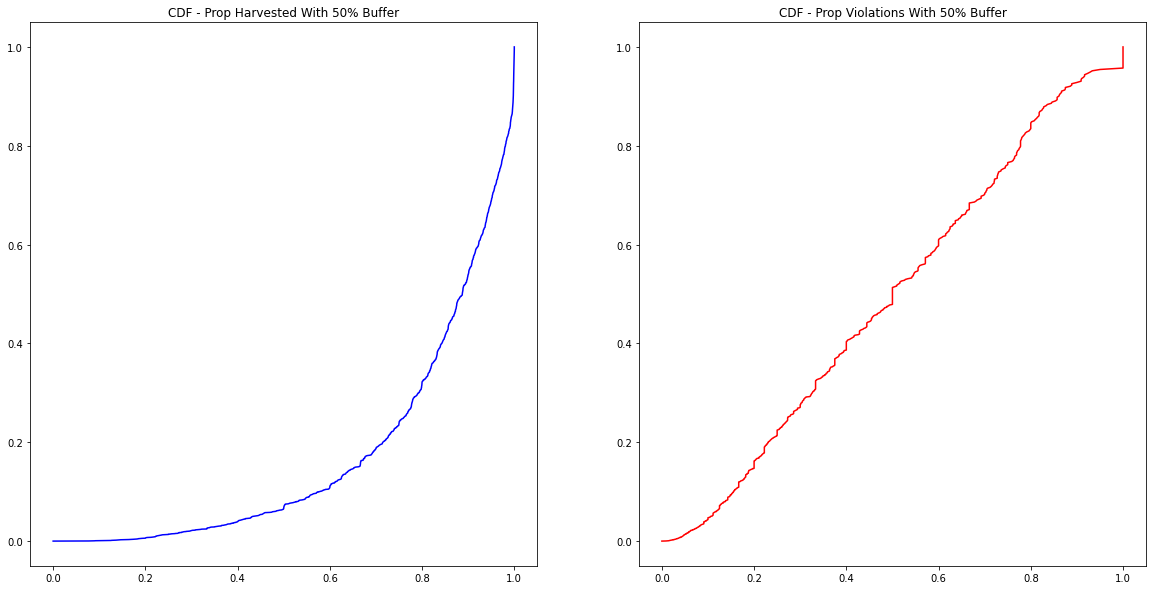

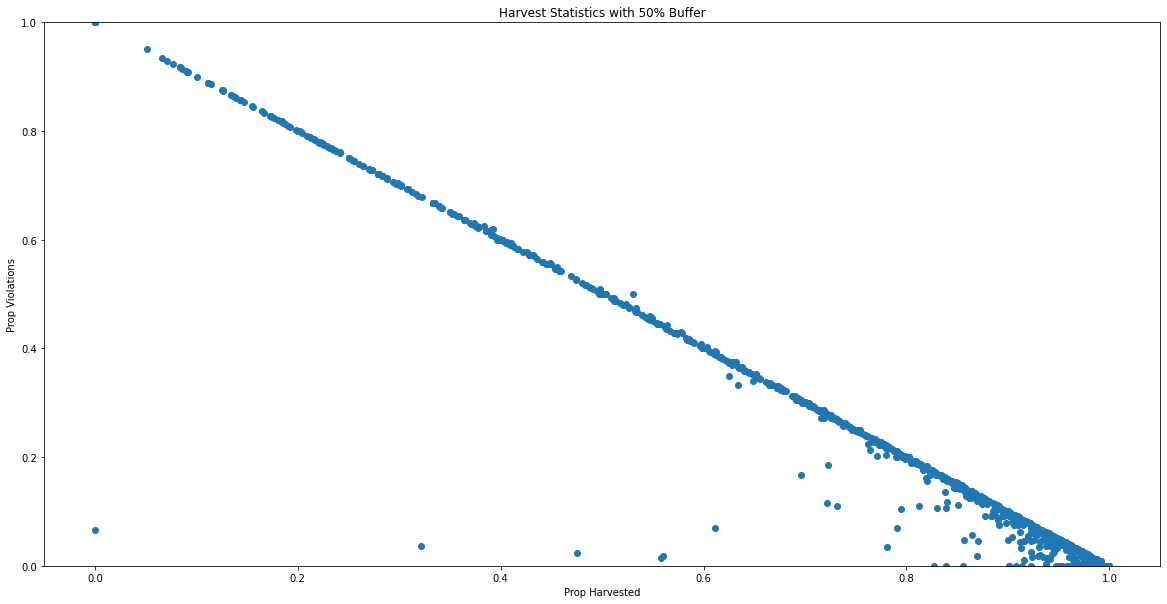

       prop_harvested  prop_violations
count     1421.000000      1421.000000
mean         0.746171         0.246669
std          0.251383         0.254286
min          0.000000         0.000000
25%          0.621095         0.042553
50%          0.831538         0.164948
75%          0.944730         0.375000
max          1.000000         1.000000


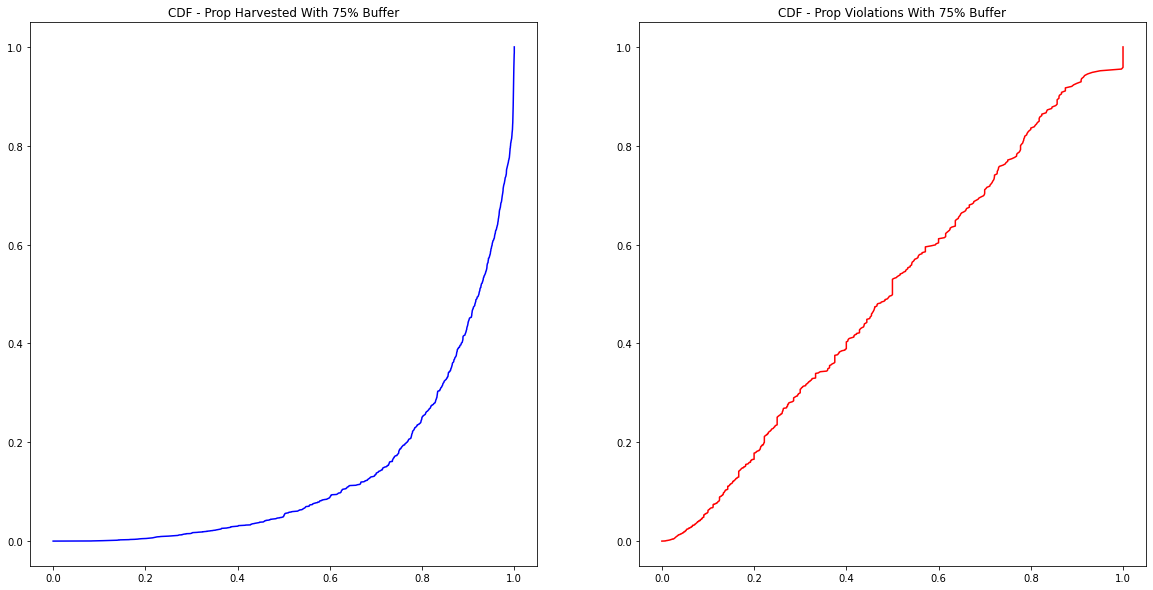

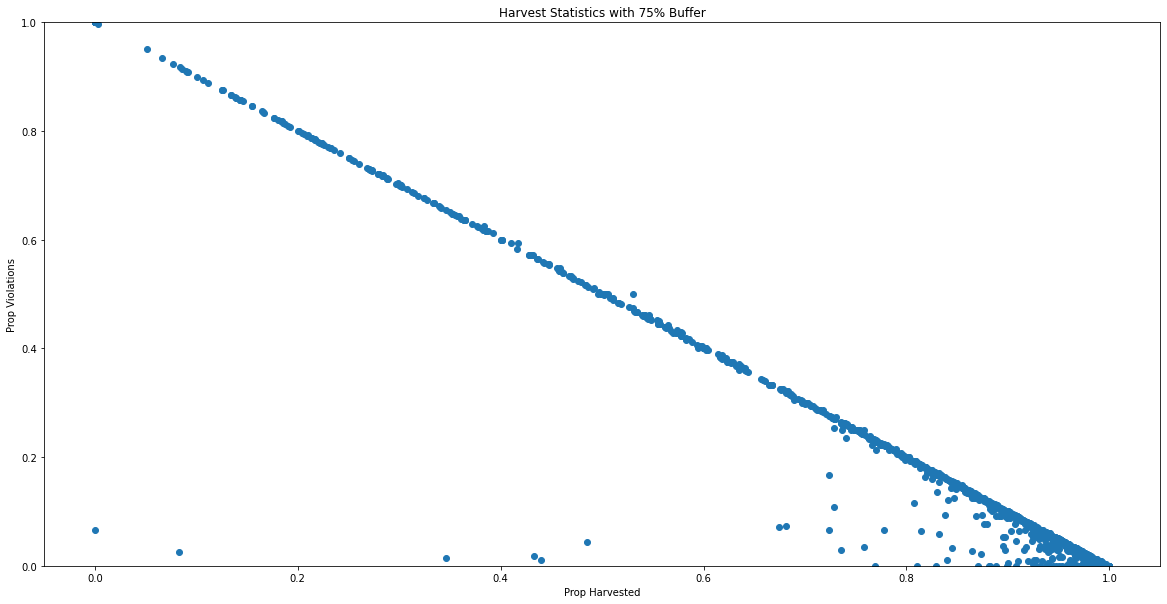

       prop_harvested  prop_violations
count     1421.000000      1421.000000
mean         0.786266         0.204046
std          0.243866         0.245927
min          0.000000         0.000000
25%          0.699076         0.010929
50%          0.877544         0.106061
75%          0.971489         0.295918
max          1.000000         1.000000


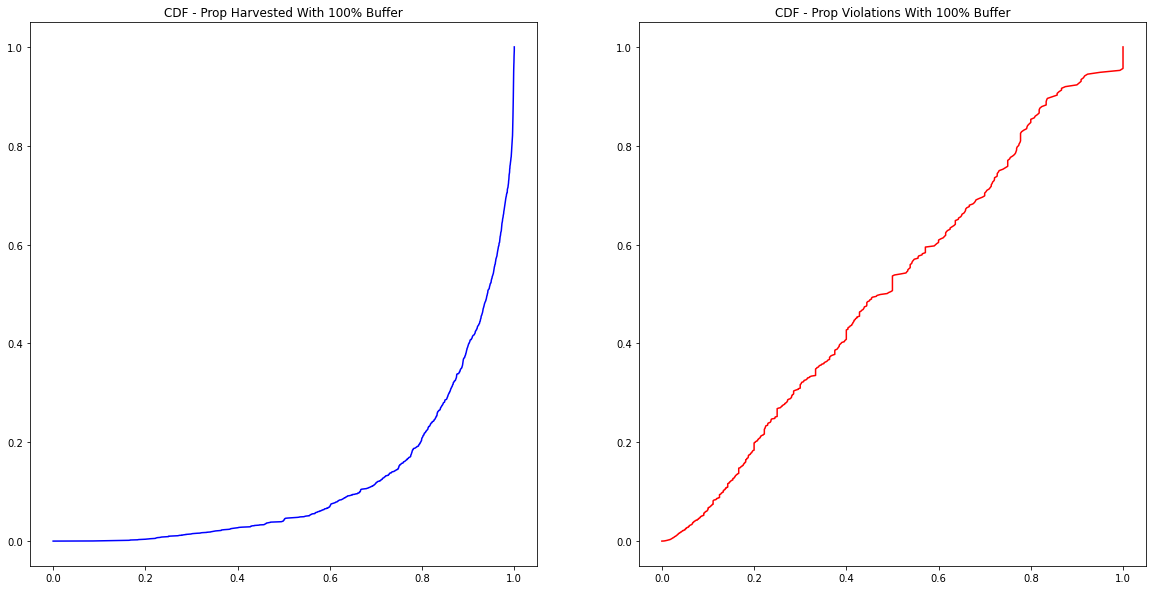

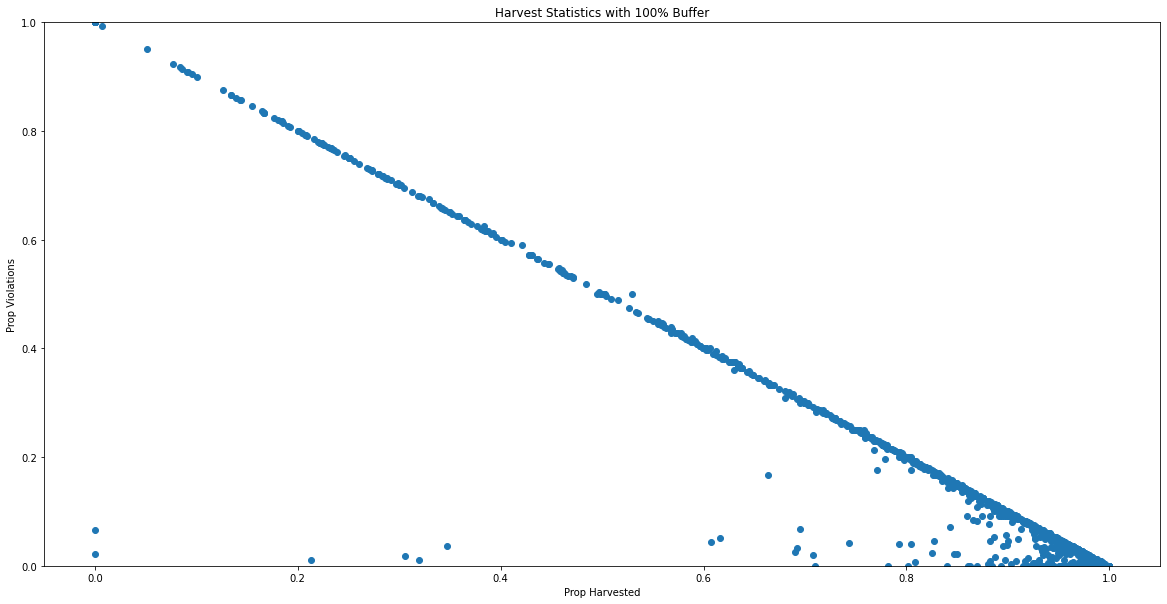

       prop_harvested  prop_violations
count     1421.000000      1421.000000
mean         0.810001         0.177899
std          0.235751         0.236718
min          0.000000         0.000000
25%          0.741633         0.000000
50%          0.901986         0.074627
75%          0.981410         0.250000
max          1.000000         1.000000


In [41]:
model_results_dfs['arima'] = get_model_results(max_cpu_3_dir, 5, "arima")

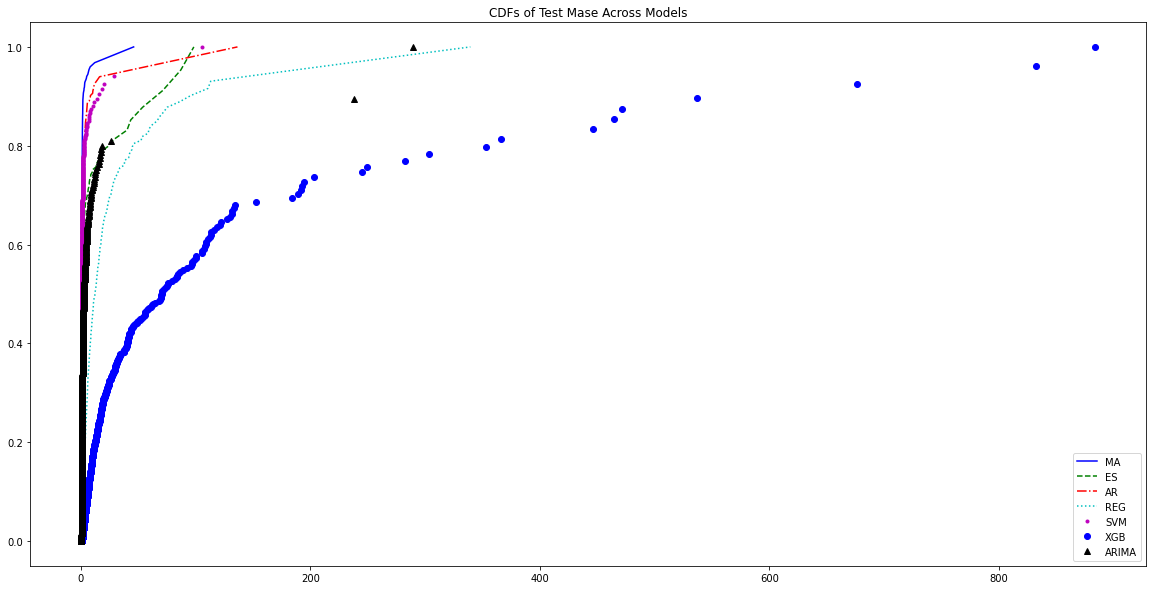

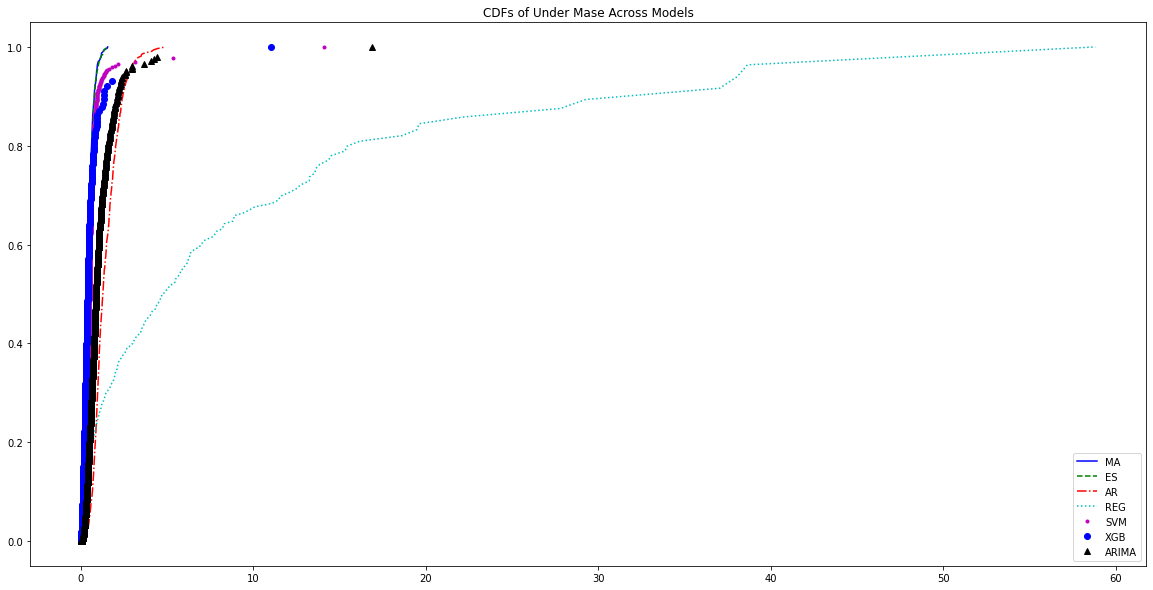

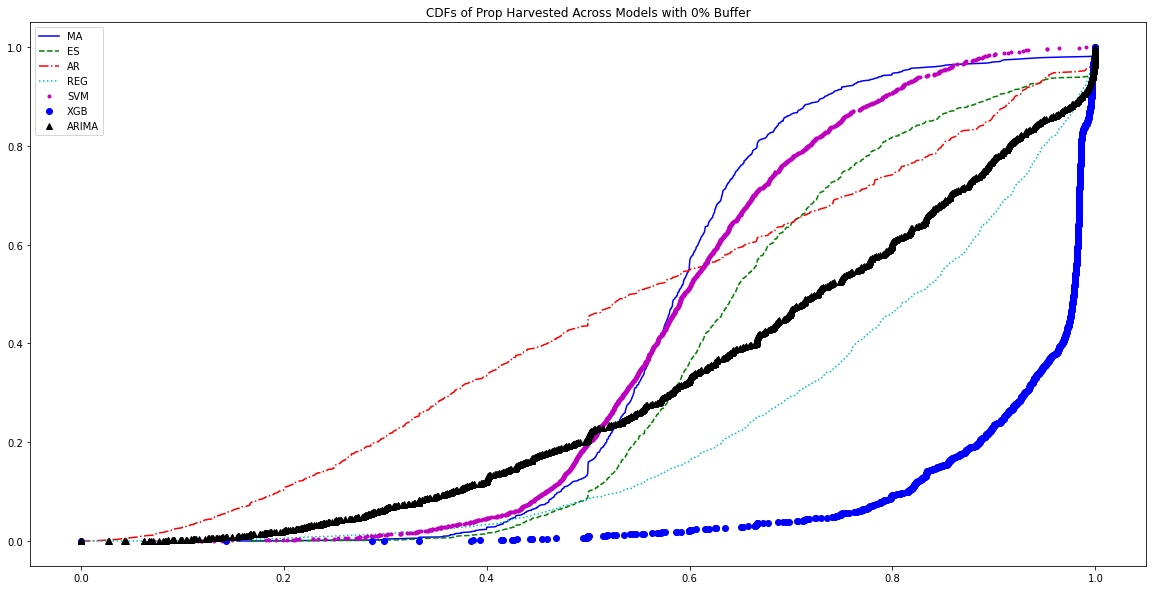

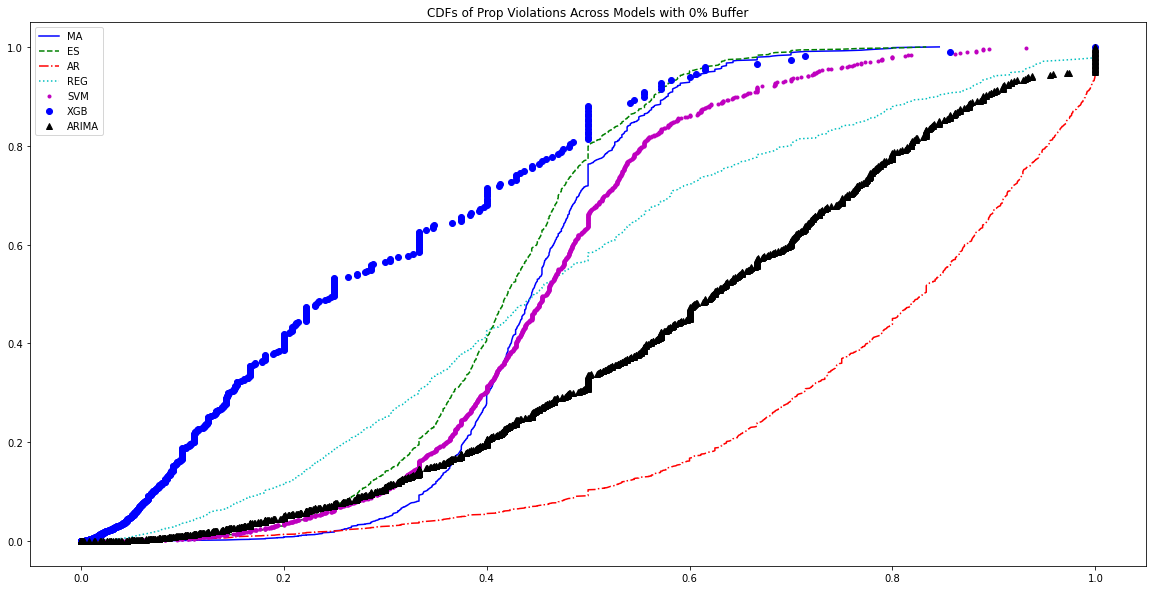

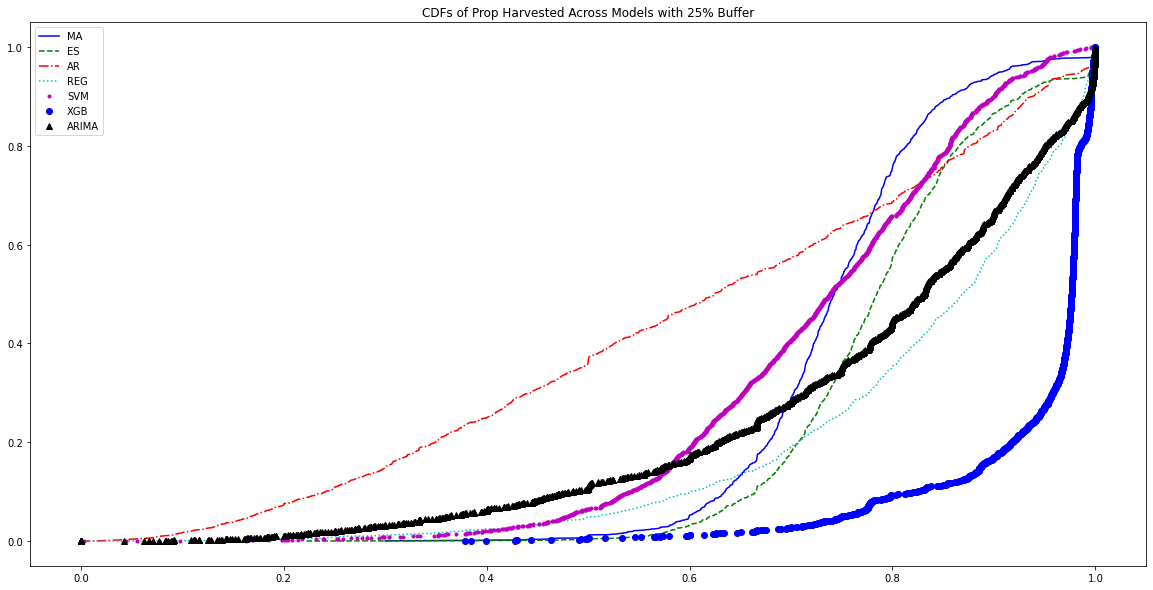

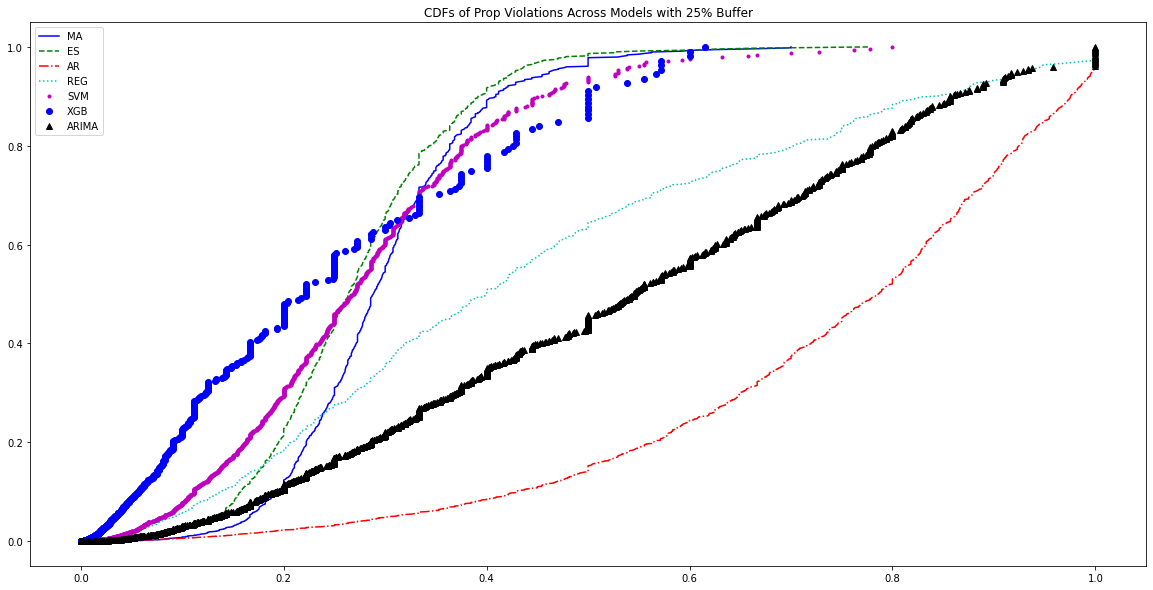

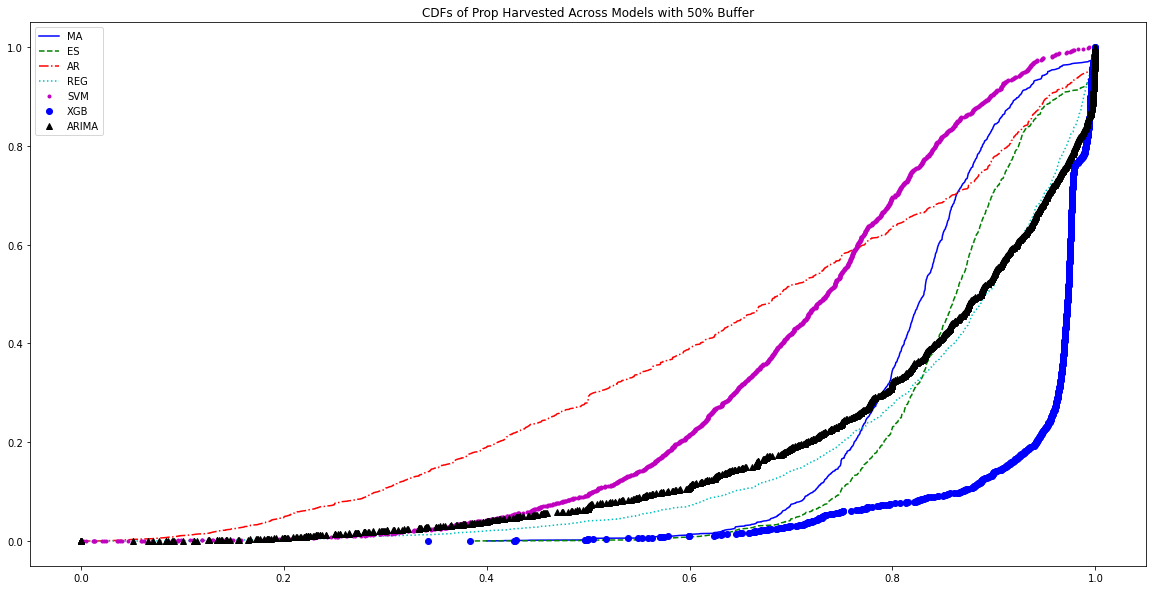

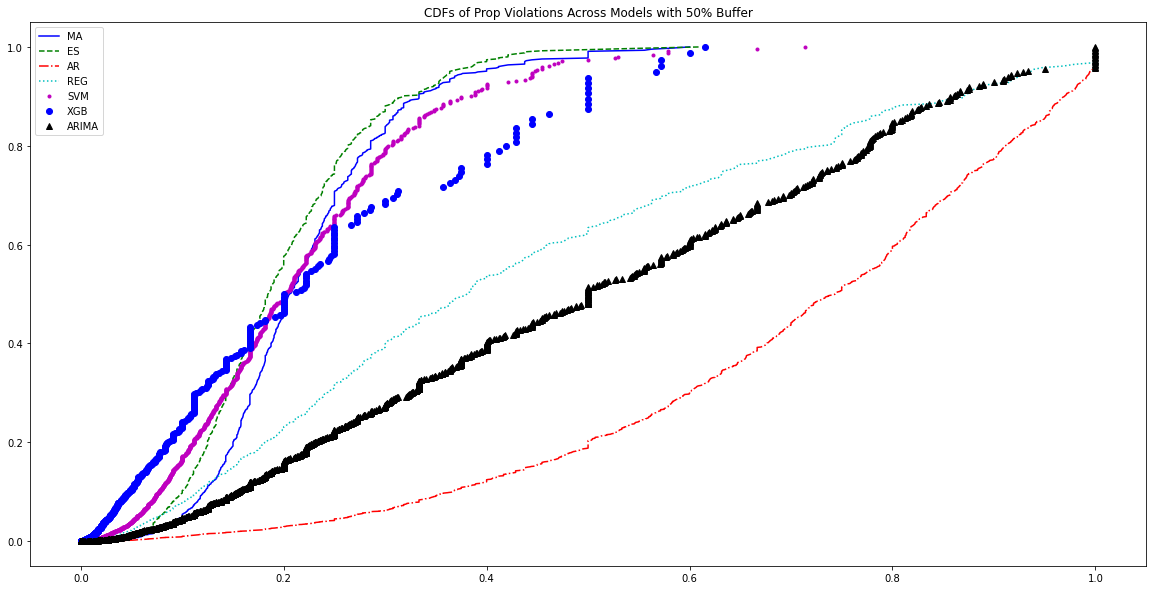

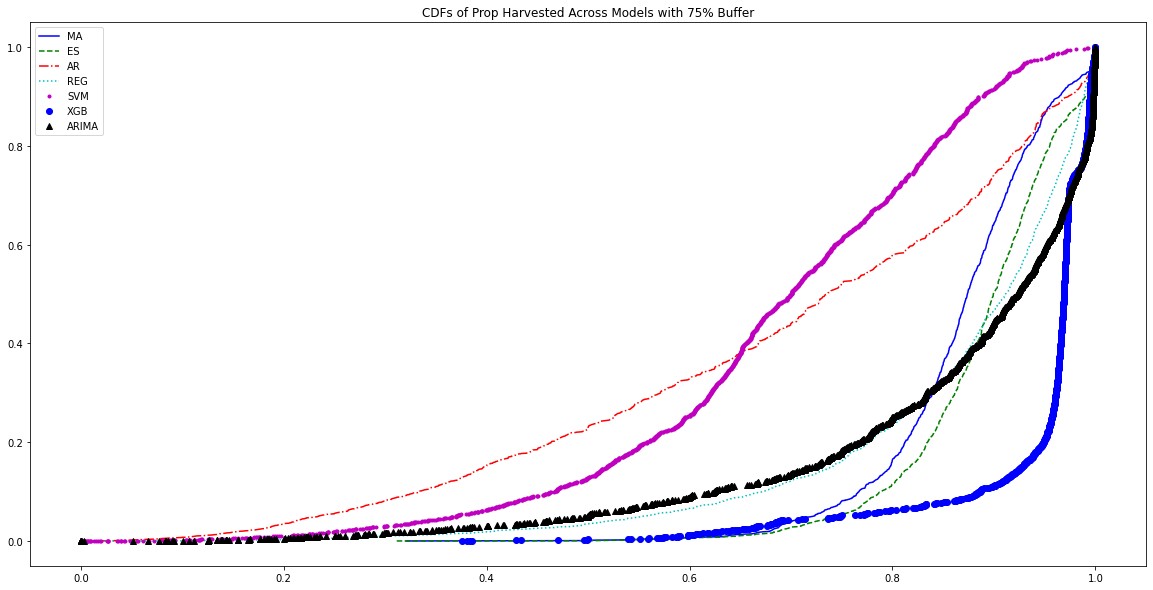

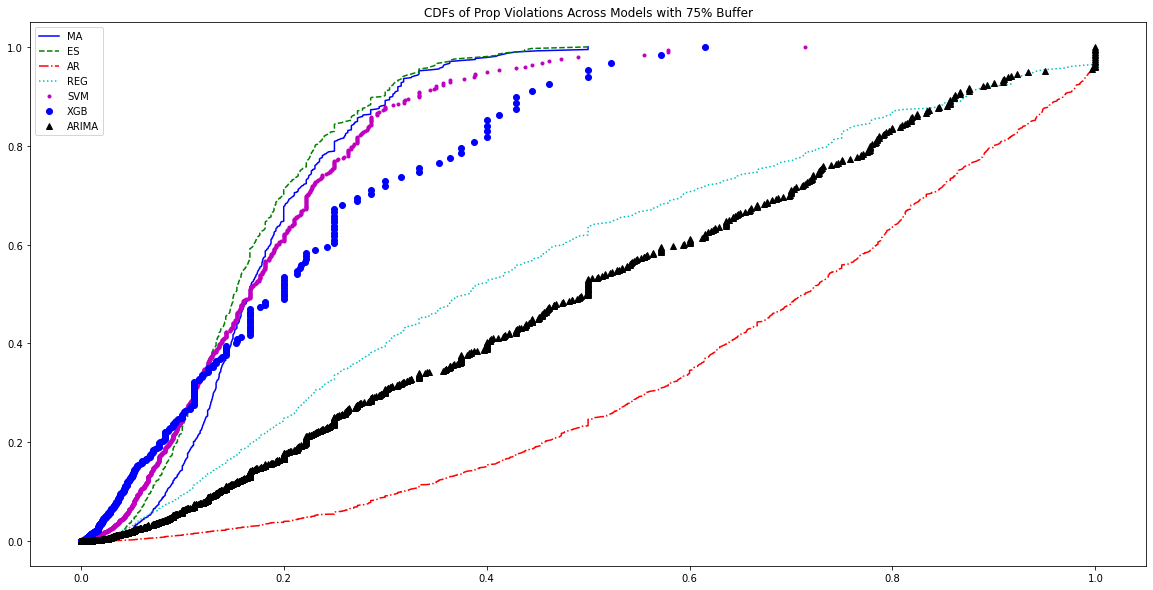

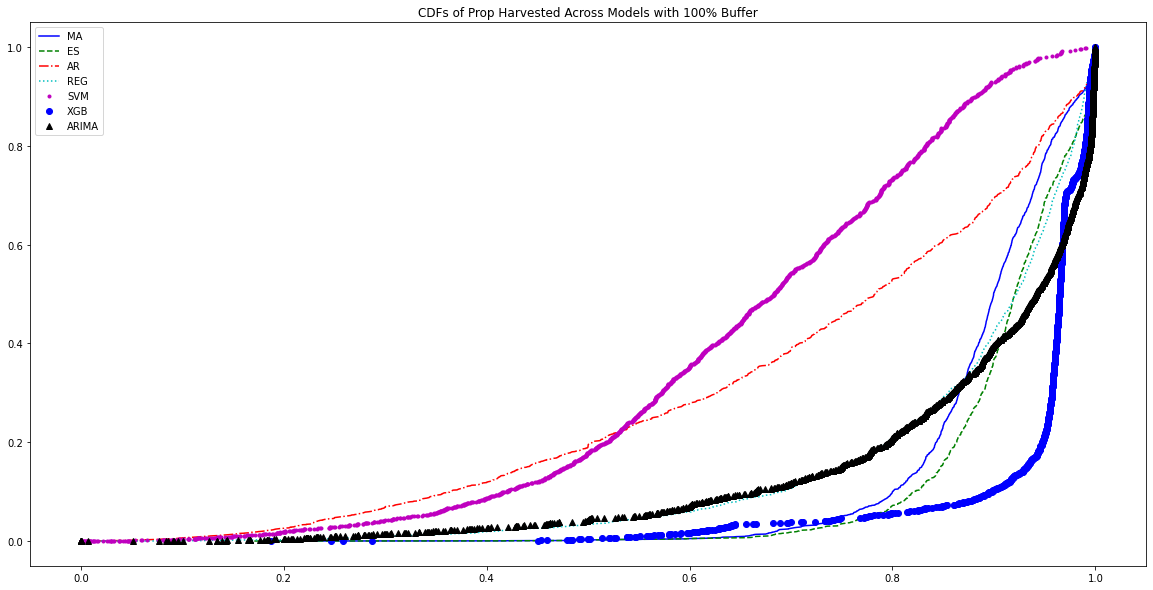

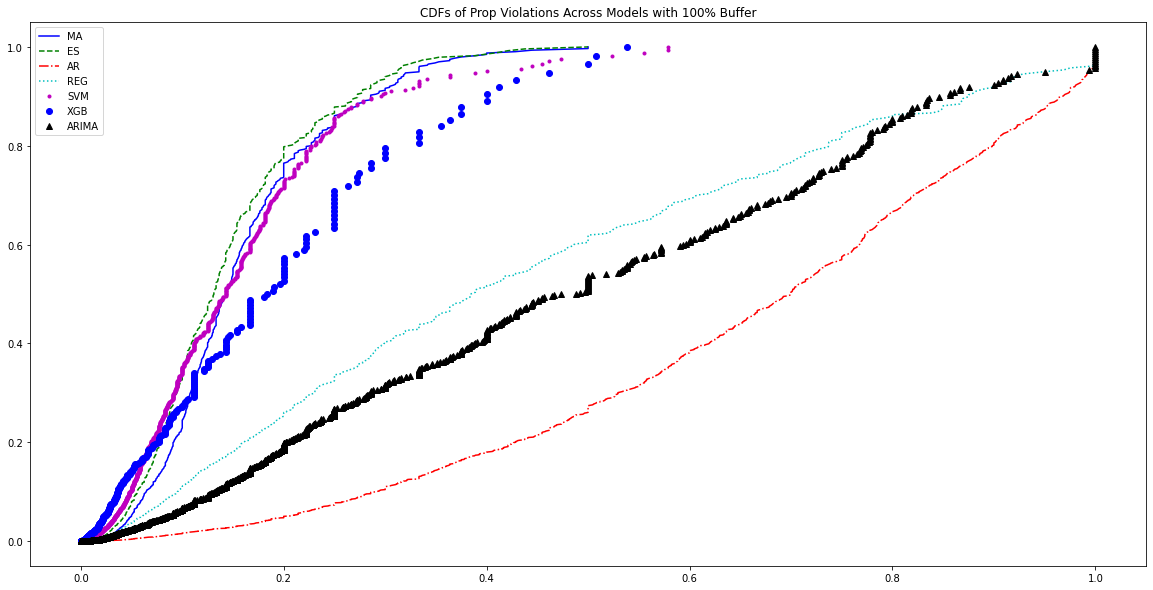

In [42]:
plot_all_cdfs_across_models(model_results_dfs)

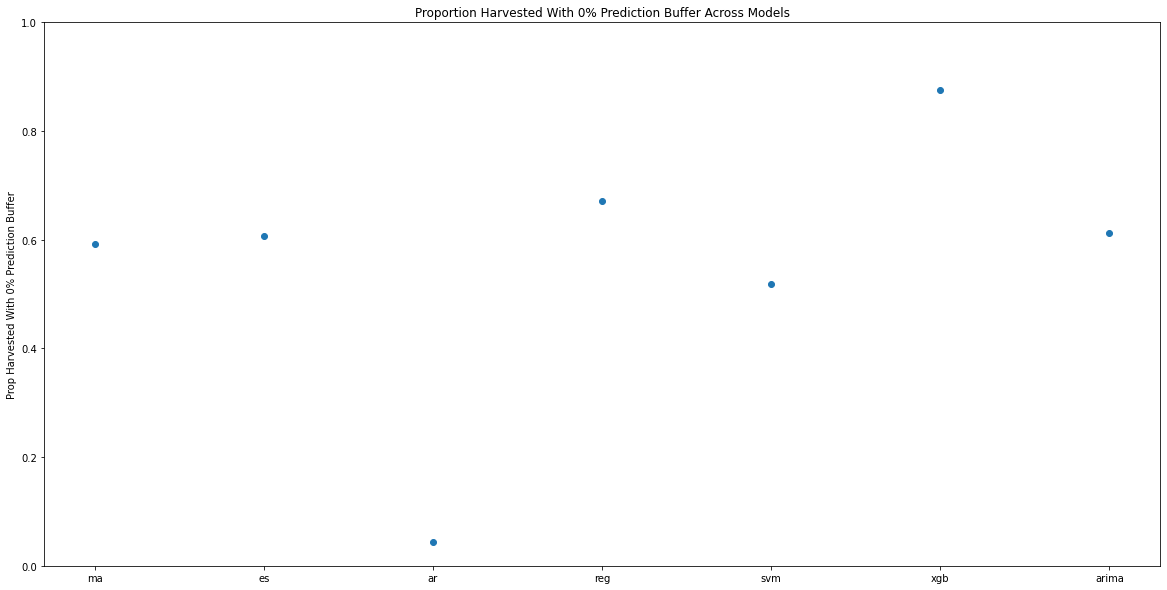

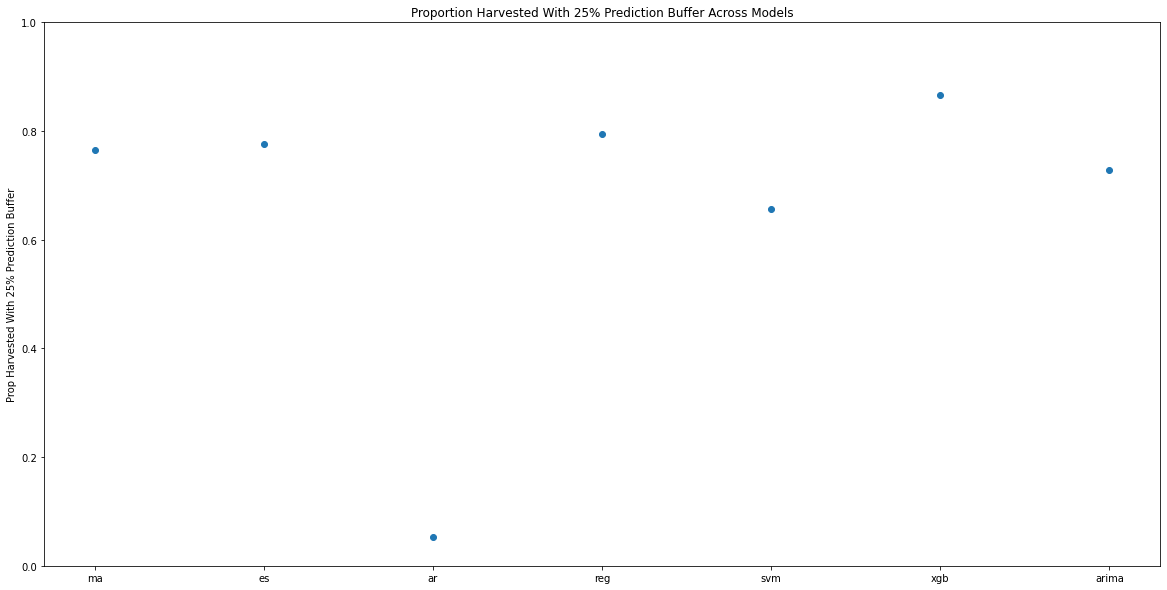

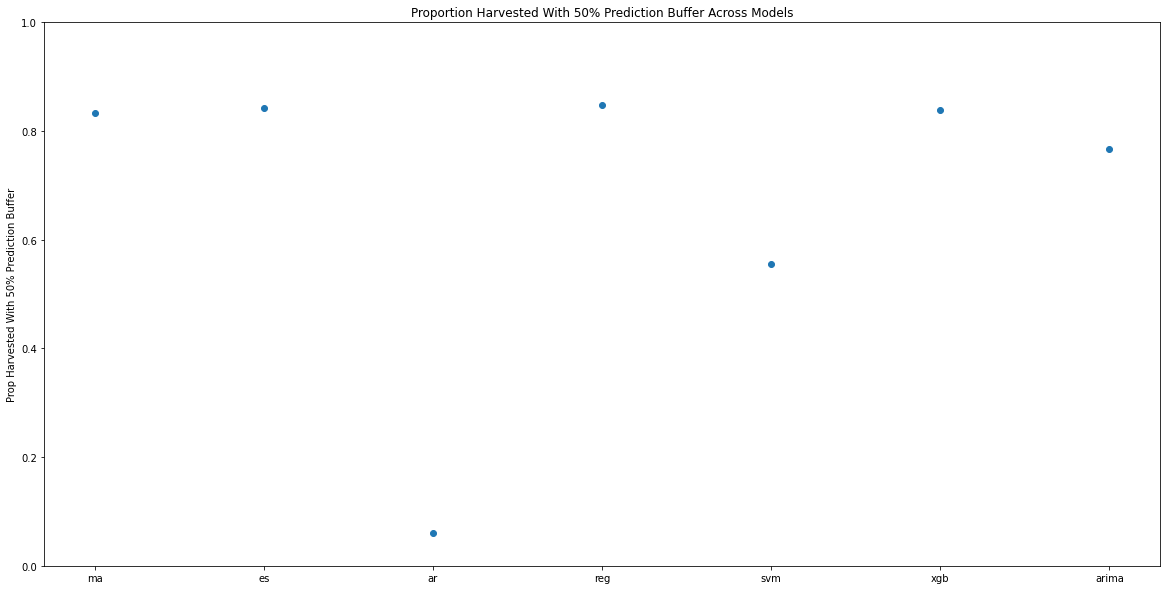

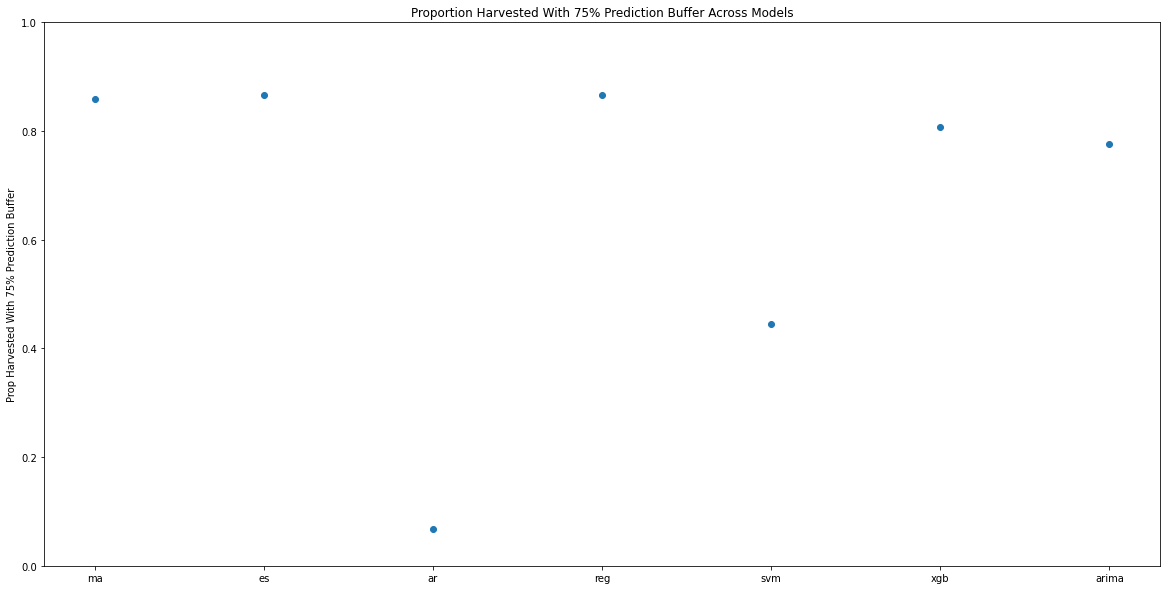

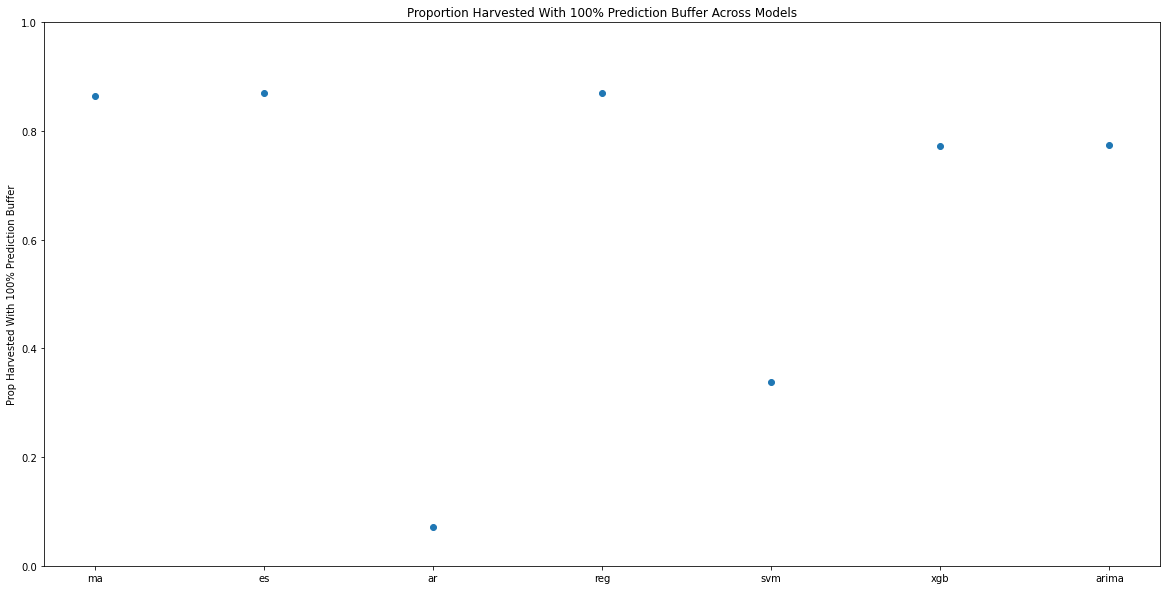

In [43]:
compare_model_harvest_results(model_results_dfs)

In [ ]:
analysis.output_best_model_results_from_model_results_dfs(model_results_dfs, max_cpu_3_dir)

In [ ]:
model_names = list(model_results_dfs.keys()) + ['best']

In [ ]:
model_results_dfs['best'] = display_best_model_results_for_all_traces(max_cpu_3_dir)

In [ ]:
print("Test MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "test_mase")

In [ ]:
print("Under Predictions MASE")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "under_mase")

In [ ]:
print("Proportion of CPU Harvested with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_harvested_0.0")

In [ ]:
print("Proportion of Violations with 0% Buffer")
analysis.get_percentiles_df_for_model_results(model_results_dfs, model_names, "prop_violations_0.0")